# Predicting financial crisis with recurrent neural networks

This file contains the program code behind the article Tölö, E., (2020). “Predicting financial crises with recurrent neural networks,” Journal of Financial Stability, Volume 49, August 2020, 100746. Available at: https://doi.org/10.1016/j.jfs.2020.100746.

This code is made available for advanced users. The code is designed such that it can be mostly (but not completely) run sequentially starting from the top.

First some libraries and data are imported. Then I define functions that transform the data (make it stationary, drop NaN values etc). Then more functions for the classification task, definition of models and model evaluation. After all the functions have been defined, the results are calculated by calling the function with specific input parameters - sometimes in a loop.

Some of the code is probably dense and hard to follow. That is mainly because of storing all the intermediate results and statistics for the article, and running all different options in a loop.

If you want to run some of the models included in the article, I recommend to extract the relevant parts of the code listed here, and build it into your own program.
 1. Data processing (top part of the code)
 2. Reshaping data to be suitable input to neural nets (search for reshape, there are one or two such short functions)
 3. Inspect getModel to find out how the neural net that you are interested can be initialized.
 4. Inspect fitModel to find out how the neural net that you are interested in can be fitted to the data.
 5. There are also functions for calculating the AUC statistics, usefulness, etc. that you may find useful.
 6. The cross-validation and sequential evaluation functions may also be of interest to you, albeit these parts of the code are somewhat complicated to read because of the factors mentioned earlier.
 7. There is also functions that implement the calculation and analysis of Shapley values. Feel free to use them, but may be easier (safer) to build your own.
 
**Cite as:**
 
**Tölö, E., (2020). “Predicting financial crises with recurrent neural networks,” Journal of Financial Stability, Volume 49, August 2020, 100746. Available at: https://doi.org/10.1016/j.jfs.2020.100746**




## Import libraries

In [ ]:
#cd "C:\Users\eerot\Desktop\NNCALC"
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
#cd "/content/gdrive/My Drive/Colab Notebooks/nnoutput"

In [ ]:
#%tensorflow_version 2.x
# %tensorflow_version 1.x
import tensorflow as tf
from datetime import datetime
print(tf.__version__)
#from tf.keras.utils import to_categorical
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from keras.models import load_model
from keras import optimizers

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder
import statsmodels.api as sm

import matplotlib.pyplot as plt
from scipy.stats import norm
import time 

from numpy.random import seed
from tensorflow import set_random_seed

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM,CuDNNLSTM, SimpleRNN, CuDNNGRU
from keras.regularizers import l2 as l2_reg
from keras.layers.normalization import BatchNormalization

#import tf.compat.v1.set_random_seed as set_random_seed

from keras import backend as K 


1.15.0


Using TensorFlow backend.


In [ ]:
# https://stackoverflow.com/questions/2125702/how-to-suppress-console-output-in-python
# With this, you can use context management wherever you want to suppress output:

from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

print("Now you see it")
with suppress_stdout():
    print("Now you don't")

Now you see it


## Import data (**you** need to modify this)

In [ ]:
# Upload the data file in Google Colab (if you run the code locally, you may skip this cell)
#from google.colab import files
#uploaded = files.upload()

In [ ]:
# Load the raw data file into dataframe
#df = pd.read_csv('JSTdatasetR3.csv')
#df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/nnoutput/JSTdatasetR3.csv')
df = pd.read_csv('C:/Users/eerot/Desktop/NNCALC/JSTdatasetR3.csv')
df.head()

,year,country,iso,ifs,pop,rgdpmad,rgdppc,rconpc,gdp,iy,...,debtgdp,revenue,expenditure,xrusd,crisisJST,tloans,tmort,thh,tbus,hpnom
0,1870,Australia,AUS,193,1775.0,3273.239437,13.836157,21.449734,208.78,0.109266,...,0.172568,NaN,NaN,0.366946,0,54.792,1.680,1.680,53.112,0.492253
1,1871,Australia,AUS,193,1675.0,3298.507463,13.936864,19.930801,211.56,0.104579,...,0.191799,NaN,NaN,0.369146,0,53.748,1.766,1.766,51.982,0.469877
2,1872,Australia,AUS,193,1722.0,3553.426249,15.044247,21.085006,227.40,0.130438,...,0.154920,NaN,NaN,0.369239,0,55.822,1.470,1.470,54.352,0.484794
3,1873,Australia,AUS,193,1769.0,3823.629169,16.219443,23.254910,266.54,0.124986,...,0.142692,NaN,NaN,0.362405,0,65.380,1.364,1.364,64.016,0.469877
4,1874,Australia,AUS,193,1822.0,3834.796926,16.268228,23.458050,287.58,0.141960,...,0.194322,NaN,NaN,0.372223,0,71.478,1.434,1.434,70.044,0.566836


## Function for initializing the data (includes making stationary, dropping NaN values and picking the interesting variables)

In [ ]:

def init_data(df,start_year = 1970, end_year=2016, y_shift = 1, normalize = False):
  # Define real gdp as nominal gdp / price level and real house price as nominal house price / price level
  df2 = df
  df2['tloansgdp'] = 100 * df2['tloans'] / df2['gdp']
  df2['ca/gdp'] = 100 * df2['ca'] / df2['gdp']
  df2['rgdp'] = df2['gdp'] / df2['cpi']
  df2['rhp'] = df2['hpnom'] / df2['cpi']
  df2['rsp'] = df2['stocks'] / df2['cpi']
  df2['rtloans'] = df2['tloans'] / df2['cpi']
  df2['rtmort'] = df2['tmort'] / df2['cpi']
  df2['rthh'] = df2['thh'] / df2['cpi']
  df2['rtbus'] = df2['tbus'] / df2['cpi']
  # Define annual growth rates
  df2['tloansgdp_g'] = 100 * ( df2['tloansgdp'] / df2['tloansgdp'].shift(+y_shift) - 1 )
  df2['cpi_g'] = 100 * ( df2['cpi'] / df2['cpi'].shift(+y_shift) - 1 )
  df2['rsp_g'] = 100 * ( df2['rsp'] / df2['rsp'].shift(+y_shift) - 1 )
  df2['debtgdp_g'] = 100 * ( df2['debtgdp'] / df2['debtgdp'].shift(+y_shift) - 1 )
  df2['rgdp_g'] = 100 * ( df2['rgdp'] / df2['rgdp'].shift(+y_shift) - 1 )
  df2['rhp_g'] = 100 * ( df2['rhp'] / df2['rhp'].shift(+y_shift) - 1 )
  df2['rtloans_g'] = 100 * ( df2['rtloans'] / df2['rtloans'].shift(+y_shift) - 1 )
  df2['rtmort_g'] = 100 * ( df2['rtmort'] / df2['rtmort'].shift(+y_shift) - 1 )
  df2['rthh_g'] = 100 * ( df2['rthh'] / df2['rthh'].shift(+y_shift) - 1 )
  df2['rtbus_g'] = 100 * ( df2['rtbus'] / df2['rtbus'].shift(+y_shift) - 1 )
  [n,k] = df2.shape
  for i in range(2,n):
    if df2.at[i, 'iso'] != df2.at[i-y_shift, 'iso']:
      df2.at[i, 'tloansgdp_g'] = np.nan
      df2.at[i, 'cpi_g'] = np.nan
      df2.at[i, 'rsp_g'] = np.nan
      df2.at[i, 'debtgdp_g'] = np.nan
      df2.at[i, 'rgdp_g'] = np.nan
      df2.at[i, 'rhp_g'] = np.nan
      df2.at[i, 'rtloans_g'] = np.nan
      df2.at[i, 'rtmort_g'] = np.nan
      df2.at[i, 'rthh_g'] = np.nan
      df2.at[i, 'rtbus_g'] = np.nan
  # Keep only a set of variables
  varlist = ['year','iso','cpi_g','rgdp_g','ca/gdp','debtgdp_g','tloansgdp_g','rsp_g','rhp_g','rtloans_g','rtmort_g','rthh_g','rtbus_g','ltrate','stir','crisisJST']
  df2=df2[varlist]
  # And drop NaN values.
  df2 = df2[df2['tloansgdp_g'].notna()]
  
  df2 = df2[df2['rgdp_g'].notna()]
  df2 = df2[df2['ca/gdp'].notna()]
  df2 = df2[df2['rhp_g'].notna()]
  df2 = df2[df2['rsp_g'].notna()]
  #df2 = df2[df2['rthh_g'].notna()]  
  #df2 = df2[df2['cpi_g'].notna()]
  #df2 = df2[df2['debtgdp_g'].notna()]
  #df2 = df2[df2['rtloans_g'].notna()]
  #df2 = df2[df2['rtmort_g'].notna()]
  #df2 = df2[df2['rtbus_g'].notna()]
  #df2 = df2[df2['ltrate'].notna()]
  #df2 = df2[df2['stir'].notna()]
  df2 = df2[df2.year >= start_year]
  df2 = df2[df2.year <= end_year]
  
  for var in varlist[2:-1]:
    mean = np.mean(df2[var])
    std = np.std(df2[var])
    print(var,'mean',mean,'std',std)
    if normalize:
      df2[var] = (df2[var]-mean)/std*10
  
  df2['cid'] = df2.iso.astype('category').cat.codes;
  return df2


In [ ]:
# Check whether a given year should be filtered out,
# according to Schularick and Taylor's exclusion principle
def jst_check(year,country):  
  if(year>=1914 and year <= 1919): #Exclude WW1
    return True
  if(year>=1939 and year <= 1947):      #Exclude WW2
    return True
  if(country == 'DEU' and (year>=1920 and year <= 1925)): #Exclude post WW1 German crisis
    return True
  return False
  

In [ ]:
def add_dist2cris(df2,stfilter = False):
  # Prehorizon = how many years in advance try to forecast the crisis, default is 1 year
  # Postdrop = how many years starting with the crisis to exclude from the analysis, default is to drop 1 year
  # which already ensures a decent cut before the model tries to predict crisis again (1 + number of lags for the features)
  df2.reset_index(drop=True,inplace=True)
  [n,k] = df2.shape
  df2['disttonextcris'] = np.nan;
  df2['disttoprevcris'] = np.nan;
  df2['stfilt'] = 0
  df2.head()
  for i in range(1,n):
    if(jst_check(df2.at[i, 'year'],df2.at[i, 'iso'])):
       df2.at[i, 'stfilt'] = 1
    for j in range(1,11):
       if(i-j>=0):
         if (df2.at[i, 'iso'] == df2.at[i-j, 'iso']) and (df2.at[i-j, 'crisisJST'] == 1):
           df2.at[i,'disttoprevcris'] = j;
    for j in range(0,11):   
       if(i+j<n):
         if (df2.at[i, 'iso'] == df2.at[i+j, 'iso']) and (df2.at[i+j, 'crisisJST'] == 1):
           df2.at[i,'disttonextcris'] = j;
        
  #df2 = df2[df2['disttoprevcris'].notna()]
  #df2 = df2[df2['disttonextcris'].notna()]
  if(stfilter):
    # Drop 1914-19, 1939-47 and "Germany 1920-25"
    df2 = df2[df2.stfilt!=1]
  df2.reset_index(drop=True,inplace=True)
  return df2

## A bit heavy function for the simple task of defining the target variable.

In [ ]:
def add_precrisis(df2,fcast_horizon=1,postdrop=5, stfilter = False):
  # Prehorizon = how many years in advance try to forecast the crisis, default is 1 year
  # Postdrop = how many years starting with the crisis to exclude from the analysis, default is to drop 1 year
  # which already ensures a decent cut before the model tries to predict crisis again (1 + number of lags for the features)
  df2.reset_index(drop=True,inplace=True)
  [n,k] = df2.shape
  df2['precrisis'] = 0
  df2['stfilt'] = 0
  df2.head()
  for i in range(1,n):
    if(jst_check(df2.at[i, 'year'],df2.at[i, 'iso'])):
       df2.at[i, 'stfilt'] = 1
    for j in range(1,fcast_horizon+1):
      if(i+j<n):
        if (df2.at[i, 'iso'] == df2.at[i+j, 'iso']) and (df2.at[i+j, 'crisisJST'] == 1):
          if j==fcast_horizon:
            df2.at[i, 'precrisis'] =  1
          if j!=fcast_horizon:
            df2.at[i, 'precrisis'] = -1 # -1 means exclude periods between the crisis and the point of forecast
    for j in range(0,postdrop):
      if(i-j>=0):
        if (df2.at[i, 'iso'] == df2.at[i-j, 'iso']) and (df2.at[i-j, 'crisisJST'] == 1):
          df2.at[i, 'precrisis'] = -1 # means dropping years immediately following the crisis, default drops the crisis year only.

  #df2 = df2[df2.precrisis!=-1]
  
  if(stfilter):
    # Drop 1914-19, 1939-47 and "Germany 1920-25"
    df2 = df2[df2.stfilt!=1]
  df2.reset_index(drop=True,inplace=True)
  return df2

In [ ]:
def add_precrisis3(df2,fcast_horizon=1,postdrop=1, stfilter = False):
  # Prehorizon = how many years in advance try to forecast the crisis, default is 1 year
  # Postdrop = how many years starting with the crisis to exclude from the analysis, default is to drop 1 year
  # which already ensures a decent cut before the model tries to predict crisis again (1 + number of lags for the features)
  df2.reset_index(drop=True,inplace=True)
  [n,k] = df2.shape
  df2['precrisis'] = 0
  df2['stfilt'] = 0
  df2.head()
  for i in range(1,n):
    if(jst_check(df2.at[i, 'year'],df2.at[i, 'iso'])):
       df2.at[i, 'stfilt'] = 1
    for j in range(1,fcast_horizon+1):
      if(i+j<n):
        if (df2.at[i, 'iso'] == df2.at[i+j, 'iso']) and (df2.at[i+j, 'crisisJST'] == 1):
          #if j==fcast_horizon:
          df2.at[i, 'precrisis'] =  1
          #if j!=fcast_horizon:
            #df2.at[i, 'precrisis'] = -1 # -1 means exclude periods between the crisis and the point of forecast
    for j in range(0,postdrop):
      if(i-j>=0):
        if (df2.at[i, 'iso'] == df2.at[i-j, 'iso']) and (df2.at[i-j, 'crisisJST'] == 1):
          df2.at[i, 'precrisis'] = -1 # means dropping years immediately following the crisis, default drops the crisis year only.

  df2 = df2[df2.precrisis!=-1]
  
  if(stfilter):
    # Drop 1914-19, 1939-47 and "Germany 1920-25"
    df2 = df2[df2.stfilt!=1]
  df2.reset_index(drop=True,inplace=True)
  return df2

## Multiclass forecast
Single forecast that gives the probabilities for different distances to crisis

In [ ]:
def add_precrisis2(df2,fcast_horizon=5,postdrop=1, stfilter = False):
  # Prehorizon = how many years in advance try to forecast the crisis, default is 1 year
  # Postdrop = how many years starting with the crisis to exclude from the analysis, default is to drop 1 year
  # which already ensures a decent cut before the model tries to predict crisis again (1 + number of lags for the features)
  df2.reset_index(drop=True,inplace=True)
  [n,k] = df2.shape

  df2['precrisis'] = 0
  df2['stfilt'] = 0
  df2.head()
  for i in range(1,n):
    if(jst_check(df2.at[i, 'year'],df2.at[i, 'iso'])):
       df2.at[i, 'stfilt'] = 1
    for j in range(1,fcast_horizon+1):
      if(i+j<n):
        if (df2.at[i, 'iso'] == df2.at[i+j, 'iso']) and (df2.at[i+j, 'crisisJST'] == 1):
            df2.at[i, 'precrisis'] =  1
    for j in range(0,postdrop):
      if(i-j>=0):
        if (df2.at[i, 'iso'] == df2.at[i-j, 'iso']) and (df2.at[i-j, 'crisisJST'] == 1):
          df2.at[i, 'precrisis'] = -1 # means dropping years immediately following the crisis, default drops the crisis year only.

  df2 = df2[df2.precrisis!=-1]
  
  if(stfilter):
    # Drop 1914-19, 1939-47 and "Germany 1920-25"
    df2 = df2[df2.stfilt!=1]
  df2.reset_index(drop=True,inplace=True)
  return df2

## Run the following code to confirm that the data processing works.

In [ ]:
df2=init_data(df = df, start_year = 1970, y_shift = 1, normalize = True) # initializes the data
df2=add_precrisis(df2,fcast_horizon=1,postdrop=5) # defines target variable
pd.set_option('display.max_rows', 100)
display(df2.head(100))

cpi_g mean 4.381527297045866 std 4.145862313755577
rgdp_g mean 2.4965341343079355 std 2.9758598619611822
ca/gdp mean 0.5210224414156656 std 4.371610578827272
debtgdp_g mean 2.6697261889501607 std 10.501804250810867
tloansgdp_g mean 1.809341956698375 std 5.007664719570753
rsp_g mean 4.475527665001311 std 21.85636749066819
rhp_g mean 2.029374535342964 std 7.241498800047153
rtloans_g mean 4.34959199201426 std 5.964873391490648
rtmort_g mean 5.600298140309238 std 6.838628764815888
rthh_g mean 5.612714205861863 std 7.652298032694095
rtbus_g mean 3.4901783095701417 std 8.281959067926582
ltrate mean 6.923462557823677 std 3.8184266790062114
stir mean 5.929161423517383 std 4.519009508156933


,year,iso,cpi_g,rgdp_g,ca/gdp,debtgdp_g,tloansgdp_g,rsp_g,rhp_g,rtloans_g,rtmort_g,rthh_g,rtbus_g,ltrate,stir,crisisJST,cid,precrisis,stfilt
0,1970,AUS,-1.146981,19.960688,-5.564789,-7.398010,-9.743657,-11.108291,5.882485,1.270790,-0.631283,0.269924,1.449546,-0.724895,-1.211537,0,0,0,0
1,1971,AUS,4.058287,2.155513,-5.120172,-9.783842,-3.768604,-8.879069,6.078516,-2.165845,-3.045783,-2.883962,-0.771107,-0.550303,-1.145151,0,0,0,0
2,1972,AUS,3.578159,5.802139,0.745518,-7.379162,-2.902038,9.142523,2.817973,0.410260,-0.682200,2.569146,-0.812115,-2.859282,-3.562716,0,0,0,0
3,1973,AUS,12.263715,-1.135801,0.107051,-13.010876,23.314275,-18.014139,10.969530,19.420961,0.630922,11.992742,15.885606,0.025850,-1.585882,0,0,0,0
4,1974,AUS,25.877901,9.310465,-9.213580,-14.965624,8.557917,-20.333482,4.040068,12.294467,-0.983021,0.013007,14.378099,5.534227,6.948437,0,0,0,0
5,1975,AUS,25.785819,0.243081,-3.779526,-3.170679,-7.845865,10.009444,-6.301269,-6.630106,8.777480,5.237373,-9.987785,7.380537,3.498197,0,0,0,0
6,1976,AUS,22.051857,1.780144,-6.104396,-4.885091,-3.267810,-8.303448,-3.507338,-1.919817,10.783086,5.472603,-5.488826,8.137830,3.501885,0,0,0,0
7,1977,AUS,19.100283,0.986560,-7.624898,-6.001942,-2.680842,-4.384221,-6.578038,-1.809895,-2.027822,2.824991,-4.164645,8.650694,5.744264,0,0,0,0
8,1978,AUS,8.543785,-4.419868,-9.650430,1.407891,1.014938,2.071211,-5.995614,-1.380387,1.473412,3.856219,-4.653355,5.595334,6.013498,0,0,0,0
9,1979,AUS,11.357044,3.764981,-5.706581,-0.386258,1.476384,7.549847,-5.675181,3.199057,-0.647842,1.062409,3.171145,7.400179,6.522459,0,0,0,0


## Next dozen or so cells define a bunch of functions that implement the prediction evaluation.

In [ ]:
# Return the loss and relative usefulness given tp,tn,fn,fp and theta.
def loss_use(tpfntnfp,theta):
  tp=tpfntnfp[0]
  fn=tpfntnfp[1]
  tn=tpfntnfp[2]
  fp=tpfntnfp[3]
  fnr = fn/(tp+fn)
  fpr = fp/(tn+fp)  
  loss = theta * fnr + (1-theta) * fpr
  ru = (np.minimum(theta,1-theta)-loss)/np.minimum(theta,1-theta)
  return fnr,fpr,loss,ru  

# Return tp,fn,fp,tn for test data given threshold t
def tpfntnfp_fun(ypred,ytrue,t):
  tp = np.sum(np.logical_and(ypred>=t,ytrue==1))
  fn = np.sum(np.logical_and(ypred<t,ytrue==1))
  fp = np.sum(np.logical_and(ypred>=t,ytrue==0))
  tn = np.sum(np.logical_and(ypred<t,ytrue==0))
  return [tp,fn,tn,fp]

# Returns the optimal threshold for policymaker's loss function with parameter theta,
# given a set of training data for the policymaker.
def optimize_threshold(ypred,ytrue,theta):
  # Suffices to consider each ypred with class 1 as thresholds
  T = np.sort(ypred[ytrue==1])
  t_opt = 0
  loss_opt = 1e12
  for t in T:
    #  Calculate fpr, tpr, fnr, tnr using threshold t
    # true positive = indicator correctly alerts crisis
    tp = np.sum(np.logical_and(ypred>=t,ytrue==1))
    fn = np.sum(np.logical_and(ypred<t,ytrue==1))
    fp = np.sum(np.logical_and(ypred>=t,ytrue==0))
    tn = np.sum(np.logical_and(ypred<t,ytrue==0))
    
    fnr = fn/(tp+fn) 
    fpr = fp/(tn+fp)
    loss = theta * fnr + (1-theta) * fpr
    if(loss<loss_opt):
      loss_opt = loss
      t_opt = t
  return t_opt

In [ ]:
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
class roc_callback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        if((epoch+1) % 10 == 0):
          y_pred = self.model.predict(self.x)
          roc = roc_auc_score(self.y, y_pred)
          y_pred_val = self.model.predict(self.x_val)
          roc_val = roc_auc_score(self.y_val, y_pred_val)
          #print('\rroc-auc: %s - roc-auc_val: %s' % (str(round(roc,4)),str(round(roc_val,4))),end=100*' '+'\n')
          print('REPSTAT',epoch+1,'INAUC %.3f' % roc,'OUTAUC %.3f' % roc_val)
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return

In [ ]:
class EarlyStopping2(Callback):
    """Stop training when a monitored quantity has stopped improving.
    # Arguments
        monitor: quantity to be monitored.
        min_delta: minimum change in the monitored quantity
            to qualify as an improvement, i.e. an absolute
            change of less than min_delta, will count as no
            improvement.
        patience: number of epochs that produced the monitored
            quantity with no improvement after which training will
            be stopped.
            Validation quantities may not be produced for every
            epoch, if the validation frequency
            (`model.fit(validation_freq=5)`) is greater than one.
        verbose: verbosity mode.
        mode: one of {auto, min, max}. In `min` mode,
            training will stop when the quantity
            monitored has stopped decreasing; in `max`
            mode it will stop when the quantity
            monitored has stopped increasing; in `auto`
            mode, the direction is automatically inferred
            from the name of the monitored quantity.
        baseline: Baseline value for the monitored quantity to reach.
            Training will stop if the model doesn't show improvement
            over the baseline.
        restore_best_weights: whether to restore model weights from
            the epoch with the best value of the monitored quantity.
            If False, the model weights obtained at the last step of
            training are used.
    """

    def __init__(self,validation_data,
                 monitor='val_loss',
                 min_delta=0,
                 patience=0,
                 verbose=0,
                 mode='auto',
                 baseline=None,
                 restore_best_weights=False, message = ' '):
        super(EarlyStopping2, self).__init__()
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.x_train = training_data[0]
        self.y_train = training_data[1]
        self.monitor = monitor
        self.baseline = baseline
        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta
        self.wait = 0
        self.stopped_epoch = 0
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        self.best_epoch = 0
        self.message = message

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('EarlyStopping mode %s is unknown, '
                          'fallback to auto mode.' % mode,
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
        elif mode == 'max':
            self.monitor_op = np.greater
        else:
            if 'acc' in self.monitor:
                self.monitor_op = np.greater
            else:
                self.monitor_op = np.less

        if self.monitor_op == np.greater:
            self.min_delta *= 1
        else:
            self.min_delta *= -1

    def on_train_begin(self, logs=None):
        # Allow instances to be re-used
        self.wait = 0
        self.stopped_epoch = 0
        if self.baseline is not None:
            self.best = self.baseline
        else:
            self.best = np.Inf if self.monitor_op == np.less else -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        y_pred_val = self.model.predict(self.x_val)
        y_pred_train = self.model.predict(self.x_train)
        current = roc_auc_score(self.y_val, y_pred_val)
        current_train = roc_auc_score(self.y_train, y_pred_train)
        print("Epoch " +str(epoch+1) + " AUC callback, validation: " + str(current) + " training" + str(current_train) + self.message)
        if(epoch<10):
          current = 0

        if current is None:
            return
      
        if(current > self.best):
            self.best = current
            self.best_epoch = epoch + 1
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.restore_best_weights:
                    self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and self.verbose > 0:
            print('Epoch %05d: early stopping' % (self.stopped_epoch + 1))


In [ ]:
# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true,num_thresholds=1000)
    print("Stats AUC:" + str(value) + " Shape:" + str(y_pred.shape[0]))
    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value

# Next one, getModel is  the *most important* piece of code in this notebook

## getModel constructs neural networks according to the provided input. 5 neural network types are supported

1) One unit sigmoid activation (equivalent to logistic regression)

2) Perceptron with M hidden layers

- Constant number of units in each layer (units)

- Possibility to include batch normalization or drop-out

3) Simple recurrent neural network

- Possibility to adjust the output dimensionality (units)

- Possibily to adjust the number of timesteps used (timestep)

- Possibility to include drop-out

4) Long-short memory recurrent neural network

- Same options as in the simple RNN.

5) GRU recurrent neural network

- Same options as in the simple RNN.

In addition, all these neural network take in regularization parameter for L2 regularization, which is super important to limit the overfitting since there are not that many training observations.

In [ ]:
# Returns the model and ts_mode.
# ts_mode = 0 for models that use lagged value of features
# ts_mode = 1 for RNN models that handle past features with timestep
import keras
from keras.layers import Input,Dense,Lambda
from keras.models import Model
def getModel(mm ,    # Choose the model
             units , # All NN models - unit for the layers
             Nf ,    # All NN models - number of feature types
             reg_weight , # All NN models - for L2 reg
             timestep ,   # All RNN models
             algo ,    # All NN models - 'adam', 'rmsprop', 'nadam','adagrad','adamax','adadelta','sgd'
             dropout , # All NN models - dropout weight
             batchnormalization , # Multilayer perceptron - true/false
             hiddenlayers ,       # Multilayer perceptron
             nlags,              # Multilayer perceptron and logit - lags for features (max. value = timestep)
             return_state,
             rnn_mode,
             learning_rate):
  n_categories=1
  # Each algo uses Keras default values for learning rate and other params.
  
  if(algo=='adam'):
    algo = keras.optimizers.Adam(lr =learning_rate);
  else:
    algo = keras.optimizers.RMSprop(lr =learning_rate);
  mod = Sequential()
  if mm == 1:
    # Simplest
    if(n_categories>2):
      mod.add(Dense(n_categories, activation='softmax', input_dim=Nf*nlags, kernel_regularizer=l2_reg(reg_weight[3])))
    else:
      mod.add(Dense(1, activation='sigmoid', input_dim=Nf*nlags, kernel_regularizer=l2_reg(reg_weight[3])))
    ts_mode = 0
  if mm == 2:
    # Multilayer perceptron
    # Allows for either dropout or batchnormalization or neither.
    
    mod.add(Dense(units, activation='relu', input_dim=Nf*nlags, kernel_regularizer=l2_reg(reg_weight[0]))) # Kernel regularizer added here, was missing from the dp version
    if(dropout>0.0):
      mod.add(Dropout(dropout))
    elif(batchnormalization):
      mod.add(BatchNormalization())
    
    for h in range(1, hiddenlayers):
      mod.add(Dense(units, activation='relu', kernel_regularizer=l2_reg(reg_weight[0])))
      if(dropout>0.0):
        mod.add(Dropout(dropout))
      elif(batchnormalization):
        mod.add(BatchNormalization())
    
    if(n_categories>2):
       mod.add(Dense(n_categories, activation='softmax',  kernel_regularizer=l2_reg(reg_weight[3])))
    else:
      mod.add(Dense(1, activation='sigmoid', kernel_regularizer=l2_reg(reg_weight[3])))
    ts_mode = 0
  if mm == 3:
    if(return_state == False):

      if(hiddenlayers>1):
        mod.add(SimpleRNN(units, input_shape=(timestep, Nf), return_sequences = True, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout))
        for i in range(2,hiddenlayers):
          mod.add(SimpleRNN(units, return_sequences = True, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout))
        mod.add(SimpleRNN(units, return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout))
      else:
        mod.add(SimpleRNN(units, input_shape=(timestep, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout))
              
      if(n_categories>2):
        mod.add(Dense(n_categories, activation='softmax',  kernel_regularizer=l2_reg(reg_weight[3])))
      else:
        mod.add(Dense(1, activation='sigmoid', kernel_regularizer=l2_reg(reg_weight[3])))
      
      ts_mode = 1

    else:
      inputs = Input(shape=(timestep,Nf))
      
      if(rnn_mode==1):
        ip0,ip1,ip2,ip3,ip4 = Lambda(lambda x: tf.split(x,timestep,axis=1))(inputs)

        op1 = SimpleRNN(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = True,dropout=dropout,recurrent_dropout=dropout)(inputs = ip0)
        op2 = SimpleRNN(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = True,dropout=dropout,recurrent_dropout=dropout)(inputs = ip1, initial_state=op1[1:])
        op3 = SimpleRNN(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = True,dropout=dropout,recurrent_dropout=dropout)(inputs = ip2, initial_state=op2[1:])
        op4 = SimpleRNN(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = True,dropout=dropout,recurrent_dropout=dropout)(inputs = ip3, initial_state=op3[1:])
        op5 = SimpleRNN(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = False,dropout=dropout,recurrent_dropout=dropout)(inputs = ip4, initial_state=op4[1:])

      elif(rnn_mode==2):
        ip0,ip1 = Lambda(lambda x: tf.split(x,[timestep-1,1],axis=1))(inputs)
        op1 = SimpleRNN(units, input_shape=(timestep-1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = True,dropout=dropout,recurrent_dropout=dropout)(inputs = ip0)
        op5 = SimpleRNN(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = False,dropout=dropout,recurrent_dropout=dropout)(inputs = ip1, initial_state=op1[1:])

      predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2_reg(reg_weight[3]))(op5)  #, kernel_regularizer=l2_reg(reg_weight[0])
      mod = Model(inputs=inputs, outputs=predictions)
     
      ts_mode=1
      

  if mm == 4 and dropout==0.0:
    if(return_state == False):
      # LSTM
      if(hiddenlayers>1):
        mod.add(CuDNNLSTM(units, input_shape=(timestep, Nf), return_sequences = True, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2])))
        for i in range(2,hiddenlayers):
          mod.add(CuDNNLSTM(units, return_sequences = True, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2])))
        mod.add(CuDNNLSTM(units, return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2])))
      else:
        mod.add(CuDNNLSTM(units, input_shape=(timestep, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2])))

      if(n_categories>2):
        mod.add(Dense(n_categories, activation='softmax',  kernel_regularizer=l2_reg(reg_weight[3])))
      else:
        mod.add(Dense(1, activation='sigmoid', kernel_regularizer=l2_reg(reg_weight[3])))
      
      ts_mode = 1
    else:
      inputs = Input(shape=(timestep,Nf))
      
      if(rnn_mode==1):
        ip0,ip1,ip2,ip3,ip4 = Lambda(lambda x: tf.split(x,timestep,axis=1))(inputs)

        op1 = CuDNNLSTM(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = True)(inputs = ip0)
        op2 = CuDNNLSTM(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = True)(inputs = ip1, initial_state=op1[1:])
        op3 = CuDNNLSTM(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = True)(inputs = ip2, initial_state=op2[1:])
        op4 = CuDNNLSTM(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = True)(inputs = ip3, initial_state=op3[1:])
        op5 = CuDNNLSTM(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = False)(inputs = ip4, initial_state=op4[1:])

      elif(rnn_mode==2):
        ip0,ip1 = Lambda(lambda x: tf.split(x,[timestep-1,1],axis=1))(inputs)
        op1 = CuDNNLSTM(units, input_shape=(timestep-1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = True)(inputs = ip0)
        op5 = CuDNNLSTM(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = False)(inputs = ip1, initial_state=op1[1:])

      elif(rnn_mode==3):
        op1 = CuDNNLSTM(units, input_shape=(timestep, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = True)(inputs)
        op5 = keras.layers.concatenate([op1[0],op1[2]], axis=-1)

      if(n_categories>2):
        predictions = Dense(n_categories, activation='softmax', kernel_regularizer=l2_reg(reg_weight[3]))(op5)
      else:
        predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2_reg(reg_weight[3]))(op5)
      mod = Model(inputs=inputs, outputs=predictions)
    
      ts_mode=1      

  if mm == 4 and dropout>0.0:
    if(return_state == False):
      # LSTM
      if(hiddenlayers>1):
        mod.add(LSTM(units, input_shape=(timestep, Nf), return_sequences = True, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout))
        for i in range(2,hiddenlayers):
          mod.add(LSTM(units, return_sequences = True, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout))
        mod.add(LSTM(units, return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout))
      else:
        mod.add(LSTM(units, input_shape=(timestep, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout))
 
      if(n_categories>2):
        mod.add(Dense(n_categories, activation='softmax',  kernel_regularizer=l2_reg(reg_weight[3])))
      else:
        mod.add(Dense(1, activation='sigmoid', kernel_regularizer=l2_reg(reg_weight[3])))
      
      ts_mode = 1
    else:
      inputs = Input(shape=(timestep,Nf))
      
      if(rnn_mode==1):
        ip0,ip1,ip2,ip3,ip4 = Lambda(lambda x: tf.split(x,timestep,axis=1))(inputs)

        op1 = LSTM(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout,return_state = True)(inputs = ip0)
        op2 = LSTM(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout,return_state = True)(inputs = ip1, initial_state=op1[1:])
        op3 = LSTM(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout,return_state = True)(inputs = ip2, initial_state=op2[1:])
        op4 = LSTM(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout,return_state = True)(inputs = ip3, initial_state=op3[1:])
        op5 = LSTM(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout,return_state = False)(inputs = ip4, initial_state=op4[1:])

      elif(rnn_mode==2):
        ip0,ip1 = Lambda(lambda x: tf.split(x,[timestep-1,1],axis=1))(inputs)
        op1 = LSTM(units, input_shape=(timestep-1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout,return_state = True)(inputs = ip0)
        op5 = LSTM(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout,return_state = False)(inputs = ip1, initial_state=op1[1:])

      elif(rnn_mode==3):
        op1 = LSTM(units, input_shape=(timestep, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout,return_state = True)(inputs)
        op5 = keras.layers.concatenate([op1[0],op1[2]], axis=-1)

      if(n_categories>2):
        predictions = Dense(n_categories, activation='softmax', kernel_regularizer=l2_reg(reg_weight[3]))(op5)
      else:
        predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2_reg(reg_weight[3]))(op5)  #, kernel_regularizer=l2_reg(reg_weight[0])
      mod = Model(inputs=inputs, outputs=predictions)

      ts_mode=1      

  if mm == 5 and dropout==0:
    if(return_state == False):
      # GRU
      if(hiddenlayers>1):
        mod.add(CuDNNGRU(units, input_shape=(timestep, Nf), return_sequences = True, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2])))
        for i in range(2,hiddenlayers):
          mod.add(CuDNNGRU(units, return_sequences = True, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2])))
        mod.add(CuDNNGRU(units, return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2])))
      else:
        mod.add(CuDNNGRU(units, input_shape=(timestep, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2])))

      if(n_categories>2):
        mod.add(Dense(n_categories, activation='softmax',  kernel_regularizer=l2_reg(reg_weight[3])))
      else:
        mod.add(Dense(1, activation='sigmoid', kernel_regularizer=l2_reg(reg_weight[3])))    
      ts_mode = 1

    else:
      inputs = Input(shape=(timestep,Nf))
      
      if(rnn_mode==1):
        ip0,ip1,ip2,ip3,ip4 = Lambda(lambda x: tf.split(x,timestep,axis=1))(inputs)

        op1 = CuDNNGRU(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = True)(inputs = ip0)
        op2 = CuDNNGRU(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = True)(inputs = ip1, initial_state=op1[1:])
        op3 = CuDNNGRU(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = True)(inputs = ip2, initial_state=op2[1:])
        op4 = CuDNNGRU(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = True)(inputs = ip3, initial_state=op3[1:])
        op5 = CuDNNGRU(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = False)(inputs = ip4, initial_state=op4[1:])

      elif(rnn_mode==2):
        ip0,ip1 = Lambda(lambda x: tf.split(x,[timestep-1,1],axis=1))(inputs)
        op1 = CuDNNGRU(units, input_shape=(timestep-1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = True)(inputs = ip0)
        op5 = CuDNNGRU(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),return_state = False)(inputs = ip1, initial_state=op1[1:])

      
      if(n_categories>2):
        predictions = Dense(n_categories, activation='softmax', kernel_regularizer=l2_reg(reg_weight[3]))(op5)
      else:
        predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2_reg(reg_weight[3]))(op5)
      mod = Model(inputs=inputs, outputs=predictions)

      ts_mode=1
      

  if mm == 5 and dropout>0:
    if(return_state == False):
      # GRU
      if(hiddenlayers>1):
        mod.add(GRU(units, input_shape=(timestep, Nf), return_sequences = True, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout))
        for i in range(2,hiddenlayers):
          mod.add(GRU(units, return_sequences = True, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout))
        mod.add(GRU(units, return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout))
      else:
        mod.add(GRU(units, input_shape=(timestep, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout))
      if(dropout>0.0):
        mod.add(Dropout(dropout))
      if(n_categories>2):
        mod.add(Dense(n_categories, activation='softmax',  kernel_regularizer=l2_reg(reg_weight[3])))
      else:
        mod.add(Dense(1, activation='sigmoid', kernel_regularizer=l2_reg(reg_weight[3])))     
      ts_mode = 1

    else:
      inputs = Input(shape=(timestep,Nf))
      
      if(rnn_mode==1):
        ip0,ip1,ip2,ip3,ip4 = Lambda(lambda x: tf.split(x,timestep,axis=1))(inputs)

        op1 = GRU(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout,return_state = True)(inputs = ip0)
        op2 = GRU(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout,return_state = True)(inputs = ip1, initial_state=op1[1:])
        op3 = GRU(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout,return_state = True)(inputs = ip2, initial_state=op2[1:])
        op4 = GRU(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout,return_state = True)(inputs = ip3, initial_state=op3[1:])
        op5 = GRU(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout,return_state = False)(inputs = ip4, initial_state=op4[1:])

      elif(rnn_mode==2):
        ip0,ip1 = Lambda(lambda x: tf.split(x,[timestep-1,1],axis=1))(inputs)
        op1 = GRU(units, input_shape=(timestep-1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout,return_state = True)(inputs = ip0)
        op5 = GRU(units, input_shape=(1, Nf), return_sequences = False, kernel_regularizer=l2_reg(reg_weight[0]), recurrent_regularizer=l2_reg(reg_weight[1]),activity_regularizer=l2_reg(reg_weight[2]),dropout=dropout,recurrent_dropout=dropout,return_state = False)(inputs = ip1, initial_state=op1[1:])

      if(n_categories>2):
        predictions = Dense(n_categories, activation='softmax', kernel_regularizer=l2_reg(reg_weight[3]))(op5)
      else:
        predictions = Dense(1, activation='sigmoid', kernel_regularizer=l2_reg(reg_weight[3]))(op5)
      mod = Model(inputs=inputs, outputs=predictions)

      ts_mode=1
      

  if mm == 0:
    # Logistic (use statsmodels library's logistic regression)
    return 0,2
  if mm == 6:
    # Lasso (use sklearn lasso regression)
    mod = linear_model.Lasso(alpha=reg_weight[0])
    ts_mode = 3
    return mod, ts_mode
  if mm == 7:
    # Regularized logistic regression    
    mod = LogisticRegression( C = 1/reg_weight[0],penalty='l1', solver='liblinear' )
    ts_mode = 4
    return mod, ts_mode
  
  if(n_categories>2):
    mod.compile(loss='categorical_crossentropy', optimizer=algo, metrics=['accuracy'])
  else:
    mod.compile(loss='binary_crossentropy', optimizer=algo, metrics=['accuracy'])
  
  return mod,ts_mode

In [ ]:
# Fits the model
def fitModel(XTRAIN, YTRAIN, XTEST, YTEST, mod, ts_mode, timestep, nlags, batch_size, epochs, print_data = True, validate = False, patience = 300, message = ' ', class_weight={0: 0.5, 1: 0.5},logit_reg_weight=0.1):
        history = 0;
        if ts_mode == 0:
          # Reshape the data to use the lagged values of features
          XTRAIN, XTEST = reshape_features(XTRAIN, XTEST, timestep, nlags)
          if(validate):
            my_callbacks = [EarlyStopping2(validation_data=(XTEST, YTEST),training_data=(XTRAIN, YTRAIN),monitor='auc_roc', patience=patience, verbose=1, mode='max',restore_best_weights=False, message = message)]
            history = mod.fit(XTRAIN, YTRAIN, batch_size=batch_size, epochs=epochs, shuffle=True,verbose = 0, callbacks=my_callbacks, class_weight=class_weight)
          else:
            with suppress_stdout():
              history = mod.fit(XTRAIN, YTRAIN, batch_size=batch_size, shuffle=True,epochs=epochs,verbose = 0, class_weight=class_weight)
          yp = mod.predict(XTEST)
          t_opt = optimize_threshold(mod.predict(XTRAIN),YTRAIN[:,0],0.5)  
          y_pred = yp[:,0]
          y_true = YTEST[:,0]
          AUC_train=roc_auc_score( YTRAIN[:,0],mod.predict( XTRAIN ));
          if(print_data):
            print('Training results, Accuracy %.3f' % history.history['acc'][-1], 'AUC  %.3f' % roc_auc_score( YTRAIN[:,0],mod.predict( XTRAIN ) ) )
        elif ts_mode == 1:
          if(validate):
            my_callbacks = [EarlyStopping2(validation_data=(XTEST, YTEST),training_data=(XTRAIN, YTRAIN),monitor='auc_roc', patience=patience, verbose=1, mode='max',restore_best_weights=False, message = message)] #, ModelCheckpoint(filepath="weights{epoch:03d}.hdf5")]
            history = mod.fit(XTRAIN, YTRAIN, batch_size=batch_size, epochs=epochs, shuffle=True,verbose = 0, callbacks=my_callbacks, class_weight=class_weight)
          else:
            with suppress_stdout():
              history = mod.fit(XTRAIN, YTRAIN, batch_size=batch_size, shuffle=True,epochs=epochs,verbose = 0, class_weight=class_weight)
          yp = mod.predict(XTEST)
          t_opt = optimize_threshold(mod.predict(XTRAIN),YTRAIN[:,0],0.5)
          y_pred = yp[:,0]
          y_true = YTEST[:,0]
          AUC_train=roc_auc_score( YTRAIN[:,0],mod.predict( XTRAIN ));
          if(print_data):
            print('Training results, Accuracy %.3f' % history.history['acc'][-1], 'AUC  %.3f' % roc_auc_score( YTRAIN[:,0],mod.predict( XTRAIN ) ) )
        elif ts_mode == 2: # Logistic regression
          XTRAIN, XTEST = reshape_features(XTRAIN, XTEST, timestep, nlags)
          XTRAIN = sm.add_constant(XTRAIN)
          XTEST = sm.add_constant(XTEST)
          YTRAIN = YTRAIN[:,0]
          with suppress_stdout():
            if(logit_reg_weight>0):
                mod = sm.Logit(YTRAIN, XTRAIN).fit_regularized(alpha=logit_reg_weight,method='l1');
            else:
                mod = sm.Logit(YTRAIN, XTRAIN).fit(method='bfgs'); #_regularized(alpha=0.01,method='l1');
          y_pred = mod.predict(XTEST)
          y_true = YTEST[:,0]
          t_opt = optimize_threshold(mod.predict(XTRAIN),YTRAIN,0.5)
          AccRate = np.sum((mod.predict( XTRAIN ) > .5)==YTRAIN)/len(YTRAIN) 
          AUC_train = roc_auc_score( YTRAIN,mod.predict( XTRAIN ));
          if(print_data):
            print('Training results, Accuracy  %.3f' % AccRate, 'AUC  %.3f' % roc_auc_score( YTRAIN,mod.predict( XTRAIN ) ) )
        elif ts_mode == 3: # Lasso
          XTRAIN, XTEST = reshape_features(XTRAIN, XTEST, timestep, nlags)
          XTRAIN = sm.add_constant(XTRAIN)
          print('Size:' + str(XTRAIN.shape))
          XTEST = sm.add_constant(XTEST)
          YTRAIN = YTRAIN[:,0]
          with suppress_stdout():
            mod.fit(X = XTRAIN, y = YTRAIN)
          y_pred = mod.predict(XTEST)
          y_true = YTEST[:,0]
          t_opt = optimize_threshold(mod.predict(XTRAIN),YTRAIN,0.5)
          AccRate = np.sum((mod.predict( XTRAIN ) > .5)==YTRAIN)/len(YTRAIN) 
          AUC_train = roc_auc_score( YTRAIN,mod.predict( XTRAIN ));
          if(print_data):
            print('Training results, Accuracy  %.3f' % AccRate, 'AUC  %.3f' % roc_auc_score( YTRAIN,mod.predict( XTRAIN ) ) )
        elif ts_mode == 4: # Logit regu
          XTRAIN, XTEST = reshape_features(XTRAIN, XTEST, timestep, nlags)
          XTRAIN = sm.add_constant(XTRAIN)
          print('Size:' + str(XTRAIN.shape))
          XTEST = sm.add_constant(XTEST)
          YTRAIN = YTRAIN[:,0]
          with suppress_stdout():
            mod.fit(X = XTRAIN, y = YTRAIN)
          y_pred = mod.predict_proba(XTEST)[:,1]
          y_true = YTEST[:,0]
          t_opt = optimize_threshold(mod.predict_proba(XTRAIN)[:,1],YTRAIN,0.5)
          AccRate = np.sum((mod.predict_proba( XTRAIN )[:,1] > .5)==YTRAIN)/len(YTRAIN) 
          AUC_train = roc_auc_score( YTRAIN,mod.predict_proba( XTRAIN )[:,1] ) ;
          if(print_data):
            print('Training results, Accuracy  %.3f' % AccRate, 'AUC  %.3f' % roc_auc_score( YTRAIN,mod.predict_proba( XTRAIN )[:,1] ) )
        return mod, y_pred,y_true,t_opt, AUC_train; #shapley_means, phi;

In [ ]:
# Plot keras training loss and accuracy
def plot_history(history):

  # Plot training accuracy values
  plt.plot(history.history['acc'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training loss values
  plt.plot(history.history['loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

In [ ]:
# Plot ROC curve given true classes and predictions
def plot_auc(yt,yp):
  fpr,tpr,thresholds = roc_curve(yt,yp)
  xgrid = np.linspace(0,1,100) 
  plt.plot(fpr,tpr,'blue')
  plt.plot(xgrid,xgrid,'red')
  plt.xlabel("False positive rate")
  plt.ylabel("True positive rate")
  plt.show()

In [ ]:
# Reshapes 3D (obs, time step, features) array into 2D array (obs, time step * features),
# i.e. the lagged values of features are taken as features in the new 2D array.
def reshape_features(XTRAIN, XTEST, timestep, nlags):
  XTRAIN = XTRAIN[:,(timestep-nlags):timestep,:]
  XTEST = XTEST[:,(timestep-nlags):timestep,:]
  n1,n2,n3 = np.shape(XTRAIN)
  XTRAIN = np.reshape(XTRAIN,(n1,n2*n3),'F')
  n1,n2,n3 = np.shape(XTEST)
  XTEST = np.reshape(XTEST,(n1,n2*n3),'F')
  return XTRAIN, XTEST

In [ ]:
# Reshapes 3D (obs, time step, features) array into 2D array (obs, time step * features),
# i.e. the lagged values of features are taken as features in the new 2D array.
def reshape_features_ksi(XTEST, timestep, nlags):  
  XTEST = XTEST[:,(timestep-nlags):timestep,:]  
  n1,n2,n3 = np.shape(XTEST)
  XTEST = np.reshape(XTEST,(n1,n2*n3),'F')
  return XTEST

In [ ]:

# EXPMODE = 'window', 'const'


# Takes in training data of following shape:
# 0 - Training observation index - dim n
# 1 - Timestep dimension = Lagged value of features - dim timestep
# 2 - Feature dimension - dim Nf

# DATAMODE = 'rnn','time-window' (reshapes the input according to this mode)

# pred_mode = 'keras', 'statsmodel'

def Shapley_analysis(mod,XTEST,XBACK,Nf,ts_mode,mm,timestep,nlags,EXPMODE='window'):
    
    if(ts_mode==1):
      data_mode='rnn';
    else:
      data_mode='time-window';

    if(mm==0):
      pred_mode='statsmodel';
    else:
      pred_mode='keras';

    # Extract length of XTEST
    len_xtest = XTEST.shape[0];
    # Define XTEST where the features are replaced by their expected value in the training sample
    XEXP = np.zeros_like(XTEST);
    if(EXPMODE=='window'):     
      #exp_vec = np.mean(XTRAIN,axis=0);      
      exp_vec = np.mean(XBACK,axis=0);      
      for feat in range(0,Nf):
        for tt in range(0,timestep):
          XEXP[:,tt,feat] = exp_vec[tt,feat];
    elif(EXPMODE=='const'):
      #exp_vec = np.mean(np.mean(XTRAIN,axis=0),axis=0);
      exp_vec = np.mean(np.mean(XBACK,axis=0),axis=0);
      for feat in range(0,Nf):
        XEXP[:,:,feat] = exp_vec[feat];
  
    # Loop over subsets ksi
    pred_ksi = np.zeros((len_xtest,32),dtype=np.double)
    # Tabulate the predictions for each predictor set
    for Si in range(0,pow(2,Nf)):
        b = np.unpackbits(np.array([[Si]], dtype=np.uint8));
        ksi = b[(8-Nf):8].astype(np.double);
        XTEST_ksi = np.zeros_like(XTEST);
        for feat in range(0,Nf):
            XTEST_ksi[:,:,feat] = XTEST[:,:,feat]*ksi[feat]+(1-ksi[feat])*XEXP[:,:,feat];
        if(data_mode=='time-window'):
            XTEST_ksi = reshape_features_ksi(XTEST_ksi, timestep, nlags);
        if(pred_mode=='keras'):
            pred_ksi[:,Si] = mod.predict(XTEST_ksi)[:,0]; # Make sure that the RHS is a vector, not z x 2 array. Compare to fit.
        else:
            XTEST_ksi2 = sm.add_constant(XTEST_ksi,has_constant='add');
            pred_ksi[:,Si] = mod.predict(XTEST_ksi2); # Make sure that the RHS is a vector, not z x 2 array. Compare to fit.

    # The rest should be general
    # Calculate Shapley values using the difference formula
    phi = np.zeros((len_xtest,Nf),dtype=np.double);
    for Si in range(0,pow(2,Nf)):
        b = np.unpackbits(np.array([[Si]], dtype=np.uint8));
        ksi = b[(8-Nf):8].astype(np.double);
        for feat in range(0,Nf):
            if(b[8-Nf+feat]==1):
                # feature is included in set ksi
                bs = np.copy(b);
                bs[(8-Nf)+feat]=0;
                S = np.packbits(bs, axis=0)[0]; # the index of the set S without feat
                NS = np.sum(ksi)-1;
                fac = np.math.factorial(NS)*np.math.factorial(Nf-NS-1)/np.math.factorial(Nf);
                phi[:,feat] = phi[:,feat] + fac*(pred_ksi[:,Si]-pred_ksi[:,S]);

    # Calculate the mean Shapley values
    #shapley_means = np.mean(phi,axis=0);
    return phi,np.mean(pred_ksi[:,0],axis=0);
  
    

In [ ]:
# Reshapes data into a three dimensional array such that:
# DIM
# 0 - Training observation index - dim n
# 1 - Timestep dimension = Lagged value of features - dim timestep
# 2 - Feature dimension - dim Nf
def reshape_data(df2,timestep,Nf,time_start,time_end):
  c_train = df2['iso'].values
  year_train = df2['year'].values
  x_train = df2[all_predictors[0:Nf]].values
  y_train = df2['precrisis'].values
  cid_train = df2['cid'].values

  n,p = np.shape(x_train)
  Xt = np.empty(shape=(0,timestep,Nf))
  yt = np.empty(shape=(0,1),dtype=int)
  ct = list([])
  yeart = list([])
  cid = np.empty(shape=(0,),dtype=int)

  for ii in range(timestep-1,n): 
    if(c_train[ii-timestep+1]==c_train[ii] and year_train[ii-timestep+1]==year_train[ii]-timestep+1 and y_train[ii]!=-1 and year_train[ii]>=time_start and year_train[ii]<=time_end): # check that there is no break
      Xt = np.append(Xt,np.reshape(x_train[(ii-timestep+1):(ii+1),:],(1,timestep,Nf)),axis=0) # append the lagged features
      yt = np.append(yt,np.reshape(y_train[ii],(1,1)),axis=0) # append the target variable
      cid = np.append(cid,np.reshape(cid_train[ii],(1,)),axis=0) # append the target variable
      ct.append(c_train[ii]) # append the country
      yeart.append(year_train[ii]) # append the year 
  return Xt,yt,ct,yeart,cid

In [ ]:
def reshape_data_d2c(df2,timestep,Nf,time_start,time_end):
  c_train = df2['iso'].values
  year_train = df2['year'].values
  x_train = df2[all_predictors[0:Nf]].values
  cid_train = df2['cid'].values
  dp_train = df2['disttoprevcris'].values
  dn_train = df2['disttonextcris'].values

  n,p = np.shape(x_train)
  Xt = np.empty(shape=(0,timestep,Nf))
  ct = list([])
  yeart = list([])
  cid = np.empty(shape=(0,),dtype=int)
  dp = list([])
  dn = list([])

  for ii in range(timestep-1,n): 
    if(c_train[ii-timestep+1]==c_train[ii] and year_train[ii-timestep+1]==year_train[ii]-timestep+1 and year_train[ii]>=time_start and year_train[ii]<=time_end): # check that there is no break
      Xt = np.append(Xt,np.reshape(x_train[(ii-timestep+1):(ii+1),:],(1,timestep,Nf)),axis=0) # append the lagged features
      cid = np.append(cid,np.reshape(cid_train[ii],(1,)),axis=0) # append the target variable
      ct.append(c_train[ii]) # append the country
      dp.append(dp_train[ii])
      dn.append(-dn_train[ii])
      yeart.append(year_train[ii]) # append the year 
  return Xt,ct,yeart,cid,dp,dn

# Sequential 2

In [ ]:
#from tf.keras.models import clone_model
# Evaluate permance of a given model using country-by-country cross-validation.
def sequential_evaluation(mm ,  # must choose model class
                          df , # must choose input data
                          batch_size = 16, # Define training params for NN
                          epochs = 100,
                          # Rest of them are input for getModel:
                          units = 10, # All NN models - unit for the layers
                          Nf = 5,     # All NN models - number of feature types
                          reg_weight = [0.001,0,0,0.001], # All NN models - for L2 reg
                          timestep = 5,     # All RNN models
                          algo = 'adam',    # All NN models - 'adam', 'rmsprop', 'nadam','adagrad','adamax','adadelta','sgd'
                          dropout = 0.0,    # All NN models - dropout weight
                          batchnormalization = False, # Multilayer perceptron - true/false
                          print_epoch_stats = False,
                          hiddenlayers = 1,           # Multilayer perceptron
                          nlags = 1,                 # Multilayer perceptron and logit - lags for features
                          reps = 10, # How many times to train the neural network
                          patience = 2,
                          return_state = False,
                          rnn_mode = 1,
                          learning_rate=0.01,
                          fhandle=0,
                          fcast_horizon=1,
                          sub_epochs=1,
                          class_weight={0: 0.5, 1: 0.5},
                          plot_reliability=False,
                          validate=False,save_model=False,do_shapley=False,test_start_year=2003, # Define test set
                          test_end_year=2016,train_start_year=1970, # Define test set
                          train_end_year=2002,code=0,d2cgraph=False): # output file handle
  
  name = modelname(mm=mm,rnn_mode=rnn_mode,return_state=return_state,lags=nlags);
  date_time = datetime.now().strftime("%Y_%m_%d-%H_%M_%S-")
  # First some helper variables
  ts_mode=0;
  if(mm>2):
    ts_mode=1
      
  if(ts_mode==1):
    data_mode='rnn';
  else:
    data_mode='time-window';
  if(mm==0):
    pred_mode='statsmodel';
  else:
    pred_mode='keras';
  df_train=add_precrisis(df,fcast_horizon=fcast_horizon,postdrop=5, stfilter = True );  

  wreturn_state = 0;
  if(return_state==True):
    wreturn_state = 1;
  # Reshape the data and add timestep lags
  Xt,yt,ct,yeart,cid = reshape_data(df_train,timestep,Nf,train_start_year,test_end_year);

  # Set the training and test data for this year.
  train = [i for i, val in enumerate(yeart) if(val>=train_start_year and val<=train_end_year)]
  test = [i for i, val in enumerate(yeart) if(val>=test_start_year and val<=test_end_year)]
      
  # Extract the data from the full-sample.
  XTRAIN=Xt[train,:,:]
  YTRAIN=yt[train,:]
  XTEST=Xt[test,:,:]
  YTEST=yt[test,:]
  cid=cid[test];
  # Reset random seed
  t_start = time.time()
  seed(2)
  set_random_seed(3)
  print("Crises train:"+ str(np.sum(YTRAIN)))
  print("Crises test:"+ str(np.sum(YTEST)))

  summary_not_shown = True;

  c=-1
  K.clear_session()
  models = [];
  best_weights = [];
  AUC_best=0;
  ypreds = np.zeros((YTEST.shape[0],reps),dtype=float)
  for epoch in range(0,epochs):
      ave_AUC_train =0;
      for r in range(0,reps):

        if(epoch==0):
          mod, ts_mode = getModel(mm, units, Nf, reg_weight, timestep , algo, dropout, batchnormalization, hiddenlayers, nlags, return_state = return_state, rnn_mode = rnn_mode,learning_rate=learning_rate);
          models.append(mod);
          if(mm>0):
            best_weights.append(mod.get_weights());
          
        
        # Fit model
        if(validate):
          models[r],ypreds[:,r],y_true,t_opt, AUC_train = fitModel(XTRAIN, YTRAIN, XTEST, YTEST, models[r], ts_mode, timestep, nlags, batch_size, sub_epochs, print_data = False,validate=True,class_weight=class_weight,logit_reg_weight=reg_weight[0])    
        else:
          models[r],ypreds[:,r],y_true,t_opt, AUC_train = fitModel(XTRAIN, YTRAIN, XTEST, YTEST, models[r], ts_mode, timestep, nlags, batch_size, sub_epochs, print_data = False,class_weight=class_weight,logit_reg_weight=reg_weight[0])    

        # Calculate simple average of all training AUCs
        ave_AUC_train = ave_AUC_train+AUC_train;
        
      
      # Amend the statistics and predictions etc.      
      y_pred = np.mean(ypreds,axis=1);

      AUC = roc_auc_score(y_true,y_pred);
      ave_AUC_train=ave_AUC_train/(reps);
      if(AUC>AUC_best):
        for r in range(0,reps):
            if(mm>0):
              best_weights[r] = models[r].get_weights();
            AUC_best=AUC;
            AUC_best_ave_AUC_train = ave_AUC_train;
            best_epoch=epoch;

      if(print_epoch_stats):
        f.write( "%d;%d;%d;%d;%d;%d;%7.6f;%7.6f;%7.6f;%7.6f;%7.6f\n" % (mm,fcast_horizon,rnn_mode,wreturn_state,hiddenlayers,epoch,AUC,reg_weight[0],reg_weight[1],reg_weight[2],reg_weight[3]) );
        f.flush();
      print("Stats - Epoch:",(epoch+1)*sub_epochs,"AUC-val %5.3f " %(AUC),"AUC-train %5.3f" %(ave_AUC_train))
        
    # END OF EPOCH LOOP
  
  # POST-PROCESSING PART I:
  # Retrieve the best weights and evaluate AUC for all forecast horizons
  df1=add_precrisis(df,fcast_horizon=1,postdrop=5, stfilter = True );
  df2=add_precrisis(df,fcast_horizon=2,postdrop=5, stfilter = True );
  df3=add_precrisis(df,fcast_horizon=3,postdrop=5, stfilter = True );
  df4=add_precrisis(df,fcast_horizon=4,postdrop=5, stfilter = True );
  df5=add_precrisis(df,fcast_horizon=5,postdrop=5, stfilter = True );

  Xt1,yt1,ct1,yeart1,_ = reshape_data(df1,timestep,Nf,train_start_year,test_end_year);
  Xt2,yt2,ct2,yeart2,_ = reshape_data(df2,timestep,Nf,train_start_year,test_end_year);
  Xt3,yt3,ct3,yeart3,_ = reshape_data(df3,timestep,Nf,train_start_year,test_end_year);
  Xt4,yt4,ct4,yeart4,_ = reshape_data(df4,timestep,Nf,train_start_year,test_end_year);
  Xt5,yt5,ct5,yeart5,_ = reshape_data(df5,timestep,Nf,train_start_year,test_end_year);

  

  test1 = [i for i, val in enumerate(yeart1) if(val>=test_start_year and val<=test_end_year)]
  test2 = [i for i, val in enumerate(yeart2) if(val>=test_start_year and val<=test_end_year)]
  test3 = [i for i, val in enumerate(yeart3) if(val>=test_start_year and val<=test_end_year)]
  test4 = [i for i, val in enumerate(yeart4) if(val>=test_start_year and val<=test_end_year)]
  test5 = [i for i, val in enumerate(yeart5) if(val>=test_start_year and val<=test_end_year)]
  XTEST1=Xt1[test1,:,:]
  y_true1=yt1[test1,0]
  XTEST2=Xt2[test2,:,:]
  y_true2=yt2[test2,0]
  XTEST3=Xt3[test3,:,:]
  y_true3=yt3[test3,0]
  XTEST4=Xt4[test4,:,:]
  y_true4=yt4[test4,0]
  XTEST5=Xt5[test5,:,:]
  y_true5=yt5[test5,0]

  if(d2cgraph):
    df_d2c=add_dist2cris(df, stfilter = True);
    Xt_d2c,ct_d2c,yeart_d2c,cid_d2c,dp_d2c,dn_d2c = reshape_data_d2c(df_d2c,timestep,Nf,test_start_year,test_end_year);
    XTEST_d2c=Xt_d2c[:,:,:];
    ypreds_d2c = np.zeros((XTEST_d2c.shape[0],reps),dtype=float);
    if(data_mode=='time-window'):
      XTEST_d2c = reshape_features_ksi(XTEST_d2c, timestep, nlags);
      if(pred_mode!='keras'):
        XTEST_d2c = sm.add_constant(XTEST_d2c,has_constant='add');
        
  if(data_mode=='time-window'):
      XTEST1 = reshape_features_ksi(XTEST1, timestep, nlags);
      XTEST2 = reshape_features_ksi(XTEST2, timestep, nlags);
      XTEST3 = reshape_features_ksi(XTEST3, timestep, nlags);
      XTEST4 = reshape_features_ksi(XTEST4, timestep, nlags);
      XTEST5 = reshape_features_ksi(XTEST5, timestep, nlags);
      if(pred_mode!='keras'):
        XTEST1 = sm.add_constant(XTEST1,has_constant='add');
        XTEST2 = sm.add_constant(XTEST2,has_constant='add');
        XTEST3 = sm.add_constant(XTEST3,has_constant='add');
        XTEST4 = sm.add_constant(XTEST4,has_constant='add');
        XTEST5 = sm.add_constant(XTEST5,has_constant='add');
        
  # Allocate tables for reps
  ypreds1 = np.zeros((y_true1.shape[0],reps),dtype=float);
  ypreds2 = np.zeros((y_true2.shape[0],reps),dtype=float);
  ypreds3 = np.zeros((y_true3.shape[0],reps),dtype=float);
  ypreds4 = np.zeros((y_true4.shape[0],reps),dtype=float);
  ypreds5 = np.zeros((y_true5.shape[0],reps),dtype=float);
  for r in range(0,reps):
      if(mm>0):
        models[r].set_weights(best_weights[r]);
        if(save_model):
          models[rc].save('seq_' + name + '_' + str(rc) + "-" + date_time + '.h5');
      if(pred_mode=='keras'):
        if(XTEST1.shape[0]>0):
          ypreds1[:,r] = models[r].predict(XTEST1)[:,0];
        if(XTEST2.shape[0]>0):
          ypreds2[:,r] = models[r].predict(XTEST2)[:,0];
        if(XTEST3.shape[0]>0):
          ypreds3[:,r] = models[r].predict(XTEST3)[:,0];
        if(XTEST4.shape[0]>0):
          ypreds4[:,r] = models[r].predict(XTEST4)[:,0];
        if(XTEST5.shape[0]>0):
          ypreds5[:,r] = models[r].predict(XTEST5)[:,0];
        if(d2cgraph):
            if(XTEST_d2c.shape[0]>0):
                ypreds_d2c[:,r] = models[r].predict(XTEST_d2c)[:,0];
      else:            
        if(XTEST1.shape[0]>0):
          ypreds1[:,r] = models[r].predict(XTEST1);
        if(XTEST2.shape[0]>0):
          ypreds2[:,r] = models[r].predict(XTEST2);
        if(XTEST3.shape[0]>0):
          ypreds3[:,r] = models[r].predict(XTEST3);
        if(XTEST4.shape[0]>0):
          ypreds4[:,r] = models[r].predict(XTEST4);
        if(XTEST5.shape[0]>0):
          ypreds5[:,r] = models[r].predict(XTEST5);
        if(d2cgraph):
            if(XTEST_d2c.shape[0]>0):
                ypreds_d2c[:,r] = models[r].predict(XTEST_d2c);
   
  y_pred1 = np.mean(ypreds1,axis=1);
  y_pred2 = np.mean(ypreds2,axis=1);
  y_pred3 = np.mean(ypreds3,axis=1);
  y_pred4 = np.mean(ypreds4,axis=1);
  y_pred5 = np.mean(ypreds5,axis=1);
  
  # Create the distance to crisis graph
  if(d2cgraph):
    y_pred_d2c = np.mean(ypreds_d2c,axis=1);
    vari= '_';
    for d in range(0,Nf):
        vari = vari + all_predictors[d] + '_';
    filename_d2c = 'C:/Users/eerot/Desktop/NNCALC/d2c_' + name + '_' + vari.replace("/","") + str(fcast_horizon) + '.txt';    
    if(code!=0):
        filename_d2c = 'C:/Users/eerot/Desktop/NNCALC/' + str(code) + '.txt';    
    f_d2c=open(filename_d2c, "w")
    #a = np.empty((20,))*np.nan;    

    for d in range(-10,1):
        d2c_sample = [i for i, val in enumerate(dn_d2c) if(val==d)] 
        x = y_pred_d2c[d2c_sample];
        f_d2c.write("%3.0f;" %(d));
        for ix in range(0,x.shape[0]):
            f_d2c.write("%10.7f;" %(x[ix]));            
        f_d2c.write("\n");
    for d in range(1,11):
        d2c_sample = [i for i, val in enumerate(dp_d2c) if(val==d)] 
        x = y_pred_d2c[d2c_sample];
        f_d2c.write("%3.0f;" %(d));
        for ix in range(0,x.shape[0]):
            f_d2c.write("%10.7f;" %(x[ix]));            
        f_d2c.write("\n");
    f_d2c.close()
    
    
  AUC1 = roc_auc_score(y_true1,y_pred1);
  AUC2 = roc_auc_score(y_true2,y_pred2);
  AUC3 = roc_auc_score(y_true3,y_pred3);
  AUC4 = roc_auc_score(y_true4,y_pred4);
  AUC5 = roc_auc_score(y_true5,y_pred5);
  
    
  np.savetxt(date_time + name + "-probs1.out", np.concatenate((np.reshape(y_true1,(-1,1)),np.reshape(y_pred1,(-1,1))),axis=1), delimiter=";",header="y;p");
  np.savetxt(date_time + name + "-probs2.out", np.concatenate((np.reshape(y_true2,(-1,1)),np.reshape(y_pred2,(-1,1))),axis=1), delimiter=";",header="y;p");
  np.savetxt(date_time + name + "-probs3.out", np.concatenate((np.reshape(y_true3,(-1,1)),np.reshape(y_pred3,(-1,1))),axis=1), delimiter=";",header="y;p");
  np.savetxt(date_time + name + "-probs4.out", np.concatenate((np.reshape(y_true4,(-1,1)),np.reshape(y_pred4,(-1,1))),axis=1), delimiter=";",header="y;p");
  np.savetxt(date_time + name + "-probs5.out", np.concatenate((np.reshape(y_true5,(-1,1)),np.reshape(y_pred5,(-1,1))),axis=1), delimiter=";",header="y;p");
  
  # Pick the relevant thing for rest of the analysis
  if(fcast_horizon==1):
    y_true = y_true1;
    y_pred = y_pred1;
  elif(fcast_horizon==2):
    y_true = y_true2;
    y_pred = y_pred2;
  elif(fcast_horizon==3):
    y_true = y_true3;
    y_pred = y_pred3;
  elif(fcast_horizon==4):
    y_true = y_true4;
    y_pred = y_pred4;
  elif(fcast_horizon==5):
    y_true = y_true5;
    y_pred = y_pred5;
  
  # Calculate usefulness statistics
  t_opt=optimize_threshold(y_pred,y_true,0.5);
  tpfntnfp=tpfntnfp_fun(y_pred,y_true,t_opt);
  fnr,fpr,loss,ru=loss_use(tpfntnfp,0.5);
  
  
  # Plot the calibration curve
  if(plot_reliability):
    bin_prob_true,bin_prob_pred = calibration_curve(y_true, y_pred, normalize=False, n_bins=10, strategy='quantile');
    fig, ax = plt.subplots()
    ax.scatter(bin_prob_pred,bin_prob_true,color='black');
    ax.plot([0,max(max(bin_prob_pred),max(bin_prob_true))],[0,max(max(bin_prob_pred),max(bin_prob_true))],color='black', linestyle='dashed');
    ax.set(xlabel='Mean predicted value', ylabel='Fraction of positives',title=name)
    plt.show();
    fig.savefig(date_time + name + "-cali.png",dpi=300)
  
  print("Results",(epoch+1)*sub_epochs,"AUC-val %5.3f %5.3f %5.3f %5.3f %5.3f" %(AUC1,AUC2,AUC3,AUC4,AUC5),"AUC-train %5.3f" %(AUC_best_ave_AUC_train))
  # Statsout 14+5+5+3*Nf
  #  validationtype, model_string,  fcasth horizon,time_start, time_stop, epochs, best_epoch, Nf, Units, weight[0], algo, 
  # learning rate, batchsize, time step,
  # AUCs (5),  fnr,fpr,loss,ru,t_opt (5) , sh_means (Nf), params (Nf), pvals (Nf)
  crises = np.sum(y_true);
  crises_train = np.sum(YTRAIN);
  obs = y_true.shape[0];
  obs_train = YTRAIN.shape[0];

  statsout = "Sequential;" + name + ";" + str(fcast_horizon) + ";" + str(train_start_year) + ";" + str(train_end_year)  + ";" + str(test_start_year) + ";" + str(test_end_year);
  statsout += ";" + str(epochs*sub_epochs) + ";" + str(best_epoch*sub_epochs) + ";" + str(units) + ";" + str(reg_weight[0]) + ";" + algo + ";";
  statsout += str(learning_rate) + ";" + str(batch_size) + ";" + str(reps) + ";"+ str(timestep) + ";%5.3f;%5.3f;%5.3f;%5.3f;%5.3f;%5.3f" %(AUC1,AUC2,AUC3,AUC4,AUC5,AUC_best_ave_AUC_train);
  statsout += ";%5.3f;%5.3f;%5.3f;%5.3f;" %(fnr,fpr,loss,ru) + str(crises) + ";" + str(crises_train) + ";" + str(obs) + ";" + str(obs_train)
  
  if(do_shapley):
    # Shapley analysis    
    phi_r = np.zeros((YTEST.shape[0],Nf,reps),dtype=float);
    phi0_r = np.zeros((reps),dtype=float);
    for r in range(0,reps):
          phi_r[:,:,r],phi0_r[r]=Shapley_analysis(mod=models[r],XTEST=XTEST,XBACK=Xt,Nf=Nf,ts_mode=ts_mode,mm=mm,timestep=timestep,nlags=nlags,EXPMODE='window');
    phi0 = np.array([np.mean(phi0_r,axis=0)]);    
    phi = np.mean(phi_r,axis=2);    
    shapley_means = np.mean(np.abs(phi),axis=0);
    shapley_phi0 = phi0;
    print("Shapley",shapley_means,shapley_phi0);
  
    #xx = sm.add_constant(all_phi);
    #mod = sm.Logit(all_ytest, xx).fit();
    #mod.summary()
    #params = mod.params;
    #cse = np.diag(clustered_cov(mod,cid))**0.5;
    #pval = 2*(1-norm.cdf(np.abs(params/cse)));
          
      
    xx = sm.add_constant(phi);
    mod = sm.Logit(y_true, xx).fit();
    params = mod.params;
    cse = np.diag(clustered_cov(mod,cid))**0.5;
    pval = 2*(1-norm.cdf(np.abs(params/cse)));

    for ff in range(0,Nf):
      statsout += ";%10.3e" %(shapley_means[ff]);
    statsout += ";%10.3e" %(shapley_phi0);
    for ff in range(0,Nf+1):
      statsout += ";%10.3e;%10.3e" %(params[ff],pval[ff]);
  

# Create sample x  (1 (y true) + 1 (y pred) + Nf (phi)) array and dump it to csv
  dataout = np.zeros((y_true.shape[0],Nf+4),dtype=float);
  dataout[:,0] = y_true;
  dataout[:,1] = y_pred;
  if(do_shapley):  
      dataout[:,2:(2+Nf)] = phi;
      dataout[:,2+Nf] = phi0;
  dataout[:,3+Nf] = cid;
  filename = date_time + name + "-probs.csv"  
  if(code!=0):
        filename = 'C:/Users/eerot/Desktop/NNCALC/' + str(code) + '.csv';    
  np.savetxt(filename, dataout, delimiter=";",header="y;p;phi1;phi2;phi3;phi4;phi5");

  return statsout;

In [ ]:
#from tf.keras.models import clone_model
# Evaluate permance of a given model using country-by-country cross-validation.
def cross_validation2(mm ,  # must choose model class
                          df , # must choose input data
                          batch_size = 16, # Define training params for NN
                          epochs = 100,
                          # Rest of them are input for getModel:
                          units = 10, # All NN models - unit for the layers
                          Nf = 5,     # All NN models - number of feature types
                          reg_weight = [0.001,0,0,0.001], # All NN models - for L2 reg
                          timestep = 5,     # All RNN models
                          algo = 'adam',    # All NN models - 'adam', 'rmsprop', 'nadam','adagrad','adamax','adadelta','sgd'
                          dropout = 0.0,    # All NN models - dropout weight
                          batchnormalization = False, # Multilayer perceptron - true/false
                          print_epoch_stats = False,
                          hiddenlayers = 1,           # Multilayer perceptron
                          nlags = 1,                 # Multilayer perceptron and logit - lags for features
                          reps = 1, # How many times to train the neural network
                          patience = 2,
                          return_state = False,
                          rnn_mode = 1,
                          learning_rate=0.01,
                          fhandle=0,
                          fcast_horizon=1,
                          sub_epochs=1,
                          class_weight={0: 0.5, 1: 0.5},
                          plot_reliability=False,
                          validate=False,
                          time_start = 0,
                          time_end = 0, save_model=False,do_shapley=False,d2cgraph=False,code=0): # output file handle
  
  name = modelname(mm=mm,rnn_mode=rnn_mode,return_state=return_state,lags=nlags);
  # First some helper variables
  ts_mode=0;
  if(mm>2):
    ts_mode=1
      
  if(ts_mode==1):
    data_mode='rnn';
  else:
    data_mode='time-window';
  if(mm==0):
    pred_mode='statsmodel';
  else:
    pred_mode='keras';
  df_train=add_precrisis(df,fcast_horizon=fcast_horizon,postdrop=5, stfilter = True );  
  
  wreturn_state = 0;
  if(return_state==True):
    wreturn_state = 1;
  # Reshape the data and add timestep lags
  Xt,yt,ct,yeart,cid = reshape_data(df_train,timestep,Nf,time_start,time_end);

  # Reset random seed
  t_start = time.time()
  seed(2)
  set_random_seed(3)
  
  summary_not_shown = True;

  all_countries = df_train.iso.unique()
  c=-1
  K.clear_session()
  models = [];
  best_weights = [];
  AUC_best=0;
  for epoch in range(0,epochs):
    
    # Allocate tables to store predictions, statistics etc.
    all_ytest = np.empty(shape =(0,));
    all_yp = np.empty(shape =(0,));
    
    c = -1;
    ave_AUC_train=0;    
    rc=-1
    for country in all_countries:
      r = -1
      c=c+1;
          
      # Specify the training and test data when one country is excluded
      train = [i for i, val in enumerate(ct) if(val!=country)];
      test = [i for i, val in enumerate(ct) if(val==country)];
          
      # Extract the training and test data from the full-sample.
      XTRAIN=Xt[train,:,:];
      YTRAIN=yt[train,:];
      XTEST=Xt[test,:,:];
      YTEST=yt[test,:];
        
        
      # Allocate tables for reps
      ypreds = np.zeros((YTEST.shape[0],reps),dtype=float);

      for rep in range(0,reps):
        rc=rc+1;
        r=r+1;
        if(epoch==0):
          mod, ts_mode = getModel(mm, units, Nf, reg_weight, timestep , algo, dropout, batchnormalization, hiddenlayers, nlags, return_state = return_state, rnn_mode = rnn_mode,learning_rate=learning_rate);
          models.append(mod);
          if(mm>0):
            best_weights.append(mod.get_weights());
          
        
        # Fit model
        if(validate):
          models[rc],ypreds[:,r],y_true,t_opt, AUC_train = fitModel(XTRAIN, YTRAIN, XTEST, YTEST, models[rc], ts_mode, timestep, nlags, batch_size, sub_epochs, print_data = False,validate=True,class_weight=class_weight,logit_reg_weight=reg_weight[0])    
        else:
          models[rc],ypreds[:,r],y_true,t_opt, AUC_train = fitModel(XTRAIN, YTRAIN, XTEST, YTEST, models[rc], ts_mode, timestep, nlags, batch_size, sub_epochs, print_data = False,class_weight=class_weight,logit_reg_weight=reg_weight[0])

        # Calculate simple average of all training AUCs
        ave_AUC_train = ave_AUC_train+AUC_train;
        
      
      # Amend the statistics and predictions etc.      
      all_ytest = np.append(all_ytest,y_true,axis=0);
      y_pred = np.mean(ypreds,axis=1);
      all_yp = np.append(all_yp,y_pred,axis=0);

      # END OF C LOOP
    cmax=c;
    AUC = roc_auc_score(all_ytest,all_yp);
    ave_AUC_train=ave_AUC_train/(rc+1);
    if(AUC>AUC_best):
        rc=-1;
        for c in range(0,cmax+1):
          for r in range(0,reps):
            rc=rc+1;
            if(mm>0):
              best_weights[rc] = models[rc].get_weights();
            AUC_best=AUC;
            AUC_best_ave_AUC_train = ave_AUC_train;
            best_epoch=epoch;

    
    if(print_epoch_stats):
      #f.write( "%d;%d;%d;%d;%d;%d;%7.6f;%7.6f;%7.6f;%7.6f;%7.6f\n" % (mm,fcast_horizon,rnn_mode,wreturn_state,hiddenlayers,epoch,AUC,reg_weight[0],reg_weight[1],reg_weight[2],reg_weight[3]) );
      #f.flush();
      print("Stats - Epoch:",(epoch+1)*sub_epochs,"AUC-val %5.3f " %(AUC),"AUC-train %5.3f" %(ave_AUC_train))
        
    # END OF EPOCH LOOP
  
  # POST-PROCESSING PART I:
  # Retrieve the best weights and evaluate AUC for all forecast horizons
  df1=add_precrisis(df,fcast_horizon=1,postdrop=5, stfilter = True );
  df2=add_precrisis(df,fcast_horizon=2,postdrop=5, stfilter = True );
  df3=add_precrisis(df,fcast_horizon=3,postdrop=5, stfilter = True );
  df4=add_precrisis(df,fcast_horizon=4,postdrop=5, stfilter = True );
  df5=add_precrisis(df,fcast_horizon=5,postdrop=5, stfilter = True );
  

  Xt1,yt1,ct1,_,_ = reshape_data(df1,timestep,Nf,time_start,time_end);
  Xt2,yt2,ct2,_,_ = reshape_data(df2,timestep,Nf,time_start,time_end);
  Xt3,yt3,ct3,_,_ = reshape_data(df3,timestep,Nf,time_start,time_end);
  Xt4,yt4,ct4,_,_ = reshape_data(df4,timestep,Nf,time_start,time_end);
  Xt5,yt5,ct5,_,_ = reshape_data(df5,timestep,Nf,time_start,time_end);  
  rc=-1;
  all_ytest1 = np.empty(shape =(0,));
  all_yp1 = np.empty(shape =(0,));
  all_ytest2 = np.empty(shape =(0,));
  all_yp2 = np.empty(shape =(0,));
  all_ytest3 = np.empty(shape =(0,));
  all_yp3 = np.empty(shape =(0,));
  all_ytest4 = np.empty(shape =(0,));
  all_yp4 = np.empty(shape =(0,));
  all_ytest5 = np.empty(shape =(0,));
  all_yp5 = np.empty(shape =(0,));
  
  if(d2cgraph):
    df_d2c=add_dist2cris(df, stfilter = True);
    Xt_d2c,ct_d2c,yeart_d2c,cid_d2c,dp_d2c,dn_d2c = reshape_data_d2c(df_d2c,timestep,Nf,time_start,time_end);
    all_yp_d2c = np.empty(shape =(0,));
  
  date_time = datetime.now().strftime("%Y_%m_%d-%H_%M_%S-")
  #for c in range(0,cmax+1):
  for country in all_countries:
    # and for longer forecast horizons
    test1 = [i for i, val in enumerate(ct1) if(val==country)];
    test2 = [i for i, val in enumerate(ct2) if(val==country)];
    test3 = [i for i, val in enumerate(ct3) if(val==country)];
    test4 = [i for i, val in enumerate(ct4) if(val==country)];
    test5 = [i for i, val in enumerate(ct5) if(val==country)];
        
    XTEST1=Xt1[test1,:,:];
    y_true1=yt1[test1,0];
    XTEST2=Xt2[test2,:,:];
    y_true2=yt2[test2,0];
    XTEST3=Xt3[test3,:,:];
    y_true3=yt3[test3,0];
    XTEST4=Xt4[test4,:,:];
    y_true4=yt4[test4,0];
    XTEST5=Xt5[test5,:,:];
    y_true5=yt5[test5,0];
    if(d2cgraph):
      test_d2c = [i for i, val in enumerate(ct_d2c) if(val==country)];
      XTEST_d2c=Xt_d2c[test_d2c,:,:];
        
    if(data_mode=='time-window'):
      XTEST1 = reshape_features_ksi(XTEST1, timestep, nlags);
      XTEST2 = reshape_features_ksi(XTEST2, timestep, nlags);
      XTEST3 = reshape_features_ksi(XTEST3, timestep, nlags);
      XTEST4 = reshape_features_ksi(XTEST4, timestep, nlags);
      XTEST5 = reshape_features_ksi(XTEST5, timestep, nlags);
      if(d2cgraph):
        XTEST_d2c= reshape_features_ksi(XTEST_d2c, timestep, nlags);
      if(pred_mode!='keras'):
        if(XTEST1.shape[0]>0):
            XTEST1 = sm.add_constant(XTEST1,has_constant='add');
        if(XTEST2.shape[0]>0):
            XTEST2 = sm.add_constant(XTEST2,has_constant='add');
        if(XTEST3.shape[0]>0):
            XTEST3 = sm.add_constant(XTEST3,has_constant='add');
        if(XTEST4.shape[0]>0):
            XTEST4 = sm.add_constant(XTEST4,has_constant='add');
        if(XTEST5.shape[0]>0):
            XTEST5 = sm.add_constant(XTEST5,has_constant='add');
        if(d2cgraph):
            if(XTEST_d2c.shape[0]>0):
                XTEST_d2c = sm.add_constant(XTEST_d2c,has_constant='add');
        
    # Allocate tables for reps
    ypreds1 = np.zeros((y_true1.shape[0],reps),dtype=float);
    ypreds2 = np.zeros((y_true2.shape[0],reps),dtype=float);
    ypreds3 = np.zeros((y_true3.shape[0],reps),dtype=float);
    ypreds4 = np.zeros((y_true4.shape[0],reps),dtype=float);
    ypreds5 = np.zeros((y_true5.shape[0],reps),dtype=float);
    if(d2cgraph):
        ypreds_d2c = np.zeros((XTEST_d2c.shape[0],reps),dtype=float);
    for r in range(0,reps):
      rc=rc+1;
      if(mm>0):
        models[rc].set_weights(best_weights[rc]);
        if(save_model):
          models[rc].save(name + '_' + str(rc) + "-" + date_time + '.h5');
      if(pred_mode=='keras'):
        if(XTEST1.shape[0]>0):
          ypreds1[:,r] = models[rc].predict(XTEST1)[:,0];
        if(XTEST2.shape[0]>0):
          ypreds2[:,r] = models[rc].predict(XTEST2)[:,0];
        if(XTEST3.shape[0]>0):
          ypreds3[:,r] = models[rc].predict(XTEST3)[:,0];
        if(XTEST4.shape[0]>0):
          ypreds4[:,r] = models[rc].predict(XTEST4)[:,0];
        if(XTEST5.shape[0]>0):
          ypreds5[:,r] = models[rc].predict(XTEST5)[:,0];
        if(d2cgraph):
            if(XTEST_d2c.shape[0]>0):
                ypreds_d2c[:,r] = models[rc].predict(XTEST_d2c)[:,0];
      else:            
        if(XTEST1.shape[0]>0):
          ypreds1[:,r] = models[rc].predict(XTEST1);
        if(XTEST2.shape[0]>0):
          ypreds2[:,r] = models[rc].predict(XTEST2);
        if(XTEST3.shape[0]>0):
          ypreds3[:,r] = models[rc].predict(XTEST3);
        if(XTEST4.shape[0]>0):
          ypreds4[:,r] = models[rc].predict(XTEST4);
        if(XTEST5.shape[0]>0):
          ypreds5[:,r] = models[rc].predict(XTEST5);
        if(d2cgraph):
            if(XTEST_d2c.shape[0]>0):
                ypreds_d2c[:,r] = models[rc].predict(XTEST_d2c);
    # Amend the statistics and predictions etc.      
    all_ytest1 = np.append(all_ytest1,y_true1,axis=0);
    all_ytest2 = np.append(all_ytest2,y_true2,axis=0);
    all_ytest3 = np.append(all_ytest3,y_true3,axis=0);
    all_ytest4 = np.append(all_ytest4,y_true4,axis=0);
    all_ytest5 = np.append(all_ytest5,y_true5,axis=0);
    
    y_pred1 = np.mean(ypreds1,axis=1);
    y_pred2 = np.mean(ypreds2,axis=1);
    y_pred3 = np.mean(ypreds3,axis=1);
    y_pred4 = np.mean(ypreds4,axis=1);
    y_pred5 = np.mean(ypreds5,axis=1);
    
    all_yp1 = np.append(all_yp1,y_pred1,axis=0);
    all_yp2 = np.append(all_yp2,y_pred2,axis=0);
    all_yp3 = np.append(all_yp3,y_pred3,axis=0);
    all_yp4 = np.append(all_yp4,y_pred4,axis=0);
    all_yp5 = np.append(all_yp5,y_pred5,axis=0);
    
    if(d2cgraph):
        y_pred_d2c = np.mean(ypreds_d2c,axis=1);
        all_yp_d2c = np.append(all_yp_d2c,y_pred_d2c,axis=0);
    
  AUC1 = roc_auc_score(all_ytest1,all_yp1);
  AUC2 = roc_auc_score(all_ytest2,all_yp2);
  AUC3 = roc_auc_score(all_ytest3,all_yp3);
  AUC4 = roc_auc_score(all_ytest4,all_yp4);
  AUC5 = roc_auc_score(all_ytest5,all_yp5);
    
    
    
  np.savetxt(date_time + name + "-probs1.out", np.concatenate((np.reshape(all_ytest1,(-1,1)),np.reshape(all_yp1,(-1,1))),axis=1), delimiter=";",header="y;p");
  np.savetxt(date_time + name + "-probs2.out", np.concatenate((np.reshape(all_ytest2,(-1,1)),np.reshape(all_yp2,(-1,1))),axis=1), delimiter=";",header="y;p");
  np.savetxt(date_time + name + "-probs3.out", np.concatenate((np.reshape(all_ytest3,(-1,1)),np.reshape(all_yp3,(-1,1))),axis=1), delimiter=";",header="y;p");
  np.savetxt(date_time + name + "-probs4.out", np.concatenate((np.reshape(all_ytest4,(-1,1)),np.reshape(all_yp4,(-1,1))),axis=1), delimiter=";",header="y;p");
  np.savetxt(date_time + name + "-probs5.out", np.concatenate((np.reshape(all_ytest5,(-1,1)),np.reshape(all_yp5,(-1,1))),axis=1), delimiter=";",header="y;p");
  
  # Create the distance to crisis graph
  if(d2cgraph):
    vari= '_';
    for d in range(0,Nf):
        vari = vari + all_predictors[d] + '_';
    filename_d2c = 'C:/Users/eerot/Desktop/NNCALC/d2c_' + name + '_' + vari.replace("/","") + str(fcast_horizon) + '.txt';    
    if(code!=0):
        filename_d2c = 'C:/Users/eerot/Desktop/NNCALC/' + str(code) + '.txt';    
    f_d2c=open(filename_d2c, "w")
    #a = np.empty((20,))*np.nan;    

    for d in range(-10,1):
        d2c_sample = [i for i, val in enumerate(dn_d2c) if(val==d)] 
        x = all_yp_d2c[d2c_sample];
        f_d2c.write("%3.0f;" %(d));
        for ix in range(0,x.shape[0]):
            f_d2c.write("%10.7f;" %(x[ix]));            
        f_d2c.write("\n");
    for d in range(1,11):
        d2c_sample = [i for i, val in enumerate(dp_d2c) if(val==d)] 
        x = all_yp_d2c[d2c_sample];
        f_d2c.write("%3.0f;" %(d));
        for ix in range(0,x.shape[0]):
            f_d2c.write("%10.7f;" %(x[ix]));            
        f_d2c.write("\n");
    f_d2c.close()
        #np.mean(all_yp_d2c[(dn_d2c==d),0])
  
  # Pick the relevant thing for rest of the analysis
  if(fcast_horizon==1):
    all_ytest = all_ytest1;
    all_yp = all_yp1;
  elif(fcast_horizon==2):
    all_ytest = all_ytest2;
    all_yp = all_yp2;
  elif(fcast_horizon==3):
    all_ytest = all_ytest3;
    all_yp = all_yp3;
  elif(fcast_horizon==4):
    all_ytest = all_ytest4;
    all_yp = all_yp4;
  elif(fcast_horizon==5):
    all_ytest = all_ytest5;
    all_yp = all_yp5;
  
  # Calculate usefulness statistics
  t_opt=optimize_threshold(all_yp,all_ytest,0.5);
  tpfntnfp=tpfntnfp_fun(all_yp,all_ytest,t_opt);
  fnr,fpr,loss,ru=loss_use(tpfntnfp,0.5);
  
  
  # Plot the calibration curve
  if(plot_reliability):
    bin_prob_true,bin_prob_pred = calibration_curve(all_ytest, all_yp, normalize=False, n_bins=10, strategy='quantile');
    fig, ax = plt.subplots()
    ax.scatter(bin_prob_pred,bin_prob_true,color='black');
    ax.plot([0,max(max(bin_prob_pred),max(bin_prob_true))],[0,max(max(bin_prob_pred),max(bin_prob_true))],color='black', linestyle='dashed');
    ax.set(xlabel='Mean predicted value', ylabel='Fraction of positives',title=name)
    plt.show();
    fig.savefig(date_time + name + "-cali.png",dpi=300)
  
  print("Results",(epoch+1)*sub_epochs,"AUC-val %5.3f %5.3f %5.3f %5.3f %5.3f" %(AUC1,AUC2,AUC3,AUC4,AUC5),"AUC-train %5.3f" %(AUC_best_ave_AUC_train))
  # Statsout 14+5+5+3*Nf
  #  validationtype, model_string,  fcasth horizon,time_start, time_stop, epochs, best_epoch, Nf, Units, weight[0], algo, 
  # learning rate, batchsize, time step,
  # AUCs (5),  fnr,fpr,loss,ru,t_opt (5) , sh_means (Nf), params (Nf), pvals (Nf)
  crises = np.sum(all_ytest);
  obs = all_ytest.shape[0];

  statsout = "Cross-validation;" + name + ";" + str(fcast_horizon) + ";" + str(time_start) + ";" + str(time_end);
  statsout += ";" + str(epochs*sub_epochs) + ";" + str(best_epoch*sub_epochs) + ";" + str(units) + ";" + str(reg_weight[0]) + ";" + algo + ";";
  statsout += str(learning_rate) + ";" + str(batch_size) + ";" + str(reps) + ";"+ str(timestep) + ";%5.3f;%5.3f;%5.3f;%5.3f;%5.3f;%5.3f" %(AUC1,AUC2,AUC3,AUC4,AUC5, AUC_best_ave_AUC_train);
  statsout += ";%5.3f;%5.3f;%5.3f;%5.3f;" %(fnr,fpr,loss,ru) + str(crises) + ";" + str(obs)
  
  if(do_shapley):
      # Shapley analysis
      all_phi = np.empty(shape =(0,Nf));
      all_phi0 = np.empty(shape =(0,1));
      c=-1;
      rc=-1;
      for country in all_countries:
        c=c+1;
        #train = [i for i, val in enumerate(ct) if(val!=country)]
        test = [i for i, val in enumerate(ct) if(val==country)]
    
        # Extract the training and test data from the full-sample.
        #XTRAIN=Xt[train,:,:]
        #YTRAIN=yt[train,:]
        XTEST=Xt[test,:,:]
        YTEST=yt[test,:]
        
        phi_r = np.zeros((YTEST.shape[0],Nf,reps),dtype=float);
        phi0_r = np.zeros((reps,),dtype=float);
        for r in range(0,reps):
          rc+=1;  
          phi_r[:,:,r],phi0_r[r]=Shapley_analysis(mod=models[rc],XTEST=XTEST,XBACK=Xt,Nf=Nf,ts_mode=ts_mode,mm=mm,timestep=timestep,nlags=nlags,EXPMODE='window');
        phi0 = np.array([np.mean(phi0_r,axis=0)]);    
        phi = np.mean(phi_r,axis=2);
        all_phi0= np.append(all_phi0,phi0*np.ones(shape=(phi.shape[0],1)),axis=0);
        all_phi = np.append(all_phi,phi,axis=0);    
      shapley_means = np.mean(np.abs(all_phi),axis=0);
      shapley_phi0 = np.mean(all_phi0,axis=0);
      print("Shapley",shapley_means,shapley_phi0);         
      
      xx = sm.add_constant(np.append(all_phi,all_phi0,axis=1));
      mod = sm.Logit(all_ytest, xx).fit();
      params = mod.params;
      cse = np.diag(clustered_cov(mod,cid))**0.5;
      pval = 2*(1-norm.cdf(np.abs(params/cse)));

      for ff in range(0,Nf):
        statsout += ";%10.3e" %(shapley_means[ff]);
      statsout += ";%10.3e" %(shapley_phi0);
      for ff in range(0,Nf+2):
        statsout += ";%10.3e;%10.3e" %(params[ff],pval[ff]);
  

# Create sample x  (1 (y true) + 1 (y pred) + Nf (phi)) array and dump it to csv
  dataout = np.zeros((all_ytest.shape[0],Nf+4),dtype=float);
  dataout[:,0] = all_ytest;
  dataout[:,1] = all_yp;
  if(do_shapley):  
      dataout[:,2:(2+Nf)] = all_phi;
      dataout[:,2+Nf] = all_phi0[:,0];
  dataout[:,3+Nf] = cid;
  filename = date_time + name + "-probs.csv"  
  if(code!=0):
        filename = 'C:/Users/eerot/Desktop/NNCALC/' + str(code) + '.csv';    
  np.savetxt(filename, dataout, delimiter=";",header="y;p;phi1;phi2;phi3;phi4;phi5");
    
  

  return statsout;

In [ ]:
#clustered standard error computation
#Uses the methods described in
#A. Colin Cameron, Jonah B. Gelbach & Douglas L. Miller (2011) Robust Inference With Multiway
#Clustering, Journal of Business & Economic Statistics, 29:2, 238-249, DOI: 10.1198/jbes.2010.07136


from scipy.stats import norm
import itertools

def grad(f,x,tol=1e-6):
    '''
    compute approximate gradient vector of function f at x
    '''
    f0 = f(x)
    x= np.array(x)
    g= np.zeros(list(np.shape(x,)) + list(f0.shape))
    for i in range(len(x)):
        x1 = x.copy()
        x1[i]+=tol
        g[i] = (f(x1) - f0) / tol
    return g

def as_cluster_var(data):
    '''
    converts a 2d array to a 1d array of "tuples" treating each row as a group for clustering
    '''
    return data.view(data.dtype.descr * data.shape[1]).ravel()


def _cluster_A(fit_results):
    model = fit_results.model
    B=fit_results.params
    try:
        try:
            A = np.matrix(model.information(B))
        except NotImplementedError:
            A = np.matrix(grad(model.score,B)).transpose()
            #print('WARNING: Using approximate gradient of score to compute information matrix')
    except NotImplementedError:
        score = lambda b: grad(model.loglike,b)
        A = np.matrix(grad(score,B)).transpose()
        #print('WARNING: Using approximate hessian to compute information matrix')
    return A

def _cluster_D(fit_results,cluster_var):
    model = fit_results.model
    B=fit_results.params
    groups = np.unique(cluster_var)
    score_cpts = grad(model.loglikeobs,B).transpose() #probit_score_cpts(y,X,B).transpose()
    D = np.zeros((len(B),len(B)))
    for g in groups:
        h_g = score_cpts[cluster_var == g].sum(0)
        D += np.outer(h_g,h_g) #was outer
    #degrees of freedom correction
    M = len(groups)
    N = len(score_cpts)
    K = len(B)
    dfc = 1.0*M/(M-1) #*(N-1)/(N-K)

    return dfc*np.matrix(D)

def clustered_cov(fit_results,cluster_var):
    '''
    Computes one-way clustered standard errors from maximum likelihood object model,
    with estimated params, clustering on cluster_var
    returns a matrix containing the clustered variance-covariance terms
    '''
    A =  _cluster_A(fit_results)
    D = _cluster_D(fit_results, cluster_var)
    Ainv = A**(-1)
    V = Ainv*D*Ainv.T
    return V

def multiway_clustered_cov(fit_results,cluster_vars):
    '''
    Computes multi-way clustered standard errors from maximum likelihood object model,
    with estimated params, clustering on the variables in 2d array (or dataframe) cluster_vars
    returns a matrix containing the clustered variance-covariance terms
    '''
    cluster_vars=np.array(cluster_vars)
    D = 0
    A = _cluster_A(fit_results)
    Ainv = A**(-1)
    for v in itertools.product([False,True],repeat=cluster_vars.shape[1]):
        if sum(v)==0:
            continue
        v=np.array(v,dtype=bool)
        cv = as_cluster_var(cluster_vars[:,v])
        D0 = _cluster_D(fit_results,cv)
        D = D - (-1)**sum(v) * D0
    V = Ainv*D*Ainv.T
    return V


def clustered_output(fit_results,group):
    '''
    Format a pandas table of output with clustered standard errors
    '''
    #import pandas
    cse= np.diag(clustered_cov(fit_results,group))**0.5
    scse=pd.Series(cse)#,index=fit_results.params.index)
    outp = pd.DataFrame([fit_results.params,fit_results.bse,scse]).transpose()
    outp.columns = ['Coef','SE','Cl. SE']
    return outp


In [ ]:
# Evaluate permance of a given model using sequential framework.
def full_sample2(mm ,  # must choose model class
                          df2 , # must choose input data
                          test_start_year=2003, # Define test set
                          test_end_year=2016,
                          batch_size = 16, # Define training params for NN
                          epochs = 100,
                          sub_epochs = 10,
                          # Rest of them are input for getModel:
                          units = 10, # All NN models - unit for the layers
                          Nf = 5,     # All NN models - number of feature types
                          reg_weight = [0.1,0,0,0.1], # All NN models - for L2 reg
                          timestep = 5,     # All RNN models
                          algo = 'adam',    # All NN models - 'adam', 'rmsprop', 'nadam','adagrad','adamax','adadelta','sgd'
                          dropout = 0.0,    # All NN models - dropout weight
                          batchnormalization = False, # Multilayer perceptron - true/false
                          hiddenlayers = 1,           # Multilayer perceptron
                          nlags = 1,                  # Multilayer perceptron and logit - lags for features
                          print_epoch_stats = False,
                          seeds = [1,2],
                          reps = 1, # How many times to train the neural network
                          patience = 2,
                          return_state = False,
                          rnn_mode = 1,
                          learning_rate=0.001,class_weight={0: 0.5, 1: 0.5}):
  # Reshape the data and add timestep lags
  Xt,yt,ct,yeart = reshape_data(df2,timestep,Nf)
    
  t_start = time.time()
  seed(seeds[0])
  set_random_seed(seeds[1])
   
  # Set the training and test data for this year.
  train = [i for i, val in enumerate(yeart) if((val>=test_start_year) and (val<=test_end_year))]
      
  # Extract the data from the full-sample.
  XTRAIN=Xt[train,:,:]
  YTRAIN=yt[train,:]
  XTEST=Xt[train,:,:]
  YTEST=yt[train,:]
 
  
  K.clear_session()
  models = [];

  for epoch in range(0,epochs):
             
    ypreds = np.zeros((YTEST.shape[0],reps),dtype=float)
    ave_shapley_means = np.zeros(Nf,dtype=float);
    ave_phi = np.zeros((YTEST.shape[0],Nf),dtype=float);
    ave_pred0=0;
    r = -1
    for rep in range(0,reps):
      if(epoch==0):
        mod, ts_mode = getModel(mm, units, Nf, reg_weight, timestep , algo, dropout, batchnormalization, hiddenlayers, nlags, return_state = return_state, rnn_mode = rnn_mode,learning_rate=learning_rate)
        models.append(mod)
      r=r+1;
      
      # Fit model
      models[r],y_pred,y_true,t_opt, history = fitModel(XTRAIN, YTRAIN, XTEST, YTEST, models[r], ts_mode, timestep, nlags, batch_size, sub_epochs, print_data = True,class_weight=class_weight,logit_reg_weight=reg_weight[0])
      ypreds[:,rep] = y_pred;

      # Shapley stats:
      shapley_means,phi,pred0=Shapley_analysis(mod=mod,XTEST=XTEST,XBACK=XTEST,Nf=Nf,ts_mode=ts_mode,mm=mm,timestep=timestep,nlags=nlags,EXPMODE='window');
      ave_phi = (ave_phi*rep+phi)/(rep+1);
      ave_shapley_means = (ave_shapley_means*rep+shapley_means)/(rep+1);
      ave_pred0 = (ave_pred0*rep+pred0)/(rep+1);
    
    # END OF REP LOOP  
    
    # Calculate statistics for this epoch    
    if(epoch>10):
      y_pred = (y_pred*(epoch-10)+np.mean(ypreds,axis=1))/(epoch-9);
    else:
      y_pred = np.mean(ypreds,axis=1)      
    tpfntnfp = tpfntnfp_fun(y_pred,y_true,t_opt)  
    fnr,fpr,loss,ru = loss_use(tpfntnfp,0.5)
    pred_class_blr = (y_pred > .5)
    AccRate = np.sum(pred_class_blr==y_true)/len(y_true) 
    AUC = roc_auc_score(y_true,y_pred)
    
    print("Stats - ","Epoch:",(epoch+1)*sub_epochs,"AUC:",AUC)
    # Plot the calibration curve for this epoch
    bin_prob_true,bin_prob_pred = calibration_curve(y_true, y_pred, normalize=False, n_bins=10, strategy='quantile');
    plt.scatter(bin_prob_pred,bin_prob_true);
    plt.plot([0,max(max(bin_prob_pred),max(bin_prob_true))],[0,max(max(bin_prob_pred),max(bin_prob_true))]);
    plt.show();

  # END OF EPOCH LOOP
  
  return AccRate,AUC,ru,fnr,fpr,loss,t_opt,y_true,y_pred,history,ave_phi,ave_shapley_means,ave_pred0,bin_prob_true,bin_prob_pred;


In [ ]:
def modelname(mm=0,rnn_mode=1,return_state=False,lags=1):
    if(mm==0):
        return "Logit(" + str(lags) + ")";
    if(mm==1):
        return "Logit LASSO(" + str(lags) + ")";
    if(mm==2):
        return "MLP(" + str(lags) + ")";
    if(mm>2):
        if(mm==3):
          name = "RNN";
        if(mm==4):
          name = "LSTM";
        if(mm==5):
          name = "GRU";
        if(return_state):
          if(rnn_mode==1):
            name = name + "_nps";
          if(rnn_mode==2):
            name = name + "_pps";
          if(rnn_mode==3):
            name = name + "-RS";
        return name;
        

# Cross-validation code

In [ ]:

#from tf.keras.models import clone_model
# Evaluate permance of a given model using country-by-country cross-validation.
def kfold_cross_validation2(mm ,  # must choose model class
                          df2 , # must choose input data
                          batch_size = 16, # Define training params for NN
                          epochs = 100,
                          # Rest of them are input for getModel:
                          units = 10, # All NN models - unit for the layers
                          Nf = 5,     # All NN models - number of feature types
                          reg_weight = 0.1, # All NN models - for L2 reg
                          timestep = 5,     # All RNN models
                          algo = 'adam',    # All NN models - 'adam', 'rmsprop', 'nadam','adagrad','adamax','adadelta','sgd'
                          dropout = 0.0,    # All NN models - dropout weight
                          batchnormalization = False, # Multilayer perceptron - true/false
                          print_epoch_stats = False,
                          hiddenlayers = 1,           # Multilayer perceptron
                          nlags = 1,                 # Multilayer perceptron and logit - lags for features
                          reps = 1, # How many times to train the neural network
                          patience = 2,
                          return_state = False,
                          rnn_mode = 1,
                          learning_rate=0.001,
                          fhandle=0,
                          fcast_horizon=666,sub_epochs=10,class_weight={0: 0.5, 1: 0.5},plot_reliability=False,validate=False,folds_k=2,lr_tol=0): # output file handle
  wreturn_state = 0;
  if(return_state==True):
    wreturn_state = 1;
  # Reshape the data and add timestep lags
  Xt,yt,ct,yeart = reshape_data(df2,timestep,Nf)

  # Reset random seed
  t_start = time.time()
  seed(2)
  set_random_seed(3)
  
  summary_not_shown = True;

  # Generate the random folds
  precrisis_obs = [i for i, val in enumerate(yt) if(val==1)];
  normal_obs = [i for i, val in enumerate(yt) if(val==0)];

  np.random.shuffle(precrisis_obs);
  np.random.shuffle(normal_obs);

  f1=np.array_split(precrisis_obs, folds_k);
  f2=np.array_split(normal_obs, folds_k);
  testfolds=[];
  for kk in range(0,folds_k):
    this_f = np.concatenate((f1[kk],f2[kk]),axis=0);
    np.random.shuffle(this_f);
    testfolds.append(this_f.astype(np.int16));

  trainfolds=[];
  for kk in range(0,folds_k):
    this_f = [];
    for kk2 in range(0,folds_k):
      if(kk2!=kk):
        this_f = np.concatenate((this_f,testfolds[kk2]),axis=0);
    trainfolds.append(this_f.astype(np.int16));
  
  # Start training loop
  K.clear_session()
  models = [];
  for epoch in range(0,epochs):
    
 
      
    # Allocate tables to store predictions, statistics etc.
    all_ytest = np.empty(shape =(0,))
    all_yp = np.empty(shape =(0,))
    
    ave_AUC_train=0;
    for kk in range(0,folds_k):
      #print(kk)
      if(epoch==0):
        mod, ts_mode = getModel(mm, units, Nf, reg_weight, timestep , algo, dropout, batchnormalization, hiddenlayers, nlags, return_state = return_state, rnn_mode = rnn_mode,learning_rate=learning_rate)
        models.append(mod)
      
      # Specify the training and test data when one country is excluded

      train = trainfolds[kk];
      test = testfolds[kk];
    
      # Extract the training and test data from the full-sample.
      XTRAIN=Xt[train,:,:]
      YTRAIN=yt[train,:]
      XTEST=Xt[test,:,:]
      YTEST=yt[test,:]

      # Fit model
      if(validate):
        models[kk],y_pred,y_true,t_opt, AUC_train = fitModel(XTRAIN, YTRAIN, XTEST, YTEST, models[kk], ts_mode, timestep, nlags, batch_size, sub_epochs, print_data = False,validate=True,class_weight=class_weight)    
      else:
        models[kk],y_pred,y_true,t_opt, AUC_train = fitModel(XTRAIN, YTRAIN, XTEST, YTEST, models[kk], ts_mode, timestep, nlags, batch_size, sub_epochs, print_data = False,class_weight=class_weight)    
      
      ave_AUC_train = ave_AUC_train+AUC_train;
      # Amend the statistics and predictions etc.
      all_ytest = np.append(all_ytest,y_true,axis=0)
      all_yp = np.append(all_yp,y_pred,axis=0)
      # END OF C LOOP
    
    ave_AUC_train=ave_AUC_train/folds_k;    
    AUC = roc_auc_score(all_ytest,all_yp);
    if((epoch+1)*sub_epochs>100 and AUC+lr_tol<AUC2):
      learning_rate=learning_rate*0.5;
      print('new_learning_rate:',learning_rate);
      if(algo=='adam'):
        algo = keras.optimizers.Adam(lr =learning_rate);
      else:
        algo = keras.optimizers.RMSprop(lr =learning_rate);
      for kk in range(0,folds_k):
          models[kk].compile(loss='binary_crossentropy', optimizer=algo, metrics=['accuracy'])
    AUC2=AUC;
    if(print_epoch_stats):
      f.write( "%d;%d;%d;%d;%d;%d;%7.6f;%7.6f;%7.6f;%7.6f;%7.6f\n" % (mm,fcast_horizon,rnn_mode,wreturn_state,hiddenlayers,epoch,AUC,reg_weight[0],reg_weight[1],reg_weight[2],reg_weight[3]) );
      f.flush();
    print("Stats - Epoch:",(epoch+1)*sub_epochs,"AUC-val",AUC,"AUC-train",ave_AUC_train)
    
    # Plot the calibration curve
    if(plot_reliability):
      bin_prob_true,bin_prob_pred = calibration_curve(all_ytest, all_yp, normalize=False, n_bins=10, strategy='quantile');
      plt.scatter(bin_prob_pred,bin_prob_true);
      plt.plot([0,max(max(bin_prob_pred),max(bin_prob_true))],[0,max(max(bin_prob_pred),max(bin_prob_true))]);
      plt.set_xlabel('Mean predicted value');
      plt.set_ylabel('Fraction of positives');
      plt.show();
    # END OF EPOCH LOOP
  
  return bin_prob_pred,bin_prob_true;

In [ ]:
# Evaluate permance of a given model using sequential framework.
def in_sample_test(mm ,  # must choose model class
                          df2 , # must choose input data
                          test_start_year=1970, # Define test set
                          test_end_year=2016,
                          batch_size = 16, # Define training params for NN
                          epochs = 100,
                          # Rest of them are input for getModel:
                          units = 10, # All NN models - unit for the layers
                          Nf = 5,     # All NN models - number of feature types
                          reg_weight = 0.1, # All NN models - for L2 reg
                          timestep = 5,     # All RNN models
                          algo = 'adam',    # All NN models - 'adam', 'rmsprop', 'nadam','adagrad','adamax','adadelta','sgd'
                          dropout = 0.0,    # All NN models - dropout weight
                          batchnormalization = False, # Multilayer perceptron - true/false
                          hiddenlayers = 1,           # Multilayer perceptron
                          nlags = 1,                  # Multilayer perceptron and logit - lags for features
                          print_epoch_stats = False,
                          seeds = [1,2],
                          patience = 500,
                          return_state = False,
                          rnn_mode = 1,
                          learning_rate=0.001):
  # Reshape the data and add timestep lags
  Xt,yt,ct,yeart = reshape_data(df2,timestep,Nf)
    
  t_start = time.time()
  seed(seeds[0])
  set_random_seed(seeds[1])
     
  # Set the data period.
  train = [i for i, val in enumerate(yeart) if((val>=test_start_year) and (val<=test_end_year))]
        
  # Extract the data from the dataset.
  XTRAIN=Xt[train,:,:]
  YTRAIN=yt[train,:]
  XTEST=Xt[train,:,:]
  YTEST=yt[train,:]
 
  # Get model
  K.clear_session()
  mod, ts_mode = getModel(mm, units, Nf, reg_weight, timestep , algo, dropout, batchnormalization, hiddenlayers, nlags, return_state = return_state, rnn_mode = rnn_mode,learning_rate=learning_rate)
  if ts_mode < 2:
    print(mod.summary())
    
  # Fit model
  if(print_epoch_stats):
    mod, y_pred,y_true,t_opt, history = fitModel(XTRAIN, YTRAIN, XTEST, YTEST, mod, ts_mode, timestep, nlags, batch_size, epochs, print_data = True, validate = True, patience = patience)
  else:
    mod, y_pred,y_true,t_opt, history = fitModel(XTRAIN, YTRAIN, XTEST, YTEST, mod, ts_mode, timestep, nlags, batch_size, epochs, print_data = True)
  
  # Collect predictions and store statistics  
  tpfntnfp = tpfntnfp_fun(y_pred,y_true,t_opt)  
  fnr,fpr,loss,ru = loss_use(tpfntnfp,0.5)
  pred_class_blr = (y_pred > .5)
  AccRate = np.sum(pred_class_blr==y_true)/len(y_true) 
  AUC = roc_auc_score(y_true,y_pred)

  return AccRate,AUC,ru,fnr,fpr,loss,t_opt,y_true,y_pred, mod


In [ ]:
def full_sample_logit(df2 , # must choose input data
                          start_year=2003, # Define test set
                          end_year=2016,
                          timestep = 5,
                          Nf = 4,
                          nlags = 1):

  # Reshape the data and add timestep lags
  Xt,yt,ct,yeart = reshape_data(df2,timestep,Nf)
         
  # Set the data period
  train = [i for i, val in enumerate(yeart) if(val>=start_year and val<=end_year)]
      
  # Extract the data from the full-sample.
  XTRAIN=Xt[train,:,:]
  YTRAIN=yt[train,:]
  XTEST=XTRAIN
  YTEST=YTRAIN
 
  # Fit model
  y_pred,y_true,t_opt = fitModel(XTRAIN, YTRAIN, XTEST, YTEST, 0, 2, timestep, nlags, 0, 0, print_data = True)
  
  # Collect predictions and store statistics  
  tpfntnfp = tpfntnfp_fun(y_pred,y_true,t_opt)  
  fnr,fpr,loss,ru = loss_use(tpfntnfp,0.5)
  pred_class_blr = (y_pred > .5)
  AccRate = np.sum(pred_class_blr==y_true)/len(y_true) 
  AUC = roc_auc_score(y_true,y_pred)
  return AccRate,AUC,ru,fnr,fpr,loss,t_opt,y_true,y_pred


In [ ]:
def reliability_diagram(y_pred,y_true,nbins):
  y_min
  tp = np.sum(np.logical_and(ypred>=t,ytrue==1))
  fn = np.sum(np.logical_and(ypred<t,ytrue==1))
  fp = np.sum(np.logical_and(ypred>=t,ytrue==0))
  tn = np.sum(np.logical_and(ypred<t,ytrue==0))

In [ ]:
reg_weight=[0.01,0,0,0]   # 0.6537717601547389
reg_weight=[0.1,0,0,0]    # 0.6537717601547389
reg_weight=[0.1,0,0,0.1]  # 0.7297115465478093
dropout=0

reps=1;
all_predictors = ['tloansgdp_g','rhp_g','ca/gdp','rsp_g','rgdp_g','cpi_g','debtgdp_g','rtloans_g','rtmort_g','rthh_g','rtbus_g','ltrate','stir'];
df3=init_data(df = df, start_year = 1870, y_shift = 1, normalize = False);

AUCs = []      
for fcast_horizon in [3]:
  df2=add_precrisis(df3,fcast_horizon=fcast_horizon,postdrop=1, stfilter = True ); 
  AccRate,AUC,ru,fnr,fpr,loss,t_opt,y_true,y_pred, mod = in_sample_test(mm=2,df2=df2,reg_weight=reg_weight,print_epoch_stats = True,epochs=250,nlags=5)

a,b = calibration_curve(y_true, y_pred, normalize=False, n_bins=10, strategy='uniform')
plt.scatter(b,a)
plt.plot([0,1],[0,1])

In [ ]:
from sklearn.calibration import calibration_curve
a,b = calibration_curve(y_true, y_pred, normalize=False, n_bins=2, strategy='quantile')
plt.scatter(b,a)
plt.plot([0,max(max(b),max(a))],[0,max(max(b),max(a))])

# Cross-validation with one-year forecast horizon

In [ ]:
    # Cross validation
    filename = 'C:/Users/eerot/Desktop/NNCALC/cross_fc1_reps50_1870_2016.csv';    
    f=open(filename, "w")
    reps=5;
    epochs = 100;
    for dates in [[1870,2016]]: #[[1870,1939],[1946,2016],[1970,2016]]: #
        end_year=dates[1];
        start_year=dates[0];
            
        all_predictors = ['tloansgdp_g','rhp_g','ca/gdp','rsp_g','rgdp_g','cpi_g','debtgdp_g','rtloans_g','rtmort_g','rthh_g','rtbus_g','ltrate','stir'];    
        df3=init_data(df = df, start_year = start_year, end_year = end_year,y_shift = 1, normalize = False);

        t = time.time();
        
        f.write(cross_validation2(reps=1,mm=0,epochs=1,nlags=1,reg_weight=[0],df=df3,fcast_horizon=1,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(reps=1,mm=0,epochs=1,nlags=5,reg_weight=[0],df=df3,fcast_horizon=1,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(reps=reps,mm=2,nlags=1,df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(reps=reps,mm=2,nlags=5,reg_weight=[0.01,0,0,0.01],df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(reps=reps,mm=3,df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(reps=reps,mm=4,df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(reps=reps,mm=5,df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(cross_validation2(mm=3,return_state=True,rnn_mode=1,df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(cross_validation2(mm=3,return_state=True,rnn_mode=2,df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(cross_validation2(mm=4,return_state=True,rnn_mode=1,df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(cross_validation2(mm=4,return_state=True,rnn_mode=2,df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(reps=reps,mm=4,return_state=True,rnn_mode=3,df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(cross_validation2(mm=5,return_state=True,rnn_mode=1,df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(cross_validation2(mm=5,return_state=True,rnn_mode=2,df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));       
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
    
    f.close()
  



cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.759274045967108 std 8.710515841020976
rtmort_g mean 6.22509578335285 std 10.842771206567095
rthh_g mean 6.3382301972338 std 9.020519941303647
rtbus_g mean 4.262528084577066 std 9.13685177528974
ltrate mean 5.743783944726819 std 3.1710065179149685
stir mean 4.9466555079041425 std 3.534947937938998
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Results 1 AUC-val 0.598 0.524 0.480 0.412 0.539 AUC-train 0.663
Shapley [0.00911933 0.00264962 0.0029304  0.00641264 0.00377177] [0.03326142]
Optimization terminated successfully.
         Current function value: 0.154159
        

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.662 0.589 0.526 0.452 0.457 AUC-train 0.782
Shapley [0.013319   0.0090798  0.00813132 0.01367208 0.01043193] [0.02361189]
Optimization terminated successfully.
         Current function value: 0.146926
         Iterations 9
5.231010675430298
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Results 100 AUC-val 0.597 0.558 0.574 0.538 0.515 AUC-train 0.727
Shapley [0.01214453 0.00557688 0.0023743  0.00888054 0.00750414] [0.04001913]
Optimization terminated successfully.
         Current function value: 0.151098
         Iterations 8
4958.6844301223755
Results 100 AUC-val 0.698 0.573 0.435 0.381 0.465 AUC-train 0.841
Shapley [0.01331209 0.00655501 0.00206758 0.02541722 0.00639389] [0.05046689]
Optimization terminated successfully.
         Current function value: 0.144617
         Iterations 8
9909.995478868484
Results 100 AUC-val 0.736 0.671 0.627 0.528 0.473 AUC-train 0.879
Shapley [0.02067782 0.01736156 0.00726122 0.0225

In [ ]:
    # Cross validation
    filename = 'C:/Users/eerot/Desktop/NNCALC/cross_fc1_reps50_robu2.csv';    
    f=open(filename, "w")
    reps=5;
    epochs = 100;
    k=0
    for dates in [[1870,2016],[1870,1939],[1946,2016],[1970,2016]]: #
        end_year=dates[1];
        start_year=dates[0];
            
        all_predictors = ['tloansgdp_g','rhp_g','ca/gdp','rsp_g','rgdp_g','cpi_g','debtgdp_g','rtloans_g','rtmort_g','rthh_g','rtbus_g','ltrate','stir'];    
        df3=init_data(df = df, start_year = start_year, end_year = end_year,y_shift = 1, normalize = False);

        t = time.time();
        if(k>0):
          f.write(cross_validation2(reps=1,mm=0,epochs=1,nlags=1,reg_weight=[0],df=df3,fcast_horizon=1,time_start=start_year,time_end=end_year,do_shapley=True));
          f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
          f.write(cross_validation2(reps=1,mm=0,epochs=1,nlags=5,reg_weight=[0],df=df3,fcast_horizon=1,time_start=start_year,time_end=end_year,do_shapley=True));
          f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
          f.write(cross_validation2(reps=reps,hiddenlayers=2,mm=2,nlags=1,df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
          f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
          f.write(cross_validation2(reps=reps,hiddenlayers=2,mm=2,nlags=5,reg_weight=[0.01,0,0,0.01],df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
          f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);        
          f.write(cross_validation2(reps=reps,mm=3,return_state=True,rnn_mode=1,df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
          f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
          f.write(cross_validation2(reps=reps,mm=3,return_state=True,rnn_mode=2,df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
          f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
          f.write(cross_validation2(reps=reps,mm=4,return_state=True,rnn_mode=1,df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(reps=reps,mm=4,return_state=True,rnn_mode=2,df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(reps=reps,mm=5,return_state=True,rnn_mode=1,df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(reps=reps,mm=5,return_state=True,rnn_mode=2,df=df3,fcast_horizon=1,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        k=k+1
    
    f.close()
  



cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.759274045967108 std 8.710515841020976
rtmort_g mean 6.22509578335285 std 10.842771206567095
rthh_g mean 6.3382301972338 std 9.020519941303647
rtbus_g mean 4.262528084577066 std 9.13685177528974
ltrate mean 5.743783944726819 std 3.1710065179149685
stir mean 4.9466555079041425 std 3.534947937938998
0.0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Results 100 AUC-val 0.718 0.644 0.513 0.465 0.474 AUC-train 0.984
Shapley [0.01777603 0.02099869 0.00797901 0.02850738 0.00932487] 

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.624 0.445 0.494 0.571 0.437 AUC-train 0.870
Shapley [0.04585635 0.02515491 0.01901268 0.03781793 0.0276923 ] [0.02165578]
Optimization terminated successfully.
         Current function value: 0.210137
         Iterations 8
1.9617540836334229
Results 100 AUC-val 0.672 0.579 0.572 0.609 0.665 AUC-train 0.960
Shapley [0.02615362 0.02088031 0.04201926 0.04318045 0.01900642] [0.0796117]
Optimization terminated successfully.
         Current function value: 0.232245
         Iterations 7
1179.132499217987
Results 100 AUC-val 0.653 0.615 0.617 0.610 0.403 AUC-train 0.999
Shapley [0.04950187 0.03428073 0.02547888 0.05288353 0.01485507] [0.05667339]
Optimization terminated successfully.
         Current function value: 0.237112
         Iterations 7
2393.258410692215
Results 100 AUC-val 0.682 0.533 0.363 0.515 0.369 AUC-train 0.683
Shapley [0.04147118 0.04961972 0.03418145 0.10738005 0.04709991] [0.10827821]
Optimization terminated successfully.
         Current function va

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.673 0.696 0.624 0.472 0.553 AUC-train 0.835
Shapley [0.00828439 0.01614614 0.01055835 0.01229799 0.02051735] [0.01081271]
Optimization terminated successfully.
         Current function value: 0.120385
         Iterations 10
6.23532509803772
Results 100 AUC-val 0.756 0.726 0.684 0.517 0.437 AUC-train 0.905
Shapley [0.00877044 0.00674986 0.00845845 0.01738717 0.0045595 ] [0.02324309]
Optimization terminated successfully.
         Current function value: 0.119673
         Iterations 8
4657.678389549255
Results 100 AUC-val 0.711 0.637 0.309 0.162 0.410 AUC-train 0.888
Shapley [0.00992088 0.01203204 0.00408317 0.05638199 0.01814732] [0.09546512]
Optimization terminated successfully.
         Current function value: 0.111034
         Iterations 9
9205.02585029602
Results 100 AUC-val 0.793 0.772 0.639 0.598 0.566 AUC-train 0.937
Shapley [0.00654087 0.01451384 0.00557351 0.01727044 0.00672788] [0.00426096]
Optimization terminated successfully.
         Current function val

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
Shapley [0.01209144 0.02345834 0.01576085 0.02003438 0.01699886] [0.01682664]
Optimization terminated successfully.
         Current function value: 0.157953
         Iterations 9
5.044509172439575
Results 100 AUC-val 0.790 0.708 0.684 0.510 0.375 AUC-train 0.951
Shapley [0.02176653 0.02251446 0.01429002 0.04695165 0.00939906] [0.09667884]
Optimization terminated successfully.
         Current function value: 0.145202
         Iterations 8
3654.0116198062897
Results 100 AUC-val 0.728 0.591 0.325 0.191 0.465 AUC-train 0.934
Shapley [0.00905622 0.01530037 0.00619243 0.05901941 0.0034498 ] [0.09281575]
Optimization terminated successfully.
         Current function value: 0.146172
         Iterations 8
7287.557973623276
Results 100 AUC-val 0.764 0.732 0.652 0.565 0.485 AUC-train 0.957
Shapley [0.01010169 0.03100666 0.00928905 0.02806211 0.01007005] [0.0027753]
Optimization terminated successfully.
         Current function va

In [ ]:
    # Cross validation
    filename = 'C:/Users/eerot/Desktop/NNCALC/cross_fc_25.csv';    
    f=open(filename, "w")
    reps=5;
    epochs = 100;
    for fcast_horizon in [2,3,4,5]: #
        end_year=2016;
        start_year=1974;
            
        all_predictors = ['tloansgdp_g','rhp_g','ca/gdp','rsp_g','rgdp_g','cpi_g','debtgdp_g','rtloans_g','rtmort_g','rthh_g','rtbus_g','ltrate','stir'];    
        df3=init_data(df = df, start_year = 1870, end_year = 2016,y_shift = 1, normalize = False);

        
        f.write(cross_validation2(mm=0,epochs=1,nlags=1,reg_weight=[0.0],df=df3,fcast_horizon=fcast_horizon,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();
        f.write(cross_validation2(mm=0,epochs=1,nlags=5,reg_weight=[0.0],df=df3,fcast_horizon=fcast_horizon,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();
        f.write(cross_validation2(reps=reps,mm=2,nlags=1,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();
        f.write(cross_validation2(reps=reps,mm=2,nlags=5,reg_weight=[0.01,0,0,0.01],df=df3,fcast_horizon=fcast_horizon,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();
        f.write(cross_validation2(reps=reps,mm=3,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();
        f.write(cross_validation2(reps=reps,mm=4,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();
        f.write(cross_validation2(reps=reps,mm=5,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();
        f.write(cross_validation2(reps=reps,mm=4,return_state=True,rnn_mode=3,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n\n");f.flush();
        
        #f.write(cross_validation2(mm=3,return_state=True,rnn_mode=1,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        #f.write("\n");f.flush();
        #f.write(cross_validation2(mm=3,return_state=True,rnn_mode=2,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        #f.write("\n");f.flush();
        #f.write(cross_validation2(mm=4,return_state=True,rnn_mode=1,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        #f.write("\n");f.flush();
        #f.write(cross_validation2(mm=4,return_state=True,rnn_mode=2,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        #f.write("\n");f.flush();

        #f.write(cross_validation2(mm=5,return_state=True,rnn_mode=1,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        #f.write("\n");f.flush();
        #f.write(cross_validation2(mm=5,return_state=True,rnn_mode=2,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));       
        #f.write("\n");f.flush();
    
    f.close()
  



cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.759274045967108 std 8.710515841020976
rtmort_g mean 6.22509578335285 std 10.842771206567095
rthh_g mean 6.3382301972338 std 9.020519941303647
rtbus_g mean 4.262528084577066 std 9.13685177528974
ltrate mean 5.743783944726819 std 3.1710065179149685
stir mean 4.9466555079041425 std 3.534947937938998
Results 1 AUC-val 0.561 0.655 0.683 0.689 0.562 AUC-train 0.711
Shapley [0.01029577 0.01194302 0.00484827 0.00753242 0.00262135] [0.02971748]
Optimization terminated successfully.
         Current function value: 0.148789
         Iterations 9


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.659 0.689 0.752 0.478 0.394 AUC-train 0.863
Shapley [0.01293017 0.02434606 0.01045862 0.02586587 0.01924943] [0.00950129]
Optimization terminated successfully.
         Current function value: 0.143347
         Iterations 9
Results 100 AUC-val 0.705 0.743 0.746 0.628 0.369 AUC-train 0.892
Shapley [0.02075216 0.01730628 0.01156437 0.03370706 0.00808043] [0.08359265]
Optimization terminated successfully.
         Current function value: 0.152224
         Iterations 8
Results 100 AUC-val 0.761 0.776 0.687 0.352 0.225 AUC-train 0.968
Shapley [0.01352306 0.01672426 0.00429483 0.04721603 0.00626563] [0.04667392]
Optimization terminated successfully.
         Current function value: 0.118280
         Iterations 8
Results 100 AUC-val 0.742 0.780 0.753 0.652 0.418 AUC-train 0.956
Shapley [0.00877925 0.02930219 0.01334927 0.02748509 0.01421227] [0.00718907]
Optimization terminated successfully.
         Current function value: 0.135745
         Iterations 9
Results 100 AUC-va

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.499 0.732 0.724 0.591 0.397 AUC-train 0.892
Shapley [0.01497494 0.01823925 0.00955411 0.03232813 0.01103647] [0.00693342]
Optimization terminated successfully.
         Current function value: 0.148039
         Iterations 9
Results 100 AUC-val 0.621 0.761 0.757 0.656 0.424 AUC-train 0.908
Shapley [0.02241251 0.02095869 0.00719048 0.03145122 0.01009678] [0.06456519]
Optimization terminated successfully.
         Current function value: 0.149487
         Iterations 8
Results 100 AUC-val 0.536 0.760 0.829 0.445 0.302 AUC-train 0.983
Shapley [0.00900724 0.0143613  0.00212628 0.03869654 0.00218231] [0.00932242]
Optimization terminated successfully.
         Current function value: 0.118503
         Iterations 9
Results 100 AUC-val 0.603 0.752 0.814 0.712 0.532 AUC-train 0.972
Shapley [0.00939314 0.01878075 0.00678829 0.02722627 0.0071006 ] [0.00442801]
Optimization terminated successfully.
         Current function value: 0.124821
         Iterations 9
Results 100 AUC-va

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.430 0.530 0.684 0.746 0.536 AUC-train 0.897
Shapley [0.01679212 0.01560711 0.01445093 0.03524058 0.01077503] [0.00636476]
Optimization terminated successfully.
         Current function value: 0.146185
         Iterations 9
Results 100 AUC-val 0.572 0.689 0.713 0.660 0.442 AUC-train 0.815
Shapley [0.01416226 0.01871912 0.00492429 0.03022904 0.00961437] [0.05902595]
Optimization terminated successfully.
         Current function value: 0.162552
         Iterations 8
Results 100 AUC-val 0.336 0.474 0.723 0.784 0.463 AUC-train 0.978
Shapley [0.00690619 0.01259554 0.00253381 0.04635331 0.00215613] [0.01319651]
Optimization terminated successfully.
         Current function value: 0.128551
         Iterations 8
Results 100 AUC-val 0.488 0.695 0.826 0.845 0.692 AUC-train 0.978
Shapley [0.0076699  0.01682216 0.0051812  0.03721917 0.00555219] [0.00268803]
Optimization terminated successfully.
         Current function value: 0.130647
         Iterations 9
Results 100 AUC-va

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.488 0.439 0.487 0.639 0.722 AUC-train 0.868
Shapley [0.01676401 0.01971759 0.01985115 0.0371748  0.01553107] [0.010514]
Optimization terminated successfully.
         Current function value: 0.164199
         Iterations 9
Results 100 AUC-val 0.483 0.464 0.538 0.500 0.593 AUC-train 0.822
Shapley [0.01108094 0.01501007 0.00561942 0.01809633 0.0063347 ] [0.03720217]
Optimization terminated successfully.
         Current function value: 0.169452
         Iterations 8
Results 100 AUC-val 0.436 0.223 0.393 0.684 0.793 AUC-train 0.985
Shapley [0.01143139 0.01457934 0.00470612 0.05281829 0.00714723] [0.02536448]
Optimization terminated successfully.
         Current function value: 0.140809
         Iterations 8
Results 100 AUC-val 0.425 0.478 0.728 0.780 0.806 AUC-train 0.983
Shapley [0.00858402 0.01500159 0.00537131 0.04512505 0.00579416] [0.00258881]
Optimization terminated successfully.
         Current function value: 0.129382
         Iterations 8
Results 100 AUC-val 

# Robustness check, units

In [ ]:
    # Cross validation
    filename = 'C:/Users/eerot/Desktop/NNCALC/crossvalidation_robust_units_epochs100.csv';    
    f=open(filename, "w")
    reps=1;
    epochs = 100;
    for units in range(1,21): #
        end_year=2016;
        start_year=1974;
        fcast_horizon=1;    
        all_predictors = ['tloansgdp_g','rhp_g','ca/gdp','rsp_g','rgdp_g','cpi_g','debtgdp_g','rtloans_g','rtmort_g','rthh_g','rtbus_g','ltrate','stir'];    
        df3=init_data(df = df, start_year = 1870, end_year = 2016,y_shift = 1, normalize = False);

        t = time.time();
        
        f.write(cross_validation2(mm=0,epochs=1,nlags=1,reg_weight=[0.00],df=df3,units=units,fcast_horizon=fcast_horizon,plot_reliability=False,time_start=start_year,time_end=end_year,do_shapley=False));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(mm=0,epochs=1,nlags=5,reg_weight=[0.00],df=df3,units=units,fcast_horizon=fcast_horizon,plot_reliability=False,time_start=start_year,time_end=end_year,do_shapley=False));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(reps=reps,mm=2,nlags=1,df=df3,units=units,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=False));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(reps=reps,mm=2,nlags=5,reg_weight=[0.01,0,0,0.01],df=df3,units=units,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=False));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(reps=reps,mm=3,df=df3,units=units,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=False));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(reps=reps,mm=4,df=df3,units=units,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=False));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(reps=reps,mm=5,df=df3,units=units,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=False));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(reps=reps,mm=4,return_state=False,rnn_mode=3,df=df3,units=units,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=False));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(cross_validation2(mm=3,return_state=False,rnn_mode=1,df=df3,units=units,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=False));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(cross_validation2(mm=3,return_state=False,rnn_mode=2,df=df3,units=units,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=False));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(cross_validation2(mm=4,return_state=False,rnn_mode=1,df=df3,units=units,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=False));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(cross_validation2(mm=4,return_state=False,rnn_mode=2,df=df3,units=units,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=False));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);

        #f.write(cross_validation2(mm=5,return_state=False,rnn_mode=1,df=df3,units=units,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=False));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(cross_validation2(mm=5,return_state=False,rnn_mode=2,df=df3,units=units,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=False));       
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
    
    f.close()
  



cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.759274045967108 std 8.710515841020976
rtmort_g mean 6.22509578335285 std 10.842771206567095
rthh_g mean 6.3382301972338 std 9.020519941303647
rtbus_g mean 4.262528084577066 std 9.13685177528974
ltrate mean 5.743783944726819 std 3.1710065179149685
stir mean 4.9466555079041425 std 3.534947937938998
Results 1 AUC-val 0.610 0.594 0.594 0.543 0.519 AUC-train 0.689
2.6269755363464355


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
4.732346773147583
Results 100 AUC-val 0.540 0.518 0.513 0.493 0.487 AUC-train 0.562
249.6877989768982
Results 100 AUC-val 0.707 0.538 0.492 0.292 0.533 AUC-train 0.708
494.3068206310272
Results 100 AUC-val 0.608 0.564 0.593 0.603 0.605 AUC-train 0.591
1020.9386484622955
Results 100 AUC-val 0.771 0.724 0.562 0.522 0.480 AUC-train 0.786
1365.7616157531738
Results 100 AUC-val 0.606 0.647 0.573 0.506 0.434 AUC-train 0.686
1689.7333645820618
Results 100 AUC-val 0.771 0.724 0.562 0.522 0.480 AUC-train 0.786
2034.6241235733032
2034.6241235733032
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
3.652235507965088
Results 100 AUC-val 0.690 0.643 0.631 0.490 0.461 AUC-train 0.702
236.56743478775024
Results 100 AUC-val 0.718 0.537 0.392 0.254 0.547 AUC-train 0.841
471.1870787143707
Results 100 AUC-val 0.736 0.634 0.636 0.630 0.498 AUC-train 0.721
992.903046131134
Results 100 AUC-val 0.801 0.793 0.638 0.522 0.479 AUC-train 0.931
1332.857033252716
Results 100 AUC-val 0.632 0.678 0.667 0.516 0.563 AUC-train 0.703
1656.056848526001
Results 100 AUC-val 0.801 0.793 0.638 0.522 0.479 AUC-train 0.931
1999.9941549301147
1999.9941549301147
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.759

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
3.703098773956299
Results 100 AUC-val 0.619 0.649 0.639 0.549 0.455 AUC-train 0.744
239.0318741798401
Results 100 AUC-val 0.705 0.514 0.425 0.232 0.499 AUC-train 0.880
474.42046785354614
Results 100 AUC-val 0.666 0.722 0.725 0.597 0.567 AUC-train 0.753
1002.1523258686066
Results 100 AUC-val 0.807 0.699 0.554 0.530 0.502 AUC-train 0.938
1344.895879983902
Results 100 AUC-val 0.712 0.639 0.609 0.479 0.453 AUC-train 0.809
1671.0457513332367
Results 100 AUC-val 0.807 0.699 0.554 0.530 0.502 AUC-train 0.938
2018.4936995506287
2018.4936995506287
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
3.376944065093994
Results 100 AUC-val 0.590 0.617 0.645 0.508 0.314 AUC-train 0.765
234.49494981765747
Results 100 AUC-val 0.754 0.605 0.358 0.219 0.495 AUC-train 0.935
468.5062210559845
Results 100 AUC-val 0.750 0.742 0.726 0.675 0.481 AUC-train 0.831
991.5775904655457
Results 100 AUC-val 0.787 0.687 0.507 0.418 0.401 AUC-train 0.910
1332.9617261886597
Results 100 AUC-val 0.757 0.734 0.648 0.501 0.424 AUC-train 0.952
1654.810153722763
Results 100 AUC-val 0.787 0.687 0.507 0.418 0.401 AUC-train 0.910
1994.9885132312775
1994.9885132312775
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.7

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
3.591397762298584
Results 100 AUC-val 0.669 0.699 0.687 0.496 0.446 AUC-train 0.783
235.87628293037415
Results 100 AUC-val 0.792 0.658 0.365 0.260 0.392 AUC-train 0.915
467.985639333725
Results 100 AUC-val 0.732 0.767 0.764 0.626 0.535 AUC-train 0.739
989.928008556366
Results 100 AUC-val 0.795 0.697 0.552 0.494 0.495 AUC-train 0.985
1330.2381627559662
Results 100 AUC-val 0.811 0.624 0.556 0.401 0.358 AUC-train 0.946
1654.6168208122253
Results 100 AUC-val 0.795 0.697 0.552 0.494 0.495 AUC-train 0.985
1999.9643626213074
1999.9643626213074
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.75

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
3.7429921627044678
Results 100 AUC-val 0.626 0.673 0.690 0.465 0.412 AUC-train 0.816
240.39124035835266
Results 100 AUC-val 0.740 0.622 0.350 0.227 0.460 AUC-train 0.949
476.0730140209198
Results 100 AUC-val 0.711 0.751 0.709 0.570 0.402 AUC-train 0.890
1000.7221384048462
Results 100 AUC-val 0.814 0.741 0.523 0.431 0.463 AUC-train 0.916
1345.63090467453
Results 100 AUC-val 0.809 0.732 0.588 0.416 0.397 AUC-train 0.960
1672.27046585083
Results 100 AUC-val 0.814 0.741 0.523 0.431 0.463 AUC-train 0.916
2018.922574043274
2018.9235734939575
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.759

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
3.3550283908843994
Results 100 AUC-val 0.628 0.647 0.631 0.442 0.420 AUC-train 0.840
235.45640587806702
Results 100 AUC-val 0.790 0.555 0.389 0.352 0.444 AUC-train 0.855
471.15217185020447
Results 100 AUC-val 0.746 0.689 0.695 0.601 0.487 AUC-train 0.868
995.4253256320953
Results 100 AUC-val 0.810 0.717 0.532 0.434 0.403 AUC-train 0.959
1343.8427059650421
Results 100 AUC-val 0.751 0.634 0.553 0.445 0.470 AUC-train 0.989
1668.9064936637878
Results 100 AUC-val 0.810 0.717 0.532 0.434 0.403 AUC-train 0.959
2011.9252836704254
2011.9252836704254
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
3.6193227767944336
Results 100 AUC-val 0.621 0.685 0.658 0.507 0.435 AUC-train 0.827
236.86962795257568
Results 100 AUC-val 0.738 0.605 0.342 0.237 0.467 AUC-train 0.953
470.84925413131714
Results 100 AUC-val 0.770 0.755 0.742 0.597 0.492 AUC-train 0.893
992.238068819046
Results 100 AUC-val 0.789 0.608 0.465 0.465 0.472 AUC-train 0.996
1333.1325416564941
Results 100 AUC-val 0.835 0.694 0.581 0.460 0.440 AUC-train 0.991
1653.3951816558838
Results 100 AUC-val 0.789 0.608 0.465 0.465 0.472 AUC-train 0.996
1993.4618964195251
1993.4618964195251
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
3.443763256072998
Results 100 AUC-val 0.647 0.676 0.694 0.526 0.405 AUC-train 0.835
236.37395596504211
Results 100 AUC-val 0.734 0.582 0.354 0.213 0.432 AUC-train 0.947
470.01320004463196
Results 100 AUC-val 0.751 0.688 0.707 0.615 0.444 AUC-train 0.937
990.2900211811066
Results 100 AUC-val 0.809 0.719 0.491 0.446 0.470 AUC-train 0.956
1332.3284287452698
Results 100 AUC-val 0.777 0.721 0.685 0.466 0.450 AUC-train 0.859
1658.6568503379822
Results 100 AUC-val 0.809 0.719 0.491 0.446 0.470 AUC-train 0.956
2004.8252489566803
2004.8252489566803
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
3.4128475189208984
Results 100 AUC-val 0.651 0.720 0.710 0.517 0.386 AUC-train 0.860
240.41511964797974
Results 100 AUC-val 0.757 0.612 0.323 0.185 0.449 AUC-train 0.951
477.7465262413025
Results 100 AUC-val 0.780 0.692 0.723 0.577 0.439 AUC-train 0.947
1001.0213570594788
Results 100 AUC-val 0.833 0.691 0.446 0.423 0.452 AUC-train 0.989
1345.7375829219818
Results 100 AUC-val 0.796 0.694 0.566 0.444 0.385 AUC-train 0.976
1673.2288982868195
Results 100 AUC-val 0.833 0.691 0.446 0.423 0.452 AUC-train 0.989
2017.924207687378
2017.925205230713
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
3.600400924682617
Results 100 AUC-val 0.620 0.684 0.645 0.515 0.366 AUC-train 0.863
236.99529147148132
Results 100 AUC-val 0.772 0.577 0.387 0.256 0.431 AUC-train 0.829
475.4147734642029
Results 100 AUC-val 0.774 0.722 0.743 0.557 0.465 AUC-train 0.952
997.4369699954987
Results 100 AUC-val 0.797 0.711 0.506 0.475 0.475 AUC-train 0.998
1341.1508767604828
Results 100 AUC-val 0.804 0.694 0.539 0.413 0.481 AUC-train 0.995
1668.282161951065
Results 100 AUC-val 0.797 0.711 0.506 0.475 0.475 AUC-train 0.998
2014.4395763874054
2014.4405770301819
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.7

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
3.3919291496276855
Results 100 AUC-val 0.667 0.738 0.670 0.520 0.405 AUC-train 0.864
234.02723288536072
Results 100 AUC-val 0.772 0.588 0.322 0.208 0.420 AUC-train 0.955
469.54549765586853
Results 100 AUC-val 0.742 0.799 0.766 0.599 0.405 AUC-train 0.919
990.5024709701538
Results 100 AUC-val 0.830 0.716 0.479 0.449 0.440 AUC-train 0.995
1333.199124097824
Results 100 AUC-val 0.806 0.631 0.491 0.416 0.449 AUC-train 0.995
1656.6971416473389
Results 100 AUC-val 0.830 0.716 0.479 0.449 0.440 AUC-train 0.995
1997.7631261348724
1997.7631261348724
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
3.4766757488250732
Results 100 AUC-val 0.638 0.749 0.670 0.549 0.373 AUC-train 0.866
236.54247999191284
Results 100 AUC-val 0.763 0.562 0.334 0.236 0.493 AUC-train 0.866
469.5823800563812
Results 100 AUC-val 0.773 0.738 0.666 0.486 0.447 AUC-train 0.940
988.8239941596985
Results 100 AUC-val 0.827 0.629 0.453 0.404 0.442 AUC-train 0.995
1330.9002821445465
Results 100 AUC-val 0.753 0.616 0.437 0.413 0.473 AUC-train 0.998
1653.3570566177368
Results 100 AUC-val 0.827 0.629 0.453 0.404 0.442 AUC-train 0.995
1996.6012451648712
1996.6012451648712
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
3.5395348072052
Results 100 AUC-val 0.641 0.686 0.685 0.474 0.390 AUC-train 0.869
235.6499147415161
Results 100 AUC-val 0.740 0.605 0.336 0.186 0.425 AUC-train 0.959
468.23799300193787
Results 100 AUC-val 0.797 0.716 0.682 0.546 0.458 AUC-train 0.921
988.5457322597504
Results 100 AUC-val 0.825 0.707 0.521 0.482 0.523 AUC-train 0.996
1330.466436624527
Results 100 AUC-val 0.797 0.610 0.503 0.390 0.399 AUC-train 0.998
1657.2476761341095
Results 100 AUC-val 0.825 0.707 0.521 0.482 0.523 AUC-train 0.996
2002.6789863109589
2002.6799838542938
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.759

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
3.6432576179504395
Results 100 AUC-val 0.637 0.713 0.633 0.493 0.401 AUC-train 0.878
239.56541800498962
Results 100 AUC-val 0.754 0.586 0.306 0.197 0.448 AUC-train 0.962
477.0693485736847
Results 100 AUC-val 0.709 0.718 0.718 0.518 0.507 AUC-train 0.940
1003.924574136734
Results 100 AUC-val 0.827 0.707 0.504 0.466 0.530 AUC-train 0.998
1347.6794216632843
Results 100 AUC-val 0.808 0.732 0.502 0.405 0.458 AUC-train 0.999
1673.8372747898102
Results 100 AUC-val 0.827 0.707 0.504 0.466 0.530 AUC-train 0.998
2019.9537830352783
2019.9537830352783
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
3.6382429599761963
Results 100 AUC-val 0.638 0.715 0.639 0.578 0.395 AUC-train 0.858
234.8609824180603
Results 100 AUC-val 0.742 0.567 0.340 0.189 0.421 AUC-train 0.961
471.06838035583496
Results 100 AUC-val 0.789 0.696 0.583 0.504 0.440 AUC-train 0.981
992.5519685745239
Results 100 AUC-val 0.806 0.679 0.472 0.455 0.506 AUC-train 0.999
1330.0365591049194
Results 100 AUC-val 0.775 0.681 0.536 0.401 0.441 AUC-train 0.988
1646.4335355758667
Results 100 AUC-val 0.806 0.679 0.472 0.455 0.506 AUC-train 0.999
1982.7502479553223
1982.7502479553223
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
3.5454955101013184
Results 100 AUC-val 0.652 0.723 0.643 0.508 0.376 AUC-train 0.874
235.4673523902893
Results 100 AUC-val 0.741 0.590 0.314 0.188 0.417 AUC-train 0.963
469.82669281959534
Results 100 AUC-val 0.773 0.791 0.741 0.525 0.483 AUC-train 0.980
989.8471937179565
Results 100 AUC-val 0.816 0.708 0.511 0.405 0.450 AUC-train 0.993
1342.7056744098663
Results 100 AUC-val 0.822 0.657 0.440 0.313 0.395 AUC-train 0.999
1672.6643888950348
Results 100 AUC-val 0.816 0.708 0.511 0.405 0.450 AUC-train 0.993
2022.6964266300201
2022.6964266300201
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
4.65455436706543
Results 100 AUC-val 0.652 0.767 0.692 0.505 0.379 AUC-train 0.877
245.00786662101746
Results 100 AUC-val 0.760 0.673 0.306 0.176 0.374 AUC-train 0.958
484.958256483078
Results 100 AUC-val 0.759 0.740 0.689 0.523 0.414 AUC-train 0.960
1016.7882056236267
Results 100 AUC-val 0.814 0.665 0.476 0.458 0.492 AUC-train 0.997
1373.7586674690247
Results 100 AUC-val 0.811 0.644 0.488 0.381 0.439 AUC-train 0.997
1713.370714187622
Results 100 AUC-val 0.814 0.665 0.476 0.458 0.492 AUC-train 0.997
2062.3535318374634
2062.3535318374634
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.75

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
3.6232802867889404
Results 100 AUC-val 0.650 0.722 0.636 0.507 0.354 AUC-train 0.863
258.6264190673828
Results 100 AUC-val 0.747 0.640 0.335 0.195 0.450 AUC-train 0.952
520.1660804748535
Results 100 AUC-val 0.747 0.655 0.575 0.514 0.477 AUC-train 0.989
1092.5329539775848
Results 100 AUC-val 0.828 0.697 0.520 0.427 0.465 AUC-train 0.990
1465.8656787872314
Results 100 AUC-val 0.855 0.662 0.411 0.324 0.448 AUC-train 0.997
1808.3339188098907
Results 100 AUC-val 0.828 0.697 0.520 0.427 0.465 AUC-train 0.990
2172.8991074562073
2172.8991074562073
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
3.5315568447113037
Results 100 AUC-val 0.652 0.718 0.671 0.515 0.330 AUC-train 0.869
243.27250504493713
Results 100 AUC-val 0.736 0.567 0.358 0.214 0.471 AUC-train 0.950
481.97725534439087
Results 100 AUC-val 0.749 0.749 0.802 0.581 0.424 AUC-train 0.892
1011.031571149826
Results 100 AUC-val 0.814 0.683 0.442 0.404 0.459 AUC-train 0.995
1356.1138451099396
Results 100 AUC-val 0.819 0.702 0.516 0.341 0.308 AUC-train 0.986
1680.329915046692
Results 100 AUC-val 0.814 0.683 0.442 0.404 0.459 AUC-train 0.995
2024.4946410655975
2024.4956395626068


# Robustness check time steps

In [ ]:
    # Cross validation
    filename = 'C:/Users/eerot/Desktop/NNCALC/cross_timestep_robu_rep5_epochs100.csv';    
    f=open(filename, "w")
    reps=5;
    epochs = 100;
    fcast_horizon=1;
    for timestep in [1,2,3,4,5,6,7,8,9,10]: #
        end_year=2016;
        start_year=1974;
            
        all_predictors = ['tloansgdp_g','rhp_g','ca/gdp','rsp_g','rgdp_g','cpi_g','debtgdp_g','rtloans_g','rtmort_g','rthh_g','rtbus_g','ltrate','stir'];    
        df3=init_data(df = df, start_year = 1870, end_year = 2016,y_shift = 1, normalize = False);

        t = time.time();
        
        f.write(cross_validation2(timestep=timestep,reg_weight=[0.00],mm=0,epochs=1,nlags=timestep,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(timestep=timestep,reps=reps,mm=2,nlags=timestep,reg_weight=[0.01,0,0,0.01],df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(timestep=timestep,reps=reps,mm=3,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(timestep=timestep,reps=reps,mm=4,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(cross_validation2(timestep=timestep,reps=reps,mm=5,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);

    
    f.close()
  



cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.759274045967108 std 8.710515841020976
rtmort_g mean 6.22509578335285 std 10.842771206567095
rthh_g mean 6.3382301972338 std 9.020519941303647
rtbus_g mean 4.262528084577066 std 9.13685177528974
ltrate mean 5.743783944726819 std 3.1710065179149685
stir mean 4.9466555079041425 std 3.534947937938998
Results 1 AUC-val 0.611 0.600 0.604 0.544 0.524 AUC-train 0.688
Shapley [0.0128134  0.00324356 0.00688445 0.00310169 0.00505084] [0.03301096]
Optimization terminated successfully.
         Current function value: 0.151670
         Iterations 9
1.769268274307251
Results 100 AUC-val 0.603 0.684 0.678 0.523 0.413

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.606 0.683 0.656 0.539 0.495 AUC-train 0.710
Shapley [0.01257361 0.01132432 0.00748984 0.00665061 0.00570363] [0.02891678]
Optimization terminated successfully.
         Current function value: 0.155318
         Iterations 9
1.8909428119659424
Results 100 AUC-val 0.706 0.767 0.728 0.376 0.240 AUC-train 0.841
Shapley [0.01536181 0.0095755  0.00661833 0.03020324 0.0016598 ] [0.06295692]
Optimization terminated successfully.
         Current function value: 0.153944
         Iterations 8
2799.0401775836945
Results 100 AUC-val 0.771 0.775 0.721 0.632 0.429 AUC-train 0.963
Shapley [0.01288448 0.01563519 0.01572177 0.02146949 0.00837168] [0.00777804]
Optimization terminated successfully.
         Current function value: 0.144594
         Iterations 8
7350.428829669952
Results 100 AUC-val 0.791 0.776 0.723 0.561 0.409 AUC-train 0.996
Shapley [0.01287024 0.01355884 0.015124   0.02692082 0.00639963] [0.00553723]
Optimization terminated successfully.
         Current function 

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.632 0.734 0.615 0.537 0.446 AUC-train 0.759
Shapley [0.01153356 0.01821778 0.00959901 0.01026516 0.00905398] [0.02392087]
Optimization terminated successfully.
         Current function value: 0.152362
         Iterations 9
2.318798303604126
Results 100 AUC-val 0.741 0.719 0.528 0.250 0.333 AUC-train 0.909
Shapley [0.02437768 0.02921613 0.01113442 0.10134852 0.01091097] [0.15245262]
Optimization terminated successfully.
         Current function value: 0.131852
         Iterations 8
2718.0427980422974
Results 100 AUC-val 0.765 0.757 0.720 0.567 0.383 AUC-train 0.956
Shapley [0.01634353 0.03605193 0.01469828 0.02994495 0.0114755 ] [0.0112119]
Optimization terminated successfully.
         Current function value: 0.143457
         Iterations 8
7524.877281427383
Results 100 AUC-val 0.806 0.816 0.707 0.446 0.413 AUC-train 0.907
Shapley [0.02615973 0.03720734 0.02451597 0.08570673 0.01916916] [0.09856813]
Optimization terminated successfully.
         Current function va

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.692 0.627 0.574 0.451 0.520 AUC-train 0.835
Shapley [0.01029521 0.02154162 0.01397015 0.02071849 0.01428258] [0.01766045]
Optimization terminated successfully.
         Current function value: 0.154977
         Iterations 9
2.6668684482574463
Results 100 AUC-val 0.774 0.542 0.269 0.159 0.483 AUC-train 0.907
Shapley [0.02693197 0.04728784 0.01485295 0.15813122 0.03417026] [0.22168455]
Optimization terminated successfully.
         Current function value: 0.128335
         Iterations 8
2834.4305288791656
Results 100 AUC-val 0.788 0.747 0.748 0.551 0.458 AUC-train 0.953
Shapley [0.01689852 0.04451218 0.01482417 0.04086757 0.01702336] [0.01078638]
Optimization terminated successfully.
         Current function value: 0.143788
         Iterations 8
7862.820477247238
Results 100 AUC-val 0.830 0.717 0.517 0.394 0.486 AUC-train 0.999
Shapley [0.02182148 0.05518583 0.03040324 0.10100004 0.03359196] [0.06258742]
Optimization terminated successfully.
         Current function 

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.642 0.652 0.576 0.432 0.508 AUC-train 0.843
Shapley [0.01209144 0.02345834 0.01576085 0.02003438 0.01699886] [0.01682664]
Optimization terminated successfully.
         Current function value: 0.157953
         Iterations 9
2.9062280654907227
Results 100 AUC-val 0.735 0.618 0.323 0.195 0.389 AUC-train 0.959
Shapley [0.01465424 0.02630812 0.00938443 0.08787826 0.00872089] [0.12517555]
Optimization terminated successfully.
         Current function value: 0.142938
         Iterations 8
2834.601073026657
Results 100 AUC-val 0.783 0.783 0.755 0.584 0.467 AUC-train 0.919
Shapley [0.01636517 0.05009091 0.02123066 0.04240813 0.01705848] [0.02429568]
Optimization terminated successfully.
         Current function value: 0.136268
         Iterations 8
8112.851788759232
Results 100 AUC-val 0.842 0.676 0.459 0.406 0.430 AUC-train 0.998
Shapley [0.02910452 0.06693289 0.04085379 0.20226077 0.0564399 ] [0.22811451]
Optimization terminated successfully.
         Current function v

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.678 0.752 0.488 0.410 0.478 AUC-train 0.869
Shapley [0.01285071 0.02576363 0.01306814 0.02468462 0.0200773 ] [0.00812769]
Optimization terminated successfully.
         Current function value: 0.144536
         Iterations 9
3.0707874298095703
Results 100 AUC-val 0.776 0.622 0.359 0.264 0.474 AUC-train 0.903
Shapley [0.02198039 0.03800938 0.01555768 0.10574147 0.03061786] [0.14060211]
Optimization terminated successfully.
         Current function value: 0.129210
         Iterations 8
2780.578552722931
Results 100 AUC-val 0.838 0.776 0.732 0.583 0.420 AUC-train 0.943
Shapley [0.02048567 0.05371992 0.02756843 0.06542092 0.0233142 ] [0.03491571]
Optimization terminated successfully.
         Current function value: 0.132530
         Iterations 9
8223.649467229843
Results 100 AUC-val 0.847 0.759 0.570 0.439 0.436 AUC-train 0.994
Shapley [0.02186617 0.05084502 0.02693254 0.11384285 0.01666672] [0.10851634]
Optimization terminated successfully.
         Current function v

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.693 0.643 0.481 0.309 0.339 AUC-train 0.905
Shapley [0.01713566 0.02576891 0.01248925 0.02979896 0.0161408 ] [0.00456061]
Optimization terminated successfully.
         Current function value: 0.140631
         Iterations 9
3.355027198791504
Results 100 AUC-val 0.862 0.501 0.345 0.208 0.350 AUC-train 0.990
Shapley [0.01178854 0.02705414 0.00502204 0.05444866 0.00399261] [0.02984749]
Optimization terminated successfully.
         Current function value: 0.103994
         Iterations 9
2764.086658000946
Results 100 AUC-val 0.823 0.774 0.731 0.581 0.369 AUC-train 0.909
Shapley [0.01543685 0.03903624 0.02553301 0.03836899 0.01855081] [0.01305081]
Optimization terminated successfully.
         Current function value: 0.133614
         Iterations 9
8454.830191612244
Results 100 AUC-val 0.867 0.656 0.558 0.466 0.469 AUC-train 0.998
Shapley [0.01717111 0.03353548 0.01160235 0.06508985 0.00819048] [0.02842478]
Optimization terminated successfully.
         Current function va

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.680 0.620 0.544 0.342 0.376 AUC-train 0.909
Shapley [0.01953597 0.02904019 0.01698561 0.02886042 0.02484738] [0.00370608]
Optimization terminated successfully.
         Current function value: 0.141248
         Iterations 9
3.322115898132324
Results 100 AUC-val 0.840 0.523 0.337 0.242 0.419 AUC-train 0.988
Shapley [0.01041937 0.02271286 0.00411575 0.04817293 0.00254282] [0.0214479]
Optimization terminated successfully.
         Current function value: 0.115011
         Iterations 8
2778.1111512184143
Results 100 AUC-val 0.821 0.792 0.711 0.580 0.435 AUC-train 0.950
Shapley [0.0200159  0.05088593 0.03052836 0.05814507 0.01995146] [0.0360082]
Optimization terminated successfully.
         Current function value: 0.119421
         Iterations 9
8603.809756994247
Results 100 AUC-val 0.841 0.787 0.688 0.545 0.488 AUC-train 0.995
Shapley [0.02707513 0.03840697 0.0219985  0.10931859 0.01674048] [0.10126409]
Optimization terminated successfully.
         Current function val

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda3\lib\site-pac

Results 1 AUC-val 0.701 0.667 0.536 0.430 0.364 AUC-train 0.938
Shapley [0.02801581 0.03834071 0.02795223 0.03603878 0.03939292] [0.00120301]
Optimization terminated successfully.
         Current function value: 0.141412
         Iterations 10
3.6392674446105957
Results 100 AUC-val 0.798 0.530 0.346 0.212 0.349 AUC-train 0.993
Shapley [0.01489972 0.03054874 0.00540816 0.06595925 0.00575312] [0.04232544]
Optimization terminated successfully.
         Current function value: 0.105359
         Iterations 9
2783.686208963394


KeyboardInterrupt: 

# Plot distance 2 crisis graphs

In [ ]:
    # Cross validation
    filename = 'C:/Users/eerot/Desktop/NNCALC/disgard.csv';    
    f=open(filename, "w")
    reps=1;
    epochs = 1;
    for fcast_horizon in [1,2,3,4,5]: #
        end_year=2016;
        start_year=1970;
            
        all_predictors = ['tloansgdp_g','rhp_g','ca/gdp','rsp_g','rgdp_g','cpi_g','debtgdp_g','rtloans_g','rtmort_g','rthh_g','rtbus_g','ltrate','stir'];    
        df3=init_data(df = df, start_year = start_year, end_year = end_year,y_shift = 1, normalize = False);

        t = time.time();
        
        f.write(cross_validation2(reps=reps,mm=0,nlags=1,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=False,d2cgraph=True));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
    
    f.close()
  



cpi_g mean 4.381527297045866 std 4.145862313755577
rgdp_g mean 2.4965341343079355 std 2.9758598619611822
ca/gdp mean 0.5210224414156656 std 4.371610578827272
debtgdp_g mean 2.6697261889501607 std 10.501804250810867
tloansgdp_g mean 1.809341956698375 std 5.007664719570753
rsp_g mean 4.475527665001311 std 21.85636749066819
rhp_g mean 2.029374535342964 std 7.241498800047153
rtloans_g mean 4.34959199201426 std 5.964873391490648
rtmort_g mean 5.600298140309238 std 6.838628764815888
rthh_g mean 5.612714205861863 std 7.652298032694095
rtbus_g mean 3.4901783095701417 std 8.281959067926582
ltrate mean 6.923462557823677 std 3.8184266790062114
stir mean 5.929161423517383 std 4.519009508156933
Stats - Epoch: 1 AUC-val 0.610  AUC-train 0.689
Results 1 AUC-val 0.610 0.594 0.594 0.543 0.519 AUC-train 0.689
0.9823734760284424
cpi_g mean 4.381527297045866 std 4.145862313755577
rgdp_g mean 2.4965341343079355 std 2.9758598619611822
ca/gdp mean 0.5210224414156656 std 4.371610578827272
debtgdp_g mean 2.669

# Sequential evaluation 1-year, subsamples

In [ ]:
    import os
    # Simulation params
    filename = 'C:/Users/eerot/Desktop/NNCALC/seq_fc1_reps5.csv';    
    f=open(filename, "w")
    epochs = 100;
    for dates in [[1970,1999,2000,2016],[1946,1999,2000,2016],[1870,1914,1920,1939],[1946,1989,1990,2016]]: #[1970,2016]
    #for dates in [[1974,1999,2000,2016]]: #[1970,2016]
        train_end_year=dates[1];
        train_start_year=dates[0];
        test_start_year=dates[2]; # Define test set
        test_end_year=dates[3];
        reps=50
        print(dates)
    
        all_predictors = ['tloansgdp_g','rhp_g','ca/gdp','rsp_g','rgdp_g','cpi_g','debtgdp_g','rtloans_g','rtmort_g','rthh_g','rtbus_g','ltrate','stir'];    
        df3=init_data(df = df, start_year = 1870, end_year = 2016,y_shift = 1, normalize = False);

        
        f.write(sequential_evaluation(reg_weight=[0.0],reps=1,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=0,nlags=1,df=df3,fcast_horizon=1,plot_reliability=False,epochs=1,do_shapley=True));
        f.write("\n");f.flush();     
        f.write(sequential_evaluation(reg_weight=[0.0],reps=1,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=0,nlags=5,df=df3,fcast_horizon=1,plot_reliability=False,epochs=1,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(reps=reps,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=2,nlags=1,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(reps=reps,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=2,nlags=5,reg_weight=[0.01,0,0,0.01],df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(reps=reps,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=3,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(reps=reps,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=4,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(reps=reps,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=5,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(reps=reps,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=4,return_state=True,rnn_mode=3,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        f.write("\n");f.flush();

        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=3,return_state=True,rnn_mode=1,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=3,return_state=True,rnn_mode=2,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=4,return_state=True,rnn_mode=1,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=4,return_state=True,rnn_mode=2,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=5,return_state=True,rnn_mode=1,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=5,return_state=True,rnn_mode=2,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));       
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
    
f.close()
  



[1970, 1999, 2000, 2016]
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.759274045967108 std 8.710515841020976
rtmort_g mean 6.22509578335285 std 10.842771206567095
rthh_g mean 6.3382301972338 std 9.020519941303647
rtbus_g mean 4.262528084577066 std 9.13685177528974
ltrate mean 5.743783944726819 std 3.1710065179149685
stir mean 4.9466555079041425 std 3.534947937938998
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.535  AUC-train 0.796
Results 1 AUC-val 0.535 0.487 0.537 0.435 0.619 AUC-train 0.796
Shapley [0.00636812 0.00366348 0.01797677 0.01009084 0.00289773] [0.01485846]
Optimization terminated successfully.
         Current function v

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.416  AUC-train 0.496
Stats - Epoch: 2 AUC-val 0.429  AUC-train 0.572
Stats - Epoch: 3 AUC-val 0.416  AUC-train 0.619
Stats - Epoch: 4 AUC-val 0.436  AUC-train 0.648
Stats - Epoch: 5 AUC-val 0.432  AUC-train 0.674
Stats - Epoch: 6 AUC-val 0.427  AUC-train 0.704
Stats - Epoch: 7 AUC-val 0.427  AUC-train 0.723
Stats - Epoch: 8 AUC-val 0.429  AUC-train 0.735
Stats - Epoch: 9 AUC-val 0.429  AUC-train 0.753
Stats - Epoch: 10 AUC-val 0.429  AUC-train 0.773
Stats - Epoch: 11 AUC-val 0.429  AUC-train 0.773
Stats - Epoch: 12 AUC-val 0.426  AUC-train 0.795
Stats - Epoch: 13 AUC-val 0.431  AUC-train 0.797
Stats - Epoch: 14 AUC-val 0.424  AUC-train 0.812
Stats - Epoch: 15 AUC-val 0.423  AUC-train 0.81

Stats - Epoch: 58 AUC-val 0.462  AUC-train 0.984
Stats - Epoch: 59 AUC-val 0.436  AUC-train 0.979
Stats - Epoch: 60 AUC-val 0.434  AUC-train 0.983
Stats - Epoch: 61 AUC-val 0.449  AUC-train 0.982
Stats - Epoch: 62 AUC-val 0.435  AUC-train 0.985
Stats - Epoch: 63 AUC-val 0.441  AUC-train 0.983
Stats - Epoch: 64 AUC-val 0.446  AUC-train 0.979
Stats - Epoch: 65 AUC-val 0.456  AUC-train 0.984
Stats - Epoch: 66 AUC-val 0.426  AUC-train 0.986
Stats - Epoch: 67 AUC-val 0.457  AUC-train 0.980
Stats - Epoch: 68 AUC-val 0.450  AUC-train 0.982
Stats - Epoch: 69 AUC-val 0.450  AUC-train 0.985
Stats - Epoch: 70 AUC-val 0.449  AUC-train 0.984
Stats - Epoch: 71 AUC-val 0.445  AUC-train 0.981
Stats - Epoch: 72 AUC-val 0.432  AUC-train 0.979
Stats - Epoch: 73 AUC-val 0.448  AUC-train 0.982
Stats - Epoch: 74 AUC-val 0.450  AUC-train 0.981
Stats - Epoch: 75 AUC-val 0.450  AUC-train 0.979
Stats - Epoch: 76 AUC-val 0.469  AUC-train 0.974
Stats - Epoch: 77 AUC-val 0.470  AUC-train 0.979
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.721  AUC-train 0.974
Stats - Epoch: 16 AUC-val 0.716  AUC-train 0.979
Stats - Epoch: 17 AUC-val 0.710  AUC-train 0.982
Stats - Epoch: 18 AUC-val 0.709  AUC-train 0.982
Stats - Epoch: 19 AUC-val 0.686  AUC-train 0.985
Stats - Epoch: 20 AUC-val 0.726  AUC-train 0.985
Stats - Epoch: 21 AUC-val 0.737  AUC-train 0.987
Stats - Epoch: 22 AUC-val 0.716  AUC-train 0.990
Stats - Epoch: 23 AUC-val 0.736  AUC-train 0.992
Stats - Epoch: 24 AUC-val 0.731  AUC-train 0.992
Stats - Epoch: 25 AUC-val 0.731  AUC-train 0.994
Stats - Epoch: 26 AUC-val 0.743  AUC-train 0.995
Stats - Epoch: 27 AUC-val 0.721  AUC-train 0.995
Stats - Epoch: 28 AUC-val 0.726  AUC-train 0.995
Stats - Epoch: 29 AUC-val 0.701  AUC-train 0.996
Stats - Epoch: 30 AUC-val 0.713  AUC-train 0.997
Stats - Epoch: 31 AUC-val 0.716  AUC-train 0.996
Stats - Epoch: 32 AUC-val 0.722  AUC-train 0.997
Stats - Epoch: 33 AUC-val 0.716  AUC-train 0.998
Stats - Epoch: 34 AUC-val 0.708  AUC-train 0.998
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.700  AUC-train 0.992
Stats - Epoch: 78 AUC-val 0.648  AUC-train 0.994
Stats - Epoch: 79 AUC-val 0.705  AUC-train 0.995
Stats - Epoch: 80 AUC-val 0.684  AUC-train 0.997
Stats - Epoch: 81 AUC-val 0.683  AUC-train 0.998
Stats - Epoch: 82 AUC-val 0.684  AUC-train 0.996
Stats - Epoch: 83 AUC-val 0.705  AUC-train 0.991
Stats - Epoch: 84 AUC-val 0.702  AUC-train 0.993
Stats - Epoch: 85 AUC-val 0.680  AUC-train 0.994
Stats - Epoch: 86 AUC-val 0.673  AUC-train 0.992
Stats - Epoch: 87 AUC-val 0.688  AUC-train 0.994
Stats - Epoch: 88 AUC-val 0.702  AUC-train 0.995
Stats - Epoch: 89 AUC-val 0.679  AUC-train 0.994
Stats - Epoch: 90 AUC-val 0.721  AUC-train 0.990
Stats - Epoch: 91 AUC-val 0.653  AUC-train 0.993
Stats - Epoch: 92 AUC-val 0.650  AUC-train 0.995
Stats - Epoch: 93 AUC-val 0.696  AUC-train 0.996
Stats - Epoch: 94 AUC-val 0.686  AUC-train 0.992
Stats - Epoch: 95 AUC-val 0.716  AUC-train 0.992
Stats - Epoch: 96 AUC-val 0.726  AUC-train 0.991
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.395 0.280 0.284 0.495 0.733 AUC-train 0.903
Shapley [0.01945742 0.00655104 0.00782182 0.0320611  0.01794236] [0.00204186]
Optimization terminated successfully.
         Current function value: 0.187120
         Iterations 12
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.476  AUC-train 0.486
Stats - Epoch: 2 AUC-val 0.435  AUC-train 0.588
Stats - Epoch: 3 AUC-val 0.448  AUC-train 0.637
Stats - Epoch: 4 AUC-val 0.455  AUC-train 0.667
Stats - Epoch: 5 AUC-val 0.442  AUC-train 0.707
Stats - Epoch: 6 AUC-val 0.455  AUC-train 0.719
Stats - Epoch: 7 AUC-val 0.446  AUC-train 0.747
Stats - Epoch: 8 AUC-val 0.433  AUC-train 0.760
Stats - Epoch: 9 AUC-val 0.428  AUC-train 0.764
Stats - Epoch: 10 AUC-val 0.443  AUC-train 0.781
Stats - Epoch: 11 AUC-val 0.441  AUC-train 0.786
Stats - Epoch: 12 AUC-val 0.447  AUC-train 0.801
Stats - Epoch: 13 AUC-val 0.450  AUC-train 0.807
Stats - Epoch: 14 AUC-val 0.450  AUC-train 0.819
Stats - Epoch: 15 AUC-val 0.441  AUC-train 0.81

Stats - Epoch: 58 AUC-val 0.452  AUC-train 0.928
Stats - Epoch: 59 AUC-val 0.454  AUC-train 0.926
Stats - Epoch: 60 AUC-val 0.459  AUC-train 0.927
Stats - Epoch: 61 AUC-val 0.442  AUC-train 0.924
Stats - Epoch: 62 AUC-val 0.457  AUC-train 0.927
Stats - Epoch: 63 AUC-val 0.459  AUC-train 0.926
Stats - Epoch: 64 AUC-val 0.427  AUC-train 0.925
Stats - Epoch: 65 AUC-val 0.446  AUC-train 0.930
Stats - Epoch: 66 AUC-val 0.441  AUC-train 0.929
Stats - Epoch: 67 AUC-val 0.429  AUC-train 0.927
Stats - Epoch: 68 AUC-val 0.442  AUC-train 0.927
Stats - Epoch: 69 AUC-val 0.453  AUC-train 0.926
Stats - Epoch: 70 AUC-val 0.450  AUC-train 0.932
Stats - Epoch: 71 AUC-val 0.446  AUC-train 0.925
Stats - Epoch: 72 AUC-val 0.455  AUC-train 0.924
Stats - Epoch: 73 AUC-val 0.449  AUC-train 0.919
Stats - Epoch: 74 AUC-val 0.457  AUC-train 0.915
Stats - Epoch: 75 AUC-val 0.431  AUC-train 0.917
Stats - Epoch: 76 AUC-val 0.421  AUC-train 0.912
Stats - Epoch: 77 AUC-val 0.431  AUC-train 0.913
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.697  AUC-train 0.950
Stats - Epoch: 16 AUC-val 0.705  AUC-train 0.949
Stats - Epoch: 17 AUC-val 0.719  AUC-train 0.955
Stats - Epoch: 18 AUC-val 0.696  AUC-train 0.958
Stats - Epoch: 19 AUC-val 0.693  AUC-train 0.962
Stats - Epoch: 20 AUC-val 0.696  AUC-train 0.967
Stats - Epoch: 21 AUC-val 0.703  AUC-train 0.968
Stats - Epoch: 22 AUC-val 0.671  AUC-train 0.970
Stats - Epoch: 23 AUC-val 0.693  AUC-train 0.973
Stats - Epoch: 24 AUC-val 0.705  AUC-train 0.974
Stats - Epoch: 25 AUC-val 0.656  AUC-train 0.974
Stats - Epoch: 26 AUC-val 0.726  AUC-train 0.976
Stats - Epoch: 27 AUC-val 0.682  AUC-train 0.974
Stats - Epoch: 28 AUC-val 0.697  AUC-train 0.974
Stats - Epoch: 29 AUC-val 0.726  AUC-train 0.979
Stats - Epoch: 30 AUC-val 0.691  AUC-train 0.980
Stats - Epoch: 31 AUC-val 0.705  AUC-train 0.982
Stats - Epoch: 32 AUC-val 0.721  AUC-train 0.984
Stats - Epoch: 33 AUC-val 0.698  AUC-train 0.984
Stats - Epoch: 34 AUC-val 0.691  AUC-train 0.985
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.613  AUC-train 0.990
Stats - Epoch: 78 AUC-val 0.617  AUC-train 0.993
Stats - Epoch: 79 AUC-val 0.601  AUC-train 0.993
Stats - Epoch: 80 AUC-val 0.571  AUC-train 0.993
Stats - Epoch: 81 AUC-val 0.596  AUC-train 0.993
Stats - Epoch: 82 AUC-val 0.594  AUC-train 0.993
Stats - Epoch: 83 AUC-val 0.584  AUC-train 0.988
Stats - Epoch: 84 AUC-val 0.568  AUC-train 0.993
Stats - Epoch: 85 AUC-val 0.614  AUC-train 0.992
Stats - Epoch: 86 AUC-val 0.600  AUC-train 0.993
Stats - Epoch: 87 AUC-val 0.628  AUC-train 0.992
Stats - Epoch: 88 AUC-val 0.592  AUC-train 0.995
Stats - Epoch: 89 AUC-val 0.598  AUC-train 0.996
Stats - Epoch: 90 AUC-val 0.619  AUC-train 0.995
Stats - Epoch: 91 AUC-val 0.585  AUC-train 0.994
Stats - Epoch: 92 AUC-val 0.612  AUC-train 0.996
Stats - Epoch: 93 AUC-val 0.599  AUC-train 0.996
Stats - Epoch: 94 AUC-val 0.608  AUC-train 0.993
Stats - Epoch: 95 AUC-val 0.612  AUC-train 0.995
Stats - Epoch: 96 AUC-val 0.609  AUC-train 0.993
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Stats - Epoch: 1 AUC-val 0.657  AUC-train 0.939
Results 1 AUC-val 0.657 0.451 0.577 0.547 0.471 AUC-train 0.939
Shapley [0.06999274 0.05349722 0.03563564 0.12114798 0.04961312] [0.00102884]
Optimization terminated successfully.
         Current function value: 0.260782
         Iterations 7
Crises train:8
Crises test:11
Stats - Epoch: 1 AUC-val 0.405  AUC-train 0.516
Stats - Epoch: 2 AUC-val 0.559  AUC-train 0.571
Stats - Epoch: 3 AUC-val 0.597  AUC-train 0.629
Stats - Epoch: 4 AUC-val 0.622  AUC-train 0.683
Stats - Epoch: 5 AUC-val 0.646  AUC-train 0.726
Stats - Epoch: 6 AUC-val 0.652  AUC-train 0.754
Stats - Epoch: 7 AUC-val 0.652  AUC-train 0.782
Stats - Epoch: 8 AUC-val 0.650  AUC-train 0.800
Stats - Epoch: 9 AUC-val 0.639  AUC-train 0.818
Stats - Epoch: 10 AUC-val 0.645  AUC-train 0.833
Stats - Epoch: 11 AUC-val 0.635  AUC-train 0.847
Stats - Epoch: 12 AUC-val 0.634  AUC-train 0.861
Stats - Epoch: 13 AUC-val 0.640  AUC-train 0.871
Stats - Epoch: 14 AUC-val 0.639  AUC-train 0.878
S

Stats - Epoch: 57 AUC-val 0.572  AUC-train 1.000
Stats - Epoch: 58 AUC-val 0.584  AUC-train 1.000
Stats - Epoch: 59 AUC-val 0.570  AUC-train 1.000
Stats - Epoch: 60 AUC-val 0.573  AUC-train 1.000
Stats - Epoch: 61 AUC-val 0.590  AUC-train 1.000
Stats - Epoch: 62 AUC-val 0.583  AUC-train 1.000
Stats - Epoch: 63 AUC-val 0.588  AUC-train 1.000
Stats - Epoch: 64 AUC-val 0.580  AUC-train 1.000
Stats - Epoch: 65 AUC-val 0.593  AUC-train 1.000
Stats - Epoch: 66 AUC-val 0.594  AUC-train 1.000
Stats - Epoch: 67 AUC-val 0.578  AUC-train 1.000
Stats - Epoch: 68 AUC-val 0.568  AUC-train 1.000
Stats - Epoch: 69 AUC-val 0.564  AUC-train 1.000
Stats - Epoch: 70 AUC-val 0.570  AUC-train 1.000
Stats - Epoch: 71 AUC-val 0.579  AUC-train 1.000
Stats - Epoch: 72 AUC-val 0.579  AUC-train 1.000
Stats - Epoch: 73 AUC-val 0.578  AUC-train 1.000
Stats - Epoch: 74 AUC-val 0.590  AUC-train 1.000
Stats - Epoch: 75 AUC-val 0.576  AUC-train 1.000
Stats - Epoch: 76 AUC-val 0.581  AUC-train 1.000
Stats - Epoch: 77 AU

Stats - Epoch: 14 AUC-val 0.716  AUC-train 0.977
Stats - Epoch: 15 AUC-val 0.707  AUC-train 0.981
Stats - Epoch: 16 AUC-val 0.703  AUC-train 0.985
Stats - Epoch: 17 AUC-val 0.695  AUC-train 0.988
Stats - Epoch: 18 AUC-val 0.687  AUC-train 0.989
Stats - Epoch: 19 AUC-val 0.689  AUC-train 0.992
Stats - Epoch: 20 AUC-val 0.680  AUC-train 0.993
Stats - Epoch: 21 AUC-val 0.684  AUC-train 0.995
Stats - Epoch: 22 AUC-val 0.675  AUC-train 0.996
Stats - Epoch: 23 AUC-val 0.676  AUC-train 0.997
Stats - Epoch: 24 AUC-val 0.667  AUC-train 0.997
Stats - Epoch: 25 AUC-val 0.668  AUC-train 0.998
Stats - Epoch: 26 AUC-val 0.669  AUC-train 0.998
Stats - Epoch: 27 AUC-val 0.661  AUC-train 0.999
Stats - Epoch: 28 AUC-val 0.660  AUC-train 0.999
Stats - Epoch: 29 AUC-val 0.668  AUC-train 0.999
Stats - Epoch: 30 AUC-val 0.660  AUC-train 0.999
Stats - Epoch: 31 AUC-val 0.654  AUC-train 0.999
Stats - Epoch: 32 AUC-val 0.651  AUC-train 0.999
Stats - Epoch: 33 AUC-val 0.653  AUC-train 0.999
Stats - Epoch: 34 AU

Stats - Epoch: 76 AUC-val 0.649  AUC-train 1.000
Stats - Epoch: 77 AUC-val 0.657  AUC-train 0.998
Stats - Epoch: 78 AUC-val 0.654  AUC-train 0.999
Stats - Epoch: 79 AUC-val 0.652  AUC-train 0.999
Stats - Epoch: 80 AUC-val 0.650  AUC-train 1.000
Stats - Epoch: 81 AUC-val 0.650  AUC-train 1.000
Stats - Epoch: 82 AUC-val 0.645  AUC-train 1.000
Stats - Epoch: 83 AUC-val 0.639  AUC-train 0.998
Stats - Epoch: 84 AUC-val 0.640  AUC-train 0.998
Stats - Epoch: 85 AUC-val 0.636  AUC-train 0.998
Stats - Epoch: 86 AUC-val 0.636  AUC-train 0.998
Stats - Epoch: 87 AUC-val 0.638  AUC-train 1.000
Stats - Epoch: 88 AUC-val 0.635  AUC-train 1.000
Stats - Epoch: 89 AUC-val 0.635  AUC-train 0.999
Stats - Epoch: 90 AUC-val 0.639  AUC-train 0.999
Stats - Epoch: 91 AUC-val 0.640  AUC-train 0.999
Stats - Epoch: 92 AUC-val 0.646  AUC-train 1.000
Stats - Epoch: 93 AUC-val 0.640  AUC-train 1.000
Stats - Epoch: 94 AUC-val 0.643  AUC-train 0.999
Stats - Epoch: 95 AUC-val 0.649  AUC-train 1.000
Stats - Epoch: 96 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.600 0.534 0.542 0.496 0.565 AUC-train 0.884
Shapley [3.61698927e-03 2.03476657e-03 1.31740420e-02 2.82883886e-03
 5.15860992e-06] [0.00403006]
         Current function value: 0.190502
         Iterations: 35


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Crises train:7
Crises test:17
Stats - Epoch: 1 AUC-val 0.521  AUC-train 0.986


C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.521 0.400 0.382 0.541 0.805 AUC-train 0.986
Shapley [0.02205779 0.0075709  0.0224024  0.0521184  0.03263954] [2.5765003e-09]
Optimization terminated successfully.
         Current function value: 0.180954
         Iterations 9
Crises train:7
Crises test:17
Stats - Epoch: 1 AUC-val 0.381  AUC-train 0.438
Stats - Epoch: 2 AUC-val 0.473  AUC-train 0.547
Stats - Epoch: 3 AUC-val 0.472  AUC-train 0.611
Stats - Epoch: 4 AUC-val 0.487  AUC-train 0.651
Stats - Epoch: 5 AUC-val 0.500  AUC-train 0.685
Stats - Epoch: 6 AUC-val 0.503  AUC-train 0.722
Stats - Epoch: 7 AUC-val 0.506  AUC-train 0.749
Stats - Epoch: 8 AUC-val 0.507  AUC-train 0.768
Stats - Epoch: 9 AUC-val 0.506  AUC-train 0.787
Stats - Epoch: 10 AUC-val 0.502  AUC-train 0.798
Stats - Epoch: 11 AUC-val 0.504  AUC-train 0.814
Stats - Epoch: 12 AUC-val 0.505  AUC-train 0.819
Stats - Epoch: 13 AUC-val 0.506  AUC-train 0.831
Stats - Epoch: 14 AUC-val 0.505  AUC-train 0.844
Stats - Epoch: 15 AUC-val 0.509  AUC-train 0.8

Stats - Epoch: 58 AUC-val 0.470  AUC-train 0.990
Stats - Epoch: 59 AUC-val 0.474  AUC-train 0.990
Stats - Epoch: 60 AUC-val 0.476  AUC-train 0.988
Stats - Epoch: 61 AUC-val 0.480  AUC-train 0.987
Stats - Epoch: 62 AUC-val 0.473  AUC-train 0.990
Stats - Epoch: 63 AUC-val 0.474  AUC-train 0.990
Stats - Epoch: 64 AUC-val 0.488  AUC-train 0.988
Stats - Epoch: 65 AUC-val 0.475  AUC-train 0.988
Stats - Epoch: 66 AUC-val 0.482  AUC-train 0.988
Stats - Epoch: 67 AUC-val 0.471  AUC-train 0.988
Stats - Epoch: 68 AUC-val 0.478  AUC-train 0.986
Stats - Epoch: 69 AUC-val 0.477  AUC-train 0.988
Stats - Epoch: 70 AUC-val 0.467  AUC-train 0.990
Stats - Epoch: 71 AUC-val 0.488  AUC-train 0.985
Stats - Epoch: 72 AUC-val 0.479  AUC-train 0.987
Stats - Epoch: 73 AUC-val 0.476  AUC-train 0.988
Stats - Epoch: 74 AUC-val 0.474  AUC-train 0.988
Stats - Epoch: 75 AUC-val 0.484  AUC-train 0.987
Stats - Epoch: 76 AUC-val 0.476  AUC-train 0.987
Stats - Epoch: 77 AUC-val 0.472  AUC-train 0.987
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.683  AUC-train 0.983
Stats - Epoch: 16 AUC-val 0.690  AUC-train 0.982
Stats - Epoch: 17 AUC-val 0.684  AUC-train 0.984
Stats - Epoch: 18 AUC-val 0.686  AUC-train 0.986
Stats - Epoch: 19 AUC-val 0.682  AUC-train 0.986
Stats - Epoch: 20 AUC-val 0.682  AUC-train 0.989
Stats - Epoch: 21 AUC-val 0.688  AUC-train 0.987
Stats - Epoch: 22 AUC-val 0.684  AUC-train 0.989
Stats - Epoch: 23 AUC-val 0.697  AUC-train 0.990
Stats - Epoch: 24 AUC-val 0.672  AUC-train 0.988
Stats - Epoch: 25 AUC-val 0.684  AUC-train 0.990
Stats - Epoch: 26 AUC-val 0.695  AUC-train 0.990
Stats - Epoch: 27 AUC-val 0.672  AUC-train 0.990
Stats - Epoch: 28 AUC-val 0.680  AUC-train 0.992
Stats - Epoch: 29 AUC-val 0.679  AUC-train 0.993
Stats - Epoch: 30 AUC-val 0.681  AUC-train 0.993
Stats - Epoch: 31 AUC-val 0.691  AUC-train 0.992
Stats - Epoch: 32 AUC-val 0.674  AUC-train 0.991
Stats - Epoch: 33 AUC-val 0.660  AUC-train 0.992
Stats - Epoch: 34 AUC-val 0.683  AUC-train 0.992
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.655  AUC-train 0.999
Stats - Epoch: 78 AUC-val 0.647  AUC-train 0.999
Stats - Epoch: 79 AUC-val 0.633  AUC-train 0.999
Stats - Epoch: 80 AUC-val 0.637  AUC-train 1.000
Stats - Epoch: 81 AUC-val 0.643  AUC-train 0.997
Stats - Epoch: 82 AUC-val 0.631  AUC-train 0.998
Stats - Epoch: 83 AUC-val 0.638  AUC-train 0.997
Stats - Epoch: 84 AUC-val 0.616  AUC-train 0.994
Stats - Epoch: 85 AUC-val 0.641  AUC-train 0.995
Stats - Epoch: 86 AUC-val 0.618  AUC-train 0.995
Stats - Epoch: 87 AUC-val 0.591  AUC-train 0.996
Stats - Epoch: 88 AUC-val 0.606  AUC-train 0.995
Stats - Epoch: 89 AUC-val 0.596  AUC-train 0.996
Stats - Epoch: 90 AUC-val 0.612  AUC-train 0.997
Stats - Epoch: 91 AUC-val 0.608  AUC-train 0.996
Stats - Epoch: 92 AUC-val 0.628  AUC-train 0.998
Stats - Epoch: 93 AUC-val 0.647  AUC-train 0.998
Stats - Epoch: 94 AUC-val 0.621  AUC-train 0.999
Stats - Epoch: 95 AUC-val 0.662  AUC-train 0.999
Stats - Epoch: 96 AUC-val 0.637  AUC-train 0.997
Stats - Epoch: 97 AU

# Sequential evaluation, longer horizons

In [ ]:
    # Simulation params
    filename = 'C:/Users/eerot/Desktop/NNCALC/seq_fc_2345_reps50.csv';    
    f=open(filename, "w")
    epochs = 100;
    for fcast_horizon in [2,3,4,5]:
        dates =[1970,1999,2000,2016] #[1970,2016]
        train_end_year=dates[1];
        train_start_year=dates[0];
        test_start_year=dates[2]; # Define test set
        test_end_year=dates[3];
        reps=50;
        
    
        all_predictors = ['tloansgdp_g','rhp_g','ca/gdp','rsp_g','rgdp_g','cpi_g','debtgdp_g','rtloans_g','rtmort_g','rthh_g','rtbus_g','ltrate','stir'];    
        df3=init_data(df = df, start_year = 1870, end_year = 2016,y_shift = 1, normalize = False);
        
        f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=0,reg_weight=[0.0],nlags=1,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=1,reps=1,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=0,reg_weight=[0.0],nlags=5,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=1,reps=1,do_shapley=True));
        f.write("\n");f.flush();     
        f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=2,nlags=1,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,reps=reps,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=2,nlags=5,reg_weight=[0.01,0,0,0.01],df=df3,fcast_horizon=fcast_horizon,epochs=epochs,reps=reps,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=3,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,reps=reps,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=4,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,reps=reps,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=5,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,reps=reps,do_shapley=True));
        f.write("\n");f.flush();        
        f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=4,return_state=True,rnn_mode=3,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,reps=reps,do_shapley=True));
        f.write("\n");f.flush();
        #f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=3,return_state=True,rnn_mode=1,df=df3,fcast_horizon=1,epochs=epochs,do_shapley=True));
        #f.write("\n");f.flush();
        #f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=3,return_state=True,rnn_mode=2,df=df3,fcast_horizon=1,epochs=epochs,do_shapley=True));
        #f.write("\n");f.flush();
        #f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=4,return_state=True,rnn_mode=1,df=df3,fcast_horizon=1,epochs=epochs,do_shapley=True));
        #f.write("\n");f.flush();
        #f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=4,return_state=True,rnn_mode=2,df=df3,fcast_horizon=1,epochs=epochs,do_shapley=True));
        #f.write("\n");f.flush();
        #f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=5,return_state=True,rnn_mode=1,df=df3,fcast_horizon=1,epochs=epochs,do_shapley=True));
        #f.write("\n");f.flush();
        #f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=5,return_state=True,rnn_mode=2,df=df3,fcast_horizon=1,epochs=epochs,do_shapley=True));       
        #f.write("\n");f.flush();
    
f.close()
  



cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.759274045967108 std 8.710515841020976
rtmort_g mean 6.22509578335285 std 10.842771206567095
rthh_g mean 6.3382301972338 std 9.020519941303647
rtbus_g mean 4.262528084577066 std 9.13685177528974
ltrate mean 5.743783944726819 std 3.1710065179149685
stir mean 4.9466555079041425 std 3.534947937938998
Crises train:11
Crises test:12
Stats - Epoch: 1 AUC-val 0.592  AUC-train 0.794
Results 1 AUC-val 0.586 0.592 0.700 0.558 0.632 AUC-train 0.794
Shapley [0.00926852 0.00849775 0.01385959 0.00014899 0.00617076] [0.01440522]
Optimization terminated successfully.
         Current function value: 0.180899
         I

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.543 0.243 0.285 0.507 0.699 AUC-train 0.917
Shapley [0.03229282 0.00968519 0.00812244 0.0324561  0.01912601] [0.00441971]
Optimization terminated successfully.
         Current function value: 0.164567
         Iterations 15
Crises train:11
Crises test:12
Stats - Epoch: 1 AUC-val 0.387  AUC-train 0.553
Stats - Epoch: 2 AUC-val 0.516  AUC-train 0.664
Stats - Epoch: 3 AUC-val 0.540  AUC-train 0.729
Stats - Epoch: 4 AUC-val 0.567  AUC-train 0.770
Stats - Epoch: 5 AUC-val 0.578  AUC-train 0.798
Stats - Epoch: 6 AUC-val 0.589  AUC-train 0.818
Stats - Epoch: 7 AUC-val 0.586  AUC-train 0.833
Stats - Epoch: 8 AUC-val 0.592  AUC-train 0.845
Stats - Epoch: 9 AUC-val 0.603  AUC-train 0.854
Stats - Epoch: 10 AUC-val 0.596  AUC-train 0.859
Stats - Epoch: 11 AUC-val 0.610  AUC-train 0.870
Stats - Epoch: 12 AUC-val 0.603  AUC-train 0.875
Stats - Epoch: 13 AUC-val 0.619  AUC-train 0.882
Stats - Epoch: 14 AUC-val 0.613  AUC-train 0.887
Stats - Epoch: 15 AUC-val 0.623  AUC-train 0.89

Stats - Epoch: 58 AUC-val 0.461  AUC-train 0.991
Stats - Epoch: 59 AUC-val 0.459  AUC-train 0.989
Stats - Epoch: 60 AUC-val 0.450  AUC-train 0.989
Stats - Epoch: 61 AUC-val 0.452  AUC-train 0.990
Stats - Epoch: 62 AUC-val 0.471  AUC-train 0.991
Stats - Epoch: 63 AUC-val 0.468  AUC-train 0.989
Stats - Epoch: 64 AUC-val 0.468  AUC-train 0.989
Stats - Epoch: 65 AUC-val 0.462  AUC-train 0.990
Stats - Epoch: 66 AUC-val 0.464  AUC-train 0.990
Stats - Epoch: 67 AUC-val 0.464  AUC-train 0.990
Stats - Epoch: 68 AUC-val 0.472  AUC-train 0.989
Stats - Epoch: 69 AUC-val 0.459  AUC-train 0.989
Stats - Epoch: 70 AUC-val 0.465  AUC-train 0.989
Stats - Epoch: 71 AUC-val 0.477  AUC-train 0.991
Stats - Epoch: 72 AUC-val 0.473  AUC-train 0.989
Stats - Epoch: 73 AUC-val 0.474  AUC-train 0.989
Stats - Epoch: 74 AUC-val 0.454  AUC-train 0.989
Stats - Epoch: 75 AUC-val 0.464  AUC-train 0.987
Stats - Epoch: 76 AUC-val 0.468  AUC-train 0.989
Stats - Epoch: 77 AUC-val 0.466  AUC-train 0.988
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.731  AUC-train 0.977
Stats - Epoch: 16 AUC-val 0.739  AUC-train 0.980
Stats - Epoch: 17 AUC-val 0.729  AUC-train 0.982
Stats - Epoch: 18 AUC-val 0.737  AUC-train 0.983
Stats - Epoch: 19 AUC-val 0.737  AUC-train 0.986
Stats - Epoch: 20 AUC-val 0.737  AUC-train 0.988
Stats - Epoch: 21 AUC-val 0.736  AUC-train 0.989
Stats - Epoch: 22 AUC-val 0.744  AUC-train 0.990
Stats - Epoch: 23 AUC-val 0.722  AUC-train 0.991
Stats - Epoch: 24 AUC-val 0.745  AUC-train 0.992
Stats - Epoch: 25 AUC-val 0.759  AUC-train 0.992
Stats - Epoch: 26 AUC-val 0.728  AUC-train 0.994
Stats - Epoch: 27 AUC-val 0.757  AUC-train 0.994
Stats - Epoch: 28 AUC-val 0.750  AUC-train 0.995
Stats - Epoch: 29 AUC-val 0.749  AUC-train 0.995
Stats - Epoch: 30 AUC-val 0.746  AUC-train 0.994
Stats - Epoch: 31 AUC-val 0.751  AUC-train 0.996
Stats - Epoch: 32 AUC-val 0.732  AUC-train 0.996
Stats - Epoch: 33 AUC-val 0.757  AUC-train 0.997
Stats - Epoch: 34 AUC-val 0.754  AUC-train 0.994
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.803  AUC-train 0.995
Stats - Epoch: 78 AUC-val 0.809  AUC-train 0.997
Stats - Epoch: 79 AUC-val 0.798  AUC-train 0.997
Stats - Epoch: 80 AUC-val 0.790  AUC-train 0.994
Stats - Epoch: 81 AUC-val 0.801  AUC-train 0.997
Stats - Epoch: 82 AUC-val 0.824  AUC-train 0.998
Stats - Epoch: 83 AUC-val 0.811  AUC-train 0.997
Stats - Epoch: 84 AUC-val 0.798  AUC-train 0.999
Stats - Epoch: 85 AUC-val 0.803  AUC-train 0.997
Stats - Epoch: 86 AUC-val 0.791  AUC-train 0.999
Stats - Epoch: 87 AUC-val 0.822  AUC-train 0.999
Stats - Epoch: 88 AUC-val 0.780  AUC-train 0.998
Stats - Epoch: 89 AUC-val 0.809  AUC-train 0.997
Stats - Epoch: 90 AUC-val 0.830  AUC-train 0.998
Stats - Epoch: 91 AUC-val 0.807  AUC-train 0.997
Stats - Epoch: 92 AUC-val 0.805  AUC-train 0.999
Stats - Epoch: 93 AUC-val 0.817  AUC-train 0.999
Stats - Epoch: 94 AUC-val 0.826  AUC-train 0.998
Stats - Epoch: 95 AUC-val 0.806  AUC-train 0.997
Stats - Epoch: 96 AUC-val 0.806  AUC-train 0.997
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.569 0.505 0.251 0.202 0.673 AUC-train 0.852
Shapley [0.02460304 0.01162309 0.01147766 0.02459247 0.0086596 ] [0.00587733]
Optimization terminated successfully.
         Current function value: 0.180410
         Iterations 14
Crises train:11
Crises test:12
Stats - Epoch: 1 AUC-val 0.443  AUC-train 0.443
Stats - Epoch: 2 AUC-val 0.590  AUC-train 0.504
Stats - Epoch: 3 AUC-val 0.675  AUC-train 0.558
Stats - Epoch: 4 AUC-val 0.713  AUC-train 0.595
Stats - Epoch: 5 AUC-val 0.729  AUC-train 0.613
Stats - Epoch: 6 AUC-val 0.773  AUC-train 0.648
Stats - Epoch: 7 AUC-val 0.768  AUC-train 0.663
Stats - Epoch: 8 AUC-val 0.781  AUC-train 0.683
Stats - Epoch: 9 AUC-val 0.775  AUC-train 0.696
Stats - Epoch: 10 AUC-val 0.787  AUC-train 0.709
Stats - Epoch: 11 AUC-val 0.773  AUC-train 0.717
Stats - Epoch: 12 AUC-val 0.790  AUC-train 0.730
Stats - Epoch: 13 AUC-val 0.782  AUC-train 0.736
Stats - Epoch: 14 AUC-val 0.790  AUC-train 0.749
Stats - Epoch: 15 AUC-val 0.794  AUC-train 0.76

Stats - Epoch: 58 AUC-val 0.616  AUC-train 0.970
Stats - Epoch: 59 AUC-val 0.642  AUC-train 0.972
Stats - Epoch: 60 AUC-val 0.624  AUC-train 0.974
Stats - Epoch: 61 AUC-val 0.647  AUC-train 0.974
Stats - Epoch: 62 AUC-val 0.627  AUC-train 0.971
Stats - Epoch: 63 AUC-val 0.642  AUC-train 0.970
Stats - Epoch: 64 AUC-val 0.623  AUC-train 0.974
Stats - Epoch: 65 AUC-val 0.640  AUC-train 0.973
Stats - Epoch: 66 AUC-val 0.616  AUC-train 0.974
Stats - Epoch: 67 AUC-val 0.626  AUC-train 0.970
Stats - Epoch: 68 AUC-val 0.641  AUC-train 0.972
Stats - Epoch: 69 AUC-val 0.623  AUC-train 0.972
Stats - Epoch: 70 AUC-val 0.631  AUC-train 0.971
Stats - Epoch: 71 AUC-val 0.642  AUC-train 0.975
Stats - Epoch: 72 AUC-val 0.665  AUC-train 0.972
Stats - Epoch: 73 AUC-val 0.656  AUC-train 0.972
Stats - Epoch: 74 AUC-val 0.664  AUC-train 0.970
Stats - Epoch: 75 AUC-val 0.643  AUC-train 0.972
Stats - Epoch: 76 AUC-val 0.658  AUC-train 0.972
Stats - Epoch: 77 AUC-val 0.647  AUC-train 0.971
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.757  AUC-train 0.964
Stats - Epoch: 16 AUC-val 0.757  AUC-train 0.967
Stats - Epoch: 17 AUC-val 0.766  AUC-train 0.969
Stats - Epoch: 18 AUC-val 0.753  AUC-train 0.973
Stats - Epoch: 19 AUC-val 0.752  AUC-train 0.974
Stats - Epoch: 20 AUC-val 0.747  AUC-train 0.978
Stats - Epoch: 21 AUC-val 0.745  AUC-train 0.982
Stats - Epoch: 22 AUC-val 0.734  AUC-train 0.982
Stats - Epoch: 23 AUC-val 0.737  AUC-train 0.984
Stats - Epoch: 24 AUC-val 0.760  AUC-train 0.982
Stats - Epoch: 25 AUC-val 0.743  AUC-train 0.985
Stats - Epoch: 26 AUC-val 0.744  AUC-train 0.985
Stats - Epoch: 27 AUC-val 0.742  AUC-train 0.986
Stats - Epoch: 28 AUC-val 0.730  AUC-train 0.989
Stats - Epoch: 29 AUC-val 0.747  AUC-train 0.989
Stats - Epoch: 30 AUC-val 0.726  AUC-train 0.989
Stats - Epoch: 31 AUC-val 0.734  AUC-train 0.990
Stats - Epoch: 32 AUC-val 0.723  AUC-train 0.991
Stats - Epoch: 33 AUC-val 0.715  AUC-train 0.991
Stats - Epoch: 34 AUC-val 0.729  AUC-train 0.992
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.787  AUC-train 0.996
Stats - Epoch: 78 AUC-val 0.765  AUC-train 0.997
Stats - Epoch: 79 AUC-val 0.777  AUC-train 0.997
Stats - Epoch: 80 AUC-val 0.766  AUC-train 0.994
Stats - Epoch: 81 AUC-val 0.764  AUC-train 0.995
Stats - Epoch: 82 AUC-val 0.771  AUC-train 0.996
Stats - Epoch: 83 AUC-val 0.781  AUC-train 0.996
Stats - Epoch: 84 AUC-val 0.776  AUC-train 0.995
Stats - Epoch: 85 AUC-val 0.766  AUC-train 0.996
Stats - Epoch: 86 AUC-val 0.760  AUC-train 0.995
Stats - Epoch: 87 AUC-val 0.769  AUC-train 0.997
Stats - Epoch: 88 AUC-val 0.790  AUC-train 0.997
Stats - Epoch: 89 AUC-val 0.785  AUC-train 0.997
Stats - Epoch: 90 AUC-val 0.770  AUC-train 0.996
Stats - Epoch: 91 AUC-val 0.792  AUC-train 0.987
Stats - Epoch: 92 AUC-val 0.782  AUC-train 0.995
Stats - Epoch: 93 AUC-val 0.798  AUC-train 0.996
Stats - Epoch: 94 AUC-val 0.801  AUC-train 0.996
Stats - Epoch: 95 AUC-val 0.780  AUC-train 0.996
Stats - Epoch: 96 AUC-val 0.780  AUC-train 0.996
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.607 0.545 0.571 0.517 0.306 AUC-train 0.806
Shapley [0.01159544 0.00355861 0.01074116 0.00830104 0.00521527] [0.00645049]
Optimization terminated successfully.
         Current function value: 0.230340
         Iterations 9
Crises train:11
Crises test:12
Stats - Epoch: 1 AUC-val 0.451  AUC-train 0.370
Stats - Epoch: 2 AUC-val 0.532  AUC-train 0.408
Stats - Epoch: 3 AUC-val 0.566  AUC-train 0.474
Stats - Epoch: 4 AUC-val 0.595  AUC-train 0.533
Stats - Epoch: 5 AUC-val 0.558  AUC-train 0.553
Stats - Epoch: 6 AUC-val 0.588  AUC-train 0.596
Stats - Epoch: 7 AUC-val 0.518  AUC-train 0.601
Stats - Epoch: 8 AUC-val 0.540  AUC-train 0.630
Stats - Epoch: 9 AUC-val 0.535  AUC-train 0.653
Stats - Epoch: 10 AUC-val 0.492  AUC-train 0.652
Stats - Epoch: 11 AUC-val 0.523  AUC-train 0.689
Stats - Epoch: 12 AUC-val 0.491  AUC-train 0.684
Stats - Epoch: 13 AUC-val 0.513  AUC-train 0.708
Stats - Epoch: 14 AUC-val 0.490  AUC-train 0.696
Stats - Epoch: 15 AUC-val 0.516  AUC-train 0.729

Stats - Epoch: 58 AUC-val 0.555  AUC-train 0.972
Stats - Epoch: 59 AUC-val 0.568  AUC-train 0.974
Stats - Epoch: 60 AUC-val 0.591  AUC-train 0.972
Stats - Epoch: 61 AUC-val 0.571  AUC-train 0.976
Stats - Epoch: 62 AUC-val 0.564  AUC-train 0.974
Stats - Epoch: 63 AUC-val 0.569  AUC-train 0.974
Stats - Epoch: 64 AUC-val 0.581  AUC-train 0.975
Stats - Epoch: 65 AUC-val 0.593  AUC-train 0.971
Stats - Epoch: 66 AUC-val 0.593  AUC-train 0.975
Stats - Epoch: 67 AUC-val 0.598  AUC-train 0.975
Stats - Epoch: 68 AUC-val 0.574  AUC-train 0.973
Stats - Epoch: 69 AUC-val 0.575  AUC-train 0.973
Stats - Epoch: 70 AUC-val 0.583  AUC-train 0.972
Stats - Epoch: 71 AUC-val 0.607  AUC-train 0.973
Stats - Epoch: 72 AUC-val 0.592  AUC-train 0.973
Stats - Epoch: 73 AUC-val 0.605  AUC-train 0.974
Stats - Epoch: 74 AUC-val 0.604  AUC-train 0.976
Stats - Epoch: 75 AUC-val 0.597  AUC-train 0.974
Stats - Epoch: 76 AUC-val 0.597  AUC-train 0.971
Stats - Epoch: 77 AUC-val 0.597  AUC-train 0.974
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.674  AUC-train 0.935
Stats - Epoch: 16 AUC-val 0.675  AUC-train 0.937
Stats - Epoch: 17 AUC-val 0.676  AUC-train 0.942
Stats - Epoch: 18 AUC-val 0.666  AUC-train 0.945
Stats - Epoch: 19 AUC-val 0.678  AUC-train 0.947
Stats - Epoch: 20 AUC-val 0.676  AUC-train 0.951
Stats - Epoch: 21 AUC-val 0.676  AUC-train 0.955
Stats - Epoch: 22 AUC-val 0.686  AUC-train 0.955
Stats - Epoch: 23 AUC-val 0.670  AUC-train 0.958
Stats - Epoch: 24 AUC-val 0.655  AUC-train 0.960
Stats - Epoch: 25 AUC-val 0.657  AUC-train 0.963
Stats - Epoch: 26 AUC-val 0.668  AUC-train 0.964
Stats - Epoch: 27 AUC-val 0.701  AUC-train 0.964
Stats - Epoch: 28 AUC-val 0.681  AUC-train 0.967
Stats - Epoch: 29 AUC-val 0.674  AUC-train 0.968
Stats - Epoch: 30 AUC-val 0.657  AUC-train 0.970
Stats - Epoch: 31 AUC-val 0.687  AUC-train 0.970
Stats - Epoch: 32 AUC-val 0.656  AUC-train 0.971
Stats - Epoch: 33 AUC-val 0.669  AUC-train 0.973
Stats - Epoch: 34 AUC-val 0.663  AUC-train 0.973
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.594  AUC-train 0.992
Stats - Epoch: 78 AUC-val 0.620  AUC-train 0.993
Stats - Epoch: 79 AUC-val 0.630  AUC-train 0.993
Stats - Epoch: 80 AUC-val 0.611  AUC-train 0.992
Stats - Epoch: 81 AUC-val 0.626  AUC-train 0.994
Stats - Epoch: 82 AUC-val 0.635  AUC-train 0.995
Stats - Epoch: 83 AUC-val 0.622  AUC-train 0.995
Stats - Epoch: 84 AUC-val 0.619  AUC-train 0.993
Stats - Epoch: 85 AUC-val 0.640  AUC-train 0.995
Stats - Epoch: 86 AUC-val 0.659  AUC-train 0.991
Stats - Epoch: 87 AUC-val 0.602  AUC-train 0.992
Stats - Epoch: 88 AUC-val 0.655  AUC-train 0.993
Stats - Epoch: 89 AUC-val 0.647  AUC-train 0.991
Stats - Epoch: 90 AUC-val 0.647  AUC-train 0.989
Stats - Epoch: 91 AUC-val 0.655  AUC-train 0.989
Stats - Epoch: 92 AUC-val 0.641  AUC-train 0.989
Stats - Epoch: 93 AUC-val 0.627  AUC-train 0.991
Stats - Epoch: 94 AUC-val 0.634  AUC-train 0.991
Stats - Epoch: 95 AUC-val 0.616  AUC-train 0.989
Stats - Epoch: 96 AUC-val 0.624  AUC-train 0.992
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.602 0.516 0.401 0.522 0.566 AUC-train 0.848
Shapley [0.0111093  0.00643112 0.01712161 0.01343759 0.01589231] [0.00414688]
Optimization terminated successfully.
         Current function value: 0.226698
         Iterations 10
Crises train:10
Crises test:12
Stats - Epoch: 1 AUC-val 0.402  AUC-train 0.381
Stats - Epoch: 2 AUC-val 0.344  AUC-train 0.427
Stats - Epoch: 3 AUC-val 0.362  AUC-train 0.459
Stats - Epoch: 4 AUC-val 0.384  AUC-train 0.504
Stats - Epoch: 5 AUC-val 0.400  AUC-train 0.532
Stats - Epoch: 6 AUC-val 0.404  AUC-train 0.554
Stats - Epoch: 7 AUC-val 0.417  AUC-train 0.580
Stats - Epoch: 8 AUC-val 0.421  AUC-train 0.625
Stats - Epoch: 9 AUC-val 0.414  AUC-train 0.647
Stats - Epoch: 10 AUC-val 0.406  AUC-train 0.664
Stats - Epoch: 11 AUC-val 0.415  AUC-train 0.695
Stats - Epoch: 12 AUC-val 0.428  AUC-train 0.701
Stats - Epoch: 13 AUC-val 0.426  AUC-train 0.738
Stats - Epoch: 14 AUC-val 0.404  AUC-train 0.756
Stats - Epoch: 15 AUC-val 0.428  AUC-train 0.75

Stats - Epoch: 58 AUC-val 0.655  AUC-train 0.986
Stats - Epoch: 59 AUC-val 0.670  AUC-train 0.983
Stats - Epoch: 60 AUC-val 0.673  AUC-train 0.986
Stats - Epoch: 61 AUC-val 0.674  AUC-train 0.986
Stats - Epoch: 62 AUC-val 0.679  AUC-train 0.985
Stats - Epoch: 63 AUC-val 0.665  AUC-train 0.985
Stats - Epoch: 64 AUC-val 0.668  AUC-train 0.987
Stats - Epoch: 65 AUC-val 0.665  AUC-train 0.982
Stats - Epoch: 66 AUC-val 0.666  AUC-train 0.987
Stats - Epoch: 67 AUC-val 0.666  AUC-train 0.987
Stats - Epoch: 68 AUC-val 0.668  AUC-train 0.983
Stats - Epoch: 69 AUC-val 0.667  AUC-train 0.986
Stats - Epoch: 70 AUC-val 0.682  AUC-train 0.985
Stats - Epoch: 71 AUC-val 0.664  AUC-train 0.985
Stats - Epoch: 72 AUC-val 0.665  AUC-train 0.984
Stats - Epoch: 73 AUC-val 0.666  AUC-train 0.986
Stats - Epoch: 74 AUC-val 0.661  AUC-train 0.983
Stats - Epoch: 75 AUC-val 0.657  AUC-train 0.983
Stats - Epoch: 76 AUC-val 0.658  AUC-train 0.983
Stats - Epoch: 77 AUC-val 0.646  AUC-train 0.982
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.657  AUC-train 0.945
Stats - Epoch: 16 AUC-val 0.669  AUC-train 0.949
Stats - Epoch: 17 AUC-val 0.675  AUC-train 0.953
Stats - Epoch: 18 AUC-val 0.664  AUC-train 0.959
Stats - Epoch: 19 AUC-val 0.703  AUC-train 0.964
Stats - Epoch: 20 AUC-val 0.671  AUC-train 0.963
Stats - Epoch: 21 AUC-val 0.697  AUC-train 0.964
Stats - Epoch: 22 AUC-val 0.700  AUC-train 0.967
Stats - Epoch: 23 AUC-val 0.711  AUC-train 0.970
Stats - Epoch: 24 AUC-val 0.726  AUC-train 0.971
Stats - Epoch: 25 AUC-val 0.717  AUC-train 0.974
Stats - Epoch: 26 AUC-val 0.746  AUC-train 0.975
Stats - Epoch: 27 AUC-val 0.738  AUC-train 0.975
Stats - Epoch: 28 AUC-val 0.718  AUC-train 0.977
Stats - Epoch: 29 AUC-val 0.743  AUC-train 0.978
Stats - Epoch: 30 AUC-val 0.715  AUC-train 0.978
Stats - Epoch: 31 AUC-val 0.745  AUC-train 0.982
Stats - Epoch: 32 AUC-val 0.736  AUC-train 0.981
Stats - Epoch: 33 AUC-val 0.749  AUC-train 0.982
Stats - Epoch: 34 AUC-val 0.750  AUC-train 0.980
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.681  AUC-train 0.989
Stats - Epoch: 78 AUC-val 0.693  AUC-train 0.990
Stats - Epoch: 79 AUC-val 0.700  AUC-train 0.989
Stats - Epoch: 80 AUC-val 0.722  AUC-train 0.994
Stats - Epoch: 81 AUC-val 0.686  AUC-train 0.994
Stats - Epoch: 82 AUC-val 0.708  AUC-train 0.993
Stats - Epoch: 83 AUC-val 0.697  AUC-train 0.993
Stats - Epoch: 84 AUC-val 0.702  AUC-train 0.993
Stats - Epoch: 85 AUC-val 0.725  AUC-train 0.996
Stats - Epoch: 86 AUC-val 0.710  AUC-train 0.994
Stats - Epoch: 87 AUC-val 0.704  AUC-train 0.996
Stats - Epoch: 88 AUC-val 0.718  AUC-train 0.994
Stats - Epoch: 89 AUC-val 0.706  AUC-train 0.990
Stats - Epoch: 90 AUC-val 0.685  AUC-train 0.989
Stats - Epoch: 91 AUC-val 0.686  AUC-train 0.989
Stats - Epoch: 92 AUC-val 0.703  AUC-train 0.985
Stats - Epoch: 93 AUC-val 0.699  AUC-train 0.989
Stats - Epoch: 94 AUC-val 0.698  AUC-train 0.989
Stats - Epoch: 95 AUC-val 0.690  AUC-train 0.988
Stats - Epoch: 96 AUC-val 0.693  AUC-train 0.992
Stats - Epoch: 97 AU

In [ ]:
    import os
    # Simulation params
    filename = 'C:/Users/eerot/Desktop/NNCALC/seq_fc1_reps50_robu.csv';    
    f=open(filename, "w")
    epochs = 100;
    for dates in [[1970,1999,2000,2016]]: #[1970,2016]
    #for dates in [[1974,1999,2000,2016]]: #[1970,2016]
        train_end_year=dates[1];
        train_start_year=dates[0];
        test_start_year=dates[2]; # Define test set
        test_end_year=dates[3];
        reps=50
        print(dates)
    
        all_predictors = ['tloansgdp_g','rhp_g','ca/gdp','rsp_g','rgdp_g','cpi_g','debtgdp_g','rtloans_g','rtmort_g','rthh_g','rtbus_g','ltrate','stir'];    
        df3=init_data(df = df, start_year = 1870, end_year = 2016,y_shift = 1, normalize = False);

        
        f.write(sequential_evaluation(reg_weight=[0.0],reps=1,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=0,nlags=1,df=df3,fcast_horizon=1,plot_reliability=False,epochs=1,do_shapley=True));
        f.write("\n");f.flush();     
        f.write(sequential_evaluation(reg_weight=[0.0],reps=1,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=0,nlags=5,df=df3,fcast_horizon=1,plot_reliability=False,epochs=1,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(reps=reps,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=3,return_state=True,rnn_mode=1,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(reps=reps,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=3,return_state=True,rnn_mode=2,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(reps=reps,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=4,return_state=True,rnn_mode=1,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(reps=reps,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=4,return_state=True,rnn_mode=2,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(reps=reps,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=5,return_state=True,rnn_mode=1,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(reps=reps,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=5,return_state=True,rnn_mode=2,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        f.write("\n");f.flush();

        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=3,return_state=True,rnn_mode=1,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=3,return_state=True,rnn_mode=2,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=4,return_state=True,rnn_mode=1,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=4,return_state=True,rnn_mode=2,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=5,return_state=True,rnn_mode=1,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=5,return_state=True,rnn_mode=2,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,do_shapley=True));       
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
    
f.close()
  



[1970, 1999, 2000, 2016]
cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.759274045967108 std 8.710515841020976
rtmort_g mean 6.22509578335285 std 10.842771206567095
rthh_g mean 6.3382301972338 std 9.020519941303647
rtbus_g mean 4.262528084577066 std 9.13685177528974
ltrate mean 5.743783944726819 std 3.1710065179149685
stir mean 4.9466555079041425 std 3.534947937938998
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.535  AUC-train 0.796
Results 1 AUC-val 0.535 0.487 0.537 0.435 0.619 AUC-train 0.796
Shapley [0.00636812 0.00366348 0.01797677 0.01009084 0.00289773] [0.01485846]
Optimization terminated successfully.
         Current function v

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.210  AUC-train 0.610
Stats - Epoch: 2 AUC-val 0.186  AUC-train 0.653
Stats - Epoch: 3 AUC-val 0.179  AUC-train 0.715
Stats - Epoch: 4 AUC-val 0.204  AUC-train 0.767
Stats - Epoch: 5 AUC-val 0.254  AUC-train 0.805
Stats - Epoch: 6 AUC-val 0.279  AUC-train 0.839
Stats - Epoch: 7 AUC-val 0.319  AUC-train 0.857
Stats - Epoch: 8 AUC-val 0.317  AUC-train 0.871
Stats - Epoch: 9 AUC-val 0.332  AUC-train 0.882
Stats - Epoch: 10 AUC-val 0.358  AUC-train 0.891
Stats - Epoch: 11 AUC-val 0.423  AUC-train 0.898
Stats - Epoch: 12 AUC-val 0.382  AUC-train 0.905
Stats - Epoch: 13 AUC-val 0.381  AUC-train 0.906
Stats - Epoch: 14 AUC-val 0.418  AUC-train 0.907
Stats - Epoch: 15 AUC-val 0.414  AUC-train 0.91

Stats - Epoch: 58 AUC-val 0.551  AUC-train 0.959
Stats - Epoch: 59 AUC-val 0.550  AUC-train 0.960
Stats - Epoch: 60 AUC-val 0.565  AUC-train 0.959
Stats - Epoch: 61 AUC-val 0.556  AUC-train 0.960
Stats - Epoch: 62 AUC-val 0.595  AUC-train 0.959
Stats - Epoch: 63 AUC-val 0.593  AUC-train 0.956
Stats - Epoch: 64 AUC-val 0.546  AUC-train 0.951
Stats - Epoch: 65 AUC-val 0.571  AUC-train 0.953
Stats - Epoch: 66 AUC-val 0.539  AUC-train 0.959
Stats - Epoch: 67 AUC-val 0.529  AUC-train 0.964
Stats - Epoch: 68 AUC-val 0.564  AUC-train 0.965
Stats - Epoch: 69 AUC-val 0.537  AUC-train 0.966
Stats - Epoch: 70 AUC-val 0.557  AUC-train 0.967
Stats - Epoch: 71 AUC-val 0.570  AUC-train 0.964
Stats - Epoch: 72 AUC-val 0.555  AUC-train 0.964
Stats - Epoch: 73 AUC-val 0.550  AUC-train 0.965
Stats - Epoch: 74 AUC-val 0.533  AUC-train 0.958
Stats - Epoch: 75 AUC-val 0.534  AUC-train 0.963
Stats - Epoch: 76 AUC-val 0.547  AUC-train 0.963
Stats - Epoch: 77 AUC-val 0.539  AUC-train 0.966
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.572  AUC-train 0.996
Stats - Epoch: 16 AUC-val 0.600  AUC-train 0.996
Stats - Epoch: 17 AUC-val 0.575  AUC-train 0.997
Stats - Epoch: 18 AUC-val 0.565  AUC-train 0.997
Stats - Epoch: 19 AUC-val 0.581  AUC-train 0.998
Stats - Epoch: 20 AUC-val 0.569  AUC-train 0.999
Stats - Epoch: 21 AUC-val 0.583  AUC-train 0.999
Stats - Epoch: 22 AUC-val 0.583  AUC-train 0.998
Stats - Epoch: 23 AUC-val 0.634  AUC-train 0.999
Stats - Epoch: 24 AUC-val 0.608  AUC-train 0.999
Stats - Epoch: 25 AUC-val 0.596  AUC-train 0.998
Stats - Epoch: 26 AUC-val 0.605  AUC-train 0.998
Stats - Epoch: 27 AUC-val 0.606  AUC-train 0.999
Stats - Epoch: 28 AUC-val 0.644  AUC-train 0.998
Stats - Epoch: 29 AUC-val 0.624  AUC-train 0.999
Stats - Epoch: 30 AUC-val 0.612  AUC-train 1.000
Stats - Epoch: 31 AUC-val 0.597  AUC-train 0.999
Stats - Epoch: 32 AUC-val 0.606  AUC-train 0.995
Stats - Epoch: 33 AUC-val 0.614  AUC-train 0.998
Stats - Epoch: 34 AUC-val 0.598  AUC-train 0.999
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.503  AUC-train 0.997
Stats - Epoch: 78 AUC-val 0.365  AUC-train 0.994
Stats - Epoch: 79 AUC-val 0.390  AUC-train 0.995
Stats - Epoch: 80 AUC-val 0.348  AUC-train 0.997
Stats - Epoch: 81 AUC-val 0.333  AUC-train 0.995
Stats - Epoch: 82 AUC-val 0.365  AUC-train 0.995
Stats - Epoch: 83 AUC-val 0.371  AUC-train 0.996
Stats - Epoch: 84 AUC-val 0.394  AUC-train 0.997
Stats - Epoch: 85 AUC-val 0.398  AUC-train 0.996
Stats - Epoch: 86 AUC-val 0.403  AUC-train 0.995
Stats - Epoch: 87 AUC-val 0.438  AUC-train 0.993
Stats - Epoch: 88 AUC-val 0.432  AUC-train 0.996
Stats - Epoch: 89 AUC-val 0.426  AUC-train 0.996
Stats - Epoch: 90 AUC-val 0.435  AUC-train 0.994
Stats - Epoch: 91 AUC-val 0.394  AUC-train 0.997
Stats - Epoch: 92 AUC-val 0.400  AUC-train 0.997
Stats - Epoch: 93 AUC-val 0.437  AUC-train 0.998
Stats - Epoch: 94 AUC-val 0.394  AUC-train 0.998
Stats - Epoch: 95 AUC-val 0.425  AUC-train 0.997
Stats - Epoch: 96 AUC-val 0.417  AUC-train 0.995
Stats - Epoch: 97 AU

# Robustness seq time steps

In [ ]:
    # Seq
    filename = 'C:/Users/eerot/Desktop/NNCALC/seq_timestep_control_obs_rep50_epochs50.csv';    
    f=open(filename, "w")
    reps=50;
    epochs = 50;
    fcast_horizon=1;
    for timestep in [1,2,3,4,5,6,7,8,9,10]: #
        dates =[1970,1999,2000,2016] #[1970,2016]
        train_end_year=dates[1];
        train_start_year=dates[0];
        test_start_year=dates[2]; # Define test set
        test_end_year=dates[3];
        
    
        all_predictors = ['tloansgdp_g','rhp_g','ca/gdp','rsp_g','rgdp_g','cpi_g','debtgdp_g','rtloans_g','rtmort_g','rthh_g','rtbus_g','ltrate','stir'];    
        df3=init_data(df = df, start_year = 1870, end_year = 2016,y_shift = 1, normalize = False);
        
        
        f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=0,reg_weight=[0.0],nlags=timestep,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=1,reps=1,do_shapley=True));
        f.write("\n");f.flush();     
        f.write(sequential_evaluation(timestep=timestep,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=2,nlags=timestep,reg_weight=[0.01,0,0,0.01],df=df3,fcast_horizon=fcast_horizon,epochs=epochs,reps=reps,do_shapley=False));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(timestep=timestep,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=3,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,reps=reps,do_shapley=False));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(timestep=timestep,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=4,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,reps=reps,do_shapley=False));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(timestep=timestep,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=5,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,reps=reps,do_shapley=False));
        f.write("\n");f.flush();        


        #f.write(cross_validation2(timestep=timestep,reps=reps,mm=3,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=False));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(cross_validation2(timestep=timestep,reps=reps,mm=4,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=False));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(cross_validation2(timestep=timestep,reps=reps,mm=5,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=False));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);

    
    f.close()
  



cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.759274045967108 std 8.710515841020976
rtmort_g mean 6.22509578335285 std 10.842771206567095
rthh_g mean 6.3382301972338 std 9.020519941303647
rtbus_g mean 4.262528084577066 std 9.13685177528974
ltrate mean 5.743783944726819 std 3.1710065179149685
stir mean 4.9466555079041425 std 3.534947937938998
Crises train:12
Crises test:12
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Stats - Epoch: 1 AUC-val 0.535  AUC-train 0.796
Results 1 AUC-val 0.535 0.487 0.537 0.435 0.619 AUC-train 0.796
Shapley [0.00636812 0.00366348 0.01797677 0.01009084 0.00289773] [0.01485846]
Optimizat

Stats - Epoch: 27 AUC-val 0.454  AUC-train 0.892
Stats - Epoch: 28 AUC-val 0.459  AUC-train 0.893
Stats - Epoch: 29 AUC-val 0.468  AUC-train 0.894
Stats - Epoch: 30 AUC-val 0.464  AUC-train 0.896
Stats - Epoch: 31 AUC-val 0.460  AUC-train 0.897
Stats - Epoch: 32 AUC-val 0.467  AUC-train 0.897
Stats - Epoch: 33 AUC-val 0.462  AUC-train 0.900
Stats - Epoch: 34 AUC-val 0.474  AUC-train 0.899
Stats - Epoch: 35 AUC-val 0.483  AUC-train 0.901
Stats - Epoch: 36 AUC-val 0.481  AUC-train 0.900
Stats - Epoch: 37 AUC-val 0.476  AUC-train 0.903
Stats - Epoch: 38 AUC-val 0.487  AUC-train 0.902
Stats - Epoch: 39 AUC-val 0.484  AUC-train 0.904
Stats - Epoch: 40 AUC-val 0.486  AUC-train 0.905
Stats - Epoch: 41 AUC-val 0.486  AUC-train 0.905
Stats - Epoch: 42 AUC-val 0.489  AUC-train 0.906
Stats - Epoch: 43 AUC-val 0.488  AUC-train 0.907
Stats - Epoch: 44 AUC-val 0.502  AUC-train 0.909
Stats - Epoch: 45 AUC-val 0.498  AUC-train 0.909
Stats - Epoch: 46 AUC-val 0.507  AUC-train 0.910
Stats - Epoch: 47 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.523 0.555 0.485 0.518 0.686 AUC-train 0.828
Shapley [0.01376499 0.00632486 0.02010741 0.01061047 0.00809987] [0.0109057]
Optimization terminated successfully.
         Current function value: 0.184464
         Iterations 9
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.319  AUC-train 0.547
Stats - Epoch: 2 AUC-val 0.374  AUC-train 0.680
Stats - Epoch: 3 AUC-val 0.416  AUC-train 0.755
Stats - Epoch: 4 AUC-val 0.419  AUC-train 0.793
Stats - Epoch: 5 AUC-val 0.417  AUC-train 0.816
Stats - Epoch: 6 AUC-val 0.426  AUC-train 0.835
Stats - Epoch: 7 AUC-val 0.430  AUC-train 0.848
Stats - Epoch: 8 AUC-val 0.443  AUC-train 0.856
Stats - Epoch: 9 AUC-val 0.440  AUC-train 0.868
Stats - Epoch: 10 AUC-val 0.446  AUC-train 0.873
Stats - Epoch: 11 AUC-val 0.447  AUC-train 0.879
Stats - Epoch: 12 AUC-val 0.461  AUC-train 0.882
Stats - Epoch: 13 AUC-val 0.453  AUC-train 0.884
Stats - Epoch: 14 AUC-val 0.457  AUC-train 0.887
Stats - Epoch: 15 AUC-val 0.460  AUC-train 0.889


Stats - Epoch: 8 AUC-val 0.571  AUC-train 0.890
Stats - Epoch: 9 AUC-val 0.566  AUC-train 0.904
Stats - Epoch: 10 AUC-val 0.576  AUC-train 0.911
Stats - Epoch: 11 AUC-val 0.564  AUC-train 0.920
Stats - Epoch: 12 AUC-val 0.563  AUC-train 0.927
Stats - Epoch: 13 AUC-val 0.536  AUC-train 0.936
Stats - Epoch: 14 AUC-val 0.567  AUC-train 0.943
Stats - Epoch: 15 AUC-val 0.552  AUC-train 0.949
Stats - Epoch: 16 AUC-val 0.550  AUC-train 0.954
Stats - Epoch: 17 AUC-val 0.553  AUC-train 0.958
Stats - Epoch: 18 AUC-val 0.533  AUC-train 0.963
Stats - Epoch: 19 AUC-val 0.552  AUC-train 0.965
Stats - Epoch: 20 AUC-val 0.533  AUC-train 0.970
Stats - Epoch: 21 AUC-val 0.548  AUC-train 0.973
Stats - Epoch: 22 AUC-val 0.519  AUC-train 0.976
Stats - Epoch: 23 AUC-val 0.535  AUC-train 0.979
Stats - Epoch: 24 AUC-val 0.556  AUC-train 0.981
Stats - Epoch: 25 AUC-val 0.536  AUC-train 0.981
Stats - Epoch: 26 AUC-val 0.551  AUC-train 0.986
Stats - Epoch: 27 AUC-val 0.520  AUC-train 0.988
Stats - Epoch: 28 AUC-

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.548 0.556 0.523 0.548 0.712 AUC-train 0.842
Shapley [0.01298441 0.00792295 0.01453058 0.00910832 0.00694712] [0.00862639]
Optimization terminated successfully.
         Current function value: 0.188086
         Iterations 10
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.306  AUC-train 0.585
Stats - Epoch: 2 AUC-val 0.518  AUC-train 0.730
Stats - Epoch: 3 AUC-val 0.520  AUC-train 0.804
Stats - Epoch: 4 AUC-val 0.539  AUC-train 0.847
Stats - Epoch: 5 AUC-val 0.514  AUC-train 0.879
Stats - Epoch: 6 AUC-val 0.512  AUC-train 0.898
Stats - Epoch: 7 AUC-val 0.510  AUC-train 0.912
Stats - Epoch: 8 AUC-val 0.490  AUC-train 0.920
Stats - Epoch: 9 AUC-val 0.478  AUC-train 0.927
Stats - Epoch: 10 AUC-val 0.474  AUC-train 0.934
Stats - Epoch: 11 AUC-val 0.485  AUC-train 0.937
Stats - Epoch: 12 AUC-val 0.484  AUC-train 0.939
Stats - Epoch: 13 AUC-val 0.480  AUC-train 0.942
Stats - Epoch: 14 AUC-val 0.472  AUC-train 0.946
Stats - Epoch: 15 AUC-val 0.486  AUC-train 0.94

Stats - Epoch: 8 AUC-val 0.676  AUC-train 0.885
Stats - Epoch: 9 AUC-val 0.659  AUC-train 0.904
Stats - Epoch: 10 AUC-val 0.657  AUC-train 0.915
Stats - Epoch: 11 AUC-val 0.645  AUC-train 0.930
Stats - Epoch: 12 AUC-val 0.636  AUC-train 0.938
Stats - Epoch: 13 AUC-val 0.629  AUC-train 0.948
Stats - Epoch: 14 AUC-val 0.618  AUC-train 0.955
Stats - Epoch: 15 AUC-val 0.620  AUC-train 0.963
Stats - Epoch: 16 AUC-val 0.624  AUC-train 0.967
Stats - Epoch: 17 AUC-val 0.627  AUC-train 0.968
Stats - Epoch: 18 AUC-val 0.605  AUC-train 0.974
Stats - Epoch: 19 AUC-val 0.603  AUC-train 0.977
Stats - Epoch: 20 AUC-val 0.613  AUC-train 0.979
Stats - Epoch: 21 AUC-val 0.622  AUC-train 0.982
Stats - Epoch: 22 AUC-val 0.627  AUC-train 0.982
Stats - Epoch: 23 AUC-val 0.623  AUC-train 0.984
Stats - Epoch: 24 AUC-val 0.614  AUC-train 0.987
Stats - Epoch: 25 AUC-val 0.615  AUC-train 0.988
Stats - Epoch: 26 AUC-val 0.626  AUC-train 0.988
Stats - Epoch: 27 AUC-val 0.612  AUC-train 0.989
Stats - Epoch: 28 AUC-

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.530 0.425 0.403 0.426 0.734 AUC-train 0.903
Shapley [0.02416692 0.00575758 0.01119229 0.02020464 0.01016532] [0.00384114]
Optimization terminated successfully.
         Current function value: 0.190877
         Iterations 10
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.363  AUC-train 0.553
Stats - Epoch: 2 AUC-val 0.440  AUC-train 0.728
Stats - Epoch: 3 AUC-val 0.534  AUC-train 0.815
Stats - Epoch: 4 AUC-val 0.496  AUC-train 0.872
Stats - Epoch: 5 AUC-val 0.503  AUC-train 0.905
Stats - Epoch: 6 AUC-val 0.474  AUC-train 0.930
Stats - Epoch: 7 AUC-val 0.489  AUC-train 0.943
Stats - Epoch: 8 AUC-val 0.491  AUC-train 0.956
Stats - Epoch: 9 AUC-val 0.486  AUC-train 0.961
Stats - Epoch: 10 AUC-val 0.512  AUC-train 0.967
Stats - Epoch: 11 AUC-val 0.529  AUC-train 0.971
Stats - Epoch: 12 AUC-val 0.523  AUC-train 0.972
Stats - Epoch: 13 AUC-val 0.510  AUC-train 0.975
Stats - Epoch: 14 AUC-val 0.529  AUC-train 0.978
Stats - Epoch: 15 AUC-val 0.527  AUC-train 0.97

Stats - Epoch: 8 AUC-val 0.732  AUC-train 0.889
Stats - Epoch: 9 AUC-val 0.714  AUC-train 0.904
Stats - Epoch: 10 AUC-val 0.708  AUC-train 0.920
Stats - Epoch: 11 AUC-val 0.681  AUC-train 0.930
Stats - Epoch: 12 AUC-val 0.684  AUC-train 0.936
Stats - Epoch: 13 AUC-val 0.691  AUC-train 0.948
Stats - Epoch: 14 AUC-val 0.663  AUC-train 0.956
Stats - Epoch: 15 AUC-val 0.642  AUC-train 0.961
Stats - Epoch: 16 AUC-val 0.656  AUC-train 0.968
Stats - Epoch: 17 AUC-val 0.650  AUC-train 0.973
Stats - Epoch: 18 AUC-val 0.609  AUC-train 0.974
Stats - Epoch: 19 AUC-val 0.625  AUC-train 0.979
Stats - Epoch: 20 AUC-val 0.610  AUC-train 0.981
Stats - Epoch: 21 AUC-val 0.563  AUC-train 0.984
Stats - Epoch: 22 AUC-val 0.580  AUC-train 0.987
Stats - Epoch: 23 AUC-val 0.588  AUC-train 0.989
Stats - Epoch: 24 AUC-val 0.593  AUC-train 0.989
Stats - Epoch: 25 AUC-val 0.605  AUC-train 0.988
Stats - Epoch: 26 AUC-val 0.603  AUC-train 0.989
Stats - Epoch: 27 AUC-val 0.595  AUC-train 0.991
Stats - Epoch: 28 AUC-

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.214  AUC-train 0.565
Stats - Epoch: 2 AUC-val 0.275  AUC-train 0.752
Stats - Epoch: 3 AUC-val 0.275  AUC-train 0.837
Stats - Epoch: 4 AUC-val 0.309  AUC-train 0.885
Stats - Epoch: 5 AUC-val 0.322  AUC-train 0.917
Stats - Epoch: 6 AUC-val 0.322  AUC-train 0.941
Stats - Epoch: 7 AUC-val 0.320  AUC-train 0.950
Stats - Epoch: 8 AUC-val 0.349  AUC-train 0.952
Stats - Epoch: 9 AUC-val 0.351  AUC-train 0.964
Stats - Epoch: 10 AUC-val 0.359  AUC-train 0.970
Stats - Epoch: 11 AUC-val 0.376  AUC-train 0.974
Stats - Epoch: 12 AUC-val 0.372  AUC-train 0.981
Stats - Epoch: 13 AUC-val 0.376  AUC-train 0.980
Stats - Epoch: 14 AUC-val 0.397  AUC-train 0.982
Stats - Epoch: 15 AUC-val 0.371  AUC-train 0.98

Stats - Epoch: 8 AUC-val 0.594  AUC-train 0.878
Stats - Epoch: 9 AUC-val 0.607  AUC-train 0.888
Stats - Epoch: 10 AUC-val 0.606  AUC-train 0.900
Stats - Epoch: 11 AUC-val 0.605  AUC-train 0.909
Stats - Epoch: 12 AUC-val 0.600  AUC-train 0.918
Stats - Epoch: 13 AUC-val 0.614  AUC-train 0.923
Stats - Epoch: 14 AUC-val 0.602  AUC-train 0.930
Stats - Epoch: 15 AUC-val 0.614  AUC-train 0.938
Stats - Epoch: 16 AUC-val 0.598  AUC-train 0.946
Stats - Epoch: 17 AUC-val 0.648  AUC-train 0.953
Stats - Epoch: 18 AUC-val 0.663  AUC-train 0.954
Stats - Epoch: 19 AUC-val 0.609  AUC-train 0.960
Stats - Epoch: 20 AUC-val 0.634  AUC-train 0.967
Stats - Epoch: 21 AUC-val 0.626  AUC-train 0.968
Stats - Epoch: 22 AUC-val 0.613  AUC-train 0.972
Stats - Epoch: 23 AUC-val 0.621  AUC-train 0.977
Stats - Epoch: 24 AUC-val 0.606  AUC-train 0.979
Stats - Epoch: 25 AUC-val 0.616  AUC-train 0.981
Stats - Epoch: 26 AUC-val 0.622  AUC-train 0.982
Stats - Epoch: 27 AUC-val 0.633  AUC-train 0.984
Stats - Epoch: 28 AUC-

Stats - Epoch: 1 AUC-val 0.264  AUC-train 0.538
Stats - Epoch: 2 AUC-val 0.364  AUC-train 0.710
Stats - Epoch: 3 AUC-val 0.553  AUC-train 0.797
Stats - Epoch: 4 AUC-val 0.591  AUC-train 0.829
Stats - Epoch: 5 AUC-val 0.605  AUC-train 0.855
Stats - Epoch: 6 AUC-val 0.616  AUC-train 0.874
Stats - Epoch: 7 AUC-val 0.641  AUC-train 0.891
Stats - Epoch: 8 AUC-val 0.651  AUC-train 0.906
Stats - Epoch: 9 AUC-val 0.651  AUC-train 0.912
Stats - Epoch: 10 AUC-val 0.652  AUC-train 0.922
Stats - Epoch: 11 AUC-val 0.666  AUC-train 0.934
Stats - Epoch: 12 AUC-val 0.664  AUC-train 0.938
Stats - Epoch: 13 AUC-val 0.669  AUC-train 0.945
Stats - Epoch: 14 AUC-val 0.683  AUC-train 0.944
Stats - Epoch: 15 AUC-val 0.671  AUC-train 0.955
Stats - Epoch: 16 AUC-val 0.666  AUC-train 0.962
Stats - Epoch: 17 AUC-val 0.669  AUC-train 0.965
Stats - Epoch: 18 AUC-val 0.684  AUC-train 0.967
Stats - Epoch: 19 AUC-val 0.686  AUC-train 0.970
Stats - Epoch: 20 AUC-val 0.667  AUC-train 0.973
Stats - Epoch: 21 AUC-val 0.6

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.523 0.555 0.485 0.518 0.686 AUC-train 0.828
Shapley [0.01376499 0.00632486 0.02010741 0.01061047 0.00809987] [0.0109057]
Optimization terminated successfully.
         Current function value: 0.184464
         Iterations 9
Crises train:11
Crises test:12
Stats - Epoch: 1 AUC-val 0.160  AUC-train 0.611
Stats - Epoch: 2 AUC-val 0.255  AUC-train 0.805
Stats - Epoch: 3 AUC-val 0.290  AUC-train 0.892
Stats - Epoch: 4 AUC-val 0.304  AUC-train 0.940
Stats - Epoch: 5 AUC-val 0.313  AUC-train 0.964
Stats - Epoch: 6 AUC-val 0.350  AUC-train 0.979
Stats - Epoch: 7 AUC-val 0.373  AUC-train 0.984
Stats - Epoch: 8 AUC-val 0.398  AUC-train 0.992
Stats - Epoch: 9 AUC-val 0.400  AUC-train 0.993
Stats - Epoch: 10 AUC-val 0.375  AUC-train 0.992
Stats - Epoch: 11 AUC-val 0.440  AUC-train 0.995
Stats - Epoch: 12 AUC-val 0.422  AUC-train 0.995
Stats - Epoch: 13 AUC-val 0.436  AUC-train 0.996
Stats - Epoch: 14 AUC-val 0.434  AUC-train 0.996
Stats - Epoch: 15 AUC-val 0.421  AUC-train 0.995


Stats - Epoch: 8 AUC-val 0.629  AUC-train 0.890
Stats - Epoch: 9 AUC-val 0.631  AUC-train 0.897
Stats - Epoch: 10 AUC-val 0.637  AUC-train 0.911
Stats - Epoch: 11 AUC-val 0.653  AUC-train 0.923
Stats - Epoch: 12 AUC-val 0.650  AUC-train 0.926
Stats - Epoch: 13 AUC-val 0.653  AUC-train 0.937
Stats - Epoch: 14 AUC-val 0.666  AUC-train 0.944
Stats - Epoch: 15 AUC-val 0.679  AUC-train 0.952
Stats - Epoch: 16 AUC-val 0.674  AUC-train 0.954
Stats - Epoch: 17 AUC-val 0.683  AUC-train 0.958
Stats - Epoch: 18 AUC-val 0.688  AUC-train 0.963
Stats - Epoch: 19 AUC-val 0.699  AUC-train 0.966
Stats - Epoch: 20 AUC-val 0.721  AUC-train 0.970
Stats - Epoch: 21 AUC-val 0.726  AUC-train 0.974
Stats - Epoch: 22 AUC-val 0.710  AUC-train 0.976
Stats - Epoch: 23 AUC-val 0.709  AUC-train 0.979
Stats - Epoch: 24 AUC-val 0.695  AUC-train 0.979
Stats - Epoch: 25 AUC-val 0.687  AUC-train 0.981
Stats - Epoch: 26 AUC-val 0.719  AUC-train 0.981
Stats - Epoch: 27 AUC-val 0.728  AUC-train 0.985
Stats - Epoch: 28 AUC-

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.548 0.556 0.523 0.548 0.712 AUC-train 0.842
Shapley [0.01298441 0.00792295 0.01453058 0.00910832 0.00694712] [0.00862639]
Optimization terminated successfully.
         Current function value: 0.188086
         Iterations 10
Crises train:11
Crises test:12
Stats - Epoch: 1 AUC-val 0.217  AUC-train 0.600
Stats - Epoch: 2 AUC-val 0.336  AUC-train 0.807
Stats - Epoch: 3 AUC-val 0.355  AUC-train 0.889
Stats - Epoch: 4 AUC-val 0.336  AUC-train 0.935
Stats - Epoch: 5 AUC-val 0.365  AUC-train 0.969
Stats - Epoch: 6 AUC-val 0.371  AUC-train 0.980
Stats - Epoch: 7 AUC-val 0.349  AUC-train 0.987
Stats - Epoch: 8 AUC-val 0.370  AUC-train 0.992
Stats - Epoch: 9 AUC-val 0.381  AUC-train 0.994
Stats - Epoch: 10 AUC-val 0.430  AUC-train 0.995
Stats - Epoch: 11 AUC-val 0.465  AUC-train 0.996
Stats - Epoch: 12 AUC-val 0.425  AUC-train 0.996
Stats - Epoch: 13 AUC-val 0.452  AUC-train 0.997
Stats - Epoch: 14 AUC-val 0.487  AUC-train 0.997
Stats - Epoch: 15 AUC-val 0.443  AUC-train 0.99

Stats - Epoch: 8 AUC-val 0.605  AUC-train 0.884
Stats - Epoch: 9 AUC-val 0.606  AUC-train 0.896
Stats - Epoch: 10 AUC-val 0.616  AUC-train 0.905
Stats - Epoch: 11 AUC-val 0.613  AUC-train 0.916
Stats - Epoch: 12 AUC-val 0.617  AUC-train 0.922
Stats - Epoch: 13 AUC-val 0.603  AUC-train 0.932
Stats - Epoch: 14 AUC-val 0.601  AUC-train 0.940
Stats - Epoch: 15 AUC-val 0.610  AUC-train 0.944
Stats - Epoch: 16 AUC-val 0.618  AUC-train 0.950
Stats - Epoch: 17 AUC-val 0.617  AUC-train 0.957
Stats - Epoch: 18 AUC-val 0.617  AUC-train 0.958
Stats - Epoch: 19 AUC-val 0.608  AUC-train 0.965
Stats - Epoch: 20 AUC-val 0.607  AUC-train 0.968
Stats - Epoch: 21 AUC-val 0.624  AUC-train 0.973
Stats - Epoch: 22 AUC-val 0.630  AUC-train 0.973
Stats - Epoch: 23 AUC-val 0.633  AUC-train 0.976
Stats - Epoch: 24 AUC-val 0.650  AUC-train 0.980
Stats - Epoch: 25 AUC-val 0.639  AUC-train 0.982
Stats - Epoch: 26 AUC-val 0.648  AUC-train 0.986
Stats - Epoch: 27 AUC-val 0.669  AUC-train 0.986
Stats - Epoch: 28 AUC-

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.530 0.425 0.403 0.426 0.734 AUC-train 0.903
Shapley [0.02416692 0.00575758 0.01119229 0.02020464 0.01016532] [0.00384114]
Optimization terminated successfully.
         Current function value: 0.190877
         Iterations 10
Crises train:11
Crises test:12
Stats - Epoch: 1 AUC-val 0.297  AUC-train 0.605
Stats - Epoch: 2 AUC-val 0.338  AUC-train 0.810
Stats - Epoch: 3 AUC-val 0.354  AUC-train 0.910
Stats - Epoch: 4 AUC-val 0.386  AUC-train 0.954
Stats - Epoch: 5 AUC-val 0.400  AUC-train 0.976
Stats - Epoch: 6 AUC-val 0.402  AUC-train 0.988
Stats - Epoch: 7 AUC-val 0.450  AUC-train 0.994
Stats - Epoch: 8 AUC-val 0.447  AUC-train 0.995
Stats - Epoch: 9 AUC-val 0.440  AUC-train 0.998
Stats - Epoch: 10 AUC-val 0.482  AUC-train 0.999
Stats - Epoch: 11 AUC-val 0.463  AUC-train 0.998
Stats - Epoch: 12 AUC-val 0.468  AUC-train 0.999
Stats - Epoch: 13 AUC-val 0.476  AUC-train 0.999
Stats - Epoch: 14 AUC-val 0.464  AUC-train 0.997
Stats - Epoch: 15 AUC-val 0.502  AUC-train 0.99

Stats - Epoch: 8 AUC-val 0.582  AUC-train 0.883
Stats - Epoch: 9 AUC-val 0.585  AUC-train 0.894
Stats - Epoch: 10 AUC-val 0.597  AUC-train 0.900
Stats - Epoch: 11 AUC-val 0.622  AUC-train 0.910
Stats - Epoch: 12 AUC-val 0.614  AUC-train 0.919
Stats - Epoch: 13 AUC-val 0.593  AUC-train 0.924
Stats - Epoch: 14 AUC-val 0.615  AUC-train 0.933
Stats - Epoch: 15 AUC-val 0.605  AUC-train 0.938
Stats - Epoch: 16 AUC-val 0.632  AUC-train 0.945
Stats - Epoch: 17 AUC-val 0.608  AUC-train 0.950
Stats - Epoch: 18 AUC-val 0.641  AUC-train 0.952
Stats - Epoch: 19 AUC-val 0.636  AUC-train 0.956
Stats - Epoch: 20 AUC-val 0.646  AUC-train 0.961
Stats - Epoch: 21 AUC-val 0.653  AUC-train 0.962
Stats - Epoch: 22 AUC-val 0.650  AUC-train 0.965
Stats - Epoch: 23 AUC-val 0.653  AUC-train 0.970
Stats - Epoch: 24 AUC-val 0.666  AUC-train 0.969
Stats - Epoch: 25 AUC-val 0.631  AUC-train 0.972
Stats - Epoch: 26 AUC-val 0.640  AUC-train 0.974
Stats - Epoch: 27 AUC-val 0.655  AUC-train 0.977
Stats - Epoch: 28 AUC-

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:11
Crises test:12
Stats - Epoch: 1 AUC-val 0.283  AUC-train 0.645
Stats - Epoch: 2 AUC-val 0.444  AUC-train 0.831
Stats - Epoch: 3 AUC-val 0.468  AUC-train 0.918
Stats - Epoch: 4 AUC-val 0.433  AUC-train 0.958
Stats - Epoch: 5 AUC-val 0.465  AUC-train 0.979
Stats - Epoch: 6 AUC-val 0.490  AUC-train 0.989
Stats - Epoch: 7 AUC-val 0.499  AUC-train 0.994
Stats - Epoch: 8 AUC-val 0.509  AUC-train 0.996
Stats - Epoch: 9 AUC-val 0.476  AUC-train 0.998
Stats - Epoch: 10 AUC-val 0.492  AUC-train 0.999
Stats - Epoch: 11 AUC-val 0.534  AUC-train 0.998
Stats - Epoch: 12 AUC-val 0.533  AUC-train 0.997
Stats - Epoch: 13 AUC-val 0.529  AUC-train 0.998
Stats - Epoch: 14 AUC-val 0.535  AUC-train 0.999
Stats - Epoch: 15 AUC-val 0.502  AUC-train 0.99

Stats - Epoch: 8 AUC-val 0.603  AUC-train 0.882
Stats - Epoch: 9 AUC-val 0.636  AUC-train 0.891
Stats - Epoch: 10 AUC-val 0.632  AUC-train 0.902
Stats - Epoch: 11 AUC-val 0.632  AUC-train 0.912
Stats - Epoch: 12 AUC-val 0.636  AUC-train 0.917
Stats - Epoch: 13 AUC-val 0.622  AUC-train 0.926
Stats - Epoch: 14 AUC-val 0.634  AUC-train 0.932
Stats - Epoch: 15 AUC-val 0.630  AUC-train 0.938
Stats - Epoch: 16 AUC-val 0.627  AUC-train 0.944
Stats - Epoch: 17 AUC-val 0.648  AUC-train 0.948
Stats - Epoch: 18 AUC-val 0.645  AUC-train 0.949
Stats - Epoch: 19 AUC-val 0.655  AUC-train 0.954
Stats - Epoch: 20 AUC-val 0.635  AUC-train 0.960
Stats - Epoch: 21 AUC-val 0.641  AUC-train 0.963
Stats - Epoch: 22 AUC-val 0.645  AUC-train 0.968
Stats - Epoch: 23 AUC-val 0.650  AUC-train 0.970
Stats - Epoch: 24 AUC-val 0.654  AUC-train 0.972
Stats - Epoch: 25 AUC-val 0.657  AUC-train 0.975
Stats - Epoch: 26 AUC-val 0.666  AUC-train 0.978
Stats - Epoch: 27 AUC-val 0.651  AUC-train 0.979
Stats - Epoch: 28 AUC-

In [ ]:
   # Seq
    filename = 'C:/Users/eerot/Desktop/NNCALC/seq_robu_units_rep50_epochs100.csv';    
    f=open(filename, "w")
    reps=50;
    epochs = 100;
    fcast_horizon=1;
    for units in range(1,21): #
        dates =[1970,1999,2000,2016] #[1970,2016]
        train_end_year=dates[1];
        train_start_year=dates[0];
        test_start_year=dates[2]; # Define test set
        test_end_year=dates[3];
        
    
        all_predictors = ['tloansgdp_g','rhp_g','ca/gdp','rsp_g','rgdp_g','cpi_g','debtgdp_g','rtloans_g','rtmort_g','rthh_g','rtbus_g','ltrate','stir'];    
        df3=init_data(df = df, start_year = 1870, end_year = 2016,y_shift = 1, normalize = False);
        
        f.write(sequential_evaluation(units=units,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=0,reg_weight=[0.0],nlags=1,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=1,reps=1,do_shapley=True));
        f.write("\n");f.flush();     
        f.write(sequential_evaluation(units=units,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=0,reg_weight=[0.0],nlags=5,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=1,reps=1,do_shapley=True));
        f.write("\n");f.flush();     
        f.write(sequential_evaluation(units=units,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=2,nlags=1,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,reps=reps,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(units=units,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=2,nlags=5,reg_weight=[0.01,0,0,0.01],df=df3,fcast_horizon=fcast_horizon,epochs=epochs,reps=reps,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(units=units,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=3,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,reps=reps,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(units=units,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=4,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,reps=reps,do_shapley=True));
        f.write("\n");f.flush();
        f.write(sequential_evaluation(units=units,test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=5,df=df3,fcast_horizon=fcast_horizon,epochs=epochs,reps=reps,do_shapley=True));
        f.write("\n");f.flush();        


        #f.write(cross_validation2(timestep=timestep,reps=reps,mm=3,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(cross_validation2(timestep=timestep,reps=reps,mm=4,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        #f.write(cross_validation2(timestep=timestep,reps=reps,mm=5,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True));
        #f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);

    
    f.close()

cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.759274045967108 std 8.710515841020976
rtmort_g mean 6.22509578335285 std 10.842771206567095
rthh_g mean 6.3382301972338 std 9.020519941303647
rtbus_g mean 4.262528084577066 std 9.13685177528974
ltrate mean 5.743783944726819 std 3.1710065179149685
stir mean 4.9466555079041425 std 3.534947937938998
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.535  AUC-train 0.796
Results 1 AUC-val 0.535 0.487 0.537 0.435 0.619 AUC-train 0.796
Shapley [0.00636812 0.00366348 0.01797677 0.01009084 0.00289773] [0.01485846]
Optimization terminated successfully.
         Current function value: 0.184694
         I

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.284  AUC-train 0.520
Stats - Epoch: 2 AUC-val 0.291  AUC-train 0.513
Stats - Epoch: 3 AUC-val 0.311  AUC-train 0.530
Stats - Epoch: 4 AUC-val 0.318  AUC-train 0.543
Stats - Epoch: 5 AUC-val 0.342  AUC-train 0.557
Stats - Epoch: 6 AUC-val 0.343  AUC-train 0.567
Stats - Epoch: 7 AUC-val 0.352  AUC-train 0.575
Stats - Epoch: 8 AUC-val 0.372  AUC-train 0.587
Stats - Epoch: 9 AUC-val 0.377  AUC-train 0.595
Stats - Epoch: 10 AUC-val 0.378  AUC-train 0.602
Stats - Epoch: 11 AUC-val 0.395  AUC-train 0.609
Stats - Epoch: 12 AUC-val 0.400  AUC-train 0.618
Stats - Epoch: 13 AUC-val 0.403  AUC-train 0.626
Stats - Epoch: 14 AUC-val 0.403  AUC-train 0.633
Stats - Epoch: 15 AUC-val 0.416  AUC-train 0.64

Stats - Epoch: 58 AUC-val 0.369  AUC-train 0.771
Stats - Epoch: 59 AUC-val 0.370  AUC-train 0.771
Stats - Epoch: 60 AUC-val 0.371  AUC-train 0.772
Stats - Epoch: 61 AUC-val 0.364  AUC-train 0.772
Stats - Epoch: 62 AUC-val 0.378  AUC-train 0.769
Stats - Epoch: 63 AUC-val 0.380  AUC-train 0.771
Stats - Epoch: 64 AUC-val 0.369  AUC-train 0.771
Stats - Epoch: 65 AUC-val 0.381  AUC-train 0.771
Stats - Epoch: 66 AUC-val 0.358  AUC-train 0.773
Stats - Epoch: 67 AUC-val 0.389  AUC-train 0.772
Stats - Epoch: 68 AUC-val 0.409  AUC-train 0.761
Stats - Epoch: 69 AUC-val 0.392  AUC-train 0.768
Stats - Epoch: 70 AUC-val 0.377  AUC-train 0.765
Stats - Epoch: 71 AUC-val 0.403  AUC-train 0.764
Stats - Epoch: 72 AUC-val 0.382  AUC-train 0.766
Stats - Epoch: 73 AUC-val 0.410  AUC-train 0.766
Stats - Epoch: 74 AUC-val 0.417  AUC-train 0.775
Stats - Epoch: 75 AUC-val 0.417  AUC-train 0.773
Stats - Epoch: 76 AUC-val 0.373  AUC-train 0.776
Stats - Epoch: 77 AUC-val 0.428  AUC-train 0.777
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.655  AUC-train 0.771
Stats - Epoch: 16 AUC-val 0.607  AUC-train 0.774
Stats - Epoch: 17 AUC-val 0.610  AUC-train 0.779
Stats - Epoch: 18 AUC-val 0.625  AUC-train 0.781
Stats - Epoch: 19 AUC-val 0.620  AUC-train 0.781
Stats - Epoch: 20 AUC-val 0.605  AUC-train 0.783
Stats - Epoch: 21 AUC-val 0.583  AUC-train 0.784
Stats - Epoch: 22 AUC-val 0.746  AUC-train 0.784
Stats - Epoch: 23 AUC-val 0.646  AUC-train 0.784
Stats - Epoch: 24 AUC-val 0.635  AUC-train 0.783
Stats - Epoch: 25 AUC-val 0.651  AUC-train 0.785
Stats - Epoch: 26 AUC-val 0.640  AUC-train 0.786
Stats - Epoch: 27 AUC-val 0.648  AUC-train 0.785
Stats - Epoch: 28 AUC-val 0.642  AUC-train 0.783
Stats - Epoch: 29 AUC-val 0.648  AUC-train 0.782
Stats - Epoch: 30 AUC-val 0.620  AUC-train 0.783
Stats - Epoch: 31 AUC-val 0.647  AUC-train 0.782
Stats - Epoch: 32 AUC-val 0.628  AUC-train 0.783
Stats - Epoch: 33 AUC-val 0.640  AUC-train 0.782
Stats - Epoch: 34 AUC-val 0.638  AUC-train 0.781
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.633  AUC-train 0.688
Stats - Epoch: 78 AUC-val 0.627  AUC-train 0.695
Stats - Epoch: 79 AUC-val 0.641  AUC-train 0.696
Stats - Epoch: 80 AUC-val 0.612  AUC-train 0.691
Stats - Epoch: 81 AUC-val 0.596  AUC-train 0.691
Stats - Epoch: 82 AUC-val 0.641  AUC-train 0.686
Stats - Epoch: 83 AUC-val 0.650  AUC-train 0.682
Stats - Epoch: 84 AUC-val 0.637  AUC-train 0.688
Stats - Epoch: 85 AUC-val 0.634  AUC-train 0.687
Stats - Epoch: 86 AUC-val 0.645  AUC-train 0.691
Stats - Epoch: 87 AUC-val 0.652  AUC-train 0.692
Stats - Epoch: 88 AUC-val 0.652  AUC-train 0.690
Stats - Epoch: 89 AUC-val 0.660  AUC-train 0.691
Stats - Epoch: 90 AUC-val 0.679  AUC-train 0.692
Stats - Epoch: 91 AUC-val 0.658  AUC-train 0.694
Stats - Epoch: 92 AUC-val 0.654  AUC-train 0.695
Stats - Epoch: 93 AUC-val 0.664  AUC-train 0.697
Stats - Epoch: 94 AUC-val 0.669  AUC-train 0.699
Stats - Epoch: 95 AUC-val 0.640  AUC-train 0.700
Stats - Epoch: 96 AUC-val 0.657  AUC-train 0.709
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.309  AUC-train 0.526
Stats - Epoch: 2 AUC-val 0.312  AUC-train 0.532
Stats - Epoch: 3 AUC-val 0.336  AUC-train 0.541
Stats - Epoch: 4 AUC-val 0.332  AUC-train 0.547
Stats - Epoch: 5 AUC-val 0.338  AUC-train 0.572
Stats - Epoch: 6 AUC-val 0.354  AUC-train 0.592
Stats - Epoch: 7 AUC-val 0.362  AUC-train 0.602
Stats - Epoch: 8 AUC-val 0.371  AUC-train 0.614
Stats - Epoch: 9 AUC-val 0.380  AUC-train 0.627
Stats - Epoch: 10 AUC-val 0.379  AUC-train 0.637
Stats - Epoch: 11 AUC-val 0.387  AUC-train 0.651
Stats - Epoch: 12 AUC-val 0.393  AUC-train 0.666
Stats - Epoch: 13 AUC-val 0.400  AUC-train 0.675
Stats - Epoch: 14 AUC-val 0.405  AUC-train 0.683
Stats - Epoch: 15 AUC-val 0.416  AUC-train 0.69

Stats - Epoch: 58 AUC-val 0.419  AUC-train 0.898
Stats - Epoch: 59 AUC-val 0.405  AUC-train 0.892
Stats - Epoch: 60 AUC-val 0.415  AUC-train 0.898
Stats - Epoch: 61 AUC-val 0.414  AUC-train 0.897
Stats - Epoch: 62 AUC-val 0.414  AUC-train 0.896
Stats - Epoch: 63 AUC-val 0.438  AUC-train 0.899
Stats - Epoch: 64 AUC-val 0.439  AUC-train 0.895
Stats - Epoch: 65 AUC-val 0.394  AUC-train 0.900
Stats - Epoch: 66 AUC-val 0.419  AUC-train 0.901
Stats - Epoch: 67 AUC-val 0.405  AUC-train 0.900
Stats - Epoch: 68 AUC-val 0.423  AUC-train 0.898
Stats - Epoch: 69 AUC-val 0.431  AUC-train 0.901
Stats - Epoch: 70 AUC-val 0.411  AUC-train 0.898
Stats - Epoch: 71 AUC-val 0.402  AUC-train 0.905
Stats - Epoch: 72 AUC-val 0.428  AUC-train 0.893
Stats - Epoch: 73 AUC-val 0.440  AUC-train 0.894
Stats - Epoch: 74 AUC-val 0.456  AUC-train 0.892
Stats - Epoch: 75 AUC-val 0.432  AUC-train 0.894
Stats - Epoch: 76 AUC-val 0.422  AUC-train 0.899
Stats - Epoch: 77 AUC-val 0.457  AUC-train 0.898
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.671  AUC-train 0.794
Stats - Epoch: 16 AUC-val 0.660  AUC-train 0.795
Stats - Epoch: 17 AUC-val 0.664  AUC-train 0.795
Stats - Epoch: 18 AUC-val 0.675  AUC-train 0.794
Stats - Epoch: 19 AUC-val 0.671  AUC-train 0.798
Stats - Epoch: 20 AUC-val 0.670  AUC-train 0.796
Stats - Epoch: 21 AUC-val 0.683  AUC-train 0.796
Stats - Epoch: 22 AUC-val 0.690  AUC-train 0.794
Stats - Epoch: 23 AUC-val 0.704  AUC-train 0.798
Stats - Epoch: 24 AUC-val 0.686  AUC-train 0.795
Stats - Epoch: 25 AUC-val 0.693  AUC-train 0.795
Stats - Epoch: 26 AUC-val 0.684  AUC-train 0.794
Stats - Epoch: 27 AUC-val 0.686  AUC-train 0.795
Stats - Epoch: 28 AUC-val 0.681  AUC-train 0.795
Stats - Epoch: 29 AUC-val 0.679  AUC-train 0.795
Stats - Epoch: 30 AUC-val 0.684  AUC-train 0.794
Stats - Epoch: 31 AUC-val 0.679  AUC-train 0.793
Stats - Epoch: 32 AUC-val 0.686  AUC-train 0.793
Stats - Epoch: 33 AUC-val 0.679  AUC-train 0.796
Stats - Epoch: 34 AUC-val 0.682  AUC-train 0.793
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.611  AUC-train 0.804
Stats - Epoch: 78 AUC-val 0.624  AUC-train 0.806
Stats - Epoch: 79 AUC-val 0.650  AUC-train 0.810
Stats - Epoch: 80 AUC-val 0.624  AUC-train 0.810
Stats - Epoch: 81 AUC-val 0.626  AUC-train 0.811
Stats - Epoch: 82 AUC-val 0.650  AUC-train 0.810
Stats - Epoch: 83 AUC-val 0.629  AUC-train 0.812
Stats - Epoch: 84 AUC-val 0.651  AUC-train 0.811
Stats - Epoch: 85 AUC-val 0.625  AUC-train 0.811
Stats - Epoch: 86 AUC-val 0.640  AUC-train 0.815
Stats - Epoch: 87 AUC-val 0.635  AUC-train 0.816
Stats - Epoch: 88 AUC-val 0.634  AUC-train 0.811
Stats - Epoch: 89 AUC-val 0.618  AUC-train 0.813
Stats - Epoch: 90 AUC-val 0.640  AUC-train 0.813
Stats - Epoch: 91 AUC-val 0.655  AUC-train 0.813
Stats - Epoch: 92 AUC-val 0.665  AUC-train 0.814
Stats - Epoch: 93 AUC-val 0.630  AUC-train 0.812
Stats - Epoch: 94 AUC-val 0.631  AUC-train 0.813
Stats - Epoch: 95 AUC-val 0.651  AUC-train 0.816
Stats - Epoch: 96 AUC-val 0.617  AUC-train 0.813
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.342  AUC-train 0.481
Stats - Epoch: 2 AUC-val 0.389  AUC-train 0.504
Stats - Epoch: 3 AUC-val 0.391  AUC-train 0.534
Stats - Epoch: 4 AUC-val 0.412  AUC-train 0.561
Stats - Epoch: 5 AUC-val 0.418  AUC-train 0.585
Stats - Epoch: 6 AUC-val 0.414  AUC-train 0.605
Stats - Epoch: 7 AUC-val 0.407  AUC-train 0.626
Stats - Epoch: 8 AUC-val 0.423  AUC-train 0.636
Stats - Epoch: 9 AUC-val 0.399  AUC-train 0.652
Stats - Epoch: 10 AUC-val 0.411  AUC-train 0.667
Stats - Epoch: 11 AUC-val 0.414  AUC-train 0.671
Stats - Epoch: 12 AUC-val 0.417  AUC-train 0.688
Stats - Epoch: 13 AUC-val 0.425  AUC-train 0.694
Stats - Epoch: 14 AUC-val 0.432  AUC-train 0.700
Stats - Epoch: 15 AUC-val 0.431  AUC-train 0.71

Stats - Epoch: 58 AUC-val 0.409  AUC-train 0.935
Stats - Epoch: 59 AUC-val 0.390  AUC-train 0.935
Stats - Epoch: 60 AUC-val 0.403  AUC-train 0.937
Stats - Epoch: 61 AUC-val 0.403  AUC-train 0.936
Stats - Epoch: 62 AUC-val 0.408  AUC-train 0.936
Stats - Epoch: 63 AUC-val 0.422  AUC-train 0.935
Stats - Epoch: 64 AUC-val 0.429  AUC-train 0.928
Stats - Epoch: 65 AUC-val 0.415  AUC-train 0.932
Stats - Epoch: 66 AUC-val 0.413  AUC-train 0.937
Stats - Epoch: 67 AUC-val 0.395  AUC-train 0.934
Stats - Epoch: 68 AUC-val 0.395  AUC-train 0.933
Stats - Epoch: 69 AUC-val 0.407  AUC-train 0.938
Stats - Epoch: 70 AUC-val 0.393  AUC-train 0.936
Stats - Epoch: 71 AUC-val 0.404  AUC-train 0.937
Stats - Epoch: 72 AUC-val 0.428  AUC-train 0.931
Stats - Epoch: 73 AUC-val 0.415  AUC-train 0.931
Stats - Epoch: 74 AUC-val 0.441  AUC-train 0.929
Stats - Epoch: 75 AUC-val 0.416  AUC-train 0.931
Stats - Epoch: 76 AUC-val 0.464  AUC-train 0.928
Stats - Epoch: 77 AUC-val 0.447  AUC-train 0.930
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.698  AUC-train 0.836
Stats - Epoch: 16 AUC-val 0.704  AUC-train 0.836
Stats - Epoch: 17 AUC-val 0.702  AUC-train 0.842
Stats - Epoch: 18 AUC-val 0.725  AUC-train 0.845
Stats - Epoch: 19 AUC-val 0.727  AUC-train 0.848
Stats - Epoch: 20 AUC-val 0.740  AUC-train 0.847
Stats - Epoch: 21 AUC-val 0.729  AUC-train 0.849
Stats - Epoch: 22 AUC-val 0.755  AUC-train 0.851
Stats - Epoch: 23 AUC-val 0.738  AUC-train 0.855
Stats - Epoch: 24 AUC-val 0.752  AUC-train 0.856
Stats - Epoch: 25 AUC-val 0.757  AUC-train 0.857
Stats - Epoch: 26 AUC-val 0.754  AUC-train 0.857
Stats - Epoch: 27 AUC-val 0.749  AUC-train 0.857
Stats - Epoch: 28 AUC-val 0.743  AUC-train 0.860
Stats - Epoch: 29 AUC-val 0.752  AUC-train 0.863
Stats - Epoch: 30 AUC-val 0.748  AUC-train 0.866
Stats - Epoch: 31 AUC-val 0.749  AUC-train 0.866
Stats - Epoch: 32 AUC-val 0.755  AUC-train 0.868
Stats - Epoch: 33 AUC-val 0.740  AUC-train 0.870
Stats - Epoch: 34 AUC-val 0.751  AUC-train 0.869
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.628  AUC-train 0.872
Stats - Epoch: 78 AUC-val 0.634  AUC-train 0.874
Stats - Epoch: 79 AUC-val 0.634  AUC-train 0.875
Stats - Epoch: 80 AUC-val 0.626  AUC-train 0.874
Stats - Epoch: 81 AUC-val 0.647  AUC-train 0.874
Stats - Epoch: 82 AUC-val 0.648  AUC-train 0.875
Stats - Epoch: 83 AUC-val 0.641  AUC-train 0.876
Stats - Epoch: 84 AUC-val 0.674  AUC-train 0.872
Stats - Epoch: 85 AUC-val 0.641  AUC-train 0.873
Stats - Epoch: 86 AUC-val 0.648  AUC-train 0.873
Stats - Epoch: 87 AUC-val 0.666  AUC-train 0.872
Stats - Epoch: 88 AUC-val 0.656  AUC-train 0.874
Stats - Epoch: 89 AUC-val 0.665  AUC-train 0.874
Stats - Epoch: 90 AUC-val 0.639  AUC-train 0.874
Stats - Epoch: 91 AUC-val 0.626  AUC-train 0.876
Stats - Epoch: 92 AUC-val 0.653  AUC-train 0.877
Stats - Epoch: 93 AUC-val 0.645  AUC-train 0.878
Stats - Epoch: 94 AUC-val 0.623  AUC-train 0.878
Stats - Epoch: 95 AUC-val 0.664  AUC-train 0.880
Stats - Epoch: 96 AUC-val 0.613  AUC-train 0.878
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.305  AUC-train 0.509
Stats - Epoch: 2 AUC-val 0.355  AUC-train 0.528
Stats - Epoch: 3 AUC-val 0.364  AUC-train 0.565
Stats - Epoch: 4 AUC-val 0.354  AUC-train 0.598
Stats - Epoch: 5 AUC-val 0.340  AUC-train 0.620
Stats - Epoch: 6 AUC-val 0.345  AUC-train 0.644
Stats - Epoch: 7 AUC-val 0.363  AUC-train 0.665
Stats - Epoch: 8 AUC-val 0.372  AUC-train 0.669
Stats - Epoch: 9 AUC-val 0.386  AUC-train 0.691
Stats - Epoch: 10 AUC-val 0.396  AUC-train 0.706
Stats - Epoch: 11 AUC-val 0.393  AUC-train 0.710
Stats - Epoch: 12 AUC-val 0.402  AUC-train 0.725
Stats - Epoch: 13 AUC-val 0.407  AUC-train 0.726
Stats - Epoch: 14 AUC-val 0.405  AUC-train 0.743
Stats - Epoch: 15 AUC-val 0.410  AUC-train 0.74

Stats - Epoch: 58 AUC-val 0.462  AUC-train 0.961
Stats - Epoch: 59 AUC-val 0.426  AUC-train 0.963
Stats - Epoch: 60 AUC-val 0.428  AUC-train 0.963
Stats - Epoch: 61 AUC-val 0.452  AUC-train 0.961
Stats - Epoch: 62 AUC-val 0.424  AUC-train 0.962
Stats - Epoch: 63 AUC-val 0.440  AUC-train 0.961
Stats - Epoch: 64 AUC-val 0.457  AUC-train 0.954
Stats - Epoch: 65 AUC-val 0.437  AUC-train 0.959
Stats - Epoch: 66 AUC-val 0.435  AUC-train 0.961
Stats - Epoch: 67 AUC-val 0.423  AUC-train 0.959
Stats - Epoch: 68 AUC-val 0.427  AUC-train 0.959
Stats - Epoch: 69 AUC-val 0.455  AUC-train 0.963
Stats - Epoch: 70 AUC-val 0.441  AUC-train 0.961
Stats - Epoch: 71 AUC-val 0.424  AUC-train 0.961
Stats - Epoch: 72 AUC-val 0.438  AUC-train 0.958
Stats - Epoch: 73 AUC-val 0.457  AUC-train 0.955
Stats - Epoch: 74 AUC-val 0.456  AUC-train 0.954
Stats - Epoch: 75 AUC-val 0.439  AUC-train 0.958
Stats - Epoch: 76 AUC-val 0.453  AUC-train 0.957
Stats - Epoch: 77 AUC-val 0.440  AUC-train 0.959
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.690  AUC-train 0.868
Stats - Epoch: 16 AUC-val 0.679  AUC-train 0.870
Stats - Epoch: 17 AUC-val 0.701  AUC-train 0.875
Stats - Epoch: 18 AUC-val 0.704  AUC-train 0.877
Stats - Epoch: 19 AUC-val 0.690  AUC-train 0.877
Stats - Epoch: 20 AUC-val 0.740  AUC-train 0.882
Stats - Epoch: 21 AUC-val 0.729  AUC-train 0.884
Stats - Epoch: 22 AUC-val 0.692  AUC-train 0.884
Stats - Epoch: 23 AUC-val 0.713  AUC-train 0.889
Stats - Epoch: 24 AUC-val 0.719  AUC-train 0.891
Stats - Epoch: 25 AUC-val 0.728  AUC-train 0.892
Stats - Epoch: 26 AUC-val 0.729  AUC-train 0.894
Stats - Epoch: 27 AUC-val 0.707  AUC-train 0.895
Stats - Epoch: 28 AUC-val 0.716  AUC-train 0.894
Stats - Epoch: 29 AUC-val 0.728  AUC-train 0.899
Stats - Epoch: 30 AUC-val 0.724  AUC-train 0.902
Stats - Epoch: 31 AUC-val 0.728  AUC-train 0.906
Stats - Epoch: 32 AUC-val 0.720  AUC-train 0.904
Stats - Epoch: 33 AUC-val 0.719  AUC-train 0.908
Stats - Epoch: 34 AUC-val 0.709  AUC-train 0.907
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.566  AUC-train 0.910
Stats - Epoch: 78 AUC-val 0.544  AUC-train 0.910
Stats - Epoch: 79 AUC-val 0.572  AUC-train 0.909
Stats - Epoch: 80 AUC-val 0.549  AUC-train 0.911
Stats - Epoch: 81 AUC-val 0.545  AUC-train 0.913
Stats - Epoch: 82 AUC-val 0.570  AUC-train 0.914
Stats - Epoch: 83 AUC-val 0.583  AUC-train 0.916
Stats - Epoch: 84 AUC-val 0.600  AUC-train 0.914
Stats - Epoch: 85 AUC-val 0.629  AUC-train 0.916
Stats - Epoch: 86 AUC-val 0.586  AUC-train 0.917
Stats - Epoch: 87 AUC-val 0.560  AUC-train 0.918
Stats - Epoch: 88 AUC-val 0.593  AUC-train 0.918
Stats - Epoch: 89 AUC-val 0.563  AUC-train 0.919
Stats - Epoch: 90 AUC-val 0.630  AUC-train 0.920
Stats - Epoch: 91 AUC-val 0.579  AUC-train 0.921
Stats - Epoch: 92 AUC-val 0.571  AUC-train 0.921
Stats - Epoch: 93 AUC-val 0.607  AUC-train 0.921
Stats - Epoch: 94 AUC-val 0.589  AUC-train 0.922
Stats - Epoch: 95 AUC-val 0.602  AUC-train 0.922
Stats - Epoch: 96 AUC-val 0.609  AUC-train 0.920
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.285  AUC-train 0.519
Stats - Epoch: 2 AUC-val 0.316  AUC-train 0.546
Stats - Epoch: 3 AUC-val 0.359  AUC-train 0.586
Stats - Epoch: 4 AUC-val 0.390  AUC-train 0.616
Stats - Epoch: 5 AUC-val 0.405  AUC-train 0.642
Stats - Epoch: 6 AUC-val 0.417  AUC-train 0.663
Stats - Epoch: 7 AUC-val 0.425  AUC-train 0.682
Stats - Epoch: 8 AUC-val 0.428  AUC-train 0.690
Stats - Epoch: 9 AUC-val 0.440  AUC-train 0.706
Stats - Epoch: 10 AUC-val 0.429  AUC-train 0.720
Stats - Epoch: 11 AUC-val 0.437  AUC-train 0.727
Stats - Epoch: 12 AUC-val 0.434  AUC-train 0.739
Stats - Epoch: 13 AUC-val 0.446  AUC-train 0.745
Stats - Epoch: 14 AUC-val 0.442  AUC-train 0.753
Stats - Epoch: 15 AUC-val 0.438  AUC-train 0.76

Stats - Epoch: 58 AUC-val 0.439  AUC-train 0.972
Stats - Epoch: 59 AUC-val 0.429  AUC-train 0.971
Stats - Epoch: 60 AUC-val 0.440  AUC-train 0.972
Stats - Epoch: 61 AUC-val 0.450  AUC-train 0.968
Stats - Epoch: 62 AUC-val 0.428  AUC-train 0.974
Stats - Epoch: 63 AUC-val 0.448  AUC-train 0.971
Stats - Epoch: 64 AUC-val 0.434  AUC-train 0.964
Stats - Epoch: 65 AUC-val 0.432  AUC-train 0.970
Stats - Epoch: 66 AUC-val 0.422  AUC-train 0.972
Stats - Epoch: 67 AUC-val 0.436  AUC-train 0.970
Stats - Epoch: 68 AUC-val 0.434  AUC-train 0.972
Stats - Epoch: 69 AUC-val 0.452  AUC-train 0.973
Stats - Epoch: 70 AUC-val 0.426  AUC-train 0.972
Stats - Epoch: 71 AUC-val 0.457  AUC-train 0.970
Stats - Epoch: 72 AUC-val 0.450  AUC-train 0.964
Stats - Epoch: 73 AUC-val 0.445  AUC-train 0.963
Stats - Epoch: 74 AUC-val 0.445  AUC-train 0.963
Stats - Epoch: 75 AUC-val 0.441  AUC-train 0.968
Stats - Epoch: 76 AUC-val 0.457  AUC-train 0.967
Stats - Epoch: 77 AUC-val 0.438  AUC-train 0.964
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.740  AUC-train 0.893
Stats - Epoch: 16 AUC-val 0.733  AUC-train 0.897
Stats - Epoch: 17 AUC-val 0.763  AUC-train 0.901
Stats - Epoch: 18 AUC-val 0.767  AUC-train 0.905
Stats - Epoch: 19 AUC-val 0.743  AUC-train 0.909
Stats - Epoch: 20 AUC-val 0.729  AUC-train 0.913
Stats - Epoch: 21 AUC-val 0.736  AUC-train 0.917
Stats - Epoch: 22 AUC-val 0.744  AUC-train 0.918
Stats - Epoch: 23 AUC-val 0.760  AUC-train 0.922
Stats - Epoch: 24 AUC-val 0.732  AUC-train 0.924
Stats - Epoch: 25 AUC-val 0.735  AUC-train 0.927
Stats - Epoch: 26 AUC-val 0.739  AUC-train 0.927
Stats - Epoch: 27 AUC-val 0.728  AUC-train 0.928
Stats - Epoch: 28 AUC-val 0.740  AUC-train 0.928
Stats - Epoch: 29 AUC-val 0.731  AUC-train 0.930
Stats - Epoch: 30 AUC-val 0.753  AUC-train 0.933
Stats - Epoch: 31 AUC-val 0.742  AUC-train 0.937
Stats - Epoch: 32 AUC-val 0.747  AUC-train 0.938
Stats - Epoch: 33 AUC-val 0.740  AUC-train 0.940
Stats - Epoch: 34 AUC-val 0.741  AUC-train 0.939
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.591  AUC-train 0.947
Stats - Epoch: 78 AUC-val 0.626  AUC-train 0.948
Stats - Epoch: 79 AUC-val 0.593  AUC-train 0.951
Stats - Epoch: 80 AUC-val 0.584  AUC-train 0.947
Stats - Epoch: 81 AUC-val 0.595  AUC-train 0.947
Stats - Epoch: 82 AUC-val 0.606  AUC-train 0.950
Stats - Epoch: 83 AUC-val 0.558  AUC-train 0.949
Stats - Epoch: 84 AUC-val 0.574  AUC-train 0.952
Stats - Epoch: 85 AUC-val 0.630  AUC-train 0.955
Stats - Epoch: 86 AUC-val 0.609  AUC-train 0.956
Stats - Epoch: 87 AUC-val 0.599  AUC-train 0.957
Stats - Epoch: 88 AUC-val 0.595  AUC-train 0.958
Stats - Epoch: 89 AUC-val 0.612  AUC-train 0.955
Stats - Epoch: 90 AUC-val 0.607  AUC-train 0.957
Stats - Epoch: 91 AUC-val 0.605  AUC-train 0.957
Stats - Epoch: 92 AUC-val 0.636  AUC-train 0.956
Stats - Epoch: 93 AUC-val 0.638  AUC-train 0.957
Stats - Epoch: 94 AUC-val 0.569  AUC-train 0.959
Stats - Epoch: 95 AUC-val 0.603  AUC-train 0.959
Stats - Epoch: 96 AUC-val 0.617  AUC-train 0.953
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.392  AUC-train 0.483
Stats - Epoch: 2 AUC-val 0.381  AUC-train 0.549
Stats - Epoch: 3 AUC-val 0.419  AUC-train 0.592
Stats - Epoch: 4 AUC-val 0.442  AUC-train 0.624
Stats - Epoch: 5 AUC-val 0.438  AUC-train 0.646
Stats - Epoch: 6 AUC-val 0.433  AUC-train 0.672
Stats - Epoch: 7 AUC-val 0.429  AUC-train 0.689
Stats - Epoch: 8 AUC-val 0.422  AUC-train 0.703
Stats - Epoch: 9 AUC-val 0.419  AUC-train 0.720
Stats - Epoch: 10 AUC-val 0.420  AUC-train 0.732
Stats - Epoch: 11 AUC-val 0.422  AUC-train 0.739
Stats - Epoch: 12 AUC-val 0.431  AUC-train 0.752
Stats - Epoch: 13 AUC-val 0.422  AUC-train 0.754
Stats - Epoch: 14 AUC-val 0.433  AUC-train 0.767
Stats - Epoch: 15 AUC-val 0.421  AUC-train 0.76

Stats - Epoch: 58 AUC-val 0.462  AUC-train 0.978
Stats - Epoch: 59 AUC-val 0.455  AUC-train 0.978
Stats - Epoch: 60 AUC-val 0.454  AUC-train 0.979
Stats - Epoch: 61 AUC-val 0.464  AUC-train 0.978
Stats - Epoch: 62 AUC-val 0.472  AUC-train 0.978
Stats - Epoch: 63 AUC-val 0.466  AUC-train 0.978
Stats - Epoch: 64 AUC-val 0.459  AUC-train 0.969
Stats - Epoch: 65 AUC-val 0.443  AUC-train 0.974
Stats - Epoch: 66 AUC-val 0.444  AUC-train 0.975
Stats - Epoch: 67 AUC-val 0.453  AUC-train 0.973
Stats - Epoch: 68 AUC-val 0.431  AUC-train 0.973
Stats - Epoch: 69 AUC-val 0.456  AUC-train 0.977
Stats - Epoch: 70 AUC-val 0.456  AUC-train 0.975
Stats - Epoch: 71 AUC-val 0.462  AUC-train 0.976
Stats - Epoch: 72 AUC-val 0.471  AUC-train 0.971
Stats - Epoch: 73 AUC-val 0.479  AUC-train 0.973
Stats - Epoch: 74 AUC-val 0.476  AUC-train 0.974
Stats - Epoch: 75 AUC-val 0.471  AUC-train 0.967
Stats - Epoch: 76 AUC-val 0.456  AUC-train 0.972
Stats - Epoch: 77 AUC-val 0.454  AUC-train 0.974
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.737  AUC-train 0.909
Stats - Epoch: 16 AUC-val 0.735  AUC-train 0.913
Stats - Epoch: 17 AUC-val 0.748  AUC-train 0.920
Stats - Epoch: 18 AUC-val 0.757  AUC-train 0.921
Stats - Epoch: 19 AUC-val 0.739  AUC-train 0.927
Stats - Epoch: 20 AUC-val 0.758  AUC-train 0.929
Stats - Epoch: 21 AUC-val 0.737  AUC-train 0.931
Stats - Epoch: 22 AUC-val 0.735  AUC-train 0.933
Stats - Epoch: 23 AUC-val 0.760  AUC-train 0.936
Stats - Epoch: 24 AUC-val 0.773  AUC-train 0.939
Stats - Epoch: 25 AUC-val 0.774  AUC-train 0.941
Stats - Epoch: 26 AUC-val 0.757  AUC-train 0.941
Stats - Epoch: 27 AUC-val 0.762  AUC-train 0.945
Stats - Epoch: 28 AUC-val 0.770  AUC-train 0.947
Stats - Epoch: 29 AUC-val 0.748  AUC-train 0.949
Stats - Epoch: 30 AUC-val 0.757  AUC-train 0.949
Stats - Epoch: 31 AUC-val 0.742  AUC-train 0.953
Stats - Epoch: 32 AUC-val 0.745  AUC-train 0.953
Stats - Epoch: 33 AUC-val 0.774  AUC-train 0.956
Stats - Epoch: 34 AUC-val 0.737  AUC-train 0.954
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.551  AUC-train 0.966
Stats - Epoch: 78 AUC-val 0.571  AUC-train 0.965
Stats - Epoch: 79 AUC-val 0.582  AUC-train 0.969
Stats - Epoch: 80 AUC-val 0.566  AUC-train 0.968
Stats - Epoch: 81 AUC-val 0.557  AUC-train 0.971
Stats - Epoch: 82 AUC-val 0.579  AUC-train 0.973
Stats - Epoch: 83 AUC-val 0.569  AUC-train 0.973
Stats - Epoch: 84 AUC-val 0.557  AUC-train 0.966
Stats - Epoch: 85 AUC-val 0.513  AUC-train 0.970
Stats - Epoch: 86 AUC-val 0.514  AUC-train 0.972
Stats - Epoch: 87 AUC-val 0.497  AUC-train 0.973
Stats - Epoch: 88 AUC-val 0.533  AUC-train 0.974
Stats - Epoch: 89 AUC-val 0.583  AUC-train 0.975
Stats - Epoch: 90 AUC-val 0.564  AUC-train 0.973
Stats - Epoch: 91 AUC-val 0.542  AUC-train 0.975
Stats - Epoch: 92 AUC-val 0.595  AUC-train 0.973
Stats - Epoch: 93 AUC-val 0.589  AUC-train 0.970
Stats - Epoch: 94 AUC-val 0.550  AUC-train 0.974
Stats - Epoch: 95 AUC-val 0.510  AUC-train 0.976
Stats - Epoch: 96 AUC-val 0.508  AUC-train 0.973
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.423  AUC-train 0.476
Stats - Epoch: 2 AUC-val 0.475  AUC-train 0.536
Stats - Epoch: 3 AUC-val 0.455  AUC-train 0.586
Stats - Epoch: 4 AUC-val 0.462  AUC-train 0.620
Stats - Epoch: 5 AUC-val 0.467  AUC-train 0.641
Stats - Epoch: 6 AUC-val 0.446  AUC-train 0.672
Stats - Epoch: 7 AUC-val 0.440  AUC-train 0.687
Stats - Epoch: 8 AUC-val 0.443  AUC-train 0.700
Stats - Epoch: 9 AUC-val 0.433  AUC-train 0.722
Stats - Epoch: 10 AUC-val 0.435  AUC-train 0.735
Stats - Epoch: 11 AUC-val 0.441  AUC-train 0.742
Stats - Epoch: 12 AUC-val 0.433  AUC-train 0.761
Stats - Epoch: 13 AUC-val 0.435  AUC-train 0.766
Stats - Epoch: 14 AUC-val 0.440  AUC-train 0.777
Stats - Epoch: 15 AUC-val 0.435  AUC-train 0.78

Stats - Epoch: 58 AUC-val 0.471  AUC-train 0.978
Stats - Epoch: 59 AUC-val 0.459  AUC-train 0.978
Stats - Epoch: 60 AUC-val 0.460  AUC-train 0.978
Stats - Epoch: 61 AUC-val 0.464  AUC-train 0.980
Stats - Epoch: 62 AUC-val 0.457  AUC-train 0.981
Stats - Epoch: 63 AUC-val 0.468  AUC-train 0.980
Stats - Epoch: 64 AUC-val 0.469  AUC-train 0.971
Stats - Epoch: 65 AUC-val 0.452  AUC-train 0.976
Stats - Epoch: 66 AUC-val 0.448  AUC-train 0.979
Stats - Epoch: 67 AUC-val 0.449  AUC-train 0.979
Stats - Epoch: 68 AUC-val 0.452  AUC-train 0.978
Stats - Epoch: 69 AUC-val 0.470  AUC-train 0.981
Stats - Epoch: 70 AUC-val 0.475  AUC-train 0.980
Stats - Epoch: 71 AUC-val 0.467  AUC-train 0.978
Stats - Epoch: 72 AUC-val 0.490  AUC-train 0.975
Stats - Epoch: 73 AUC-val 0.477  AUC-train 0.976
Stats - Epoch: 74 AUC-val 0.468  AUC-train 0.976
Stats - Epoch: 75 AUC-val 0.469  AUC-train 0.970
Stats - Epoch: 76 AUC-val 0.480  AUC-train 0.972
Stats - Epoch: 77 AUC-val 0.467  AUC-train 0.976
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.706  AUC-train 0.931
Stats - Epoch: 16 AUC-val 0.719  AUC-train 0.937
Stats - Epoch: 17 AUC-val 0.691  AUC-train 0.942
Stats - Epoch: 18 AUC-val 0.700  AUC-train 0.943
Stats - Epoch: 19 AUC-val 0.707  AUC-train 0.946
Stats - Epoch: 20 AUC-val 0.700  AUC-train 0.949
Stats - Epoch: 21 AUC-val 0.714  AUC-train 0.948
Stats - Epoch: 22 AUC-val 0.699  AUC-train 0.952
Stats - Epoch: 23 AUC-val 0.710  AUC-train 0.956
Stats - Epoch: 24 AUC-val 0.709  AUC-train 0.956
Stats - Epoch: 25 AUC-val 0.702  AUC-train 0.959
Stats - Epoch: 26 AUC-val 0.705  AUC-train 0.959
Stats - Epoch: 27 AUC-val 0.695  AUC-train 0.959
Stats - Epoch: 28 AUC-val 0.714  AUC-train 0.960
Stats - Epoch: 29 AUC-val 0.693  AUC-train 0.964
Stats - Epoch: 30 AUC-val 0.680  AUC-train 0.966
Stats - Epoch: 31 AUC-val 0.681  AUC-train 0.967
Stats - Epoch: 32 AUC-val 0.687  AUC-train 0.967
Stats - Epoch: 33 AUC-val 0.680  AUC-train 0.967
Stats - Epoch: 34 AUC-val 0.675  AUC-train 0.970
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.621  AUC-train 0.981
Stats - Epoch: 78 AUC-val 0.607  AUC-train 0.983
Stats - Epoch: 79 AUC-val 0.592  AUC-train 0.982
Stats - Epoch: 80 AUC-val 0.626  AUC-train 0.982
Stats - Epoch: 81 AUC-val 0.595  AUC-train 0.984
Stats - Epoch: 82 AUC-val 0.641  AUC-train 0.984
Stats - Epoch: 83 AUC-val 0.638  AUC-train 0.986
Stats - Epoch: 84 AUC-val 0.640  AUC-train 0.984
Stats - Epoch: 85 AUC-val 0.651  AUC-train 0.986
Stats - Epoch: 86 AUC-val 0.592  AUC-train 0.986
Stats - Epoch: 87 AUC-val 0.621  AUC-train 0.979
Stats - Epoch: 88 AUC-val 0.648  AUC-train 0.986
Stats - Epoch: 89 AUC-val 0.634  AUC-train 0.985
Stats - Epoch: 90 AUC-val 0.659  AUC-train 0.984
Stats - Epoch: 91 AUC-val 0.647  AUC-train 0.984
Stats - Epoch: 92 AUC-val 0.591  AUC-train 0.983
Stats - Epoch: 93 AUC-val 0.633  AUC-train 0.985
Stats - Epoch: 94 AUC-val 0.654  AUC-train 0.984
Stats - Epoch: 95 AUC-val 0.632  AUC-train 0.983
Stats - Epoch: 96 AUC-val 0.658  AUC-train 0.984
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.324  AUC-train 0.499
Stats - Epoch: 2 AUC-val 0.385  AUC-train 0.546
Stats - Epoch: 3 AUC-val 0.425  AUC-train 0.599
Stats - Epoch: 4 AUC-val 0.431  AUC-train 0.635
Stats - Epoch: 5 AUC-val 0.446  AUC-train 0.663
Stats - Epoch: 6 AUC-val 0.424  AUC-train 0.693
Stats - Epoch: 7 AUC-val 0.433  AUC-train 0.709
Stats - Epoch: 8 AUC-val 0.438  AUC-train 0.722
Stats - Epoch: 9 AUC-val 0.437  AUC-train 0.736
Stats - Epoch: 10 AUC-val 0.445  AUC-train 0.750
Stats - Epoch: 11 AUC-val 0.446  AUC-train 0.757
Stats - Epoch: 12 AUC-val 0.450  AUC-train 0.772
Stats - Epoch: 13 AUC-val 0.451  AUC-train 0.776
Stats - Epoch: 14 AUC-val 0.445  AUC-train 0.786
Stats - Epoch: 15 AUC-val 0.446  AUC-train 0.79

Stats - Epoch: 58 AUC-val 0.454  AUC-train 0.982
Stats - Epoch: 59 AUC-val 0.433  AUC-train 0.975
Stats - Epoch: 60 AUC-val 0.445  AUC-train 0.981
Stats - Epoch: 61 AUC-val 0.462  AUC-train 0.980
Stats - Epoch: 62 AUC-val 0.448  AUC-train 0.982
Stats - Epoch: 63 AUC-val 0.483  AUC-train 0.984
Stats - Epoch: 64 AUC-val 0.459  AUC-train 0.977
Stats - Epoch: 65 AUC-val 0.474  AUC-train 0.981
Stats - Epoch: 66 AUC-val 0.441  AUC-train 0.983
Stats - Epoch: 67 AUC-val 0.468  AUC-train 0.982
Stats - Epoch: 68 AUC-val 0.467  AUC-train 0.982
Stats - Epoch: 69 AUC-val 0.475  AUC-train 0.983
Stats - Epoch: 70 AUC-val 0.462  AUC-train 0.981
Stats - Epoch: 71 AUC-val 0.463  AUC-train 0.979
Stats - Epoch: 72 AUC-val 0.457  AUC-train 0.976
Stats - Epoch: 73 AUC-val 0.470  AUC-train 0.980
Stats - Epoch: 74 AUC-val 0.464  AUC-train 0.977
Stats - Epoch: 75 AUC-val 0.463  AUC-train 0.977
Stats - Epoch: 76 AUC-val 0.480  AUC-train 0.974
Stats - Epoch: 77 AUC-val 0.472  AUC-train 0.980
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.742  AUC-train 0.940
Stats - Epoch: 16 AUC-val 0.740  AUC-train 0.947
Stats - Epoch: 17 AUC-val 0.727  AUC-train 0.949
Stats - Epoch: 18 AUC-val 0.751  AUC-train 0.954
Stats - Epoch: 19 AUC-val 0.757  AUC-train 0.956
Stats - Epoch: 20 AUC-val 0.747  AUC-train 0.960
Stats - Epoch: 21 AUC-val 0.752  AUC-train 0.962
Stats - Epoch: 22 AUC-val 0.733  AUC-train 0.964
Stats - Epoch: 23 AUC-val 0.743  AUC-train 0.967
Stats - Epoch: 24 AUC-val 0.740  AUC-train 0.968
Stats - Epoch: 25 AUC-val 0.743  AUC-train 0.968
Stats - Epoch: 26 AUC-val 0.768  AUC-train 0.969
Stats - Epoch: 27 AUC-val 0.742  AUC-train 0.972
Stats - Epoch: 28 AUC-val 0.738  AUC-train 0.973
Stats - Epoch: 29 AUC-val 0.753  AUC-train 0.975
Stats - Epoch: 30 AUC-val 0.741  AUC-train 0.977
Stats - Epoch: 31 AUC-val 0.741  AUC-train 0.978
Stats - Epoch: 32 AUC-val 0.741  AUC-train 0.979
Stats - Epoch: 33 AUC-val 0.727  AUC-train 0.979
Stats - Epoch: 34 AUC-val 0.739  AUC-train 0.980
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.648  AUC-train 0.988
Stats - Epoch: 78 AUC-val 0.672  AUC-train 0.989
Stats - Epoch: 79 AUC-val 0.660  AUC-train 0.990
Stats - Epoch: 80 AUC-val 0.643  AUC-train 0.992
Stats - Epoch: 81 AUC-val 0.667  AUC-train 0.993
Stats - Epoch: 82 AUC-val 0.669  AUC-train 0.992
Stats - Epoch: 83 AUC-val 0.698  AUC-train 0.993
Stats - Epoch: 84 AUC-val 0.679  AUC-train 0.987
Stats - Epoch: 85 AUC-val 0.698  AUC-train 0.989
Stats - Epoch: 86 AUC-val 0.683  AUC-train 0.988
Stats - Epoch: 87 AUC-val 0.702  AUC-train 0.992
Stats - Epoch: 88 AUC-val 0.683  AUC-train 0.991
Stats - Epoch: 89 AUC-val 0.693  AUC-train 0.992
Stats - Epoch: 90 AUC-val 0.678  AUC-train 0.992
Stats - Epoch: 91 AUC-val 0.682  AUC-train 0.992
Stats - Epoch: 92 AUC-val 0.686  AUC-train 0.994
Stats - Epoch: 93 AUC-val 0.694  AUC-train 0.993
Stats - Epoch: 94 AUC-val 0.673  AUC-train 0.989
Stats - Epoch: 95 AUC-val 0.682  AUC-train 0.992
Stats - Epoch: 96 AUC-val 0.656  AUC-train 0.991
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.267  AUC-train 0.514
Stats - Epoch: 2 AUC-val 0.324  AUC-train 0.557
Stats - Epoch: 3 AUC-val 0.361  AUC-train 0.602
Stats - Epoch: 4 AUC-val 0.372  AUC-train 0.633
Stats - Epoch: 5 AUC-val 0.397  AUC-train 0.664
Stats - Epoch: 6 AUC-val 0.407  AUC-train 0.694
Stats - Epoch: 7 AUC-val 0.412  AUC-train 0.711
Stats - Epoch: 8 AUC-val 0.414  AUC-train 0.729
Stats - Epoch: 9 AUC-val 0.422  AUC-train 0.750
Stats - Epoch: 10 AUC-val 0.426  AUC-train 0.762
Stats - Epoch: 11 AUC-val 0.434  AUC-train 0.770
Stats - Epoch: 12 AUC-val 0.431  AUC-train 0.784
Stats - Epoch: 13 AUC-val 0.433  AUC-train 0.789
Stats - Epoch: 14 AUC-val 0.429  AUC-train 0.793
Stats - Epoch: 15 AUC-val 0.432  AUC-train 0.80

Stats - Epoch: 58 AUC-val 0.477  AUC-train 0.979
Stats - Epoch: 59 AUC-val 0.463  AUC-train 0.980
Stats - Epoch: 60 AUC-val 0.472  AUC-train 0.982
Stats - Epoch: 61 AUC-val 0.467  AUC-train 0.982
Stats - Epoch: 62 AUC-val 0.448  AUC-train 0.985
Stats - Epoch: 63 AUC-val 0.467  AUC-train 0.983
Stats - Epoch: 64 AUC-val 0.454  AUC-train 0.972
Stats - Epoch: 65 AUC-val 0.450  AUC-train 0.979
Stats - Epoch: 66 AUC-val 0.442  AUC-train 0.983
Stats - Epoch: 67 AUC-val 0.467  AUC-train 0.980
Stats - Epoch: 68 AUC-val 0.432  AUC-train 0.983
Stats - Epoch: 69 AUC-val 0.467  AUC-train 0.983
Stats - Epoch: 70 AUC-val 0.444  AUC-train 0.981
Stats - Epoch: 71 AUC-val 0.463  AUC-train 0.981
Stats - Epoch: 72 AUC-val 0.455  AUC-train 0.980
Stats - Epoch: 73 AUC-val 0.461  AUC-train 0.978
Stats - Epoch: 74 AUC-val 0.462  AUC-train 0.975
Stats - Epoch: 75 AUC-val 0.455  AUC-train 0.975
Stats - Epoch: 76 AUC-val 0.444  AUC-train 0.977
Stats - Epoch: 77 AUC-val 0.447  AUC-train 0.980
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.743  AUC-train 0.946
Stats - Epoch: 16 AUC-val 0.749  AUC-train 0.954
Stats - Epoch: 17 AUC-val 0.740  AUC-train 0.957
Stats - Epoch: 18 AUC-val 0.748  AUC-train 0.961
Stats - Epoch: 19 AUC-val 0.752  AUC-train 0.964
Stats - Epoch: 20 AUC-val 0.744  AUC-train 0.966
Stats - Epoch: 21 AUC-val 0.750  AUC-train 0.968
Stats - Epoch: 22 AUC-val 0.752  AUC-train 0.975
Stats - Epoch: 23 AUC-val 0.758  AUC-train 0.976
Stats - Epoch: 24 AUC-val 0.743  AUC-train 0.975
Stats - Epoch: 25 AUC-val 0.743  AUC-train 0.977
Stats - Epoch: 26 AUC-val 0.751  AUC-train 0.979
Stats - Epoch: 27 AUC-val 0.752  AUC-train 0.981
Stats - Epoch: 28 AUC-val 0.736  AUC-train 0.982
Stats - Epoch: 29 AUC-val 0.730  AUC-train 0.983
Stats - Epoch: 30 AUC-val 0.718  AUC-train 0.985
Stats - Epoch: 31 AUC-val 0.721  AUC-train 0.984
Stats - Epoch: 32 AUC-val 0.691  AUC-train 0.984
Stats - Epoch: 33 AUC-val 0.722  AUC-train 0.986
Stats - Epoch: 34 AUC-val 0.704  AUC-train 0.985
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.665  AUC-train 0.994
Stats - Epoch: 78 AUC-val 0.674  AUC-train 0.995
Stats - Epoch: 79 AUC-val 0.665  AUC-train 0.994
Stats - Epoch: 80 AUC-val 0.717  AUC-train 0.993
Stats - Epoch: 81 AUC-val 0.644  AUC-train 0.995
Stats - Epoch: 82 AUC-val 0.673  AUC-train 0.996
Stats - Epoch: 83 AUC-val 0.669  AUC-train 0.996
Stats - Epoch: 84 AUC-val 0.672  AUC-train 0.997
Stats - Epoch: 85 AUC-val 0.664  AUC-train 0.996
Stats - Epoch: 86 AUC-val 0.671  AUC-train 0.995
Stats - Epoch: 87 AUC-val 0.648  AUC-train 0.992
Stats - Epoch: 88 AUC-val 0.641  AUC-train 0.992
Stats - Epoch: 89 AUC-val 0.632  AUC-train 0.995
Stats - Epoch: 90 AUC-val 0.639  AUC-train 0.996
Stats - Epoch: 91 AUC-val 0.664  AUC-train 0.996
Stats - Epoch: 92 AUC-val 0.655  AUC-train 0.994
Stats - Epoch: 93 AUC-val 0.660  AUC-train 0.996
Stats - Epoch: 94 AUC-val 0.668  AUC-train 0.996
Stats - Epoch: 95 AUC-val 0.645  AUC-train 0.996
Stats - Epoch: 96 AUC-val 0.654  AUC-train 0.997
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.416  AUC-train 0.496
Stats - Epoch: 2 AUC-val 0.429  AUC-train 0.572
Stats - Epoch: 3 AUC-val 0.416  AUC-train 0.619
Stats - Epoch: 4 AUC-val 0.436  AUC-train 0.648
Stats - Epoch: 5 AUC-val 0.432  AUC-train 0.674
Stats - Epoch: 6 AUC-val 0.427  AUC-train 0.704
Stats - Epoch: 7 AUC-val 0.427  AUC-train 0.723
Stats - Epoch: 8 AUC-val 0.429  AUC-train 0.735
Stats - Epoch: 9 AUC-val 0.429  AUC-train 0.753
Stats - Epoch: 10 AUC-val 0.429  AUC-train 0.773
Stats - Epoch: 11 AUC-val 0.429  AUC-train 0.773
Stats - Epoch: 12 AUC-val 0.426  AUC-train 0.795
Stats - Epoch: 13 AUC-val 0.431  AUC-train 0.797
Stats - Epoch: 14 AUC-val 0.424  AUC-train 0.812
Stats - Epoch: 15 AUC-val 0.423  AUC-train 0.81

Stats - Epoch: 58 AUC-val 0.462  AUC-train 0.984
Stats - Epoch: 59 AUC-val 0.436  AUC-train 0.979
Stats - Epoch: 60 AUC-val 0.434  AUC-train 0.983
Stats - Epoch: 61 AUC-val 0.449  AUC-train 0.982
Stats - Epoch: 62 AUC-val 0.435  AUC-train 0.985
Stats - Epoch: 63 AUC-val 0.441  AUC-train 0.983
Stats - Epoch: 64 AUC-val 0.446  AUC-train 0.979
Stats - Epoch: 65 AUC-val 0.456  AUC-train 0.984
Stats - Epoch: 66 AUC-val 0.426  AUC-train 0.986
Stats - Epoch: 67 AUC-val 0.457  AUC-train 0.980
Stats - Epoch: 68 AUC-val 0.450  AUC-train 0.982
Stats - Epoch: 69 AUC-val 0.450  AUC-train 0.985
Stats - Epoch: 70 AUC-val 0.449  AUC-train 0.984
Stats - Epoch: 71 AUC-val 0.445  AUC-train 0.981
Stats - Epoch: 72 AUC-val 0.432  AUC-train 0.979
Stats - Epoch: 73 AUC-val 0.448  AUC-train 0.982
Stats - Epoch: 74 AUC-val 0.450  AUC-train 0.981
Stats - Epoch: 75 AUC-val 0.450  AUC-train 0.979
Stats - Epoch: 76 AUC-val 0.469  AUC-train 0.974
Stats - Epoch: 77 AUC-val 0.470  AUC-train 0.979
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.721  AUC-train 0.974
Stats - Epoch: 16 AUC-val 0.716  AUC-train 0.979
Stats - Epoch: 17 AUC-val 0.710  AUC-train 0.982
Stats - Epoch: 18 AUC-val 0.709  AUC-train 0.982
Stats - Epoch: 19 AUC-val 0.686  AUC-train 0.985
Stats - Epoch: 20 AUC-val 0.726  AUC-train 0.985
Stats - Epoch: 21 AUC-val 0.737  AUC-train 0.987
Stats - Epoch: 22 AUC-val 0.716  AUC-train 0.990
Stats - Epoch: 23 AUC-val 0.736  AUC-train 0.992
Stats - Epoch: 24 AUC-val 0.731  AUC-train 0.992
Stats - Epoch: 25 AUC-val 0.731  AUC-train 0.994
Stats - Epoch: 26 AUC-val 0.743  AUC-train 0.995
Stats - Epoch: 27 AUC-val 0.721  AUC-train 0.995
Stats - Epoch: 28 AUC-val 0.726  AUC-train 0.995
Stats - Epoch: 29 AUC-val 0.701  AUC-train 0.996
Stats - Epoch: 30 AUC-val 0.713  AUC-train 0.997
Stats - Epoch: 31 AUC-val 0.716  AUC-train 0.996
Stats - Epoch: 32 AUC-val 0.722  AUC-train 0.997
Stats - Epoch: 33 AUC-val 0.716  AUC-train 0.998
Stats - Epoch: 34 AUC-val 0.708  AUC-train 0.998
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.700  AUC-train 0.992
Stats - Epoch: 78 AUC-val 0.648  AUC-train 0.994
Stats - Epoch: 79 AUC-val 0.705  AUC-train 0.995
Stats - Epoch: 80 AUC-val 0.684  AUC-train 0.997
Stats - Epoch: 81 AUC-val 0.683  AUC-train 0.998
Stats - Epoch: 82 AUC-val 0.684  AUC-train 0.996
Stats - Epoch: 83 AUC-val 0.705  AUC-train 0.991
Stats - Epoch: 84 AUC-val 0.702  AUC-train 0.993
Stats - Epoch: 85 AUC-val 0.680  AUC-train 0.994
Stats - Epoch: 86 AUC-val 0.673  AUC-train 0.992
Stats - Epoch: 87 AUC-val 0.688  AUC-train 0.994
Stats - Epoch: 88 AUC-val 0.702  AUC-train 0.995
Stats - Epoch: 89 AUC-val 0.679  AUC-train 0.994
Stats - Epoch: 90 AUC-val 0.721  AUC-train 0.990
Stats - Epoch: 91 AUC-val 0.653  AUC-train 0.993
Stats - Epoch: 92 AUC-val 0.650  AUC-train 0.995
Stats - Epoch: 93 AUC-val 0.696  AUC-train 0.996
Stats - Epoch: 94 AUC-val 0.686  AUC-train 0.992
Stats - Epoch: 95 AUC-val 0.716  AUC-train 0.992
Stats - Epoch: 96 AUC-val 0.726  AUC-train 0.991
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.377  AUC-train 0.492
Stats - Epoch: 2 AUC-val 0.410  AUC-train 0.562
Stats - Epoch: 3 AUC-val 0.403  AUC-train 0.612
Stats - Epoch: 4 AUC-val 0.414  AUC-train 0.653
Stats - Epoch: 5 AUC-val 0.404  AUC-train 0.680
Stats - Epoch: 6 AUC-val 0.404  AUC-train 0.710
Stats - Epoch: 7 AUC-val 0.413  AUC-train 0.724
Stats - Epoch: 8 AUC-val 0.410  AUC-train 0.741
Stats - Epoch: 9 AUC-val 0.418  AUC-train 0.755
Stats - Epoch: 10 AUC-val 0.418  AUC-train 0.775
Stats - Epoch: 11 AUC-val 0.416  AUC-train 0.781
Stats - Epoch: 12 AUC-val 0.416  AUC-train 0.799
Stats - Epoch: 13 AUC-val 0.426  AUC-train 0.805
Stats - Epoch: 14 AUC-val 0.414  AUC-train 0.811
Stats - Epoch: 15 AUC-val 0.417  AUC-train 0.81

Stats - Epoch: 58 AUC-val 0.442  AUC-train 0.983
Stats - Epoch: 59 AUC-val 0.468  AUC-train 0.979
Stats - Epoch: 60 AUC-val 0.451  AUC-train 0.983
Stats - Epoch: 61 AUC-val 0.466  AUC-train 0.982
Stats - Epoch: 62 AUC-val 0.448  AUC-train 0.984
Stats - Epoch: 63 AUC-val 0.444  AUC-train 0.985
Stats - Epoch: 64 AUC-val 0.436  AUC-train 0.977
Stats - Epoch: 65 AUC-val 0.429  AUC-train 0.977
Stats - Epoch: 66 AUC-val 0.443  AUC-train 0.981
Stats - Epoch: 67 AUC-val 0.442  AUC-train 0.980
Stats - Epoch: 68 AUC-val 0.440  AUC-train 0.979
Stats - Epoch: 69 AUC-val 0.450  AUC-train 0.983
Stats - Epoch: 70 AUC-val 0.454  AUC-train 0.983
Stats - Epoch: 71 AUC-val 0.449  AUC-train 0.983
Stats - Epoch: 72 AUC-val 0.443  AUC-train 0.978
Stats - Epoch: 73 AUC-val 0.462  AUC-train 0.977
Stats - Epoch: 74 AUC-val 0.447  AUC-train 0.978
Stats - Epoch: 75 AUC-val 0.456  AUC-train 0.973
Stats - Epoch: 76 AUC-val 0.466  AUC-train 0.979
Stats - Epoch: 77 AUC-val 0.484  AUC-train 0.981
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.737  AUC-train 0.979
Stats - Epoch: 16 AUC-val 0.739  AUC-train 0.981
Stats - Epoch: 17 AUC-val 0.694  AUC-train 0.984
Stats - Epoch: 18 AUC-val 0.717  AUC-train 0.988
Stats - Epoch: 19 AUC-val 0.716  AUC-train 0.989
Stats - Epoch: 20 AUC-val 0.714  AUC-train 0.988
Stats - Epoch: 21 AUC-val 0.714  AUC-train 0.991
Stats - Epoch: 22 AUC-val 0.705  AUC-train 0.992
Stats - Epoch: 23 AUC-val 0.677  AUC-train 0.993
Stats - Epoch: 24 AUC-val 0.705  AUC-train 0.992
Stats - Epoch: 25 AUC-val 0.685  AUC-train 0.992
Stats - Epoch: 26 AUC-val 0.696  AUC-train 0.993
Stats - Epoch: 27 AUC-val 0.704  AUC-train 0.996
Stats - Epoch: 28 AUC-val 0.681  AUC-train 0.997
Stats - Epoch: 29 AUC-val 0.722  AUC-train 0.996
Stats - Epoch: 30 AUC-val 0.693  AUC-train 0.997
Stats - Epoch: 31 AUC-val 0.654  AUC-train 0.997
Stats - Epoch: 32 AUC-val 0.687  AUC-train 0.997
Stats - Epoch: 33 AUC-val 0.682  AUC-train 0.998
Stats - Epoch: 34 AUC-val 0.691  AUC-train 0.998
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.660  AUC-train 0.994
Stats - Epoch: 78 AUC-val 0.673  AUC-train 0.994
Stats - Epoch: 79 AUC-val 0.682  AUC-train 0.993
Stats - Epoch: 80 AUC-val 0.648  AUC-train 0.989
Stats - Epoch: 81 AUC-val 0.648  AUC-train 0.993
Stats - Epoch: 82 AUC-val 0.647  AUC-train 0.995
Stats - Epoch: 83 AUC-val 0.667  AUC-train 0.995
Stats - Epoch: 84 AUC-val 0.669  AUC-train 0.992
Stats - Epoch: 85 AUC-val 0.665  AUC-train 0.996
Stats - Epoch: 86 AUC-val 0.662  AUC-train 0.997
Stats - Epoch: 87 AUC-val 0.658  AUC-train 0.997
Stats - Epoch: 88 AUC-val 0.645  AUC-train 0.997
Stats - Epoch: 89 AUC-val 0.665  AUC-train 0.997
Stats - Epoch: 90 AUC-val 0.639  AUC-train 0.998
Stats - Epoch: 91 AUC-val 0.673  AUC-train 0.997
Stats - Epoch: 92 AUC-val 0.652  AUC-train 0.995
Stats - Epoch: 93 AUC-val 0.664  AUC-train 0.990
Stats - Epoch: 94 AUC-val 0.663  AUC-train 0.997
Stats - Epoch: 95 AUC-val 0.667  AUC-train 0.998
Stats - Epoch: 96 AUC-val 0.667  AUC-train 0.997
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.346  AUC-train 0.496
Stats - Epoch: 2 AUC-val 0.364  AUC-train 0.586
Stats - Epoch: 3 AUC-val 0.403  AUC-train 0.635
Stats - Epoch: 4 AUC-val 0.421  AUC-train 0.681
Stats - Epoch: 5 AUC-val 0.445  AUC-train 0.698
Stats - Epoch: 6 AUC-val 0.442  AUC-train 0.728
Stats - Epoch: 7 AUC-val 0.427  AUC-train 0.751
Stats - Epoch: 8 AUC-val 0.441  AUC-train 0.754
Stats - Epoch: 9 AUC-val 0.428  AUC-train 0.767
Stats - Epoch: 10 AUC-val 0.425  AUC-train 0.790
Stats - Epoch: 11 AUC-val 0.436  AUC-train 0.789
Stats - Epoch: 12 AUC-val 0.424  AUC-train 0.811
Stats - Epoch: 13 AUC-val 0.425  AUC-train 0.814
Stats - Epoch: 14 AUC-val 0.419  AUC-train 0.823
Stats - Epoch: 15 AUC-val 0.431  AUC-train 0.82

Stats - Epoch: 58 AUC-val 0.463  AUC-train 0.987
Stats - Epoch: 59 AUC-val 0.442  AUC-train 0.987
Stats - Epoch: 60 AUC-val 0.448  AUC-train 0.986
Stats - Epoch: 61 AUC-val 0.441  AUC-train 0.984
Stats - Epoch: 62 AUC-val 0.434  AUC-train 0.988
Stats - Epoch: 63 AUC-val 0.457  AUC-train 0.986
Stats - Epoch: 64 AUC-val 0.469  AUC-train 0.978
Stats - Epoch: 65 AUC-val 0.466  AUC-train 0.982
Stats - Epoch: 66 AUC-val 0.439  AUC-train 0.986
Stats - Epoch: 67 AUC-val 0.457  AUC-train 0.983
Stats - Epoch: 68 AUC-val 0.443  AUC-train 0.983
Stats - Epoch: 69 AUC-val 0.447  AUC-train 0.985
Stats - Epoch: 70 AUC-val 0.468  AUC-train 0.982
Stats - Epoch: 71 AUC-val 0.451  AUC-train 0.982
Stats - Epoch: 72 AUC-val 0.444  AUC-train 0.984
Stats - Epoch: 73 AUC-val 0.455  AUC-train 0.979
Stats - Epoch: 74 AUC-val 0.472  AUC-train 0.982
Stats - Epoch: 75 AUC-val 0.480  AUC-train 0.979
Stats - Epoch: 76 AUC-val 0.486  AUC-train 0.978
Stats - Epoch: 77 AUC-val 0.480  AUC-train 0.982
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.719  AUC-train 0.978
Stats - Epoch: 16 AUC-val 0.716  AUC-train 0.981
Stats - Epoch: 17 AUC-val 0.723  AUC-train 0.984
Stats - Epoch: 18 AUC-val 0.711  AUC-train 0.986
Stats - Epoch: 19 AUC-val 0.717  AUC-train 0.989
Stats - Epoch: 20 AUC-val 0.711  AUC-train 0.991
Stats - Epoch: 21 AUC-val 0.724  AUC-train 0.990
Stats - Epoch: 22 AUC-val 0.713  AUC-train 0.992
Stats - Epoch: 23 AUC-val 0.682  AUC-train 0.993
Stats - Epoch: 24 AUC-val 0.702  AUC-train 0.995
Stats - Epoch: 25 AUC-val 0.693  AUC-train 0.994
Stats - Epoch: 26 AUC-val 0.682  AUC-train 0.995
Stats - Epoch: 27 AUC-val 0.712  AUC-train 0.996
Stats - Epoch: 28 AUC-val 0.671  AUC-train 0.997
Stats - Epoch: 29 AUC-val 0.676  AUC-train 0.997
Stats - Epoch: 30 AUC-val 0.686  AUC-train 0.997
Stats - Epoch: 31 AUC-val 0.674  AUC-train 0.997
Stats - Epoch: 32 AUC-val 0.677  AUC-train 0.997
Stats - Epoch: 33 AUC-val 0.670  AUC-train 0.997
Stats - Epoch: 34 AUC-val 0.678  AUC-train 0.998
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.683  AUC-train 0.995
Stats - Epoch: 78 AUC-val 0.699  AUC-train 0.997
Stats - Epoch: 79 AUC-val 0.683  AUC-train 0.997
Stats - Epoch: 80 AUC-val 0.685  AUC-train 0.998
Stats - Epoch: 81 AUC-val 0.669  AUC-train 0.994
Stats - Epoch: 82 AUC-val 0.717  AUC-train 0.995
Stats - Epoch: 83 AUC-val 0.664  AUC-train 0.995
Stats - Epoch: 84 AUC-val 0.665  AUC-train 0.991
Stats - Epoch: 85 AUC-val 0.644  AUC-train 0.993
Stats - Epoch: 86 AUC-val 0.641  AUC-train 0.995
Stats - Epoch: 87 AUC-val 0.632  AUC-train 0.995
Stats - Epoch: 88 AUC-val 0.647  AUC-train 0.990
Stats - Epoch: 89 AUC-val 0.671  AUC-train 0.993
Stats - Epoch: 90 AUC-val 0.643  AUC-train 0.995
Stats - Epoch: 91 AUC-val 0.638  AUC-train 0.993
Stats - Epoch: 92 AUC-val 0.681  AUC-train 0.989
Stats - Epoch: 93 AUC-val 0.627  AUC-train 0.989
Stats - Epoch: 94 AUC-val 0.691  AUC-train 0.992
Stats - Epoch: 95 AUC-val 0.668  AUC-train 0.993
Stats - Epoch: 96 AUC-val 0.676  AUC-train 0.985
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.362  AUC-train 0.506
Stats - Epoch: 2 AUC-val 0.381  AUC-train 0.591
Stats - Epoch: 3 AUC-val 0.414  AUC-train 0.645
Stats - Epoch: 4 AUC-val 0.431  AUC-train 0.689
Stats - Epoch: 5 AUC-val 0.433  AUC-train 0.707
Stats - Epoch: 6 AUC-val 0.420  AUC-train 0.735
Stats - Epoch: 7 AUC-val 0.435  AUC-train 0.752
Stats - Epoch: 8 AUC-val 0.436  AUC-train 0.760
Stats - Epoch: 9 AUC-val 0.437  AUC-train 0.773
Stats - Epoch: 10 AUC-val 0.432  AUC-train 0.796
Stats - Epoch: 11 AUC-val 0.441  AUC-train 0.794
Stats - Epoch: 12 AUC-val 0.432  AUC-train 0.810
Stats - Epoch: 13 AUC-val 0.433  AUC-train 0.816
Stats - Epoch: 14 AUC-val 0.441  AUC-train 0.820
Stats - Epoch: 15 AUC-val 0.437  AUC-train 0.82

Stats - Epoch: 58 AUC-val 0.458  AUC-train 0.986
Stats - Epoch: 59 AUC-val 0.449  AUC-train 0.985
Stats - Epoch: 60 AUC-val 0.443  AUC-train 0.985
Stats - Epoch: 61 AUC-val 0.455  AUC-train 0.981
Stats - Epoch: 62 AUC-val 0.444  AUC-train 0.987
Stats - Epoch: 63 AUC-val 0.433  AUC-train 0.987
Stats - Epoch: 64 AUC-val 0.443  AUC-train 0.980
Stats - Epoch: 65 AUC-val 0.462  AUC-train 0.983
Stats - Epoch: 66 AUC-val 0.431  AUC-train 0.985
Stats - Epoch: 67 AUC-val 0.441  AUC-train 0.981
Stats - Epoch: 68 AUC-val 0.442  AUC-train 0.983
Stats - Epoch: 69 AUC-val 0.444  AUC-train 0.987
Stats - Epoch: 70 AUC-val 0.441  AUC-train 0.986
Stats - Epoch: 71 AUC-val 0.451  AUC-train 0.984
Stats - Epoch: 72 AUC-val 0.439  AUC-train 0.981
Stats - Epoch: 73 AUC-val 0.459  AUC-train 0.983
Stats - Epoch: 74 AUC-val 0.459  AUC-train 0.985
Stats - Epoch: 75 AUC-val 0.462  AUC-train 0.979
Stats - Epoch: 76 AUC-val 0.479  AUC-train 0.976
Stats - Epoch: 77 AUC-val 0.468  AUC-train 0.981
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.726  AUC-train 0.984
Stats - Epoch: 16 AUC-val 0.719  AUC-train 0.989
Stats - Epoch: 17 AUC-val 0.696  AUC-train 0.989
Stats - Epoch: 18 AUC-val 0.726  AUC-train 0.993
Stats - Epoch: 19 AUC-val 0.692  AUC-train 0.993
Stats - Epoch: 20 AUC-val 0.694  AUC-train 0.993
Stats - Epoch: 21 AUC-val 0.688  AUC-train 0.995
Stats - Epoch: 22 AUC-val 0.674  AUC-train 0.995
Stats - Epoch: 23 AUC-val 0.708  AUC-train 0.996
Stats - Epoch: 24 AUC-val 0.709  AUC-train 0.995
Stats - Epoch: 25 AUC-val 0.682  AUC-train 0.997
Stats - Epoch: 26 AUC-val 0.703  AUC-train 0.997
Stats - Epoch: 27 AUC-val 0.684  AUC-train 0.998
Stats - Epoch: 28 AUC-val 0.683  AUC-train 0.998
Stats - Epoch: 29 AUC-val 0.681  AUC-train 0.999
Stats - Epoch: 30 AUC-val 0.683  AUC-train 0.999
Stats - Epoch: 31 AUC-val 0.694  AUC-train 0.999
Stats - Epoch: 32 AUC-val 0.675  AUC-train 0.999
Stats - Epoch: 33 AUC-val 0.650  AUC-train 0.999
Stats - Epoch: 34 AUC-val 0.662  AUC-train 0.999
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.712  AUC-train 0.998
Stats - Epoch: 78 AUC-val 0.711  AUC-train 0.998
Stats - Epoch: 79 AUC-val 0.721  AUC-train 0.997
Stats - Epoch: 80 AUC-val 0.717  AUC-train 0.998
Stats - Epoch: 81 AUC-val 0.693  AUC-train 0.999
Stats - Epoch: 82 AUC-val 0.706  AUC-train 0.998
Stats - Epoch: 83 AUC-val 0.702  AUC-train 0.995
Stats - Epoch: 84 AUC-val 0.686  AUC-train 0.999
Stats - Epoch: 85 AUC-val 0.687  AUC-train 0.998
Stats - Epoch: 86 AUC-val 0.712  AUC-train 0.994
Stats - Epoch: 87 AUC-val 0.731  AUC-train 0.993
Stats - Epoch: 88 AUC-val 0.726  AUC-train 0.993
Stats - Epoch: 89 AUC-val 0.698  AUC-train 0.997
Stats - Epoch: 90 AUC-val 0.680  AUC-train 0.996
Stats - Epoch: 91 AUC-val 0.687  AUC-train 0.999
Stats - Epoch: 92 AUC-val 0.686  AUC-train 0.998
Stats - Epoch: 93 AUC-val 0.654  AUC-train 0.999
Stats - Epoch: 94 AUC-val 0.674  AUC-train 0.995
Stats - Epoch: 95 AUC-val 0.673  AUC-train 0.997
Stats - Epoch: 96 AUC-val 0.676  AUC-train 0.997
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.376  AUC-train 0.521
Stats - Epoch: 2 AUC-val 0.377  AUC-train 0.604
Stats - Epoch: 3 AUC-val 0.394  AUC-train 0.647
Stats - Epoch: 4 AUC-val 0.415  AUC-train 0.692
Stats - Epoch: 5 AUC-val 0.422  AUC-train 0.705
Stats - Epoch: 6 AUC-val 0.423  AUC-train 0.730
Stats - Epoch: 7 AUC-val 0.423  AUC-train 0.749
Stats - Epoch: 8 AUC-val 0.422  AUC-train 0.758
Stats - Epoch: 9 AUC-val 0.425  AUC-train 0.771
Stats - Epoch: 10 AUC-val 0.424  AUC-train 0.792
Stats - Epoch: 11 AUC-val 0.421  AUC-train 0.789
Stats - Epoch: 12 AUC-val 0.421  AUC-train 0.815
Stats - Epoch: 13 AUC-val 0.409  AUC-train 0.819
Stats - Epoch: 14 AUC-val 0.415  AUC-train 0.825
Stats - Epoch: 15 AUC-val 0.423  AUC-train 0.83

Stats - Epoch: 58 AUC-val 0.466  AUC-train 0.987
Stats - Epoch: 59 AUC-val 0.444  AUC-train 0.981
Stats - Epoch: 60 AUC-val 0.447  AUC-train 0.983
Stats - Epoch: 61 AUC-val 0.456  AUC-train 0.986
Stats - Epoch: 62 AUC-val 0.433  AUC-train 0.987
Stats - Epoch: 63 AUC-val 0.443  AUC-train 0.986
Stats - Epoch: 64 AUC-val 0.460  AUC-train 0.977
Stats - Epoch: 65 AUC-val 0.451  AUC-train 0.983
Stats - Epoch: 66 AUC-val 0.429  AUC-train 0.986
Stats - Epoch: 67 AUC-val 0.438  AUC-train 0.986
Stats - Epoch: 68 AUC-val 0.444  AUC-train 0.982
Stats - Epoch: 69 AUC-val 0.448  AUC-train 0.986
Stats - Epoch: 70 AUC-val 0.462  AUC-train 0.983
Stats - Epoch: 71 AUC-val 0.449  AUC-train 0.984
Stats - Epoch: 72 AUC-val 0.439  AUC-train 0.978
Stats - Epoch: 73 AUC-val 0.448  AUC-train 0.979
Stats - Epoch: 74 AUC-val 0.450  AUC-train 0.980
Stats - Epoch: 75 AUC-val 0.455  AUC-train 0.981
Stats - Epoch: 76 AUC-val 0.479  AUC-train 0.979
Stats - Epoch: 77 AUC-val 0.482  AUC-train 0.984
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.693  AUC-train 0.990
Stats - Epoch: 16 AUC-val 0.664  AUC-train 0.991
Stats - Epoch: 17 AUC-val 0.694  AUC-train 0.994
Stats - Epoch: 18 AUC-val 0.691  AUC-train 0.995
Stats - Epoch: 19 AUC-val 0.681  AUC-train 0.995
Stats - Epoch: 20 AUC-val 0.663  AUC-train 0.997
Stats - Epoch: 21 AUC-val 0.693  AUC-train 0.998
Stats - Epoch: 22 AUC-val 0.634  AUC-train 0.998
Stats - Epoch: 23 AUC-val 0.673  AUC-train 0.996
Stats - Epoch: 24 AUC-val 0.655  AUC-train 0.996
Stats - Epoch: 25 AUC-val 0.660  AUC-train 0.998
Stats - Epoch: 26 AUC-val 0.654  AUC-train 0.999
Stats - Epoch: 27 AUC-val 0.638  AUC-train 0.999
Stats - Epoch: 28 AUC-val 0.655  AUC-train 0.999
Stats - Epoch: 29 AUC-val 0.679  AUC-train 0.999
Stats - Epoch: 30 AUC-val 0.653  AUC-train 1.000
Stats - Epoch: 31 AUC-val 0.657  AUC-train 1.000
Stats - Epoch: 32 AUC-val 0.654  AUC-train 1.000
Stats - Epoch: 33 AUC-val 0.677  AUC-train 0.999
Stats - Epoch: 34 AUC-val 0.657  AUC-train 1.000
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.673  AUC-train 0.996
Stats - Epoch: 78 AUC-val 0.688  AUC-train 0.997
Stats - Epoch: 79 AUC-val 0.668  AUC-train 0.997
Stats - Epoch: 80 AUC-val 0.664  AUC-train 0.997
Stats - Epoch: 81 AUC-val 0.648  AUC-train 0.997
Stats - Epoch: 82 AUC-val 0.630  AUC-train 0.995
Stats - Epoch: 83 AUC-val 0.646  AUC-train 0.995
Stats - Epoch: 84 AUC-val 0.667  AUC-train 0.995
Stats - Epoch: 85 AUC-val 0.671  AUC-train 0.998
Stats - Epoch: 86 AUC-val 0.698  AUC-train 0.993
Stats - Epoch: 87 AUC-val 0.702  AUC-train 0.997
Stats - Epoch: 88 AUC-val 0.648  AUC-train 0.998
Stats - Epoch: 89 AUC-val 0.656  AUC-train 0.996
Stats - Epoch: 90 AUC-val 0.640  AUC-train 0.997
Stats - Epoch: 91 AUC-val 0.616  AUC-train 0.999
Stats - Epoch: 92 AUC-val 0.625  AUC-train 0.998
Stats - Epoch: 93 AUC-val 0.627  AUC-train 0.997
Stats - Epoch: 94 AUC-val 0.661  AUC-train 0.998
Stats - Epoch: 95 AUC-val 0.681  AUC-train 0.998
Stats - Epoch: 96 AUC-val 0.662  AUC-train 0.998
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.404  AUC-train 0.510
Stats - Epoch: 2 AUC-val 0.381  AUC-train 0.605
Stats - Epoch: 3 AUC-val 0.390  AUC-train 0.654
Stats - Epoch: 4 AUC-val 0.418  AUC-train 0.691
Stats - Epoch: 5 AUC-val 0.419  AUC-train 0.713
Stats - Epoch: 6 AUC-val 0.415  AUC-train 0.736
Stats - Epoch: 7 AUC-val 0.419  AUC-train 0.751
Stats - Epoch: 8 AUC-val 0.424  AUC-train 0.763
Stats - Epoch: 9 AUC-val 0.421  AUC-train 0.781
Stats - Epoch: 10 AUC-val 0.417  AUC-train 0.802
Stats - Epoch: 11 AUC-val 0.414  AUC-train 0.792
Stats - Epoch: 12 AUC-val 0.416  AUC-train 0.820
Stats - Epoch: 13 AUC-val 0.417  AUC-train 0.825
Stats - Epoch: 14 AUC-val 0.428  AUC-train 0.831
Stats - Epoch: 15 AUC-val 0.422  AUC-train 0.83

Stats - Epoch: 58 AUC-val 0.468  AUC-train 0.983
Stats - Epoch: 59 AUC-val 0.454  AUC-train 0.986
Stats - Epoch: 60 AUC-val 0.437  AUC-train 0.985
Stats - Epoch: 61 AUC-val 0.452  AUC-train 0.981
Stats - Epoch: 62 AUC-val 0.442  AUC-train 0.987
Stats - Epoch: 63 AUC-val 0.450  AUC-train 0.985
Stats - Epoch: 64 AUC-val 0.461  AUC-train 0.974
Stats - Epoch: 65 AUC-val 0.472  AUC-train 0.981
Stats - Epoch: 66 AUC-val 0.434  AUC-train 0.982
Stats - Epoch: 67 AUC-val 0.443  AUC-train 0.980
Stats - Epoch: 68 AUC-val 0.454  AUC-train 0.980
Stats - Epoch: 69 AUC-val 0.445  AUC-train 0.985
Stats - Epoch: 70 AUC-val 0.436  AUC-train 0.982
Stats - Epoch: 71 AUC-val 0.455  AUC-train 0.982
Stats - Epoch: 72 AUC-val 0.431  AUC-train 0.981
Stats - Epoch: 73 AUC-val 0.459  AUC-train 0.982
Stats - Epoch: 74 AUC-val 0.439  AUC-train 0.982
Stats - Epoch: 75 AUC-val 0.456  AUC-train 0.981
Stats - Epoch: 76 AUC-val 0.458  AUC-train 0.979
Stats - Epoch: 77 AUC-val 0.464  AUC-train 0.983
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.680  AUC-train 0.992
Stats - Epoch: 16 AUC-val 0.664  AUC-train 0.994
Stats - Epoch: 17 AUC-val 0.679  AUC-train 0.996
Stats - Epoch: 18 AUC-val 0.694  AUC-train 0.995
Stats - Epoch: 19 AUC-val 0.665  AUC-train 0.997
Stats - Epoch: 20 AUC-val 0.680  AUC-train 0.998
Stats - Epoch: 21 AUC-val 0.663  AUC-train 0.998
Stats - Epoch: 22 AUC-val 0.646  AUC-train 0.998
Stats - Epoch: 23 AUC-val 0.634  AUC-train 0.998
Stats - Epoch: 24 AUC-val 0.664  AUC-train 0.997
Stats - Epoch: 25 AUC-val 0.664  AUC-train 0.999
Stats - Epoch: 26 AUC-val 0.639  AUC-train 0.999
Stats - Epoch: 27 AUC-val 0.635  AUC-train 0.999
Stats - Epoch: 28 AUC-val 0.662  AUC-train 0.999
Stats - Epoch: 29 AUC-val 0.662  AUC-train 1.000
Stats - Epoch: 30 AUC-val 0.666  AUC-train 0.998
Stats - Epoch: 31 AUC-val 0.619  AUC-train 0.999
Stats - Epoch: 32 AUC-val 0.661  AUC-train 0.999
Stats - Epoch: 33 AUC-val 0.626  AUC-train 1.000
Stats - Epoch: 34 AUC-val 0.643  AUC-train 0.998
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.681  AUC-train 0.998
Stats - Epoch: 78 AUC-val 0.684  AUC-train 0.997
Stats - Epoch: 79 AUC-val 0.678  AUC-train 0.994
Stats - Epoch: 80 AUC-val 0.633  AUC-train 0.998
Stats - Epoch: 81 AUC-val 0.674  AUC-train 0.997
Stats - Epoch: 82 AUC-val 0.682  AUC-train 0.998
Stats - Epoch: 83 AUC-val 0.678  AUC-train 0.998
Stats - Epoch: 84 AUC-val 0.679  AUC-train 0.997
Stats - Epoch: 85 AUC-val 0.679  AUC-train 0.999
Stats - Epoch: 86 AUC-val 0.674  AUC-train 0.995
Stats - Epoch: 87 AUC-val 0.743  AUC-train 0.992
Stats - Epoch: 88 AUC-val 0.703  AUC-train 0.997
Stats - Epoch: 89 AUC-val 0.674  AUC-train 0.995
Stats - Epoch: 90 AUC-val 0.696  AUC-train 0.996
Stats - Epoch: 91 AUC-val 0.682  AUC-train 0.998
Stats - Epoch: 92 AUC-val 0.700  AUC-train 0.995
Stats - Epoch: 93 AUC-val 0.697  AUC-train 0.997
Stats - Epoch: 94 AUC-val 0.701  AUC-train 0.998
Stats - Epoch: 95 AUC-val 0.699  AUC-train 0.997
Stats - Epoch: 96 AUC-val 0.684  AUC-train 0.998
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.378  AUC-train 0.524
Stats - Epoch: 2 AUC-val 0.423  AUC-train 0.610
Stats - Epoch: 3 AUC-val 0.428  AUC-train 0.650
Stats - Epoch: 4 AUC-val 0.429  AUC-train 0.702
Stats - Epoch: 5 AUC-val 0.426  AUC-train 0.718
Stats - Epoch: 6 AUC-val 0.426  AUC-train 0.747
Stats - Epoch: 7 AUC-val 0.429  AUC-train 0.761
Stats - Epoch: 8 AUC-val 0.421  AUC-train 0.775
Stats - Epoch: 9 AUC-val 0.422  AUC-train 0.792
Stats - Epoch: 10 AUC-val 0.426  AUC-train 0.810
Stats - Epoch: 11 AUC-val 0.430  AUC-train 0.802
Stats - Epoch: 12 AUC-val 0.430  AUC-train 0.828
Stats - Epoch: 13 AUC-val 0.424  AUC-train 0.830
Stats - Epoch: 14 AUC-val 0.420  AUC-train 0.834
Stats - Epoch: 15 AUC-val 0.426  AUC-train 0.84

Stats - Epoch: 58 AUC-val 0.459  AUC-train 0.984
Stats - Epoch: 59 AUC-val 0.434  AUC-train 0.981
Stats - Epoch: 60 AUC-val 0.438  AUC-train 0.982
Stats - Epoch: 61 AUC-val 0.447  AUC-train 0.985
Stats - Epoch: 62 AUC-val 0.423  AUC-train 0.987
Stats - Epoch: 63 AUC-val 0.441  AUC-train 0.983
Stats - Epoch: 64 AUC-val 0.451  AUC-train 0.979
Stats - Epoch: 65 AUC-val 0.453  AUC-train 0.983
Stats - Epoch: 66 AUC-val 0.441  AUC-train 0.985
Stats - Epoch: 67 AUC-val 0.452  AUC-train 0.984
Stats - Epoch: 68 AUC-val 0.449  AUC-train 0.982
Stats - Epoch: 69 AUC-val 0.453  AUC-train 0.986
Stats - Epoch: 70 AUC-val 0.456  AUC-train 0.983
Stats - Epoch: 71 AUC-val 0.443  AUC-train 0.983
Stats - Epoch: 72 AUC-val 0.433  AUC-train 0.973
Stats - Epoch: 73 AUC-val 0.453  AUC-train 0.979
Stats - Epoch: 74 AUC-val 0.452  AUC-train 0.981
Stats - Epoch: 75 AUC-val 0.456  AUC-train 0.977
Stats - Epoch: 76 AUC-val 0.456  AUC-train 0.976
Stats - Epoch: 77 AUC-val 0.464  AUC-train 0.981
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.705  AUC-train 0.992
Stats - Epoch: 16 AUC-val 0.692  AUC-train 0.993
Stats - Epoch: 17 AUC-val 0.664  AUC-train 0.994
Stats - Epoch: 18 AUC-val 0.708  AUC-train 0.995
Stats - Epoch: 19 AUC-val 0.679  AUC-train 0.993
Stats - Epoch: 20 AUC-val 0.698  AUC-train 0.996
Stats - Epoch: 21 AUC-val 0.689  AUC-train 0.996
Stats - Epoch: 22 AUC-val 0.699  AUC-train 0.996
Stats - Epoch: 23 AUC-val 0.670  AUC-train 0.997
Stats - Epoch: 24 AUC-val 0.673  AUC-train 0.997
Stats - Epoch: 25 AUC-val 0.686  AUC-train 0.997
Stats - Epoch: 26 AUC-val 0.684  AUC-train 0.998
Stats - Epoch: 27 AUC-val 0.685  AUC-train 0.998
Stats - Epoch: 28 AUC-val 0.689  AUC-train 0.999
Stats - Epoch: 29 AUC-val 0.700  AUC-train 0.998
Stats - Epoch: 30 AUC-val 0.680  AUC-train 0.996
Stats - Epoch: 31 AUC-val 0.668  AUC-train 0.999
Stats - Epoch: 32 AUC-val 0.708  AUC-train 0.998
Stats - Epoch: 33 AUC-val 0.682  AUC-train 0.998
Stats - Epoch: 34 AUC-val 0.660  AUC-train 0.999
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.672  AUC-train 0.999
Stats - Epoch: 78 AUC-val 0.731  AUC-train 0.997
Stats - Epoch: 79 AUC-val 0.680  AUC-train 0.994
Stats - Epoch: 80 AUC-val 0.734  AUC-train 0.992
Stats - Epoch: 81 AUC-val 0.676  AUC-train 0.994
Stats - Epoch: 82 AUC-val 0.689  AUC-train 0.996
Stats - Epoch: 83 AUC-val 0.703  AUC-train 0.996
Stats - Epoch: 84 AUC-val 0.703  AUC-train 0.997
Stats - Epoch: 85 AUC-val 0.712  AUC-train 0.998
Stats - Epoch: 86 AUC-val 0.700  AUC-train 0.995
Stats - Epoch: 87 AUC-val 0.682  AUC-train 0.997
Stats - Epoch: 88 AUC-val 0.686  AUC-train 0.999
Stats - Epoch: 89 AUC-val 0.694  AUC-train 0.995
Stats - Epoch: 90 AUC-val 0.702  AUC-train 0.998
Stats - Epoch: 91 AUC-val 0.680  AUC-train 0.999
Stats - Epoch: 92 AUC-val 0.669  AUC-train 0.997
Stats - Epoch: 93 AUC-val 0.657  AUC-train 0.998
Stats - Epoch: 94 AUC-val 0.671  AUC-train 0.998
Stats - Epoch: 95 AUC-val 0.635  AUC-train 0.998
Stats - Epoch: 96 AUC-val 0.695  AUC-train 0.998
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.355  AUC-train 0.530
Stats - Epoch: 2 AUC-val 0.390  AUC-train 0.627
Stats - Epoch: 3 AUC-val 0.389  AUC-train 0.671
Stats - Epoch: 4 AUC-val 0.408  AUC-train 0.712
Stats - Epoch: 5 AUC-val 0.416  AUC-train 0.721
Stats - Epoch: 6 AUC-val 0.427  AUC-train 0.750
Stats - Epoch: 7 AUC-val 0.427  AUC-train 0.768
Stats - Epoch: 8 AUC-val 0.426  AUC-train 0.773
Stats - Epoch: 9 AUC-val 0.422  AUC-train 0.792
Stats - Epoch: 10 AUC-val 0.421  AUC-train 0.815
Stats - Epoch: 11 AUC-val 0.427  AUC-train 0.800
Stats - Epoch: 12 AUC-val 0.423  AUC-train 0.827
Stats - Epoch: 13 AUC-val 0.422  AUC-train 0.832
Stats - Epoch: 14 AUC-val 0.429  AUC-train 0.834
Stats - Epoch: 15 AUC-val 0.424  AUC-train 0.83

Stats - Epoch: 58 AUC-val 0.466  AUC-train 0.983
Stats - Epoch: 59 AUC-val 0.440  AUC-train 0.982
Stats - Epoch: 60 AUC-val 0.441  AUC-train 0.985
Stats - Epoch: 61 AUC-val 0.456  AUC-train 0.984
Stats - Epoch: 62 AUC-val 0.438  AUC-train 0.985
Stats - Epoch: 63 AUC-val 0.440  AUC-train 0.985
Stats - Epoch: 64 AUC-val 0.462  AUC-train 0.977
Stats - Epoch: 65 AUC-val 0.460  AUC-train 0.980
Stats - Epoch: 66 AUC-val 0.433  AUC-train 0.983
Stats - Epoch: 67 AUC-val 0.449  AUC-train 0.981
Stats - Epoch: 68 AUC-val 0.445  AUC-train 0.982
Stats - Epoch: 69 AUC-val 0.440  AUC-train 0.987
Stats - Epoch: 70 AUC-val 0.463  AUC-train 0.984
Stats - Epoch: 71 AUC-val 0.454  AUC-train 0.983
Stats - Epoch: 72 AUC-val 0.439  AUC-train 0.982
Stats - Epoch: 73 AUC-val 0.459  AUC-train 0.982
Stats - Epoch: 74 AUC-val 0.447  AUC-train 0.982
Stats - Epoch: 75 AUC-val 0.441  AUC-train 0.975
Stats - Epoch: 76 AUC-val 0.440  AUC-train 0.978
Stats - Epoch: 77 AUC-val 0.469  AUC-train 0.980
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.679  AUC-train 0.992
Stats - Epoch: 16 AUC-val 0.671  AUC-train 0.996
Stats - Epoch: 17 AUC-val 0.692  AUC-train 0.996
Stats - Epoch: 18 AUC-val 0.664  AUC-train 0.997
Stats - Epoch: 19 AUC-val 0.680  AUC-train 0.998
Stats - Epoch: 20 AUC-val 0.661  AUC-train 0.998
Stats - Epoch: 21 AUC-val 0.666  AUC-train 0.998
Stats - Epoch: 22 AUC-val 0.675  AUC-train 0.998
Stats - Epoch: 23 AUC-val 0.653  AUC-train 0.999
Stats - Epoch: 24 AUC-val 0.665  AUC-train 0.999
Stats - Epoch: 25 AUC-val 0.661  AUC-train 0.999
Stats - Epoch: 26 AUC-val 0.663  AUC-train 0.999
Stats - Epoch: 27 AUC-val 0.646  AUC-train 0.999
Stats - Epoch: 28 AUC-val 0.666  AUC-train 0.999
Stats - Epoch: 29 AUC-val 0.669  AUC-train 0.999
Stats - Epoch: 30 AUC-val 0.654  AUC-train 0.995
Stats - Epoch: 31 AUC-val 0.674  AUC-train 0.999
Stats - Epoch: 32 AUC-val 0.688  AUC-train 0.999
Stats - Epoch: 33 AUC-val 0.665  AUC-train 0.999
Stats - Epoch: 34 AUC-val 0.693  AUC-train 0.999
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.670  AUC-train 0.994
Stats - Epoch: 78 AUC-val 0.666  AUC-train 0.996
Stats - Epoch: 79 AUC-val 0.700  AUC-train 0.994
Stats - Epoch: 80 AUC-val 0.674  AUC-train 0.997
Stats - Epoch: 81 AUC-val 0.656  AUC-train 0.994
Stats - Epoch: 82 AUC-val 0.660  AUC-train 0.997
Stats - Epoch: 83 AUC-val 0.667  AUC-train 0.998
Stats - Epoch: 84 AUC-val 0.630  AUC-train 0.995
Stats - Epoch: 85 AUC-val 0.645  AUC-train 0.996
Stats - Epoch: 86 AUC-val 0.629  AUC-train 0.996
Stats - Epoch: 87 AUC-val 0.649  AUC-train 0.994
Stats - Epoch: 88 AUC-val 0.671  AUC-train 0.995
Stats - Epoch: 89 AUC-val 0.669  AUC-train 0.997
Stats - Epoch: 90 AUC-val 0.657  AUC-train 0.997
Stats - Epoch: 91 AUC-val 0.669  AUC-train 0.989
Stats - Epoch: 92 AUC-val 0.679  AUC-train 0.987
Stats - Epoch: 93 AUC-val 0.671  AUC-train 0.994
Stats - Epoch: 94 AUC-val 0.658  AUC-train 0.996
Stats - Epoch: 95 AUC-val 0.648  AUC-train 0.993
Stats - Epoch: 96 AUC-val 0.659  AUC-train 0.993
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.453  AUC-train 0.516
Stats - Epoch: 2 AUC-val 0.433  AUC-train 0.615
Stats - Epoch: 3 AUC-val 0.433  AUC-train 0.661
Stats - Epoch: 4 AUC-val 0.437  AUC-train 0.713
Stats - Epoch: 5 AUC-val 0.433  AUC-train 0.723
Stats - Epoch: 6 AUC-val 0.430  AUC-train 0.752
Stats - Epoch: 7 AUC-val 0.436  AUC-train 0.770
Stats - Epoch: 8 AUC-val 0.428  AUC-train 0.779
Stats - Epoch: 9 AUC-val 0.431  AUC-train 0.794
Stats - Epoch: 10 AUC-val 0.420  AUC-train 0.816
Stats - Epoch: 11 AUC-val 0.426  AUC-train 0.813
Stats - Epoch: 12 AUC-val 0.432  AUC-train 0.833
Stats - Epoch: 13 AUC-val 0.429  AUC-train 0.836
Stats - Epoch: 14 AUC-val 0.426  AUC-train 0.843
Stats - Epoch: 15 AUC-val 0.423  AUC-train 0.84

Stats - Epoch: 58 AUC-val 0.459  AUC-train 0.985
Stats - Epoch: 59 AUC-val 0.445  AUC-train 0.983
Stats - Epoch: 60 AUC-val 0.436  AUC-train 0.984
Stats - Epoch: 61 AUC-val 0.456  AUC-train 0.985
Stats - Epoch: 62 AUC-val 0.446  AUC-train 0.987
Stats - Epoch: 63 AUC-val 0.445  AUC-train 0.986
Stats - Epoch: 64 AUC-val 0.465  AUC-train 0.976
Stats - Epoch: 65 AUC-val 0.444  AUC-train 0.984
Stats - Epoch: 66 AUC-val 0.436  AUC-train 0.984
Stats - Epoch: 67 AUC-val 0.459  AUC-train 0.983
Stats - Epoch: 68 AUC-val 0.453  AUC-train 0.981
Stats - Epoch: 69 AUC-val 0.444  AUC-train 0.985
Stats - Epoch: 70 AUC-val 0.446  AUC-train 0.982
Stats - Epoch: 71 AUC-val 0.445  AUC-train 0.982
Stats - Epoch: 72 AUC-val 0.458  AUC-train 0.975
Stats - Epoch: 73 AUC-val 0.455  AUC-train 0.981
Stats - Epoch: 74 AUC-val 0.457  AUC-train 0.982
Stats - Epoch: 75 AUC-val 0.459  AUC-train 0.980
Stats - Epoch: 76 AUC-val 0.466  AUC-train 0.977
Stats - Epoch: 77 AUC-val 0.463  AUC-train 0.983
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.673  AUC-train 0.996
Stats - Epoch: 16 AUC-val 0.683  AUC-train 0.997
Stats - Epoch: 17 AUC-val 0.698  AUC-train 0.997
Stats - Epoch: 18 AUC-val 0.680  AUC-train 0.998
Stats - Epoch: 19 AUC-val 0.661  AUC-train 0.999
Stats - Epoch: 20 AUC-val 0.678  AUC-train 0.999
Stats - Epoch: 21 AUC-val 0.668  AUC-train 0.997
Stats - Epoch: 22 AUC-val 0.673  AUC-train 0.998
Stats - Epoch: 23 AUC-val 0.639  AUC-train 0.998
Stats - Epoch: 24 AUC-val 0.645  AUC-train 0.999
Stats - Epoch: 25 AUC-val 0.677  AUC-train 0.999
Stats - Epoch: 26 AUC-val 0.673  AUC-train 1.000
Stats - Epoch: 27 AUC-val 0.667  AUC-train 1.000
Stats - Epoch: 28 AUC-val 0.671  AUC-train 0.999
Stats - Epoch: 29 AUC-val 0.676  AUC-train 0.999
Stats - Epoch: 30 AUC-val 0.678  AUC-train 0.999
Stats - Epoch: 31 AUC-val 0.678  AUC-train 0.999
Stats - Epoch: 32 AUC-val 0.668  AUC-train 0.999
Stats - Epoch: 33 AUC-val 0.698  AUC-train 0.999
Stats - Epoch: 34 AUC-val 0.688  AUC-train 0.999
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.681  AUC-train 0.999
Stats - Epoch: 78 AUC-val 0.677  AUC-train 0.997
Stats - Epoch: 79 AUC-val 0.684  AUC-train 0.995
Stats - Epoch: 80 AUC-val 0.678  AUC-train 0.997
Stats - Epoch: 81 AUC-val 0.672  AUC-train 0.995
Stats - Epoch: 82 AUC-val 0.678  AUC-train 0.997
Stats - Epoch: 83 AUC-val 0.702  AUC-train 0.996
Stats - Epoch: 84 AUC-val 0.672  AUC-train 0.993
Stats - Epoch: 85 AUC-val 0.688  AUC-train 0.990
Stats - Epoch: 86 AUC-val 0.691  AUC-train 0.993
Stats - Epoch: 87 AUC-val 0.673  AUC-train 0.997
Stats - Epoch: 88 AUC-val 0.680  AUC-train 0.998
Stats - Epoch: 89 AUC-val 0.686  AUC-train 0.999
Stats - Epoch: 90 AUC-val 0.702  AUC-train 0.999
Stats - Epoch: 91 AUC-val 0.684  AUC-train 0.999
Stats - Epoch: 92 AUC-val 0.690  AUC-train 0.999
Stats - Epoch: 93 AUC-val 0.674  AUC-train 0.999
Stats - Epoch: 94 AUC-val 0.681  AUC-train 0.997
Stats - Epoch: 95 AUC-val 0.687  AUC-train 0.998
Stats - Epoch: 96 AUC-val 0.675  AUC-train 0.995
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.380  AUC-train 0.527
Stats - Epoch: 2 AUC-val 0.414  AUC-train 0.625
Stats - Epoch: 3 AUC-val 0.412  AUC-train 0.661
Stats - Epoch: 4 AUC-val 0.409  AUC-train 0.714
Stats - Epoch: 5 AUC-val 0.409  AUC-train 0.723
Stats - Epoch: 6 AUC-val 0.418  AUC-train 0.749
Stats - Epoch: 7 AUC-val 0.420  AUC-train 0.773
Stats - Epoch: 8 AUC-val 0.423  AUC-train 0.774
Stats - Epoch: 9 AUC-val 0.414  AUC-train 0.802
Stats - Epoch: 10 AUC-val 0.415  AUC-train 0.820
Stats - Epoch: 11 AUC-val 0.425  AUC-train 0.814
Stats - Epoch: 12 AUC-val 0.426  AUC-train 0.832
Stats - Epoch: 13 AUC-val 0.425  AUC-train 0.840
Stats - Epoch: 14 AUC-val 0.428  AUC-train 0.845
Stats - Epoch: 15 AUC-val 0.429  AUC-train 0.84

Stats - Epoch: 58 AUC-val 0.477  AUC-train 0.984
Stats - Epoch: 59 AUC-val 0.450  AUC-train 0.981
Stats - Epoch: 60 AUC-val 0.441  AUC-train 0.985
Stats - Epoch: 61 AUC-val 0.451  AUC-train 0.983
Stats - Epoch: 62 AUC-val 0.451  AUC-train 0.986
Stats - Epoch: 63 AUC-val 0.448  AUC-train 0.985
Stats - Epoch: 64 AUC-val 0.460  AUC-train 0.977
Stats - Epoch: 65 AUC-val 0.461  AUC-train 0.982
Stats - Epoch: 66 AUC-val 0.444  AUC-train 0.985
Stats - Epoch: 67 AUC-val 0.451  AUC-train 0.983
Stats - Epoch: 68 AUC-val 0.438  AUC-train 0.983
Stats - Epoch: 69 AUC-val 0.453  AUC-train 0.987
Stats - Epoch: 70 AUC-val 0.434  AUC-train 0.983
Stats - Epoch: 71 AUC-val 0.471  AUC-train 0.983
Stats - Epoch: 72 AUC-val 0.448  AUC-train 0.979
Stats - Epoch: 73 AUC-val 0.471  AUC-train 0.982
Stats - Epoch: 74 AUC-val 0.453  AUC-train 0.982
Stats - Epoch: 75 AUC-val 0.486  AUC-train 0.980
Stats - Epoch: 76 AUC-val 0.482  AUC-train 0.978
Stats - Epoch: 77 AUC-val 0.456  AUC-train 0.982
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.697  AUC-train 0.998
Stats - Epoch: 16 AUC-val 0.671  AUC-train 0.995
Stats - Epoch: 17 AUC-val 0.683  AUC-train 0.997
Stats - Epoch: 18 AUC-val 0.666  AUC-train 0.999
Stats - Epoch: 19 AUC-val 0.659  AUC-train 0.999
Stats - Epoch: 20 AUC-val 0.659  AUC-train 0.999
Stats - Epoch: 21 AUC-val 0.669  AUC-train 0.999
Stats - Epoch: 22 AUC-val 0.657  AUC-train 0.999
Stats - Epoch: 23 AUC-val 0.679  AUC-train 0.998
Stats - Epoch: 24 AUC-val 0.673  AUC-train 1.000
Stats - Epoch: 25 AUC-val 0.667  AUC-train 1.000
Stats - Epoch: 26 AUC-val 0.672  AUC-train 1.000
Stats - Epoch: 27 AUC-val 0.676  AUC-train 1.000
Stats - Epoch: 28 AUC-val 0.686  AUC-train 0.999
Stats - Epoch: 29 AUC-val 0.650  AUC-train 1.000
Stats - Epoch: 30 AUC-val 0.674  AUC-train 0.999
Stats - Epoch: 31 AUC-val 0.671  AUC-train 0.999
Stats - Epoch: 32 AUC-val 0.702  AUC-train 0.999
Stats - Epoch: 33 AUC-val 0.673  AUC-train 0.999
Stats - Epoch: 34 AUC-val 0.659  AUC-train 0.998
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.669  AUC-train 0.995
Stats - Epoch: 78 AUC-val 0.700  AUC-train 0.996
Stats - Epoch: 79 AUC-val 0.661  AUC-train 0.999
Stats - Epoch: 80 AUC-val 0.621  AUC-train 0.999
Stats - Epoch: 81 AUC-val 0.663  AUC-train 0.997
Stats - Epoch: 82 AUC-val 0.647  AUC-train 0.999
Stats - Epoch: 83 AUC-val 0.684  AUC-train 0.999
Stats - Epoch: 84 AUC-val 0.676  AUC-train 0.999
Stats - Epoch: 85 AUC-val 0.691  AUC-train 0.998
Stats - Epoch: 86 AUC-val 0.674  AUC-train 0.999
Stats - Epoch: 87 AUC-val 0.669  AUC-train 0.996
Stats - Epoch: 88 AUC-val 0.672  AUC-train 0.996
Stats - Epoch: 89 AUC-val 0.668  AUC-train 0.994
Stats - Epoch: 90 AUC-val 0.689  AUC-train 0.996
Stats - Epoch: 91 AUC-val 0.642  AUC-train 0.998
Stats - Epoch: 92 AUC-val 0.662  AUC-train 0.992
Stats - Epoch: 93 AUC-val 0.697  AUC-train 0.996
Stats - Epoch: 94 AUC-val 0.682  AUC-train 0.997
Stats - Epoch: 95 AUC-val 0.686  AUC-train 0.997
Stats - Epoch: 96 AUC-val 0.681  AUC-train 0.995
Stats - Epoch: 97 AU

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Results 1 AUC-val 0.374 0.354 0.323 0.538 0.696 AUC-train 0.916
Shapley [0.03177418 0.00681214 0.01127988 0.0344528  0.01801459] [0.00274397]
Optimization terminated successfully.
         Current function value: 0.186882
         Iterations 13
Crises train:12
Crises test:12
Stats - Epoch: 1 AUC-val 0.401  AUC-train 0.537
Stats - Epoch: 2 AUC-val 0.435  AUC-train 0.630
Stats - Epoch: 3 AUC-val 0.431  AUC-train 0.667
Stats - Epoch: 4 AUC-val 0.440  AUC-train 0.714
Stats - Epoch: 5 AUC-val 0.431  AUC-train 0.723
Stats - Epoch: 6 AUC-val 0.438  AUC-train 0.759
Stats - Epoch: 7 AUC-val 0.440  AUC-train 0.775
Stats - Epoch: 8 AUC-val 0.436  AUC-train 0.779
Stats - Epoch: 9 AUC-val 0.437  AUC-train 0.800
Stats - Epoch: 10 AUC-val 0.441  AUC-train 0.819
Stats - Epoch: 11 AUC-val 0.441  AUC-train 0.818
Stats - Epoch: 12 AUC-val 0.438  AUC-train 0.841
Stats - Epoch: 13 AUC-val 0.439  AUC-train 0.840
Stats - Epoch: 14 AUC-val 0.433  AUC-train 0.848
Stats - Epoch: 15 AUC-val 0.435  AUC-train 0.84

Stats - Epoch: 58 AUC-val 0.458  AUC-train 0.985
Stats - Epoch: 59 AUC-val 0.452  AUC-train 0.983
Stats - Epoch: 60 AUC-val 0.428  AUC-train 0.985
Stats - Epoch: 61 AUC-val 0.461  AUC-train 0.983
Stats - Epoch: 62 AUC-val 0.423  AUC-train 0.986
Stats - Epoch: 63 AUC-val 0.438  AUC-train 0.985
Stats - Epoch: 64 AUC-val 0.461  AUC-train 0.975
Stats - Epoch: 65 AUC-val 0.458  AUC-train 0.980
Stats - Epoch: 66 AUC-val 0.428  AUC-train 0.984
Stats - Epoch: 67 AUC-val 0.432  AUC-train 0.983
Stats - Epoch: 68 AUC-val 0.428  AUC-train 0.982
Stats - Epoch: 69 AUC-val 0.432  AUC-train 0.987
Stats - Epoch: 70 AUC-val 0.431  AUC-train 0.984
Stats - Epoch: 71 AUC-val 0.441  AUC-train 0.981
Stats - Epoch: 72 AUC-val 0.432  AUC-train 0.981
Stats - Epoch: 73 AUC-val 0.447  AUC-train 0.979
Stats - Epoch: 74 AUC-val 0.446  AUC-train 0.981
Stats - Epoch: 75 AUC-val 0.463  AUC-train 0.980
Stats - Epoch: 76 AUC-val 0.458  AUC-train 0.980
Stats - Epoch: 77 AUC-val 0.469  AUC-train 0.982
Stats - Epoch: 78 AU

Stats - Epoch: 15 AUC-val 0.670  AUC-train 0.998
Stats - Epoch: 16 AUC-val 0.659  AUC-train 0.997
Stats - Epoch: 17 AUC-val 0.670  AUC-train 0.999
Stats - Epoch: 18 AUC-val 0.674  AUC-train 0.998
Stats - Epoch: 19 AUC-val 0.635  AUC-train 0.998
Stats - Epoch: 20 AUC-val 0.659  AUC-train 0.999
Stats - Epoch: 21 AUC-val 0.653  AUC-train 0.999
Stats - Epoch: 22 AUC-val 0.656  AUC-train 0.999
Stats - Epoch: 23 AUC-val 0.666  AUC-train 0.999
Stats - Epoch: 24 AUC-val 0.666  AUC-train 1.000
Stats - Epoch: 25 AUC-val 0.651  AUC-train 1.000
Stats - Epoch: 26 AUC-val 0.653  AUC-train 1.000
Stats - Epoch: 27 AUC-val 0.631  AUC-train 1.000
Stats - Epoch: 28 AUC-val 0.669  AUC-train 1.000
Stats - Epoch: 29 AUC-val 0.679  AUC-train 0.999
Stats - Epoch: 30 AUC-val 0.653  AUC-train 0.998
Stats - Epoch: 31 AUC-val 0.685  AUC-train 0.999
Stats - Epoch: 32 AUC-val 0.674  AUC-train 0.999
Stats - Epoch: 33 AUC-val 0.668  AUC-train 0.998
Stats - Epoch: 34 AUC-val 0.667  AUC-train 0.998
Stats - Epoch: 35 AU

Stats - Epoch: 77 AUC-val 0.652  AUC-train 0.999
Stats - Epoch: 78 AUC-val 0.654  AUC-train 0.999
Stats - Epoch: 79 AUC-val 0.653  AUC-train 0.998
Stats - Epoch: 80 AUC-val 0.652  AUC-train 0.998
Stats - Epoch: 81 AUC-val 0.661  AUC-train 0.996
Stats - Epoch: 82 AUC-val 0.670  AUC-train 0.996
Stats - Epoch: 83 AUC-val 0.706  AUC-train 0.993
Stats - Epoch: 84 AUC-val 0.662  AUC-train 0.994
Stats - Epoch: 85 AUC-val 0.659  AUC-train 0.996
Stats - Epoch: 86 AUC-val 0.656  AUC-train 0.997
Stats - Epoch: 87 AUC-val 0.646  AUC-train 0.997
Stats - Epoch: 88 AUC-val 0.632  AUC-train 0.997
Stats - Epoch: 89 AUC-val 0.659  AUC-train 0.994
Stats - Epoch: 90 AUC-val 0.662  AUC-train 0.995
Stats - Epoch: 91 AUC-val 0.638  AUC-train 0.994
Stats - Epoch: 92 AUC-val 0.648  AUC-train 0.996
Stats - Epoch: 93 AUC-val 0.645  AUC-train 0.997
Stats - Epoch: 94 AUC-val 0.647  AUC-train 0.995
Stats - Epoch: 95 AUC-val 0.681  AUC-train 0.998
Stats - Epoch: 96 AUC-val 0.669  AUC-train 0.997
Stats - Epoch: 97 AU

In [ ]:
    # Simulation params
    filename = 'C:/Users/eerot/Desktop/NNCALC/seq_logit2_doshap_' + str(train_start_year) + '_' +  str(train_end_year) + "_" + str(epochs) + '.csv';    
    f=open(filename, "w")
    epochs = 20;
    for dates in [[1970,1999,2000,2016],[1950,1999,2000,2016],[1950,1989,1990,2016],[1870,1914,1920,1939]]: #[1970,2016]
        train_end_year=dates[1];
        train_start_year=dates[0];
        test_start_year=dates[2]; # Define test set
        test_end_year=dates[3];
        
    
        all_predictors = ['tloansgdp_g','rhp_g','ca/gdp','rsp_g','rgdp_g','cpi_g','debtgdp_g','rtloans_g','rtmort_g','rthh_g','rtbus_g','ltrate','stir'];    
        df3=init_data(df = df, start_year = 1870, end_year = 2016,y_shift = 1, normalize = False);

        t = time.time();
              
        f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=1,nlags=1,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=False));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);
        f.write(sequential_evaluation(test_start_year=test_start_year,test_end_year=test_end_year,train_start_year=train_start_year,train_end_year=train_end_year,mm=1,nlags=5,df=df3,fcast_horizon=1,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=False));
        f.write("\n");f.flush();elapsed = time.time() - t;print(elapsed);

    
    f.close()
  



# Few variables sequential for generic model mm

In [ ]:
# LSTM with 1-variable and 2-variable
mm=4;
reps=50;
# Cross-validation:
filename = 'C:/Users/eerot/Desktop/NNCALC/fewvar_seq_lstm_fc3_rep50.csv';    
f=open(filename, "w")
predictors=['tloansgdp_g','rsp_g','rhp_g','ca/gdp','rgdp_g'];
for fcast_horizon in [3]:
  train_start_year=1970;
  train_end_year=1999;
  test_start_year=2000;
  test_end_year=2016;
  epochs = 100;
  reg_weight=[0.0]
  df3=init_data(df = df, start_year = 1870, end_year = 2016,y_shift = 1, normalize = False);
  
  for pp in range(0,5):
    bs=[0,0,0,0,0,0,0,0];
    bs[3+pp]=1;
    S = np.packbits(bs, axis=0)[0];
    all_predictors = [predictors[pp]];
    print(all_predictors);
    f.write(predictors[pp] + ";" + sequential_evaluation(reps=reps,d2cgraph=True,Nf=1,mm=mm,nlags=5,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,train_start_year=train_start_year,train_end_year=train_end_year,test_start_year=test_start_year,test_end_year=test_end_year,do_shapley=True,code=S));
    f.write("\n");f.flush();
  
  
  for pp in range(0,5):
    for pp2 in range(0,5):
      if(pp2>pp):
        bs=[0,0,0,0,0,0,0,0];
        bs[3+pp]=1;
        bs[3+pp2]=1;
        S = np.packbits(bs, axis=0)[0];
        all_predictors = [predictors[pp],predictors[pp2]];
        print(all_predictors);
        f.write(predictors[pp] + ";" + predictors[pp2] + ";" + sequential_evaluation(reps=reps,d2cgraph=True,Nf=2,mm=mm,nlags=5,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,train_start_year=train_start_year,train_end_year=train_end_year,test_start_year=test_start_year,test_end_year=test_end_year,do_shapley=True,code=S));
        f.write("\n");f.flush();
   
  for pp in range(0,5):
    for pp2 in range(0,5):
        for pp3 in range(0,5):
          if(pp2>pp and pp3>pp2):
            bs=[0,0,0,0,0,0,0,0];
            bs[3+pp]=1;
            bs[3+pp2]=1;
            bs[3+pp3]=1;
            S = np.packbits(bs, axis=0)[0];
            all_predictors = [predictors[pp],predictors[pp2],predictors[pp3]];
            print(all_predictors);
            f.write(predictors[pp] + ";" + predictors[pp2] + ";" + predictors[pp3] + ";" + sequential_evaluation(reps=reps,d2cgraph=True,Nf=3,mm=mm,nlags=5,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,train_start_year=train_start_year,train_end_year=train_end_year,test_start_year=test_start_year,test_end_year=test_end_year,do_shapley=True,code=S));
            f.write("\n");f.flush();

  for pp in range(0,5):
    for pp2 in range(0,5):
        for pp3 in range(0,5):
            for pp4 in range(0,5):
              if(pp2>pp and pp3>pp2 and pp4>pp3):
                bs=[0,0,0,0,0,0,0,0];
                bs[3+pp]=1;
                bs[3+pp2]=1;
                bs[3+pp3]=1;
                bs[3+pp4]=1;
                S = np.packbits(bs, axis=0)[0];
                all_predictors = [predictors[pp],predictors[pp2],predictors[pp3],predictors[pp4]];
                print(all_predictors);
                f.write(predictors[pp] + ";" + predictors[pp2] + ";" + predictors[pp3] + ";" + predictors[pp4] + ";" + sequential_evaluation(reps=reps,d2cgraph=True,Nf=4,mm=mm,nlags=5,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,train_start_year=train_start_year,train_end_year=train_end_year,test_start_year=test_start_year,test_end_year=test_end_year,do_shapley=True,code=S));
                f.write("\n");f.flush();
  all_predictors=['tloansgdp_g','rsp_g','rhp_g','ca/gdp','rgdp_g']
  f.write("all;" + sequential_evaluation(reps=reps,d2cgraph=True,Nf=5,mm=mm,nlags=5,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,train_start_year=train_start_year,train_end_year=train_end_year,test_start_year=test_start_year,test_end_year=test_end_year,do_shapley=True,code=31));
  f.write("\n");f.flush();
f.close()


cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.759274045967108 std 8.710515841020976
rtmort_g mean 6.22509578335285 std 10.842771206567095
rthh_g mean 6.3382301972338 std 9.020519941303647
rtbus_g mean 4.262528084577066 std 9.13685177528974
ltrate mean 5.743783944726819 std 3.1710065179149685
stir mean 4.9466555079041425 std 3.534947937938998
['tloansgdp_g']
Crises train:11
Crises test:12
Stats - Epoch: 1 AUC-val 0.507  AUC-train 0.602
Stats - Epoch: 2 AUC-val 0.546  AUC-train 0.694
Stats - Epoch: 3 AUC-val 0.576  AUC-train 0.716
Stats - Epoch: 4 AUC-val 0.572  AUC-train 0.726
Stats - Epoch: 5 AUC-val 0.567  AUC-train 0.732
Stats - Epoch: 6 AUC-val

Stats - Epoch: 49 AUC-val 0.758  AUC-train 0.947
Stats - Epoch: 50 AUC-val 0.759  AUC-train 0.948
Stats - Epoch: 51 AUC-val 0.738  AUC-train 0.945
Stats - Epoch: 52 AUC-val 0.743  AUC-train 0.952
Stats - Epoch: 53 AUC-val 0.752  AUC-train 0.952
Stats - Epoch: 54 AUC-val 0.757  AUC-train 0.951
Stats - Epoch: 55 AUC-val 0.738  AUC-train 0.954
Stats - Epoch: 56 AUC-val 0.768  AUC-train 0.954
Stats - Epoch: 57 AUC-val 0.720  AUC-train 0.957
Stats - Epoch: 58 AUC-val 0.742  AUC-train 0.955
Stats - Epoch: 59 AUC-val 0.755  AUC-train 0.958
Stats - Epoch: 60 AUC-val 0.731  AUC-train 0.960
Stats - Epoch: 61 AUC-val 0.737  AUC-train 0.964
Stats - Epoch: 62 AUC-val 0.734  AUC-train 0.966
Stats - Epoch: 63 AUC-val 0.757  AUC-train 0.963
Stats - Epoch: 64 AUC-val 0.753  AUC-train 0.966
Stats - Epoch: 65 AUC-val 0.748  AUC-train 0.965
Stats - Epoch: 66 AUC-val 0.757  AUC-train 0.966
Stats - Epoch: 67 AUC-val 0.740  AUC-train 0.969
Stats - Epoch: 68 AUC-val 0.729  AUC-train 0.968
Stats - Epoch: 69 AU

Stats - Epoch: 7 AUC-val 0.565  AUC-train 0.549
Stats - Epoch: 8 AUC-val 0.564  AUC-train 0.550
Stats - Epoch: 9 AUC-val 0.561  AUC-train 0.551
Stats - Epoch: 10 AUC-val 0.559  AUC-train 0.554
Stats - Epoch: 11 AUC-val 0.558  AUC-train 0.552
Stats - Epoch: 12 AUC-val 0.560  AUC-train 0.553
Stats - Epoch: 13 AUC-val 0.557  AUC-train 0.552
Stats - Epoch: 14 AUC-val 0.552  AUC-train 0.556
Stats - Epoch: 15 AUC-val 0.554  AUC-train 0.554
Stats - Epoch: 16 AUC-val 0.542  AUC-train 0.550
Stats - Epoch: 17 AUC-val 0.534  AUC-train 0.549
Stats - Epoch: 18 AUC-val 0.535  AUC-train 0.546
Stats - Epoch: 19 AUC-val 0.529  AUC-train 0.544
Stats - Epoch: 20 AUC-val 0.516  AUC-train 0.541
Stats - Epoch: 21 AUC-val 0.512  AUC-train 0.536
Stats - Epoch: 22 AUC-val 0.498  AUC-train 0.532
Stats - Epoch: 23 AUC-val 0.495  AUC-train 0.534
Stats - Epoch: 24 AUC-val 0.486  AUC-train 0.528
Stats - Epoch: 25 AUC-val 0.483  AUC-train 0.529
Stats - Epoch: 26 AUC-val 0.467  AUC-train 0.527
Stats - Epoch: 27 AUC-v

Stats - Epoch: 70 AUC-val 0.600  AUC-train 0.605
Stats - Epoch: 71 AUC-val 0.596  AUC-train 0.606
Stats - Epoch: 72 AUC-val 0.608  AUC-train 0.606
Stats - Epoch: 73 AUC-val 0.592  AUC-train 0.606
Stats - Epoch: 74 AUC-val 0.599  AUC-train 0.606
Stats - Epoch: 75 AUC-val 0.594  AUC-train 0.606
Stats - Epoch: 76 AUC-val 0.598  AUC-train 0.607
Stats - Epoch: 77 AUC-val 0.600  AUC-train 0.606
Stats - Epoch: 78 AUC-val 0.597  AUC-train 0.607
Stats - Epoch: 79 AUC-val 0.596  AUC-train 0.608
Stats - Epoch: 80 AUC-val 0.612  AUC-train 0.609
Stats - Epoch: 81 AUC-val 0.592  AUC-train 0.607
Stats - Epoch: 82 AUC-val 0.607  AUC-train 0.609
Stats - Epoch: 83 AUC-val 0.593  AUC-train 0.609
Stats - Epoch: 84 AUC-val 0.602  AUC-train 0.608
Stats - Epoch: 85 AUC-val 0.600  AUC-train 0.609
Stats - Epoch: 86 AUC-val 0.592  AUC-train 0.609
Stats - Epoch: 87 AUC-val 0.600  AUC-train 0.610
Stats - Epoch: 88 AUC-val 0.597  AUC-train 0.610
Stats - Epoch: 89 AUC-val 0.592  AUC-train 0.609
Stats - Epoch: 90 AU

Stats - Epoch: 27 AUC-val 0.597  AUC-train 0.924
Stats - Epoch: 28 AUC-val 0.582  AUC-train 0.925
Stats - Epoch: 29 AUC-val 0.589  AUC-train 0.927
Stats - Epoch: 30 AUC-val 0.613  AUC-train 0.929
Stats - Epoch: 31 AUC-val 0.604  AUC-train 0.935
Stats - Epoch: 32 AUC-val 0.607  AUC-train 0.937
Stats - Epoch: 33 AUC-val 0.601  AUC-train 0.939
Stats - Epoch: 34 AUC-val 0.620  AUC-train 0.944
Stats - Epoch: 35 AUC-val 0.612  AUC-train 0.946
Stats - Epoch: 36 AUC-val 0.610  AUC-train 0.948
Stats - Epoch: 37 AUC-val 0.614  AUC-train 0.951
Stats - Epoch: 38 AUC-val 0.623  AUC-train 0.951
Stats - Epoch: 39 AUC-val 0.621  AUC-train 0.955
Stats - Epoch: 40 AUC-val 0.615  AUC-train 0.957
Stats - Epoch: 41 AUC-val 0.625  AUC-train 0.959
Stats - Epoch: 42 AUC-val 0.616  AUC-train 0.959
Stats - Epoch: 43 AUC-val 0.635  AUC-train 0.962
Stats - Epoch: 44 AUC-val 0.627  AUC-train 0.963
Stats - Epoch: 45 AUC-val 0.627  AUC-train 0.964
Stats - Epoch: 46 AUC-val 0.634  AUC-train 0.964
Stats - Epoch: 47 AU

Stats - Epoch: 89 AUC-val 0.509  AUC-train 0.863
Stats - Epoch: 90 AUC-val 0.479  AUC-train 0.861
Stats - Epoch: 91 AUC-val 0.490  AUC-train 0.864
Stats - Epoch: 92 AUC-val 0.490  AUC-train 0.867
Stats - Epoch: 93 AUC-val 0.507  AUC-train 0.869
Stats - Epoch: 94 AUC-val 0.489  AUC-train 0.867
Stats - Epoch: 95 AUC-val 0.498  AUC-train 0.865
Stats - Epoch: 96 AUC-val 0.473  AUC-train 0.867
Stats - Epoch: 97 AUC-val 0.504  AUC-train 0.869
Stats - Epoch: 98 AUC-val 0.489  AUC-train 0.870
Stats - Epoch: 99 AUC-val 0.495  AUC-train 0.871
Stats - Epoch: 100 AUC-val 0.487  AUC-train 0.872
Results 100 AUC-val 0.700 0.642 0.592 0.498 0.482 AUC-train 0.715
Shapley [0.01207929 0.00877604] [0.01842409]
Optimization terminated successfully.
         Current function value: 0.219967
         Iterations 7
['tloansgdp_g', 'rgdp_g']
Crises train:11
Crises test:12
Stats - Epoch: 1 AUC-val 0.401  AUC-train 0.546
Stats - Epoch: 2 AUC-val 0.471  AUC-train 0.677
Stats - Epoch: 3 AUC-val 0.514  AUC-train 0.7

Stats - Epoch: 46 AUC-val 0.853  AUC-train 0.985
Stats - Epoch: 47 AUC-val 0.863  AUC-train 0.987
Stats - Epoch: 48 AUC-val 0.855  AUC-train 0.986
Stats - Epoch: 49 AUC-val 0.855  AUC-train 0.985
Stats - Epoch: 50 AUC-val 0.867  AUC-train 0.985
Stats - Epoch: 51 AUC-val 0.871  AUC-train 0.985
Stats - Epoch: 52 AUC-val 0.851  AUC-train 0.988
Stats - Epoch: 53 AUC-val 0.855  AUC-train 0.987
Stats - Epoch: 54 AUC-val 0.850  AUC-train 0.988
Stats - Epoch: 55 AUC-val 0.855  AUC-train 0.990
Stats - Epoch: 56 AUC-val 0.857  AUC-train 0.989
Stats - Epoch: 57 AUC-val 0.853  AUC-train 0.990
Stats - Epoch: 58 AUC-val 0.854  AUC-train 0.991
Stats - Epoch: 59 AUC-val 0.853  AUC-train 0.990
Stats - Epoch: 60 AUC-val 0.837  AUC-train 0.990
Stats - Epoch: 61 AUC-val 0.848  AUC-train 0.989
Stats - Epoch: 62 AUC-val 0.827  AUC-train 0.990
Stats - Epoch: 63 AUC-val 0.843  AUC-train 0.992
Stats - Epoch: 64 AUC-val 0.836  AUC-train 0.992
Stats - Epoch: 65 AUC-val 0.826  AUC-train 0.993
Stats - Epoch: 66 AU

Stats - Epoch: 3 AUC-val 0.616  AUC-train 0.667
Stats - Epoch: 4 AUC-val 0.653  AUC-train 0.706
Stats - Epoch: 5 AUC-val 0.658  AUC-train 0.733
Stats - Epoch: 6 AUC-val 0.717  AUC-train 0.749
Stats - Epoch: 7 AUC-val 0.742  AUC-train 0.774
Stats - Epoch: 8 AUC-val 0.770  AUC-train 0.789
Stats - Epoch: 9 AUC-val 0.783  AUC-train 0.807
Stats - Epoch: 10 AUC-val 0.797  AUC-train 0.816
Stats - Epoch: 11 AUC-val 0.819  AUC-train 0.825
Stats - Epoch: 12 AUC-val 0.825  AUC-train 0.835
Stats - Epoch: 13 AUC-val 0.825  AUC-train 0.844
Stats - Epoch: 14 AUC-val 0.839  AUC-train 0.854
Stats - Epoch: 15 AUC-val 0.846  AUC-train 0.866
Stats - Epoch: 16 AUC-val 0.840  AUC-train 0.876
Stats - Epoch: 17 AUC-val 0.833  AUC-train 0.883
Stats - Epoch: 18 AUC-val 0.864  AUC-train 0.889
Stats - Epoch: 19 AUC-val 0.839  AUC-train 0.894
Stats - Epoch: 20 AUC-val 0.845  AUC-train 0.900
Stats - Epoch: 21 AUC-val 0.833  AUC-train 0.910
Stats - Epoch: 22 AUC-val 0.865  AUC-train 0.915
Stats - Epoch: 23 AUC-val 0

Stats - Epoch: 66 AUC-val 0.677  AUC-train 0.952
Stats - Epoch: 67 AUC-val 0.679  AUC-train 0.953
Stats - Epoch: 68 AUC-val 0.679  AUC-train 0.952
Stats - Epoch: 69 AUC-val 0.667  AUC-train 0.953
Stats - Epoch: 70 AUC-val 0.664  AUC-train 0.951
Stats - Epoch: 71 AUC-val 0.676  AUC-train 0.955
Stats - Epoch: 72 AUC-val 0.675  AUC-train 0.954
Stats - Epoch: 73 AUC-val 0.661  AUC-train 0.953
Stats - Epoch: 74 AUC-val 0.656  AUC-train 0.956
Stats - Epoch: 75 AUC-val 0.656  AUC-train 0.954
Stats - Epoch: 76 AUC-val 0.661  AUC-train 0.958
Stats - Epoch: 77 AUC-val 0.668  AUC-train 0.958
Stats - Epoch: 78 AUC-val 0.671  AUC-train 0.960
Stats - Epoch: 79 AUC-val 0.667  AUC-train 0.958
Stats - Epoch: 80 AUC-val 0.664  AUC-train 0.956
Stats - Epoch: 81 AUC-val 0.666  AUC-train 0.959
Stats - Epoch: 82 AUC-val 0.663  AUC-train 0.961
Stats - Epoch: 83 AUC-val 0.671  AUC-train 0.962
Stats - Epoch: 84 AUC-val 0.668  AUC-train 0.961
Stats - Epoch: 85 AUC-val 0.665  AUC-train 0.961
Stats - Epoch: 86 AU

Stats - Epoch: 23 AUC-val 0.586  AUC-train 0.676
Stats - Epoch: 24 AUC-val 0.598  AUC-train 0.674
Stats - Epoch: 25 AUC-val 0.600  AUC-train 0.682
Stats - Epoch: 26 AUC-val 0.588  AUC-train 0.681
Stats - Epoch: 27 AUC-val 0.588  AUC-train 0.689
Stats - Epoch: 28 AUC-val 0.599  AUC-train 0.694
Stats - Epoch: 29 AUC-val 0.600  AUC-train 0.693
Stats - Epoch: 30 AUC-val 0.599  AUC-train 0.700
Stats - Epoch: 31 AUC-val 0.597  AUC-train 0.707
Stats - Epoch: 32 AUC-val 0.610  AUC-train 0.702
Stats - Epoch: 33 AUC-val 0.606  AUC-train 0.706
Stats - Epoch: 34 AUC-val 0.602  AUC-train 0.708
Stats - Epoch: 35 AUC-val 0.606  AUC-train 0.709
Stats - Epoch: 36 AUC-val 0.612  AUC-train 0.719
Stats - Epoch: 37 AUC-val 0.612  AUC-train 0.722
Stats - Epoch: 38 AUC-val 0.614  AUC-train 0.711
Stats - Epoch: 39 AUC-val 0.610  AUC-train 0.717
Stats - Epoch: 40 AUC-val 0.622  AUC-train 0.716
Stats - Epoch: 41 AUC-val 0.619  AUC-train 0.725
Stats - Epoch: 42 AUC-val 0.630  AUC-train 0.730
Stats - Epoch: 43 AU

Stats - Epoch: 85 AUC-val 0.687  AUC-train 0.998
Stats - Epoch: 86 AUC-val 0.682  AUC-train 0.997
Stats - Epoch: 87 AUC-val 0.682  AUC-train 0.998
Stats - Epoch: 88 AUC-val 0.677  AUC-train 0.997
Stats - Epoch: 89 AUC-val 0.705  AUC-train 0.996
Stats - Epoch: 90 AUC-val 0.731  AUC-train 0.997
Stats - Epoch: 91 AUC-val 0.720  AUC-train 0.997
Stats - Epoch: 92 AUC-val 0.704  AUC-train 0.998
Stats - Epoch: 93 AUC-val 0.657  AUC-train 0.995
Stats - Epoch: 94 AUC-val 0.696  AUC-train 0.995
Stats - Epoch: 95 AUC-val 0.704  AUC-train 0.997
Stats - Epoch: 96 AUC-val 0.702  AUC-train 0.998
Stats - Epoch: 97 AUC-val 0.708  AUC-train 0.999
Stats - Epoch: 98 AUC-val 0.714  AUC-train 0.998
Stats - Epoch: 99 AUC-val 0.678  AUC-train 0.998
Stats - Epoch: 100 AUC-val 0.726  AUC-train 0.997
Results 100 AUC-val 0.673 0.775 0.834 0.785 0.532 AUC-train 0.933
Shapley [0.01432213 0.01564515 0.0109503 ] [0.01212561]
Optimization terminated successfully.
         Current function value: 0.181611
         Iter

Stats - Epoch: 41 AUC-val 0.676  AUC-train 0.990
Stats - Epoch: 42 AUC-val 0.664  AUC-train 0.990
Stats - Epoch: 43 AUC-val 0.695  AUC-train 0.990
Stats - Epoch: 44 AUC-val 0.631  AUC-train 0.991
Stats - Epoch: 45 AUC-val 0.668  AUC-train 0.991
Stats - Epoch: 46 AUC-val 0.627  AUC-train 0.990
Stats - Epoch: 47 AUC-val 0.616  AUC-train 0.991
Stats - Epoch: 48 AUC-val 0.646  AUC-train 0.991
Stats - Epoch: 49 AUC-val 0.609  AUC-train 0.991
Stats - Epoch: 50 AUC-val 0.648  AUC-train 0.992
Stats - Epoch: 51 AUC-val 0.668  AUC-train 0.991
Stats - Epoch: 52 AUC-val 0.654  AUC-train 0.992
Stats - Epoch: 53 AUC-val 0.675  AUC-train 0.992
Stats - Epoch: 54 AUC-val 0.655  AUC-train 0.990
Stats - Epoch: 55 AUC-val 0.647  AUC-train 0.994
Stats - Epoch: 56 AUC-val 0.645  AUC-train 0.993
Stats - Epoch: 57 AUC-val 0.650  AUC-train 0.994
Stats - Epoch: 58 AUC-val 0.628  AUC-train 0.995
Stats - Epoch: 59 AUC-val 0.620  AUC-train 0.995
Stats - Epoch: 60 AUC-val 0.613  AUC-train 0.995
Stats - Epoch: 61 AU

Crises train:11
Crises test:12
Stats - Epoch: 1 AUC-val 0.575  AUC-train 0.503
Stats - Epoch: 2 AUC-val 0.640  AUC-train 0.617
Stats - Epoch: 3 AUC-val 0.664  AUC-train 0.684
Stats - Epoch: 4 AUC-val 0.666  AUC-train 0.719
Stats - Epoch: 5 AUC-val 0.665  AUC-train 0.743
Stats - Epoch: 6 AUC-val 0.651  AUC-train 0.764
Stats - Epoch: 7 AUC-val 0.637  AUC-train 0.783
Stats - Epoch: 8 AUC-val 0.634  AUC-train 0.794
Stats - Epoch: 9 AUC-val 0.615  AUC-train 0.809
Stats - Epoch: 10 AUC-val 0.610  AUC-train 0.816
Stats - Epoch: 11 AUC-val 0.619  AUC-train 0.825
Stats - Epoch: 12 AUC-val 0.606  AUC-train 0.840
Stats - Epoch: 13 AUC-val 0.629  AUC-train 0.840
Stats - Epoch: 14 AUC-val 0.589  AUC-train 0.853
Stats - Epoch: 15 AUC-val 0.593  AUC-train 0.855
Stats - Epoch: 16 AUC-val 0.581  AUC-train 0.861
Stats - Epoch: 17 AUC-val 0.600  AUC-train 0.870
Stats - Epoch: 18 AUC-val 0.578  AUC-train 0.873
Stats - Epoch: 19 AUC-val 0.578  AUC-train 0.879
Stats - Epoch: 20 AUC-val 0.560  AUC-train 0.88

Stats - Epoch: 62 AUC-val 0.476  AUC-train 0.896
Stats - Epoch: 63 AUC-val 0.480  AUC-train 0.901
Stats - Epoch: 64 AUC-val 0.505  AUC-train 0.902
Stats - Epoch: 65 AUC-val 0.492  AUC-train 0.906
Stats - Epoch: 66 AUC-val 0.476  AUC-train 0.906
Stats - Epoch: 67 AUC-val 0.475  AUC-train 0.909
Stats - Epoch: 68 AUC-val 0.475  AUC-train 0.909
Stats - Epoch: 69 AUC-val 0.472  AUC-train 0.910
Stats - Epoch: 70 AUC-val 0.496  AUC-train 0.913
Stats - Epoch: 71 AUC-val 0.483  AUC-train 0.910
Stats - Epoch: 72 AUC-val 0.500  AUC-train 0.912
Stats - Epoch: 73 AUC-val 0.514  AUC-train 0.912
Stats - Epoch: 74 AUC-val 0.483  AUC-train 0.914
Stats - Epoch: 75 AUC-val 0.459  AUC-train 0.907
Stats - Epoch: 76 AUC-val 0.469  AUC-train 0.911
Stats - Epoch: 77 AUC-val 0.481  AUC-train 0.912
Stats - Epoch: 78 AUC-val 0.486  AUC-train 0.917
Stats - Epoch: 79 AUC-val 0.466  AUC-train 0.917
Stats - Epoch: 80 AUC-val 0.499  AUC-train 0.918
Stats - Epoch: 81 AUC-val 0.485  AUC-train 0.918
Stats - Epoch: 82 AU

Stats - Epoch: 18 AUC-val 0.904  AUC-train 0.937
Stats - Epoch: 19 AUC-val 0.902  AUC-train 0.941
Stats - Epoch: 20 AUC-val 0.911  AUC-train 0.943
Stats - Epoch: 21 AUC-val 0.909  AUC-train 0.946
Stats - Epoch: 22 AUC-val 0.920  AUC-train 0.948
Stats - Epoch: 23 AUC-val 0.906  AUC-train 0.958
Stats - Epoch: 24 AUC-val 0.897  AUC-train 0.958
Stats - Epoch: 25 AUC-val 0.909  AUC-train 0.963
Stats - Epoch: 26 AUC-val 0.919  AUC-train 0.965
Stats - Epoch: 27 AUC-val 0.909  AUC-train 0.965
Stats - Epoch: 28 AUC-val 0.902  AUC-train 0.967
Stats - Epoch: 29 AUC-val 0.900  AUC-train 0.967
Stats - Epoch: 30 AUC-val 0.905  AUC-train 0.970
Stats - Epoch: 31 AUC-val 0.909  AUC-train 0.973
Stats - Epoch: 32 AUC-val 0.906  AUC-train 0.972
Stats - Epoch: 33 AUC-val 0.892  AUC-train 0.977
Stats - Epoch: 34 AUC-val 0.897  AUC-train 0.979
Stats - Epoch: 35 AUC-val 0.894  AUC-train 0.981
Stats - Epoch: 36 AUC-val 0.890  AUC-train 0.980
Stats - Epoch: 37 AUC-val 0.884  AUC-train 0.980
Stats - Epoch: 38 AU

Stats - Epoch: 80 AUC-val 0.594  AUC-train 0.993
Stats - Epoch: 81 AUC-val 0.573  AUC-train 0.994
Stats - Epoch: 82 AUC-val 0.577  AUC-train 0.994
Stats - Epoch: 83 AUC-val 0.587  AUC-train 0.990
Stats - Epoch: 84 AUC-val 0.580  AUC-train 0.993
Stats - Epoch: 85 AUC-val 0.584  AUC-train 0.990
Stats - Epoch: 86 AUC-val 0.588  AUC-train 0.991
Stats - Epoch: 87 AUC-val 0.614  AUC-train 0.988
Stats - Epoch: 88 AUC-val 0.589  AUC-train 0.989
Stats - Epoch: 89 AUC-val 0.578  AUC-train 0.989
Stats - Epoch: 90 AUC-val 0.607  AUC-train 0.993
Stats - Epoch: 91 AUC-val 0.613  AUC-train 0.991
Stats - Epoch: 92 AUC-val 0.586  AUC-train 0.991
Stats - Epoch: 93 AUC-val 0.584  AUC-train 0.991
Stats - Epoch: 94 AUC-val 0.593  AUC-train 0.992
Stats - Epoch: 95 AUC-val 0.595  AUC-train 0.994
Stats - Epoch: 96 AUC-val 0.595  AUC-train 0.992
Stats - Epoch: 97 AUC-val 0.596  AUC-train 0.990
Stats - Epoch: 98 AUC-val 0.573  AUC-train 0.991
Stats - Epoch: 99 AUC-val 0.592  AUC-train 0.992
Stats - Epoch: 100 A

Stats - Epoch: 36 AUC-val 0.714  AUC-train 0.989
Stats - Epoch: 37 AUC-val 0.710  AUC-train 0.990
Stats - Epoch: 38 AUC-val 0.725  AUC-train 0.991
Stats - Epoch: 39 AUC-val 0.708  AUC-train 0.991
Stats - Epoch: 40 AUC-val 0.703  AUC-train 0.992
Stats - Epoch: 41 AUC-val 0.703  AUC-train 0.991
Stats - Epoch: 42 AUC-val 0.699  AUC-train 0.993
Stats - Epoch: 43 AUC-val 0.690  AUC-train 0.993
Stats - Epoch: 44 AUC-val 0.671  AUC-train 0.994
Stats - Epoch: 45 AUC-val 0.666  AUC-train 0.995
Stats - Epoch: 46 AUC-val 0.682  AUC-train 0.995
Stats - Epoch: 47 AUC-val 0.671  AUC-train 0.996
Stats - Epoch: 48 AUC-val 0.684  AUC-train 0.996
Stats - Epoch: 49 AUC-val 0.678  AUC-train 0.995
Stats - Epoch: 50 AUC-val 0.713  AUC-train 0.994
Stats - Epoch: 51 AUC-val 0.698  AUC-train 0.995
Stats - Epoch: 52 AUC-val 0.702  AUC-train 0.994
Stats - Epoch: 53 AUC-val 0.699  AUC-train 0.995
Stats - Epoch: 54 AUC-val 0.691  AUC-train 0.995
Stats - Epoch: 55 AUC-val 0.680  AUC-train 0.995
Stats - Epoch: 56 AU

Stats - Epoch: 98 AUC-val 0.739  AUC-train 0.997
Stats - Epoch: 99 AUC-val 0.787  AUC-train 0.997
Stats - Epoch: 100 AUC-val 0.725  AUC-train 0.997
Results 100 AUC-val 0.630 0.792 0.843 0.790 0.574 AUC-train 0.955
Shapley [0.00967799 0.0154917  0.00997839 0.0026067 ] [0.00438945]
Optimization terminated successfully.
         Current function value: 0.164741
         Iterations 8
['tloansgdp_g', 'rsp_g', 'ca/gdp', 'rgdp_g']
Crises train:11
Crises test:12
Stats - Epoch: 1 AUC-val 0.336  AUC-train 0.500
Stats - Epoch: 2 AUC-val 0.510  AUC-train 0.648
Stats - Epoch: 3 AUC-val 0.680  AUC-train 0.760
Stats - Epoch: 4 AUC-val 0.705  AUC-train 0.812
Stats - Epoch: 5 AUC-val 0.699  AUC-train 0.844
Stats - Epoch: 6 AUC-val 0.699  AUC-train 0.862
Stats - Epoch: 7 AUC-val 0.671  AUC-train 0.880
Stats - Epoch: 8 AUC-val 0.676  AUC-train 0.891
Stats - Epoch: 9 AUC-val 0.654  AUC-train 0.908
Stats - Epoch: 10 AUC-val 0.661  AUC-train 0.915
Stats - Epoch: 11 AUC-val 0.650  AUC-train 0.922
Stats - Epo

Stats - Epoch: 53 AUC-val 0.556  AUC-train 0.975
Stats - Epoch: 54 AUC-val 0.562  AUC-train 0.979
Stats - Epoch: 55 AUC-val 0.568  AUC-train 0.976
Stats - Epoch: 56 AUC-val 0.574  AUC-train 0.979
Stats - Epoch: 57 AUC-val 0.567  AUC-train 0.977
Stats - Epoch: 58 AUC-val 0.585  AUC-train 0.978
Stats - Epoch: 59 AUC-val 0.583  AUC-train 0.975
Stats - Epoch: 60 AUC-val 0.556  AUC-train 0.976
Stats - Epoch: 61 AUC-val 0.570  AUC-train 0.979
Stats - Epoch: 62 AUC-val 0.551  AUC-train 0.980
Stats - Epoch: 63 AUC-val 0.558  AUC-train 0.979
Stats - Epoch: 64 AUC-val 0.562  AUC-train 0.979
Stats - Epoch: 65 AUC-val 0.556  AUC-train 0.982
Stats - Epoch: 66 AUC-val 0.585  AUC-train 0.980
Stats - Epoch: 67 AUC-val 0.579  AUC-train 0.983
Stats - Epoch: 68 AUC-val 0.552  AUC-train 0.983
Stats - Epoch: 69 AUC-val 0.547  AUC-train 0.984
Stats - Epoch: 70 AUC-val 0.579  AUC-train 0.983
Stats - Epoch: 71 AUC-val 0.555  AUC-train 0.983
Stats - Epoch: 72 AUC-val 0.561  AUC-train 0.984
Stats - Epoch: 73 AU

Stats - Epoch: 9 AUC-val 0.780  AUC-train 0.929
Stats - Epoch: 10 AUC-val 0.766  AUC-train 0.938
Stats - Epoch: 11 AUC-val 0.772  AUC-train 0.943
Stats - Epoch: 12 AUC-val 0.767  AUC-train 0.951
Stats - Epoch: 13 AUC-val 0.775  AUC-train 0.956
Stats - Epoch: 14 AUC-val 0.773  AUC-train 0.960
Stats - Epoch: 15 AUC-val 0.778  AUC-train 0.965
Stats - Epoch: 16 AUC-val 0.775  AUC-train 0.968
Stats - Epoch: 17 AUC-val 0.773  AUC-train 0.967
Stats - Epoch: 18 AUC-val 0.773  AUC-train 0.971
Stats - Epoch: 19 AUC-val 0.769  AUC-train 0.973
Stats - Epoch: 20 AUC-val 0.775  AUC-train 0.977
Stats - Epoch: 21 AUC-val 0.768  AUC-train 0.978
Stats - Epoch: 22 AUC-val 0.775  AUC-train 0.980
Stats - Epoch: 23 AUC-val 0.774  AUC-train 0.982
Stats - Epoch: 24 AUC-val 0.766  AUC-train 0.982
Stats - Epoch: 25 AUC-val 0.772  AUC-train 0.984
Stats - Epoch: 26 AUC-val 0.773  AUC-train 0.983
Stats - Epoch: 27 AUC-val 0.759  AUC-train 0.986
Stats - Epoch: 28 AUC-val 0.759  AUC-train 0.987
Stats - Epoch: 29 AUC

# Few variable LSTM

In [ ]:
# LSTM with 1-variable and 2-variable

# Cross-validation:
filename = 'C:/Users/eerot/Desktop/NNCALC/fewvar_logit5b.csv';    
f=open(filename, "w")
predictors=['tloansgdp_g','rsp_g','rhp_g','ca/gdp','rgdp_g'];
for fcast_horizon in [1]:
  dates = [1974,2016]  
  end_year=dates[1]
  start_year=dates[0];
  epochs = 1;
  df3=init_data(df = df, start_year = 1870, end_year = 2016,y_shift = 1, normalize = False);
  
  for pp in range(0,5):
    bs=[0,0,0,0,0,0,0,0];
    bs[3+pp]=1;
    S = np.packbits(bs, axis=0)[0];
    all_predictors = [predictors[pp]];
    print(all_predictors);
    f.write(predictors[pp] + ";" + cross_validation2(d2cgraph=True,Nf=1,mm=0,nlags=5,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True,code=S));
    f.write("\n");f.flush();
  
  
  for pp in range(0,5):
    for pp2 in range(0,5):
      if(pp2>pp):
        bs=[0,0,0,0,0,0,0,0];
        bs[3+pp]=1;
        bs[3+pp2]=1;
        S = np.packbits(bs, axis=0)[0];
        all_predictors = [predictors[pp],predictors[pp2]];
        print(all_predictors);
        f.write(predictors[pp] + ";" + predictors[pp2] + ";" + cross_validation2(d2cgraph=True,Nf=2,mm=0,nlags=5,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True,code=S));
        f.write("\n");f.flush();
   
  for pp in range(0,5):
    for pp2 in range(0,5):
        for pp3 in range(0,5):
          if(pp2>pp and pp3>pp2):
            bs=[0,0,0,0,0,0,0,0];
            bs[3+pp]=1;
            bs[3+pp2]=1;
            bs[3+pp3]=1;
            S = np.packbits(bs, axis=0)[0];
            all_predictors = [predictors[pp],predictors[pp2],predictors[pp3]];
            print(all_predictors);
            f.write(predictors[pp] + ";" + predictors[pp2] + ";" + predictors[pp3] + ";" + cross_validation2(d2cgraph=True,Nf=3,mm=0,nlags=5,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True,code=S));
            f.write("\n");f.flush();

  for pp in range(0,5):
    for pp2 in range(0,5):
        for pp3 in range(0,5):
            for pp4 in range(0,5):
              if(pp2>pp and pp3>pp2 and pp4>pp3):
                bs=[0,0,0,0,0,0,0,0];
                bs[3+pp]=1;
                bs[3+pp2]=1;
                bs[3+pp3]=1;
                bs[3+pp4]=1;
                S = np.packbits(bs, axis=0)[0];
                all_predictors = [predictors[pp],predictors[pp2],predictors[pp3],predictors[pp4]];
                print(all_predictors);
                f.write(predictors[pp] + ";" + predictors[pp2] + ";" + predictors[pp3] + ";" + predictors[pp4] + ";" + cross_validation2(d2cgraph=True,Nf=4,mm=0,nlags=5,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True,code=S));
                f.write("\n");f.flush();
  all_predictors=['tloansgdp_g','rsp_g','rhp_g','ca/gdp','rgdp_g']
  f.write("all;" + cross_validation2(d2cgraph=True,Nf=5,mm=0,nlags=5,df=df3,fcast_horizon=fcast_horizon,plot_reliability=False,epochs=epochs,time_start=start_year,time_end=end_year,do_shapley=True,code=31));
  f.write("\n");f.flush();
f.close()


cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.759274045967108 std 8.710515841020976
rtmort_g mean 6.22509578335285 std 10.842771206567095
rthh_g mean 6.3382301972338 std 9.020519941303647
rtbus_g mean 4.262528084577066 std 9.13685177528974
ltrate mean 5.743783944726819 std 3.1710065179149685
stir mean 4.9466555079041425 std 3.534947937938998
['tloansgdp_g']
Stats - Epoch: 1 AUC-val 0.652  AUC-train 0.717
Results 1 AUC-val 0.652 0.644 0.635 0.610 0.537 AUC-train 0.717
Shapley [0.02213177] [0.02974163]
Optimization terminated successfully.
         Current function value: 0.160293
         Iterations 9
['rsp_g']
Stats - Epoch: 1 AUC-val 0.674  AUC-t

Results 1 AUC-val 0.641 0.679 0.605 0.473 0.627 AUC-train 0.805
Shapley [0.01576449 0.01888753 0.02144864 0.01462333] [0.01916221]
Optimization terminated successfully.
         Current function value: 0.156827
         Iterations 9
['tloansgdp_g', 'rsp_g', 'ca/gdp', 'rgdp_g']
Stats - Epoch: 1 AUC-val 0.652  AUC-train 0.824
Results 1 AUC-val 0.652 0.581 0.476 0.356 0.491 AUC-train 0.824
Shapley [0.01564598 0.01520844 0.01314156 0.00817025] [0.02211906]
Optimization terminated successfully.
         Current function value: 0.158417
         Iterations 9
['tloansgdp_g', 'rhp_g', 'ca/gdp', 'rgdp_g']
Stats - Epoch: 1 AUC-val 0.646  AUC-train 0.814
Results 1 AUC-val 0.646 0.711 0.576 0.521 0.485 AUC-train 0.814
Shapley [0.01396978 0.01903967 0.01370194 0.01297846] [0.02108637]
Optimization terminated successfully.
         Current function value: 0.158515
         Iterations 9
['rsp_g', 'rhp_g', 'ca/gdp', 'rgdp_g']
Stats - Epoch: 1 AUC-val 0.649  AUC-train 0.810
Results 1 AUC-val 0.649 0.65

In [ ]:
'''Test module for clustered standard errors'''


def test_probit_logit():
    '''
    SAMPLE PROGRAM COMPARING CLUSTERED AND REGULAR STANDARD ERRORS FOR PROBIT AND LOGIT
    '''

    import numpy
    import pandas
    import statsmodels.api as sm
    #import clustered_se

    print('TEST OF PROBIT/LOGIT CLUSTERED STANDARD ERROR CORRECTION')

    #generate probit data with cluster correlated error structure
    gps = 30 # number of clusters (groups)
    obs = 1000 # number of observations per group

    #generate errors
    e1 = numpy.random.randn(obs,gps) #iid errors across groups and observations
    e2 = numpy.random.randn(gps) #errors correlated across observations within a group
    u = 1+2*numpy.random.rand(gps) #scaling of errors with a group (scale heteroskedasticity by group)
    e = (e1*u + e2).ravel()
    e = e / (e.dot(e)/len(e))**0.5 #normalize to make it easier to interpret parameters

    #generate regressor, dependant variable and group variable
    x = 5*(numpy.random.randn(obs,gps) + 2.0*numpy.random.randn(gps)).ravel() #regressor (has group correlation)
    gp = (numpy.ones((obs,gps))*numpy.arange(1,gps+1)).ravel()
    X = pandas.DataFrame([numpy.ones(obs*gps),x]).transpose() #put the regressor and constant into a dataframe
    X.columns = ['one','x']
    y_lat = 2 * x + e  #latent variable
    y = pandas.Series(1*(y_lat>0)) #observed dependent variable
#    for i in range(2,gps+1):
#        X['G%i'%(i,)]=1*(gp == i)


    print('LOGIT')
    modl = sm.Logit(y,X)
    resl = modl.fit()
    print(clustered_output(resl,gp))
    

    print('PROBIT')
    modp = sm.Probit(y,X)
    resp = modp.fit()
    print(clustered_output(resp,gp))
    

def test_petersen():
    '''
    A test of the clustered standard error module using Mitch Petersen's test data
    http://www.kellogg.northwestern.edu/faculty/petersen/htm/papers/se/test_data.htm
    '''
    import statsmodels.api as sm
    #import clustered_se
    import pandas
    import numpy
    from scipy.stats import norm

    print('TEST OF PETERSEN CLUSTERED STANDARD ERROR CORRECTIONS')
    df = pandas.read_csv('petersen-data/test_data.txt')
    '''
    OLS Coefficients and Standard Errors
    Reported at http://www.kellogg.northwestern.edu/faculty/petersen/htm/papers/se/test_data.htm
    '''
    b = numpy.array([0.0297,1.0348])
    se = numpy.array([0.028359,0.028583])
    se_by_firm= numpy.array([0.067013,0.050596])
    se_by_yr = numpy.array([0.0233387,0.033389])
    se_by_firm_and_yr = numpy.array([0.065064,0.053558])


    #add a constant and run the regression
    df['one']=1
    mod = sm.OLS(df['y'],df[['one','x']])
    res = mod.fit()
    print(res.summary())

    #now generate the clustered standard errors
    #becasue loglikeobs is not implemented in the default OLS implementation, we'll monkey patch it here
    def llo(b):
        y = numpy.array(df['y'])
        X = numpy.array(df[['one','x']])
        b=numpy.array(b)
        e = y - numpy.inner(X,b)
        s = (e.dot(e)/(len(e)))**0.5
        return numpy.log(norm.pdf(e/s)/s)
    def info(b):
        y = numpy.array(df['y'])
        X = numpy.array(df[['one','x']])
        b=numpy.array(b)
        e = y - numpy.inner(X,b)
        s2 = (e.dot(e)/(len(e)))
        return numpy.dot(X.T,X)/s2

    mod.loglikeobs =llo
    mod.information =info

    
    print('CLUSTERED STANDARD ERRORS')

    print('BY YR')
    my_se_yr = numpy.diag(clustered_cov(res,df['yr']))**0.5
    print('Mine',my_se_yr)
    print('Petersen',se_by_yr)
    

    print('BY FIRM')
    my_se_firm = numpy.diag(clustered_cov(res,df['firmid']))**0.5
    print('Mine',my_se_firm)
    print('Petersen',se_by_firm)
    

    print('BY FIRM AND YEAR')
    my_se_firm_and_yr = numpy.diag(multiway_clustered_cov(res,df[['firmid','yr']]))**0.5
    print('Mine',my_se_firm_and_yr)
    print('Petersen',se_by_firm_and_yr)
    

    print('Running assertions')
    assert(numpy.abs(b-res.params).sum()<1e-4)
    assert(numpy.abs(se-res.bse).sum()<1e-4)
    assert(numpy.abs(se_by_yr-my_se_yr).sum()<1e-4)
    assert(numpy.abs(se_by_firm-my_se_firm).sum()<1e-4)
    assert(numpy.abs(se_by_firm_and_yr-my_se_firm_and_yr).sum()<1e-4)
    print('Petersen test passed')



if __name__ == '__main__':
    test_probit_logit()
    test_petersen()

TEST OF PROBIT/LOGIT CLUSTERED STANDARD ERROR CORRECTION
LOGIT
Optimization terminated successfully.
         Current function value: 0.030468
         Iterations 13
         Coef        SE    Cl. SE
one -0.377245  0.061134       NaN
x    3.564689  0.118168       NaN
0         NaN       NaN  0.229400
1         NaN       NaN  0.206049
PROBIT
Optimization terminated successfully.
         Current function value: 0.030451
         Iterations 13
         Coef        SE   Cl. SE
one -0.202041  0.033471      NaN
x    1.950498  0.058028      NaN
0         NaN       NaN  0.12257
1         NaN       NaN  0.10585
TEST OF PETERSEN CLUSTERED STANDARD ERROR CORRECTIONS


FileNotFoundError: [Errno 2] File b'petersen-data/test_data.txt' does not exist: b'petersen-data/test_data.txt'

# Calculate True Shapley Values

In [ ]:
def Shapley_analysis2(Nf):
    
    for Si in range(1,pow(2,Nf)):
        fname = 'C:/Users/eerot/Desktop/NNCALC/Shapley analysis/import/seq/lstm/' + str(Si) + ".csv";
        x = np.loadtxt(fname,delimiter=";");
        if(Si==1):
            n = x.shape[0];
            payoff = np.zeros((n,pow(2,Nf)))
        payoff[:,Si] = x[:,1];
    # Set payoff of empty set to mean prediction
    payoff[:,0] = np.mean(payoff[:,1:pow(2,Nf)])
    
    # The rest should be general
    # Calculate Shapley values using the difference formula
    phi = np.zeros((n,Nf),dtype=np.double);
    for Si in range(0,pow(2,Nf)):
        b = np.unpackbits(np.array([[Si]], dtype=np.uint8));
        ksi = b[(8-Nf):8].astype(np.double);
        for feat in range(0,Nf):
            if(b[8-Nf+feat]==1):
                # feature is included in set ksi
                bs = np.copy(b);
                bs[(8-Nf)+feat]=0;
                S = np.packbits(bs, axis=0)[0]; # the index of the set S without feat
                NS = np.sum(ksi)-1;
                fac = np.math.factorial(NS)*np.math.factorial(Nf-NS-1)/np.math.factorial(Nf);
                phi[:,feat] = phi[:,feat] + fac*(payoff[:,Si]-payoff[:,S]);

    # Calculate the mean Shapley values
    #shapley_means = np.mean(phi,axis=0);
    return phi,payoff[0,0];

phi,phi0 = Shapley_analysis2(5)
np.savetxt(fname='C:/Users/eerot/Desktop/NNCALC/Shapley analysis/import/seq/lstm/phiout_fc1.csv',X=phi,delimiter=";")

# Calculate distance to crisis Shapley values

In [ ]:
def Shapley_analysis3(Nf):
    n=21;
    payoff = np.zeros((n,pow(2,Nf)))
    for Si in range(1,pow(2,Nf)):
        fname = 'C:/Users/eerot/Desktop/NNCALC/Shapley analysis/import/seq/lstm/' + str(Si) + ".txt";
        with open(fname) as f:
            ii=-1;
            for line in f:
                ii+=1;
                #my_list = line.split(";");
                my_np = np.fromstring(line, dtype=float, sep=';')
                payoff[ii,Si] = np.mean(my_np[1:]);

    # Set payoff of empty set to mean prediction
    payoff[:,0] = np.mean(payoff[2:,1:pow(2,Nf)])
    
    # The rest should be general
    # Calculate Shapley values using the difference formula
    phi = np.zeros((n,Nf),dtype=np.double);
    for Si in range(0,pow(2,Nf)):
        b = np.unpackbits(np.array([[Si]], dtype=np.uint8));
        ksi = b[(8-Nf):8].astype(np.double);
        for feat in range(0,Nf):
            if(b[8-Nf+feat]==1):
                # feature is included in set ksi
                bs = np.copy(b);
                bs[(8-Nf)+feat]=0;
                S = np.packbits(bs, axis=0)[0]; # the index of the set S without feat
                NS = np.sum(ksi)-1;
                fac = np.math.factorial(NS)*np.math.factorial(Nf-NS-1)/np.math.factorial(Nf);
                phi[:,feat] = phi[:,feat] + fac*(payoff[:,Si]-payoff[:,S]);

    # Calculate the mean Shapley values
    #shapley_means = np.mean(phi,axis=0);
    return phi,payoff[0,0];

phi,phi0 = Shapley_analysis3(5)
np.savetxt(fname='C:/Users/eerot/Desktop/NNCALC/Shapley analysis/import/seq/lstm/phiout21_fc1.csv',X=phi,delimiter=";")

# Calculate performance Shapley values for AUC lists

In [ ]:

#SEQ_LSTM1; 0.5,0.618,0.585,0.635,0.709,0.692,0.748,0.732,0.622,0.629,0.703,0.734,0.701,0.719,0.772,0.767,0.659,0.677,0.688,0.693,0.692,0.69,0.782,0.795,0.731,0.726,0.811,0.793,0.787,0.743,0.798,0.782
#SEQ_LOGIT1; 0.5,0.445,0.609,0.515,0.681,0.403,0.655,0.537,0.434,0.324,0.524,0.39,0.461,0.273,0.556,0.379,0.604,0.536,0.595,0.522,0.597,0.399,0.584,0.423,0.49,0.397,0.504,0.383,0.433,0.321,0.459,0.327
#SEQ_LSTM3; 0.5,0.646,0.565,0.671,0.771,0.739,0.772,0.783,0.811,0.833,0.736,0.781,0.907,0.906,0.874,0.913,0.595,0.564,0.608,0.565,0.748,0.709,0.776,0.765,0.784,0.825,0.767,0.729,0.863,0.846,0.845,0.878
#SEQ_LOGIT3; 0.5,0.571,0.507,0.579,0.68,0.617,0.569,0.557,0.548,0.513,0.513,0.492,0.623,0.506,0.469,0.443,0.58,0.596,0.566,0.59,0.549,0.495,0.509,0.437,0.57,0.493,0.495,0.427,0.423,0.364,0.377,0.298

#FC1_Logit5#0.5,0.55,0.659,0.634,0.656,0.603,0.662,0.653,0.674,0.613,0.698,0.645,0.671,0.622,0.678,0.649,0.652,0.644,0.654,0.651,0.659,0.633,0.646,0.646,0.686,0.649,0.693,0.652,0.677,0.641,0.673,0.645
#FC3_Logit5#0.5,0.627,0.538,0.612,0.621,0.699,0.612,0.688,0.788,0.748,0.784,0.741,0.787,0.753,0.775,0.747,0.636,0.688,0.604,0.66,0.641,0.697,0.619,0.676,0.798,0.748,0.786,0.738,0.777,0.73,0.763,0.726

#import numpy as np
Nf = 5;
#FC1_LSTM#0.5,0.653,0.694,0.66,0.694,0.736,0.737,0.741,0.744,0.792,0.821,0.804,0.777,0.808,0.813,0.829,0.667,0.684,0.681,0.674,0.671,0.709,0.728,0.68,0.807,0.81,0.835,0.832,0.836,0.831,0.832,0.833
#FC3_LSTM#0.5,0.686,0.591,0.569,0.655,0.707,0.68,0.707,0.846,0.871,0.819,0.849,0.896,0.89,0.869,0.895,0.67,0.711,0.628,0.682,0.668,0.745,0.677,0.684,0.891,0.876,0.891,0.897,0.857,0.878,0.861,0.871
#payoff=np.array([0.5,0.653,0.694,0.66,0.694,0.736,0.737,0.741,0.744,0.792,0.821,0.804,0.777,0.808,0.813,0.829,0.667,0.684,0.681,0.674,0.671,0.709,0.728,0.68,0.807,0.81,0.835,0.832,0.836,0.831,0.832,0.833]);
#payoff=np.array([0.5,0.686,0.591,0.569,0.655,0.707,0.68,0.707,0.846,0.871,0.819,0.849,0.896,0.89,0.869,0.895,0.67,0.711,0.628,0.682,0.668,0.745,0.677,0.684,0.891,0.876,0.891,0.897,0.857,0.878,0.861,0.871]);
#payoff=np.array([0.5,0.55,0.659,0.634,0.656,0.603,0.662,0.653,0.674,0.613,0.698,0.645,0.671,0.622,0.678,0.649,0.652,0.644,0.654,0.651,0.659,0.633,0.646,0.646,0.686,0.649,0.693,0.652,0.677,0.641,0.673,0.645]);
#payoff=np.array([0.5,0.627,0.538,0.612,0.621,0.699,0.612,0.688,0.788,0.748,0.784,0.741,0.787,0.753,0.775,0.747,0.636,0.688,0.604,0.66,0.641,0.697,0.619,0.676,0.798,0.748,0.786,0.738,0.777,0.73,0.763,0.726]);
#payoff=np.array([0.5,0.618,0.585,0.635,0.709,0.692,0.748,0.732,0.622,0.629,0.703,0.734,0.701,0.719,0.772,0.767,0.659,0.677,0.688,0.693,0.692,0.69,0.782,0.795,0.731,0.726,0.811,0.793,0.787,0.743,0.798,0.782])
#payoff=np.array([0.5,0.445,0.609,0.515,0.681,0.403,0.655,0.537,0.434,0.324,0.524,0.39,0.461,0.273,0.556,0.379,0.604,0.536,0.595,0.522,0.597,0.399,0.584,0.423,0.49,0.397,0.504,0.383,0.433,0.321,0.459,0.327])
#payoff=np.array([0.5,0.646,0.565,0.671,0.771,0.739,0.772,0.783,0.811,0.833,0.736,0.781,0.907,0.906,0.874,0.913,0.595,0.564,0.608,0.565,0.748,0.709,0.776,0.765,0.784,0.825,0.767,0.729,0.863,0.846,0.845,0.878])
#payoff=np.array([0.5,0.571,0.507,0.579,0.68,0.617,0.569,0.557,0.548,0.513,0.513,0.492,0.623,0.506,0.469,0.443,0.58,0.596,0.566,0.59,0.549,0.495,0.509,0.437,0.57,0.493,0.495,0.427,0.423,0.364,0.377,0.298])
payoff=np.array([0.5,0.61692845,0.57068063,0.66317627,0.71160558,0.72120419,0.7408377,0.7609075,0.82940663,0.86910995,0.70986038,0.69197208,0.88656195,0.91972077,0.79101222,0.81020942,0.57635253,0.56151832,0.59205934,0.53708551,0.67975567,0.67495637,0.71771379,0.73211169,0.78490401,0.7521815,0.76265271,0.70462478,0.83376963,0.84293194,0.78577661,0.80104712])
#payoff=np.array([0.5,0.4620155,0.58953488,0.59302326,0.66356589,0.64883721,0.71666667,0.68217054,0.63217054,0.58178295,0.69302326,0.67170543,0.67403101,0.63178295,0.71666667,0.70697674,0.64496124,0.6248062,0.69534884,0.70077519,0.6496124,0.64496124,0.74651163,0.69844961,0.69457364,0.69457364,0.76589147,0.78294574,0.69767442,0.6875969,0.75193798,0.74767442])

phi = np.zeros((Nf),dtype=np.double);
for Si in range(0,pow(2,Nf)):
        b = np.unpackbits(np.array([[Si]], dtype=np.uint8));
        ksi = b[(8-Nf):8].astype(np.double);
        for feat in range(0,Nf):
            if(b[8-Nf+feat]==1):
                # feature is included in set ksi
                bs = np.copy(b);
                bs[(8-Nf)+feat]=0;
                S = np.packbits(bs, axis=0)[0]; # the index of the set S without feat
                NS = np.sum(ksi)-1;
                fac = np.math.factorial(NS)*np.math.factorial(Nf-NS-1)/np.math.factorial(Nf);
                phi[feat] = phi[feat] + fac*(payoff[Si]-payoff[S]);

In [ ]:
phi

array([-0.00740256,  0.16748109,  0.12196044, -0.01111111,  0.03011926])

# Plot variables around crisis dates

In [ ]:
df3=init_data(df,start_year = 1870, end_year=2016, y_shift = 1, normalize = False)
df3=add_dist2cris(df3,stfilter=True)
varis= ['tloansgdp_g','rhp_g','ca/gdp','rsp_g','rgdp_g'];
filename = 'desc_out.tex';    
f2=open(filename, "w")
#a = np.empty((20,))*np.nan;    
x = np.zeros((5,));
for d in range(-10,1):    
    for f in range(0,5):
        x[f]=np.median(df3[df3.disttonextcris==-d][varis[f]])        
    f2.write("%3.0f;" %(d));
    for ix in range(0,x.shape[0]):
        f2.write("%10.7f;" %(x[ix]));            
    f2.write("\n");
    
for d in range(1,11):
    for f in range(0,5):
        x[f]=np.median(df3[df3.disttoprevcris==d][varis[f]])          
    f2.write("%3.0f;" %(d));
    for ix in range(0,x.shape[0]):
        f2.write("%10.7f;" %(x[ix]));            
    f2.write("\n");
f2.close()



cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.759274045967108 std 8.710515841020976
rtmort_g mean 6.22509578335285 std 10.842771206567095
rthh_g mean 6.3382301972338 std 9.020519941303647
rtbus_g mean 4.262528084577066 std 9.13685177528974
ltrate mean 5.743783944726819 std 3.1710065179149685
stir mean 4.9466555079041425 std 3.534947937938998


# Plot descriptive data

In [ ]:
varis= ['tloansgdp_g','rhp_g','ca/gdp','rsp_g','rgdp_g'];
df3=init_data(df,start_year = 1870, end_year=2016, y_shift = 1, normalize = False)
df3=add_dist2cris(df3,stfilter=True)
for f in range(0,5):
    print("%5.3f;" %(np.mean(df3[varis[f]])) \
    + "%5.3f;" %(np.median(df3[varis[f]])) \
    + "%5.3f;" %(np.std(df3[varis[f]])) \
    + "%5.3f;" %(np.percentile(df3[varis[f]],10)) \
    + "%5.3f;" %(np.percentile(df3[varis[f]],90)) \
    + "%5.3f;" %(np.min(df3[varis[f]])) \
    + "%5.3f;" %(np.max(df3[varis[f]])) \
    + "%5.3f;" %(df3[varis[f]].shape[0]));

cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.759274045967108 std 8.710515841020976
rtmort_g mean 6.22509578335285 std 10.842771206567095
rthh_g mean 6.3382301972338 std 9.020519941303647
rtbus_g mean 4.262528084577066 std 9.13685177528974
ltrate mean 5.743783944726819 std 3.1710065179149685
stir mean 4.9466555079041425 std 3.534947937938998
1.836;1.555;7.082;-5.167;8.626;-48.732;84.282;1542.000;
2.426;1.858;9.509;-7.264;11.704;-31.873;112.942;1542.000;
-0.062;-0.047;4.031;-4.357;4.388;-18.811;16.232;1542.000;
3.841;3.411;19.641;-19.814;27.820;-61.103;107.608;1542.000;
3.161;3.074;4.477;-1.502;7.625;-21.637;59.279;1542.000;


# Plot calibration curves for 1970-2016 subsample

cpi_g mean 3.7957184930220573 std 9.549127570924712
rgdp_g mean 3.2186645837041 std 5.545511980110663
ca/gdp mean -0.09975467519432686 std 4.273445259216059
debtgdp_g mean 1.783568874425672 std 14.680523171411345
tloansgdp_g mean 1.5968026221003662 std 7.84838516244777
rsp_g mean 3.255455245430876 std 19.907486780223667
rhp_g mean 2.210870527472645 std 10.340006522092606
rtloans_g mean 4.759274045967108 std 8.710515841020976
rtmort_g mean 6.22509578335285 std 10.842771206567095
rthh_g mean 6.3382301972338 std 9.020519941303647
rtbus_g mean 4.262528084577066 std 9.13685177528974
ltrate mean 5.743783944726819 std 3.1710065179149685
stir mean 4.9466555079041425 std 3.534947937938998
Stats - Epoch: 1 AUC-val 0.645  AUC-train 0.842
Stats - Epoch: 2 AUC-val 0.645  AUC-train 0.842
Stats - Epoch: 3 AUC-val 0.645  AUC-train 0.842
Stats - Epoch: 4 AUC-val 0.645  AUC-train 0.842
Stats - Epoch: 5 AUC-val 0.645  AUC-train 0.842
Stats - Epoch: 6 AUC-val 0.645  AUC-train 0.842
Stats - Epoch: 7 AUC-va

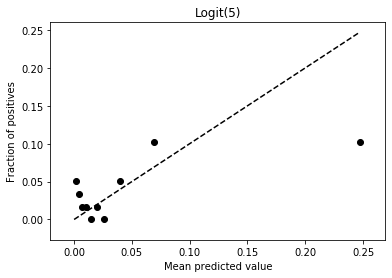

Results 20 AUC-val 0.645 0.654 0.579 0.435 0.519 AUC-train 0.842
Stats - Epoch: 1 AUC-val 0.469  AUC-train 0.605
Stats - Epoch: 2 AUC-val 0.623  AUC-train 0.773
Stats - Epoch: 3 AUC-val 0.682  AUC-train 0.832
Stats - Epoch: 4 AUC-val 0.660  AUC-train 0.870
Stats - Epoch: 5 AUC-val 0.688  AUC-train 0.900
Stats - Epoch: 6 AUC-val 0.672  AUC-train 0.921
Stats - Epoch: 7 AUC-val 0.701  AUC-train 0.938
Stats - Epoch: 8 AUC-val 0.683  AUC-train 0.949
Stats - Epoch: 9 AUC-val 0.684  AUC-train 0.960
Stats - Epoch: 10 AUC-val 0.702  AUC-train 0.963
Stats - Epoch: 11 AUC-val 0.670  AUC-train 0.971
Stats - Epoch: 12 AUC-val 0.688  AUC-train 0.976
Stats - Epoch: 13 AUC-val 0.695  AUC-train 0.977
Stats - Epoch: 14 AUC-val 0.651  AUC-train 0.972
Stats - Epoch: 15 AUC-val 0.676  AUC-train 0.983
Stats - Epoch: 16 AUC-val 0.678  AUC-train 0.986
Stats - Epoch: 17 AUC-val 0.675  AUC-train 0.988
Stats - Epoch: 18 AUC-val 0.694  AUC-train 0.987
Stats - Epoch: 19 AUC-val 0.696  AUC-train 0.986
Stats - Epoch

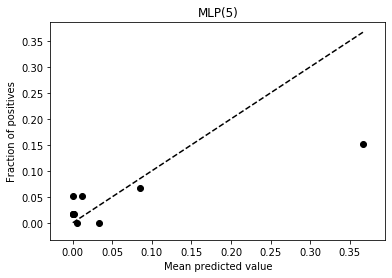

Results 20 AUC-val 0.702 0.624 0.363 0.297 0.418 AUC-train 0.963
Stats - Epoch: 1 AUC-val 0.460  AUC-train 0.569
Stats - Epoch: 2 AUC-val 0.641  AUC-train 0.798
Stats - Epoch: 3 AUC-val 0.727  AUC-train 0.867
Stats - Epoch: 4 AUC-val 0.802  AUC-train 0.891
Stats - Epoch: 5 AUC-val 0.749  AUC-train 0.912
Stats - Epoch: 6 AUC-val 0.772  AUC-train 0.922
Stats - Epoch: 7 AUC-val 0.819  AUC-train 0.931
Stats - Epoch: 8 AUC-val 0.821  AUC-train 0.942
Stats - Epoch: 9 AUC-val 0.793  AUC-train 0.950
Stats - Epoch: 10 AUC-val 0.812  AUC-train 0.957
Stats - Epoch: 11 AUC-val 0.809  AUC-train 0.967
Stats - Epoch: 12 AUC-val 0.792  AUC-train 0.967
Stats - Epoch: 13 AUC-val 0.761  AUC-train 0.975
Stats - Epoch: 14 AUC-val 0.808  AUC-train 0.978
Stats - Epoch: 15 AUC-val 0.808  AUC-train 0.978
Stats - Epoch: 16 AUC-val 0.807  AUC-train 0.980
Stats - Epoch: 17 AUC-val 0.812  AUC-train 0.983
Stats - Epoch: 18 AUC-val 0.788  AUC-train 0.986
Stats - Epoch: 19 AUC-val 0.802  AUC-train 0.986
Stats - Epoch

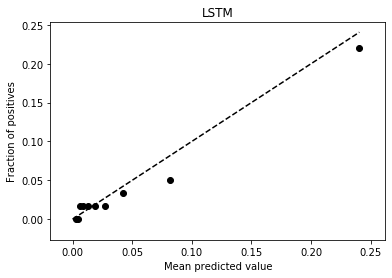

Results 20 AUC-val 0.821 0.752 0.593 0.476 0.436 AUC-train 0.942
Stats - Epoch: 1 AUC-val 0.493  AUC-train 0.583
Stats - Epoch: 2 AUC-val 0.598  AUC-train 0.720
Stats - Epoch: 3 AUC-val 0.619  AUC-train 0.782
Stats - Epoch: 4 AUC-val 0.673  AUC-train 0.824
Stats - Epoch: 5 AUC-val 0.668  AUC-train 0.853
Stats - Epoch: 6 AUC-val 0.680  AUC-train 0.870
Stats - Epoch: 7 AUC-val 0.664  AUC-train 0.889
Stats - Epoch: 8 AUC-val 0.726  AUC-train 0.903
Stats - Epoch: 9 AUC-val 0.695  AUC-train 0.917
Stats - Epoch: 10 AUC-val 0.690  AUC-train 0.932
Stats - Epoch: 11 AUC-val 0.736  AUC-train 0.939
Stats - Epoch: 12 AUC-val 0.743  AUC-train 0.950
Stats - Epoch: 13 AUC-val 0.740  AUC-train 0.960
Stats - Epoch: 14 AUC-val 0.730  AUC-train 0.964
Stats - Epoch: 15 AUC-val 0.748  AUC-train 0.971
Stats - Epoch: 16 AUC-val 0.710  AUC-train 0.974
Stats - Epoch: 17 AUC-val 0.717  AUC-train 0.980
Stats - Epoch: 18 AUC-val 0.684  AUC-train 0.979
Stats - Epoch: 19 AUC-val 0.719  AUC-train 0.983
Stats - Epoch

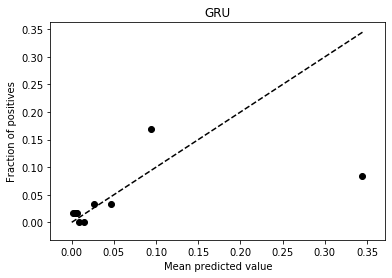

Results 20 AUC-val 0.748 0.687 0.570 0.416 0.380 AUC-train 0.971


In [ ]:
# Cross-validation:

reps=1;
predictors=['tloansgdp_g','rsp_g','rhp_g','ca/gdp','rgdp_g'];
fcast_horizon=1;
time_start=1974;
time_end=2016;
epochs = 20;
df3=init_data(df = df, start_year = 1870, end_year = 2016,y_shift = 1, normalize = False);
a=cross_validation2(d2cgraph=True,Nf=5,mm=0,nlags=5,df=df3,fcast_horizon=fcast_horizon,plot_reliability=True,epochs=epochs,time_start=start_year,time_end=end_year)
a=cross_validation2(d2cgraph=True,Nf=5,mm=2,nlags=5,df=df3,fcast_horizon=fcast_horizon,plot_reliability=True,epochs=epochs,time_start=start_year,time_end=end_year)
a=cross_validation2(d2cgraph=True,Nf=5,mm=4,nlags=5,df=df3,fcast_horizon=fcast_horizon,plot_reliability=True,epochs=epochs,time_start=start_year,time_end=end_year)
a=cross_validation2(d2cgraph=True,Nf=5,mm=5,nlags=5,df=df3,fcast_horizon=fcast_horizon,plot_reliability=True,epochs=epochs,time_start=start_year,time_end=end_year)

In [ ]:
df3

,year,iso,cpi_g,rgdp_g,ca/gdp,debtgdp_g,tloansgdp_g,rsp_g,rhp_g,rtloans_g,rtmort_g,rthh_g,rtbus_g,ltrate,stir,crisisJST,cid,precrisis,stfilt
0,1871,AUS,-1.538437,2.914825,2.486658,11.144013,-3.194398,-6.603148,-3.054001,-0.372684,6.761506,6.761506,-0.598348,4.844633,4.60,0,0,0,0
1,1872,AUS,-4.687499,12.773495,3.459822,-19.227942,-3.375740,21.243278,8.248763,8.966555,-12.667323,-12.667323,9.701529,4.737350,4.60,0,0,0,0
2,1873,AUS,0.000000,17.211961,-4.144906,-7.893106,-0.076511,15.630000,-3.076923,17.122282,-7.210884,-7.210884,17.780394,4.671958,4.40,0,0,0,0
3,1874,AUS,4.918032,2.836231,-1.934752,36.182827,1.328401,0.564219,14.980159,4.202308,0.203905,0.203905,4.287503,4.653317,4.50,0,0,0,0
4,1875,AUS,3.124987,1.407157,-2.629759,20.257614,6.963422,1.566073,-3.030291,8.468565,5.760547,5.760547,8.524006,4.507325,4.60,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1645,2012,USA,2.088378,1.977832,-2.751995,4.270833,-0.870406,12.054405,-2.106521,1.090211,-1.425487,-1.229252,5.772191,1.802500,0.14,0,16,0,0
1646,2013,USA,1.452713,1.839598,-2.553377,1.098901,-0.281498,25.283465,5.860038,1.552922,0.393632,-0.278504,5.005061,2.350830,0.11,0,16,0,0
1647,2014,USA,1.636470,2.728901,-2.005692,1.976285,1.121094,11.805296,3.766884,3.880589,1.633363,1.445847,8.239024,2.540833,0.09,0,16,0,0
1648,2015,USA,0.115009,3.857580,-2.062812,-2.325581,3.254445,-0.124115,5.476484,7.237568,6.575875,5.619048,9.953044,2.135833,0.13,0,16,0,0
